In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm
import pandas as pd
import time
import os 
import seaborn as sns
import random

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.6.0


### Define PINN neural network

In [5]:
def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(1))
    
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                    kernel_initializer='glorot_normal'))
    
    model.add(tf.keras.layers.Dense(3, activation=tf.keras.activations.get('softmax')))
    
    return model

In [6]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, model):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = model
        
        self.iter = 0
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1]
            u2 = u[:,1:2]
            u3 = u[:,2:3]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        
        #calculate residuals
        xx = self.Xr_tf*self.sigma_x + self.mu_x
        residual_1 = u_x_1-(-2.572e-4*xx*u1)
        residual_2 = u_x_2-(1.12e-4*xx*u1-2.012e-4*xx*u2)
        residual_3 = u_x_3-(1.452e-4*xx*u1+2.012e-4*xx*u2)       
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1))
        loss_2 = tf.reduce_mean(tf.square(residual_2))
        loss_3 = tf.reduce_mean(tf.square(residual_3))
        
        del g
        
        return loss_1, loss_2, loss_3
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3 = self.get_r()
        
        return [loss_u, loss_1, loss_2, loss_3]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1:]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 5 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
            
            if i%10000 == 0:
                self.weights_log.append(PINN_solver.model.get_weights())
                self.gradients_log.append([grad_theta, g_u, g_r])

### Generate training data

In [7]:
######################################################################################
# Number of training data
N_u = 1                        # Boundary condition data on u(x)  
N_r = 300                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([300.0])          # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0]])   ##TZ                    # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [8]:
N = 150000

### Train PINN without PCGrad

In [9]:
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1e-3, decay_steps=10000,
    end_learning_rate=0.0001, power=0.5)

In [10]:
PINN_solver = PINN(x_u, y_u, x_r, init_model())
initial_weights = PINN_solver.model.get_weights()

In [11]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 00000: loss = 0.21774757,0.000191583,1.2759751e-05,0.0003020966
Iteration 00005: loss = 0.098906,0.00011751885,4.5088338e-05,0.00029278707
Iteration 00010: loss = 0.035379846,8.344652e-05,8.895348e-05,0.00029104404
Iteration 00015: loss = 0.012373656,7.187579e-05,0.00012532406,0.00029034758
Iteration 00020: loss = 0.0050539,7.006567e-05,0.00014881224,0.00028856558
Iteration 00025: loss = 0.002530221,7.157764e-05,0.00016226266,0.0002857003
Iteration 00030: loss = 0.0015177638,7.382496e-05,0.00016923383,0.00028208244
Iteration 00035: loss = 0.0010470814,7.592897e-05,0.00017221505,0.00027800276
Iteration 00040: loss = 0.00079956447,7.766802e-05,0.00017275555,0.00027366052
Iteration 00045: loss = 0.00065564906,7.904785e-05,0.0001717967,0.0002691782
Iteration 00050: loss = 0.0005646149,8.013765e-05,0.00016991112,0.00026462637
Iteration 00055: loss = 0.00050264626,8.101179e-05,0.00016745014,0.00026004456
Iteration 00060: loss = 0.0004576055,8.173208e-05,0.00016463162,0.00025545518


Iteration 00630: loss = 3.4594814e-05,9.0157846e-05,2.4899762e-05,5.6579673e-05
Iteration 00635: loss = 3.4260225e-05,8.999874e-05,2.4716554e-05,5.618186e-05
Iteration 00640: loss = 3.393158e-05,8.983724e-05,2.4536856e-05,5.578907e-05
Iteration 00645: loss = 3.360947e-05,8.967335e-05,2.436057e-05,5.5401193e-05
Iteration 00650: loss = 3.329315e-05,8.950713e-05,2.4187591e-05,5.5018092e-05
Iteration 00655: loss = 3.2982858e-05,8.933858e-05,2.4017834e-05,5.463965e-05
Iteration 00660: loss = 3.2677566e-05,8.916774e-05,2.3851198e-05,5.4265733e-05
Iteration 00665: loss = 3.2377222e-05,8.8994624e-05,2.36876e-05,5.3896234e-05
Iteration 00670: loss = 3.208293e-05,8.881928e-05,2.3526949e-05,5.3531043e-05
Iteration 00675: loss = 3.179433e-05,8.86417e-05,2.3369159e-05,5.317005e-05
Iteration 00680: loss = 3.150959e-05,8.846193e-05,2.3214154e-05,5.2813142e-05
Iteration 00685: loss = 3.123095e-05,8.8279994e-05,2.3061853e-05,5.2460233e-05
Iteration 00690: loss = 3.0957144e-05,8.80959e-05,2.2912182e-05,

Iteration 01180: loss = 1.7419165e-05,6.35446e-05,1.4520731e-05,2.8381304e-05
Iteration 01185: loss = 1.7356173e-05,6.326937e-05,1.446649e-05,2.8205332e-05
Iteration 01190: loss = 1.729392e-05,6.299446e-05,1.4412595e-05,2.8030381e-05
Iteration 01195: loss = 1.7232433e-05,6.271988e-05,1.4359044e-05,2.7856448e-05
Iteration 01200: loss = 1.717099e-05,6.244565e-05,1.4305837e-05,2.7683529e-05
Iteration 01205: loss = 1.7110515e-05,6.217179e-05,1.4252967e-05,2.7511624e-05
Iteration 01210: loss = 1.7050756e-05,6.189831e-05,1.4200429e-05,2.7340719e-05
Iteration 01215: loss = 1.6991477e-05,6.1625215e-05,1.4148221e-05,2.7170821e-05
Iteration 01220: loss = 1.6932705e-05,6.1352555e-05,1.4096343e-05,2.7001928e-05
Iteration 01225: loss = 1.687506e-05,6.108031e-05,1.4044788e-05,2.683403e-05
Iteration 01230: loss = 1.6816988e-05,6.0808517e-05,1.3993555e-05,2.666713e-05
Iteration 01235: loss = 1.675984e-05,6.053717e-05,1.3942644e-05,2.6501224e-05
Iteration 01240: loss = 1.6703138e-05,6.0266306e-05,1.389

Iteration 01725: loss = 1.2429842e-05,3.696154e-05,1.0060981e-05,1.4435772e-05
Iteration 01730: loss = 1.2395519e-05,3.6754067e-05,1.0029081e-05,1.4349197e-05
Iteration 01735: loss = 1.2361715e-05,3.654731e-05,9.997288e-06,1.4263261e-05
Iteration 01740: loss = 1.2328011e-05,3.634127e-05,9.965602e-06,1.4177961e-05
Iteration 01745: loss = 1.229481e-05,3.613595e-05,9.934024e-06,1.40933e-05
Iteration 01750: loss = 1.2261346e-05,3.593135e-05,9.902551e-06,1.4009271e-05
Iteration 01755: loss = 1.2228371e-05,3.5727484e-05,9.871184e-06,1.39258755e-05
Iteration 01760: loss = 1.2195516e-05,3.5524336e-05,9.839923e-06,1.3843112e-05
Iteration 01765: loss = 1.2162972e-05,3.532193e-05,9.808765e-06,1.3760976e-05
Iteration 01770: loss = 1.2130334e-05,3.512026e-05,9.777714e-06,1.367947e-05
Iteration 01775: loss = 1.20981995e-05,3.491932e-05,9.746765e-06,1.3598592e-05
Iteration 01780: loss = 1.2065798e-05,3.4719134e-05,9.715915e-06,1.351833e-05
Iteration 01785: loss = 1.2034259e-05,3.4519686e-05,9.68517e-

Iteration 02285: loss = 9.633172e-06,1.8811537e-05,7.0964916e-06,8.339693e-06
Iteration 02290: loss = 9.61379e-06,1.869952e-05,7.0754204e-06,8.313771e-06
Iteration 02295: loss = 9.595146e-06,1.8588386e-05,7.0544465e-06,8.288254e-06
Iteration 02300: loss = 9.575688e-06,1.847813e-05,7.0335686e-06,8.26313e-06
Iteration 02305: loss = 9.556786e-06,1.8368746e-05,7.012786e-06,8.238403e-06
Iteration 02310: loss = 9.5374135e-06,1.8260245e-05,6.992101e-06,8.214065e-06
Iteration 02315: loss = 9.518605e-06,1.8152605e-05,6.9715097e-06,8.190113e-06
Iteration 02320: loss = 9.499316e-06,1.8045841e-05,6.951017e-06,8.166545e-06
Iteration 02325: loss = 9.480601e-06,1.7939943e-05,6.9306184e-06,8.143355e-06
Iteration 02330: loss = 9.461582e-06,1.7834907e-05,6.910315e-06,8.120543e-06
Iteration 02335: loss = 9.4427605e-06,1.7730727e-05,6.8901077e-06,8.098098e-06
Iteration 02340: loss = 9.424167e-06,1.7627408e-05,6.8699956e-06,8.076026e-06
Iteration 02345: loss = 9.405087e-06,1.7524939e-05,6.8499794e-06,8.054

Iteration 02930: loss = 7.2058597e-06,1.0153359e-05,5.100164e-06,7.0355723e-06
Iteration 02935: loss = 7.187511e-06,1.0118139e-05,5.089379e-06,7.0327783e-06
Iteration 02940: loss = 7.169485e-06,1.008321e-05,5.078646e-06,7.0299984e-06
Iteration 02945: loss = 7.1510426e-06,1.0048571e-05,5.0679655e-06,7.02723e-06
Iteration 02950: loss = 7.13278e-06,1.0014217e-05,5.0573367e-06,7.0244755e-06
Iteration 02955: loss = 7.1146983e-06,9.980141e-06,5.046758e-06,7.0217284e-06
Iteration 02960: loss = 7.096484e-06,9.946346e-06,5.0362314e-06,7.018993e-06
Iteration 02965: loss = 7.0786045e-06,9.912822e-06,5.025753e-06,7.0162637e-06
Iteration 02970: loss = 7.060302e-06,9.879569e-06,5.0153244e-06,7.0135397e-06
Iteration 02975: loss = 7.0424867e-06,9.846583e-06,5.0049453e-06,7.010821e-06
Iteration 02980: loss = 7.024543e-06,9.813863e-06,4.994615e-06,7.0081082e-06
Iteration 02985: loss = 7.006481e-06,9.781404e-06,4.9843334e-06,7.0053993e-06
Iteration 02990: loss = 6.9887374e-06,9.749204e-06,4.974099e-06,7.

Iteration 03480: loss = 5.4714606e-06,7.450415e-06,4.1352278e-06,6.6385137e-06
Iteration 03485: loss = 5.4585066e-06,7.4327813e-06,4.127752e-06,6.633155e-06
Iteration 03490: loss = 5.4457196e-06,7.41522e-06,4.120287e-06,6.6277526e-06
Iteration 03495: loss = 5.432825e-06,7.397737e-06,4.112834e-06,6.6223133e-06
Iteration 03500: loss = 5.4206084e-06,7.380325e-06,4.105392e-06,6.6168327e-06
Iteration 03505: loss = 5.407767e-06,7.362985e-06,4.0979603e-06,6.6113116e-06
Iteration 03510: loss = 5.3952213e-06,7.345716e-06,4.0905393e-06,6.60575e-06
Iteration 03515: loss = 5.382825e-06,7.328518e-06,4.0831296e-06,6.600149e-06
Iteration 03520: loss = 5.370073e-06,7.311394e-06,4.07573e-06,6.5945073e-06
Iteration 03525: loss = 5.3577332e-06,7.294339e-06,4.06834e-06,6.588827e-06
Iteration 03530: loss = 5.34555e-06,7.2773532e-06,4.060961e-06,6.583105e-06
Iteration 03535: loss = 5.33313e-06,7.260436e-06,4.05359e-06,6.577343e-06
Iteration 03540: loss = 5.3208746e-06,7.243585e-06,4.0462287e-06,6.571541e-06

Iteration 04020: loss = 4.357763e-06,5.855879e-06,3.3519827e-06,5.827535e-06
Iteration 04025: loss = 4.349821e-06,5.843159e-06,3.3446076e-06,5.817904e-06
Iteration 04030: loss = 4.3415453e-06,5.830469e-06,3.3372253e-06,5.8082396e-06
Iteration 04035: loss = 4.333521e-06,5.817802e-06,3.3298356e-06,5.798539e-06
Iteration 04040: loss = 4.325511e-06,5.805161e-06,3.3224374e-06,5.788801e-06
Iteration 04045: loss = 4.3176346e-06,5.7925436e-06,3.315031e-06,5.7790267e-06
Iteration 04050: loss = 4.309663e-06,5.779954e-06,3.3076178e-06,5.7692173e-06
Iteration 04055: loss = 4.301471e-06,5.7673888e-06,3.3001966e-06,5.759373e-06
Iteration 04060: loss = 4.293648e-06,5.7548486e-06,3.2927671e-06,5.749493e-06
Iteration 04065: loss = 4.285956e-06,5.74233e-06,3.2853281e-06,5.7395782e-06
Iteration 04070: loss = 4.2782826e-06,5.729839e-06,3.2778814e-06,5.7296284e-06
Iteration 04075: loss = 4.270391e-06,5.7173693e-06,3.2704272e-06,5.719644e-06
Iteration 04080: loss = 4.2626334e-06,5.704924e-06,3.2629644e-06,5

Iteration 04585: loss = 3.6117144e-06,4.5433367e-06,2.4582719e-06,4.5503225e-06
Iteration 04590: loss = 3.6062954e-06,4.5325783e-06,2.44985e-06,4.5378124e-06
Iteration 04595: loss = 3.6007787e-06,4.5218303e-06,2.441422e-06,4.5252937e-06
Iteration 04600: loss = 3.595381e-06,4.511095e-06,2.4329897e-06,4.5127654e-06
Iteration 04605: loss = 3.589989e-06,4.5003685e-06,2.4245517e-06,4.500226e-06
Iteration 04610: loss = 3.5846078e-06,4.4896556e-06,2.4161093e-06,4.48768e-06
Iteration 04615: loss = 3.5792398e-06,4.4789513e-06,2.4076628e-06,4.4751255e-06
Iteration 04620: loss = 3.5739802e-06,4.4682583e-06,2.3992116e-06,4.4625626e-06
Iteration 04625: loss = 3.5684186e-06,4.457576e-06,2.3907564e-06,4.449992e-06
Iteration 04630: loss = 3.5630712e-06,4.44691e-06,2.382298e-06,4.437416e-06
Iteration 04635: loss = 3.557738e-06,4.436253e-06,2.3738357e-06,4.424833e-06
Iteration 04640: loss = 3.5524124e-06,4.4256053e-06,2.3653695e-06,4.4122426e-06
Iteration 04645: loss = 3.5474106e-06,4.414968e-06,2.3569e

Iteration 05140: loss = 3.0466351e-06,3.4182526e-06,1.5518036e-06,3.1952402e-06
Iteration 05145: loss = 3.0415597e-06,3.408825e-06,1.544557e-06,3.1842114e-06
Iteration 05150: loss = 3.0364827e-06,3.399412e-06,1.5373375e-06,3.1732181e-06
Iteration 05155: loss = 3.0312149e-06,3.3900135e-06,1.5301476e-06,3.1622599e-06
Iteration 05160: loss = 3.0262363e-06,3.3806318e-06,1.5229859e-06,3.1513375e-06
Iteration 05165: loss = 3.0211615e-06,3.3712658e-06,1.5158532e-06,3.1404509e-06
Iteration 05170: loss = 3.0158901e-06,3.3619178e-06,1.5087498e-06,3.1296024e-06
Iteration 05175: loss = 3.0108106e-06,3.3525846e-06,1.5016761e-06,3.1187894e-06
Iteration 05180: loss = 3.005545e-06,3.3432668e-06,1.4946322e-06,3.1080126e-06
Iteration 05185: loss = 3.000561e-06,3.3339657e-06,1.4876185e-06,3.097274e-06
Iteration 05190: loss = 2.9951022e-06,3.3246788e-06,1.4806346e-06,3.0865717e-06
Iteration 05195: loss = 2.9900202e-06,3.3154101e-06,1.4736802e-06,3.0759072e-06
Iteration 05200: loss = 2.984749e-06,3.3061583

Iteration 05680: loss = 2.4545543e-06,2.5084692e-06,9.567987e-07,2.2356567e-06
Iteration 05685: loss = 2.4487065e-06,2.501194e-06,9.530472e-07,2.2289514e-06
Iteration 05690: loss = 2.4430296e-06,2.49394e-06,9.493236e-07,2.222281e-06
Iteration 05695: loss = 2.4373587e-06,2.4867054e-06,9.456279e-07,2.2156448e-06
Iteration 05700: loss = 2.4316018e-06,2.479495e-06,9.419602e-07,2.2090449e-06
Iteration 05705: loss = 2.4259314e-06,2.4723063e-06,9.383201e-07,2.2024801e-06
Iteration 05710: loss = 2.4200936e-06,2.465139e-06,9.347081e-07,2.1959495e-06
Iteration 05715: loss = 2.4144285e-06,2.4579952e-06,9.3112334e-07,2.189456e-06
Iteration 05720: loss = 2.4087674e-06,2.4508709e-06,9.2756557e-07,2.1829944e-06
Iteration 05725: loss = 2.4031933e-06,2.4437695e-06,9.240344e-07,2.176568e-06
Iteration 05730: loss = 2.3971947e-06,2.43669e-06,9.205307e-07,2.1701765e-06
Iteration 05735: loss = 2.3915366e-06,2.4296312e-06,9.1705317e-07,2.1638177e-06
Iteration 05740: loss = 2.3857165e-06,2.4225953e-06,9.13602

Iteration 06205: loss = 1.8830993e-06,1.8555265e-06,6.84093e-07,1.6879021e-06
Iteration 06210: loss = 1.8782789e-06,1.8502848e-06,6.823768e-07,1.6838491e-06
Iteration 06215: loss = 1.8733143e-06,1.8450598e-06,6.806731e-07,1.679813e-06
Iteration 06220: loss = 1.8683601e-06,1.8398514e-06,6.7898094e-07,1.6757923e-06
Iteration 06225: loss = 1.8634117e-06,1.8346585e-06,6.7730025e-07,1.6717877e-06
Iteration 06230: loss = 1.8586217e-06,1.8294808e-06,6.7563104e-07,1.6677977e-06
Iteration 06235: loss = 1.8537652e-06,1.8243204e-06,6.7397303e-07,1.6638237e-06
Iteration 06240: loss = 1.848989e-06,1.8191774e-06,6.723269e-07,1.6598659e-06
Iteration 06245: loss = 1.8440704e-06,1.8140491e-06,6.706918e-07,1.6559229e-06
Iteration 06250: loss = 1.8391611e-06,1.8089393e-06,6.6906784e-07,1.651996e-06
Iteration 06255: loss = 1.8342602e-06,1.8038438e-06,6.674552e-07,1.648083e-06
Iteration 06260: loss = 1.8296643e-06,1.7987625e-06,6.6585324e-07,1.6441852e-06
Iteration 06265: loss = 1.8247773e-06,1.7937012e-06

Iteration 06810: loss = 1.3783277e-06,1.3313452e-06,5.400598e-07,1.2869519e-06
Iteration 06815: loss = 1.3748235e-06,1.3278815e-06,5.392646e-07,1.2842265e-06
Iteration 06820: loss = 1.3714535e-06,1.3244317e-06,5.384741e-07,1.2815088e-06
Iteration 06825: loss = 1.3679622e-06,1.3209965e-06,5.376886e-07,1.2787998e-06
Iteration 06830: loss = 1.3644782e-06,1.3175733e-06,5.369078e-07,1.2760976e-06
Iteration 06835: loss = 1.3611275e-06,1.3141649e-06,5.361317e-07,1.273404e-06
Iteration 06840: loss = 1.3576565e-06,1.3107681e-06,5.353599e-07,1.2707178e-06
Iteration 06845: loss = 1.3543219e-06,1.3073852e-06,5.3459286e-07,1.2680383e-06
Iteration 06850: loss = 1.3509929e-06,1.3040158e-06,5.338306e-07,1.2653672e-06
Iteration 06855: loss = 1.3476698e-06,1.3006604e-06,5.3307303e-07,1.262704e-06
Iteration 06860: loss = 1.3444155e-06,1.2973178e-06,5.323202e-07,1.2600482e-06
Iteration 06865: loss = 1.3409772e-06,1.2939906e-06,5.3157186e-07,1.2574008e-06
Iteration 06870: loss = 1.337673e-06,1.2906777e-06,

Iteration 07390: loss = 1.0426802e-06,1.0162596e-06,4.7429634e-07,1.0188438e-06
Iteration 07395: loss = 1.0403049e-06,1.0142567e-06,4.7391663e-07,1.0169246e-06
Iteration 07400: loss = 1.0378217e-06,1.0122662e-06,4.7353956e-07,1.0150117e-06
Iteration 07405: loss = 1.0354562e-06,1.0102862e-06,4.7316485e-07,1.0131046e-06
Iteration 07410: loss = 1.0330963e-06,1.008315e-06,4.727925e-07,1.0112034e-06
Iteration 07415: loss = 1.0307394e-06,1.0063571e-06,4.7242278e-07,1.0093087e-06
Iteration 07420: loss = 1.0283873e-06,1.0044099e-06,4.720556e-07,1.0074207e-06
Iteration 07425: loss = 1.0259834e-06,1.0024737e-06,4.7169112e-07,1.0055387e-06
Iteration 07430: loss = 1.0236397e-06,1.000549e-06,4.7132926e-07,1.0036631e-06
Iteration 07435: loss = 1.0212997e-06,9.986369e-07,4.7096904e-07,1.0017941e-06
Iteration 07440: loss = 1.0189642e-06,9.967337e-07,4.706112e-07,9.999305e-07
Iteration 07445: loss = 1.0166337e-06,9.948438e-07,4.702564e-07,9.980741e-07
Iteration 07450: loss = 1.0143069e-06,9.929629e-07,

Iteration 08060: loss = 7.7497504e-07,8.324681e-07,4.3926934e-07,8.129274e-07
Iteration 08065: loss = 7.7330304e-07,8.316117e-07,4.3908236e-07,8.117371e-07
Iteration 08070: loss = 7.71732e-07,8.3076117e-07,4.3889577e-07,8.1055094e-07
Iteration 08075: loss = 7.700653e-07,8.2991573e-07,4.3870983e-07,8.0936945e-07
Iteration 08080: loss = 7.684021e-07,8.2907576e-07,4.3852438e-07,8.081918e-07
Iteration 08085: loss = 7.6683835e-07,8.282426e-07,4.383393e-07,8.070194e-07
Iteration 08090: loss = 7.652791e-07,8.274134e-07,4.3815453e-07,8.058513e-07
Iteration 08095: loss = 7.6352757e-07,8.2658926e-07,4.3796996e-07,8.046861e-07
Iteration 08100: loss = 7.619752e-07,8.2577014e-07,4.3778584e-07,8.035257e-07
Iteration 08105: loss = 7.6042426e-07,8.2495467e-07,4.3760218e-07,8.0236913e-07
Iteration 08110: loss = 7.5887687e-07,8.2414556e-07,4.3741863e-07,8.012172e-07
Iteration 08115: loss = 7.5713973e-07,8.233406e-07,4.372361e-07,8.0006845e-07
Iteration 08120: loss = 7.555987e-07,8.225418e-07,4.3705353e-

Iteration 08610: loss = 6.221826e-07,7.6401693e-07,4.1970935e-07,7.0462403e-07
Iteration 08615: loss = 6.2106596e-07,7.635674e-07,4.195275e-07,7.038157e-07
Iteration 08620: loss = 6.198193e-07,7.6312017e-07,4.1934527e-07,7.030099e-07
Iteration 08625: loss = 6.187059e-07,7.626766e-07,4.1916303e-07,7.022077e-07
Iteration 08630: loss = 6.1759425e-07,7.62236e-07,4.1898068e-07,7.0140777e-07
Iteration 08635: loss = 6.1639673e-07,7.617962e-07,4.18798e-07,7.006102e-07
Iteration 08640: loss = 6.152889e-07,7.613596e-07,4.1861495e-07,6.998165e-07
Iteration 08645: loss = 6.14184e-07,7.609238e-07,4.1843148e-07,6.9902393e-07
Iteration 08650: loss = 6.130801e-07,7.6049025e-07,4.1824805e-07,6.9823415e-07
Iteration 08655: loss = 6.118053e-07,7.6005693e-07,4.180641e-07,6.974468e-07
Iteration 08660: loss = 6.107071e-07,7.596254e-07,4.1787973e-07,6.966612e-07
Iteration 08665: loss = 6.0961054e-07,7.591962e-07,4.1769536e-07,6.958784e-07
Iteration 08670: loss = 6.0851573e-07,7.587688e-07,4.175106e-07,6.9509

Iteration 09160: loss = 5.158799e-07,7.2350747e-07,3.9807122e-07,6.288006e-07
Iteration 09165: loss = 5.1520243e-07,7.2319426e-07,3.9786067e-07,6.282117e-07
Iteration 09170: loss = 5.143665e-07,7.228822e-07,3.9765e-07,6.276252e-07
Iteration 09175: loss = 5.1361246e-07,7.225717e-07,3.974392e-07,6.270402e-07
Iteration 09180: loss = 5.127788e-07,7.222627e-07,3.972282e-07,6.2645665e-07
Iteration 09185: loss = 5.1210725e-07,7.2195235e-07,3.97017e-07,6.2587446e-07
Iteration 09190: loss = 5.112774e-07,7.2164266e-07,3.9680575e-07,6.252932e-07
Iteration 09195: loss = 5.1052876e-07,7.213336e-07,3.965942e-07,6.24714e-07
Iteration 09200: loss = 5.09781e-07,7.210268e-07,3.963827e-07,6.2413676e-07
Iteration 09205: loss = 5.090352e-07,7.2071987e-07,3.9617075e-07,6.235605e-07
Iteration 09210: loss = 5.082108e-07,7.204147e-07,3.9595906e-07,6.229868e-07
Iteration 09215: loss = 5.074685e-07,7.201086e-07,3.9574695e-07,6.2241304e-07
Iteration 09220: loss = 5.067272e-07,7.198028e-07,3.955344e-07,6.2184137e-

Iteration 09705: loss = 4.474778e-07,6.931898e-07,3.7505112e-07,5.734522e-07
Iteration 09710: loss = 4.4701252e-07,6.929504e-07,3.748516e-07,5.730313e-07
Iteration 09715: loss = 4.4654868e-07,6.9271175e-07,3.7465284e-07,5.7261263e-07
Iteration 09720: loss = 4.4601154e-07,6.9247335e-07,3.7445454e-07,5.7219506e-07
Iteration 09725: loss = 4.4554997e-07,6.9223654e-07,3.7425698e-07,5.717798e-07
Iteration 09730: loss = 4.450901e-07,6.919995e-07,3.7405974e-07,5.713661e-07
Iteration 09735: loss = 4.4470573e-07,6.9176446e-07,3.738633e-07,5.7095485e-07
Iteration 09740: loss = 4.4424738e-07,6.915294e-07,3.736676e-07,5.70545e-07
Iteration 09745: loss = 4.4379036e-07,6.9129726e-07,3.7347235e-07,5.701376e-07
Iteration 09750: loss = 4.433348e-07,6.910663e-07,3.7327783e-07,5.6973306e-07
Iteration 09755: loss = 4.4288024e-07,6.9083484e-07,3.730839e-07,5.6932987e-07
Iteration 09760: loss = 4.4235216e-07,6.906053e-07,3.728907e-07,5.689288e-07
Iteration 09765: loss = 4.4197438e-07,6.9037594e-07,3.7269797e

Iteration 10240: loss = 4.1654616e-07,6.762138e-07,3.6043636e-07,5.442971e-07
Iteration 10245: loss = 4.163351e-07,6.760998e-07,3.6033526e-07,5.441063e-07
Iteration 10250: loss = 4.161964e-07,6.759867e-07,3.602339e-07,5.4391546e-07
Iteration 10255: loss = 4.1591304e-07,6.758726e-07,3.6013225e-07,5.437234e-07
Iteration 10260: loss = 4.1577508e-07,6.757594e-07,3.600305e-07,5.4353177e-07
Iteration 10265: loss = 4.1556424e-07,6.7564383e-07,3.5992858e-07,5.433391e-07
Iteration 10270: loss = 4.1542555e-07,6.755292e-07,3.5982643e-07,5.4314614e-07
Iteration 10275: loss = 4.151427e-07,6.7541373e-07,3.5972394e-07,5.42953e-07
Iteration 10280: loss = 4.1500417e-07,6.7529777e-07,3.5962125e-07,5.4275944e-07
Iteration 10285: loss = 4.1486592e-07,6.751816e-07,3.5951822e-07,5.425655e-07
Iteration 10290: loss = 4.1465515e-07,6.7506613e-07,3.5941503e-07,5.4237125e-07
Iteration 10295: loss = 4.1451673e-07,6.7495e-07,3.5931168e-07,5.42177e-07
Iteration 10300: loss = 4.1423337e-07,6.7483506e-07,3.592084e-07

Iteration 10875: loss = 3.914308e-07,6.600315e-07,3.456583e-07,5.1742546e-07
Iteration 10880: loss = 3.911497e-07,6.5988974e-07,3.455255e-07,5.171924e-07
Iteration 10885: loss = 3.9100811e-07,6.597461e-07,3.4539244e-07,5.1695827e-07
Iteration 10890: loss = 3.9072643e-07,6.596037e-07,3.4525917e-07,5.167247e-07
Iteration 10895: loss = 3.9058543e-07,6.594603e-07,3.4512527e-07,5.1649005e-07
Iteration 10900: loss = 3.9037377e-07,6.5931664e-07,3.449913e-07,5.1625534e-07
Iteration 10905: loss = 3.9016268e-07,6.59173e-07,3.4485706e-07,5.160201e-07
Iteration 10910: loss = 3.899507e-07,6.5902987e-07,3.4472257e-07,5.157852e-07
Iteration 10915: loss = 3.8980897e-07,6.588864e-07,3.4458782e-07,5.155495e-07
Iteration 10920: loss = 3.8952746e-07,6.5874224e-07,3.4445281e-07,5.153134e-07
Iteration 10925: loss = 3.8938592e-07,6.585967e-07,3.4431753e-07,5.150766e-07
Iteration 10930: loss = 3.8910514e-07,6.5845165e-07,3.441818e-07,5.148394e-07
Iteration 10935: loss = 3.8896346e-07,6.583066e-07,3.440459e-07

Iteration 11435: loss = 3.6815752e-07,6.4255795e-07,3.290389e-07,4.8906935e-07
Iteration 11440: loss = 3.6788e-07,6.4238816e-07,3.288742e-07,4.8879537e-07
Iteration 11445: loss = 3.6773903e-07,6.422174e-07,3.287092e-07,4.885209e-07
Iteration 11450: loss = 3.6746226e-07,6.420469e-07,3.2854413e-07,4.8824603e-07
Iteration 11455: loss = 3.6732118e-07,6.418752e-07,3.2837826e-07,4.879709e-07
Iteration 11460: loss = 3.6711234e-07,6.4170405e-07,3.2821254e-07,4.876958e-07
Iteration 11465: loss = 3.6690372e-07,6.4153284e-07,3.280461e-07,4.8742015e-07
Iteration 11470: loss = 3.6669516e-07,6.413611e-07,3.2787958e-07,4.8714406e-07
Iteration 11475: loss = 3.6648632e-07,6.4118865e-07,3.277127e-07,4.8686724e-07
Iteration 11480: loss = 3.662776e-07,6.410164e-07,3.275455e-07,4.8659075e-07
Iteration 11485: loss = 3.6600122e-07,6.4084463e-07,3.2737842e-07,4.8631335e-07
Iteration 11490: loss = 3.6586016e-07,6.4067103e-07,3.2721047e-07,4.8603584e-07
Iteration 11495: loss = 3.6558365e-07,6.4049885e-07,3.2704

Iteration 11965: loss = 3.4604776e-07,6.231107e-07,3.0991438e-07,4.5795298e-07
Iteration 11970: loss = 3.4577747e-07,6.2291343e-07,3.0971788e-07,4.5763892e-07
Iteration 11975: loss = 3.4557397e-07,6.2271783e-07,3.0952117e-07,4.5732546e-07
Iteration 11980: loss = 3.4537035e-07,6.22519e-07,3.0932404e-07,4.5701057e-07
Iteration 11985: loss = 3.4516657e-07,6.223214e-07,3.0912668e-07,4.5669586e-07
Iteration 11990: loss = 3.4496256e-07,6.221238e-07,3.0892897e-07,4.5638038e-07
Iteration 11995: loss = 3.4479194e-07,6.219259e-07,3.087313e-07,4.5606478e-07
Iteration 12000: loss = 3.4458688e-07,6.2173075e-07,3.0853312e-07,4.5575027e-07
Iteration 12005: loss = 3.443832e-07,6.215333e-07,3.0833476e-07,4.5543416e-07
Iteration 12010: loss = 3.4417815e-07,6.213355e-07,3.08136e-07,4.5511828e-07
Iteration 12015: loss = 3.4397442e-07,6.211389e-07,3.0793714e-07,4.5480206e-07
Iteration 12020: loss = 3.437709e-07,6.2094045e-07,3.0773754e-07,4.5448502e-07
Iteration 12025: loss = 3.435671e-07,6.207412e-07,3.07

Iteration 12530: loss = 3.231049e-07,5.9939487e-07,2.858608e-07,4.2019596e-07
Iteration 12535: loss = 3.229084e-07,5.991724e-07,2.8563187e-07,4.1984168e-07
Iteration 12540: loss = 3.227118e-07,5.9894927e-07,2.854027e-07,4.194867e-07
Iteration 12545: loss = 3.2257876e-07,5.987262e-07,2.8517317e-07,4.1913188e-07
Iteration 12550: loss = 3.2231858e-07,5.985038e-07,2.8494338e-07,4.1877666e-07
Iteration 12555: loss = 3.2212256e-07,5.9828034e-07,2.8471345e-07,4.1842054e-07
Iteration 12560: loss = 3.219258e-07,5.9805654e-07,2.8448315e-07,4.180648e-07
Iteration 12565: loss = 3.2173008e-07,5.9783184e-07,2.8425256e-07,4.1770784e-07
Iteration 12570: loss = 3.2153403e-07,5.9760674e-07,2.8402172e-07,4.1735078e-07
Iteration 12575: loss = 3.2133914e-07,5.973812e-07,2.8379048e-07,4.169933e-07
Iteration 12580: loss = 3.2114323e-07,5.9715586e-07,2.8355907e-07,4.1663526e-07
Iteration 12585: loss = 3.209474e-07,5.96931e-07,2.8332744e-07,4.1627771e-07
Iteration 12590: loss = 3.207515e-07,5.967061e-07,2.8309

Iteration 13095: loss = 3.013164e-07,5.7293755e-07,2.5843966e-07,3.7810875e-07
Iteration 13100: loss = 3.0119017e-07,5.726912e-07,2.5818454e-07,3.7771864e-07
Iteration 13105: loss = 3.0100216e-07,5.724458e-07,2.5792932e-07,3.773295e-07
Iteration 13110: loss = 3.008135e-07,5.722007e-07,2.5767386e-07,3.7693934e-07
Iteration 13115: loss = 3.0062566e-07,5.7195393e-07,2.574181e-07,3.76549e-07
Iteration 13120: loss = 3.0043805e-07,5.717076e-07,2.5716247e-07,3.7615857e-07
Iteration 13125: loss = 3.0025015e-07,5.714604e-07,2.5690645e-07,3.7576729e-07
Iteration 13130: loss = 3.0006152e-07,5.712153e-07,2.5665054e-07,3.7537686e-07
Iteration 13135: loss = 2.998735e-07,5.709705e-07,2.563944e-07,3.749863e-07
Iteration 13140: loss = 2.996858e-07,5.7072174e-07,2.561376e-07,3.7459444e-07
Iteration 13145: loss = 2.9949842e-07,5.704758e-07,2.5588096e-07,3.7420293e-07
Iteration 13150: loss = 2.9931064e-07,5.7022925e-07,2.5562417e-07,3.7381105e-07
Iteration 13155: loss = 2.9912275e-07,5.699825e-07,2.553671

Iteration 13730: loss = 2.7827454e-07,5.4044455e-07,2.2495117e-07,3.2691548e-07
Iteration 13735: loss = 2.7809583e-07,5.4017505e-07,2.2468167e-07,3.2650075e-07
Iteration 13740: loss = 2.7791603e-07,5.399086e-07,2.2441249e-07,3.2608673e-07
Iteration 13745: loss = 2.7773578e-07,5.3964334e-07,2.2414369e-07,3.256734e-07
Iteration 13750: loss = 2.7761476e-07,5.3937856e-07,2.238744e-07,3.2526e-07
Iteration 13755: loss = 2.7737556e-07,5.39111e-07,2.2360527e-07,3.248458e-07
Iteration 13760: loss = 2.7719753e-07,5.3884094e-07,2.2333559e-07,3.244304e-07
Iteration 13765: loss = 2.7707904e-07,5.385701e-07,2.2306594e-07,3.2401434e-07
Iteration 13770: loss = 2.768404e-07,5.3830365e-07,2.227969e-07,3.236005e-07
Iteration 13775: loss = 2.7671936e-07,5.380374e-07,2.2252785e-07,3.2318607e-07
Iteration 13780: loss = 2.765397e-07,5.377699e-07,2.222587e-07,3.2277126e-07
Iteration 13785: loss = 2.7636014e-07,5.3750233e-07,2.2198951e-07,3.2235675e-07
Iteration 13790: loss = 2.7618114e-07,5.3723437e-07,2.2172

Iteration 14300: loss = 2.583623e-07,5.090686e-07,1.9447442e-07,2.7944594e-07
Iteration 14305: loss = 2.5813083e-07,5.087854e-07,1.9421226e-07,2.7903118e-07
Iteration 14310: loss = 2.5801464e-07,5.08499e-07,1.9394994e-07,2.7861563e-07
Iteration 14315: loss = 2.5784013e-07,5.0821586e-07,1.9368818e-07,2.782011e-07
Iteration 14320: loss = 2.5760954e-07,5.07931e-07,1.9342663e-07,2.7778594e-07
Iteration 14325: loss = 2.574935e-07,5.076441e-07,1.9316472e-07,2.7737016e-07
Iteration 14330: loss = 2.5726249e-07,5.073598e-07,1.9290334e-07,2.7695543e-07
Iteration 14335: loss = 2.5714576e-07,5.070748e-07,1.926421e-07,2.7654104e-07
Iteration 14340: loss = 2.5697116e-07,5.067914e-07,1.923812e-07,2.761272e-07
Iteration 14345: loss = 2.5674083e-07,5.065055e-07,1.921202e-07,2.75713e-07
Iteration 14350: loss = 2.5662558e-07,5.062171e-07,1.9185902e-07,2.7529734e-07
Iteration 14355: loss = 2.56396e-07,5.059292e-07,1.9159825e-07,2.7488238e-07
Iteration 14360: loss = 2.5628006e-07,5.0564114e-07,1.9133746e-0

Iteration 14870: loss = 2.3843012e-07,4.754815e-07,1.6586479e-07,2.3311361e-07
Iteration 14875: loss = 2.3825923e-07,4.7517707e-07,1.656283e-07,2.3272058e-07
Iteration 14880: loss = 2.3809038e-07,4.7486895e-07,1.6539154e-07,2.3232671e-07
Iteration 14885: loss = 2.3792153e-07,4.7456203e-07,1.6515527e-07,2.319336e-07
Iteration 14890: loss = 2.3775243e-07,4.7425448e-07,1.6491919e-07,2.3154081e-07
Iteration 14895: loss = 2.3752612e-07,4.7395102e-07,1.64684e-07,2.311498e-07
Iteration 14900: loss = 2.3741097e-07,4.736437e-07,1.644487e-07,2.3075812e-07
Iteration 14905: loss = 2.371874e-07,4.733353e-07,1.6421346e-07,2.3036574e-07
Iteration 14910: loss = 2.370739e-07,4.7302416e-07,1.6397847e-07,2.2997305e-07
Iteration 14915: loss = 2.368505e-07,4.727154e-07,1.6374403e-07,2.2958152e-07
Iteration 14920: loss = 2.3668026e-07,4.724098e-07,1.6351026e-07,2.2919147e-07
Iteration 14925: loss = 2.3650999e-07,4.7210256e-07,1.6327665e-07,2.2880155e-07
Iteration 14930: loss = 2.3628581e-07,4.717943e-07,1.6

Iteration 15425: loss = 2.1857086e-07,4.399431e-07,1.414894e-07,1.915572e-07
Iteration 15430: loss = 2.1835092e-07,4.396078e-07,1.4128842e-07,1.9120564e-07
Iteration 15435: loss = 2.1818347e-07,4.3927332e-07,1.4108797e-07,1.908546e-07
Iteration 15440: loss = 2.180172e-07,4.3893698e-07,1.4088756e-07,1.9050348e-07
Iteration 15445: loss = 2.1779827e-07,4.3859893e-07,1.406874e-07,1.9015216e-07
Iteration 15450: loss = 2.1763226e-07,4.3826003e-07,1.4048743e-07,1.8980138e-07
Iteration 15455: loss = 2.1741278e-07,4.3792343e-07,1.4028802e-07,1.8945235e-07
Iteration 15460: loss = 2.1729959e-07,4.3758385e-07,1.400886e-07,1.8910235e-07
Iteration 15465: loss = 2.1708206e-07,4.3724296e-07,1.3988951e-07,1.8875251e-07
Iteration 15470: loss = 2.1691459e-07,4.36907e-07,1.3969128e-07,1.8840488e-07
Iteration 15475: loss = 2.1674737e-07,4.365689e-07,1.3949335e-07,1.8805747e-07
Iteration 15480: loss = 2.1652835e-07,4.3622936e-07,1.3929554e-07,1.8770994e-07
Iteration 15485: loss = 2.1636389e-07,4.35886e-07,1

Iteration 15975: loss = 1.9806488e-07,4.006998e-07,1.2128713e-07,1.5562131e-07
Iteration 15980: loss = 1.9790325e-07,4.0031665e-07,1.2111961e-07,1.5532032e-07
Iteration 15985: loss = 1.9768983e-07,3.999354e-07,1.2095292e-07,1.550206e-07
Iteration 15990: loss = 1.9752652e-07,3.995547e-07,1.207864e-07,1.5472186e-07
Iteration 15995: loss = 1.9731262e-07,3.9917447e-07,1.2062029e-07,1.5442406e-07
Iteration 16000: loss = 1.9709942e-07,3.98793e-07,1.2045426e-07,1.5412616e-07
Iteration 16005: loss = 1.9698668e-07,3.9840933e-07,1.2028843e-07,1.5382847e-07
Iteration 16010: loss = 1.9672224e-07,3.9802964e-07,1.2012345e-07,1.5353267e-07
Iteration 16015: loss = 1.9655937e-07,3.9764532e-07,1.199582e-07,1.5323585e-07
Iteration 16020: loss = 1.9639712e-07,3.9725944e-07,1.1979304e-07,1.5293912e-07
Iteration 16025: loss = 1.9618312e-07,3.9687723e-07,1.1962858e-07,1.526445e-07
Iteration 16030: loss = 1.9597076e-07,3.9649123e-07,1.1946408e-07,1.52349e-07
Iteration 16035: loss = 1.9580811e-07,3.9610464e-07

Iteration 16535: loss = 1.764801e-07,3.5494585e-07,1.0394974e-07,1.250293e-07
Iteration 16540: loss = 1.7631818e-07,3.5450907e-07,1.0380478e-07,1.247834e-07
Iteration 16545: loss = 1.7611164e-07,3.5406686e-07,1.0365935e-07,1.2453653e-07
Iteration 16550: loss = 1.7590592e-07,3.536233e-07,1.0351393e-07,1.2428941e-07
Iteration 16555: loss = 1.7569853e-07,3.5318254e-07,1.033689e-07,1.240441e-07
Iteration 16560: loss = 1.7553769e-07,3.527429e-07,1.03224195e-07,1.2379975e-07
Iteration 16565: loss = 1.7533074e-07,3.5230013e-07,1.0307935e-07,1.2355503e-07
Iteration 16570: loss = 1.7512586e-07,3.5185266e-07,1.0293399e-07,1.2330916e-07
Iteration 16575: loss = 1.7491881e-07,3.514089e-07,1.0278937e-07,1.2306552e-07
Iteration 16580: loss = 1.7475766e-07,3.509673e-07,1.02645245e-07,1.2282314e-07
Iteration 16585: loss = 1.7454984e-07,3.505244e-07,1.0250112e-07,1.2258093e-07
Iteration 16590: loss = 1.742974e-07,3.500768e-07,1.02356495e-07,1.2233771e-07
Iteration 16595: loss = 1.7413964e-07,3.4962622e-

Iteration 17095: loss = 1.5404126e-07,3.0191723e-07,8.796702e-08,9.992048e-08
Iteration 17100: loss = 1.5388379e-07,3.0141192e-07,8.78241e-08,9.971861e-08
Iteration 17105: loss = 1.5363953e-07,3.0090388e-07,8.768076e-08,9.951631e-08
Iteration 17110: loss = 1.5348381e-07,3.0039328e-07,8.753725e-08,9.9313986e-08
Iteration 17115: loss = 1.5323742e-07,2.998886e-07,8.739436e-08,9.911373e-08
Iteration 17120: loss = 1.530386e-07,2.9937607e-07,8.7250655e-08,9.891151e-08
Iteration 17125: loss = 1.5283912e-07,2.98865e-07,8.710696e-08,9.871017e-08
Iteration 17130: loss = 1.5259356e-07,2.9835684e-07,8.6963674e-08,9.851075e-08
Iteration 17135: loss = 1.5243668e-07,2.9784704e-07,8.682014e-08,9.831123e-08
Iteration 17140: loss = 1.5219318e-07,2.97334e-07,8.667624e-08,9.811133e-08
Iteration 17145: loss = 1.5203888e-07,2.968194e-07,8.653216e-08,9.791073e-08
Iteration 17150: loss = 1.5179373e-07,2.9630797e-07,8.6388575e-08,9.771233e-08
Iteration 17155: loss = 1.51594e-07,2.957949e-07,8.624476e-08,9.7513

Iteration 17660: loss = 1.305477e-07,2.416401e-07,7.123533e-08,7.9208164e-08
Iteration 17665: loss = 1.3031466e-07,2.4109093e-07,7.1082226e-08,7.904492e-08
Iteration 17670: loss = 1.301233e-07,2.405386e-07,7.092872e-08,7.888088e-08
Iteration 17675: loss = 1.2993253e-07,2.3998572e-07,7.07749e-08,7.8717214e-08
Iteration 17680: loss = 1.297009e-07,2.3943363e-07,7.062115e-08,7.85541e-08
Iteration 17685: loss = 1.2946694e-07,2.388863e-07,7.046805e-08,7.8393136e-08
Iteration 17690: loss = 1.2927426e-07,2.3833728e-07,7.031466e-08,7.82318e-08
Iteration 17695: loss = 1.2908353e-07,2.3778492e-07,7.0160766e-08,7.8069725e-08
Iteration 17700: loss = 1.2885435e-07,2.3722876e-07,7.000631e-08,7.790652e-08
Iteration 17705: loss = 1.2862183e-07,2.3667894e-07,6.985279e-08,7.774639e-08
Iteration 17710: loss = 1.2842699e-07,2.3613507e-07,6.9699894e-08,7.758845e-08
Iteration 17715: loss = 1.2823641e-07,2.3558329e-07,6.954582e-08,7.742782e-08
Iteration 17720: loss = 1.2800837e-07,2.3502483e-07,6.939098e-08,7

Iteration 18240: loss = 1.061238e-07,1.7970329e-07,5.3542845e-08,6.268959e-08
Iteration 18245: loss = 1.0590772e-07,1.7921161e-07,5.3397972e-08,6.256998e-08
Iteration 18250: loss = 1.05691136e-07,1.7872243e-07,5.3253498e-08,6.245124e-08
Iteration 18255: loss = 1.0551377e-07,1.7822983e-07,5.3108682e-08,6.2331154e-08
Iteration 18260: loss = 1.05298795e-07,1.777401e-07,5.296449e-08,6.221214e-08
Iteration 18265: loss = 1.0508446e-07,1.7725124e-07,5.2820443e-08,6.209342e-08
Iteration 18270: loss = 1.0487037e-07,1.7676268e-07,5.2676587e-08,6.1974916e-08
Iteration 18275: loss = 1.0465544e-07,1.7627787e-07,5.2533213e-08,6.185758e-08
Iteration 18280: loss = 1.0447923e-07,1.7578994e-07,5.2389733e-08,6.173885e-08
Iteration 18285: loss = 1.0428482e-07,1.7530286e-07,5.2246474e-08,6.162072e-08
Iteration 18290: loss = 1.0406844e-07,1.7482533e-07,5.210449e-08,6.150592e-08
Iteration 18295: loss = 1.0385315e-07,1.7434729e-07,5.1962683e-08,6.1390786e-08
Iteration 18300: loss = 1.0364011e-07,1.7386625e-07

Iteration 18805: loss = 8.4072724e-08,1.3249965e-07,3.941454e-08,5.1102166e-08
Iteration 18810: loss = 8.3912624e-08,1.3216945e-07,3.9313644e-08,5.101518e-08
Iteration 18815: loss = 8.372074e-08,1.3184057e-07,3.9213013e-08,5.092775e-08
Iteration 18820: loss = 8.353238e-08,1.3150635e-07,3.9111892e-08,5.083812e-08
Iteration 18825: loss = 8.337761e-08,1.3117179e-07,3.901095e-08,5.0748078e-08
Iteration 18830: loss = 8.3187395e-08,1.3084454e-07,3.8911313e-08,5.0660383e-08
Iteration 18835: loss = 8.296279e-08,1.3052373e-07,3.8812654e-08,5.0574673e-08
Iteration 18840: loss = 8.280807e-08,1.3019515e-07,3.8713107e-08,5.0485554e-08
Iteration 18845: loss = 8.262021e-08,1.2986952e-07,3.861424e-08,5.039722e-08
Iteration 18850: loss = 8.246434e-08,1.2954668e-07,3.8515932e-08,5.030952e-08
Iteration 18855: loss = 8.2275925e-08,1.2922551e-07,3.841813e-08,5.022232e-08
Iteration 18860: loss = 8.21199e-08,1.2890669e-07,3.832079e-08,5.013521e-08
Iteration 18865: loss = 8.1933194e-08,1.2858641e-07,3.822342e

Iteration 19345: loss = 6.671195e-08,1.03497875e-07,3.038788e-08,4.2113957e-08
Iteration 19350: loss = 6.657657e-08,1.0328589e-07,3.031839e-08,4.2035794e-08
Iteration 19355: loss = 6.644215e-08,1.03073305e-07,3.0248895e-08,4.1957364e-08
Iteration 19360: loss = 6.630996e-08,1.0285728e-07,3.0178956e-08,4.1877453e-08
Iteration 19365: loss = 6.6148495e-08,1.0264319e-07,3.0109312e-08,4.1797918e-08
Iteration 19370: loss = 6.6015e-08,1.024323e-07,3.0040272e-08,4.1719517e-08
Iteration 19375: loss = 6.591133e-08,1.0222053e-07,2.9971083e-08,4.1640458e-08
Iteration 19380: loss = 6.5748985e-08,1.0201133e-07,2.9902434e-08,4.1562284e-08
Iteration 19385: loss = 6.5616064e-08,1.0180268e-07,2.9833878e-08,4.148409e-08
Iteration 19390: loss = 6.5484066e-08,1.0159285e-07,2.9765193e-08,4.140528e-08
Iteration 19395: loss = 6.535348e-08,1.0138156e-07,2.9696306e-08,4.1325716e-08
Iteration 19400: loss = 6.5192694e-08,1.0117463e-07,2.9628175e-08,4.1247464e-08
Iteration 19405: loss = 6.5062046e-08,1.0096588e-07,

Iteration 19930: loss = 5.2623466e-08,8.2038895e-08,2.306685e-08,3.336629e-08
Iteration 19935: loss = 5.2537658e-08,8.1879456e-08,2.3010221e-08,3.3296796e-08
Iteration 19940: loss = 5.242686e-08,8.171937e-08,2.295353e-08,3.3227057e-08
Iteration 19945: loss = 5.2340685e-08,8.1561126e-08,2.2897245e-08,3.3158077e-08
Iteration 19950: loss = 5.2229783e-08,8.140195e-08,2.2840844e-08,3.3088764e-08
Iteration 19955: loss = 5.2119386e-08,8.124247e-08,2.2784413e-08,3.3019287e-08
Iteration 19960: loss = 5.203606e-08,8.1080884e-08,2.2727676e-08,3.2949032e-08
Iteration 19965: loss = 5.192498e-08,8.092376e-08,2.2671703e-08,3.288035e-08
Iteration 19970: loss = 5.1838924e-08,8.0768636e-08,2.261609e-08,3.2812373e-08
Iteration 19975: loss = 5.1702923e-08,8.061102e-08,2.2560158e-08,3.2743714e-08
Iteration 19980: loss = 5.1646833e-08,8.0448174e-08,2.2503404e-08,3.2672983e-08
Iteration 19985: loss = 5.1510415e-08,8.0293e-08,2.2447946e-08,3.260512e-08
Iteration 19990: loss = 5.139985e-08,8.013826e-08,2.23924

Iteration 20545: loss = 4.1766043e-08,6.3981155e-08,1.6703359e-08,2.5470621e-08
Iteration 20550: loss = 4.1694094e-08,6.384689e-08,1.6656893e-08,2.5412442e-08
Iteration 20555: loss = 4.1599723e-08,6.371194e-08,1.6610338e-08,2.5353932e-08
Iteration 20560: loss = 4.1528978e-08,6.357603e-08,1.656369e-08,2.5295018e-08
Iteration 20565: loss = 4.145839e-08,6.3440076e-08,1.6517058e-08,2.5236318e-08
Iteration 20570: loss = 4.136507e-08,6.330389e-08,1.6470588e-08,2.5177586e-08
Iteration 20575: loss = 4.129358e-08,6.317061e-08,1.6424531e-08,2.5119824e-08
Iteration 20580: loss = 4.1246093e-08,6.3034875e-08,1.6378165e-08,2.506128e-08
Iteration 20585: loss = 4.1153584e-08,6.289833e-08,1.6331748e-08,2.5002425e-08
Iteration 20590: loss = 4.1082888e-08,6.276396e-08,1.6285709e-08,2.4944427e-08
Iteration 20595: loss = 4.1011642e-08,6.263151e-08,1.6240033e-08,2.4887044e-08
Iteration 20600: loss = 4.0918852e-08,6.249651e-08,1.6194079e-08,2.4828829e-08
Iteration 20605: loss = 4.0850413e-08,6.2359284e-08,1.

Iteration 21170: loss = 3.333304e-08,4.8148245e-08,1.1539057e-08,1.8780446e-08
Iteration 21175: loss = 3.327247e-08,4.803186e-08,1.1503621e-08,1.8732743e-08
Iteration 21180: loss = 3.3231476e-08,4.7917673e-08,1.1468635e-08,1.8685647e-08
Iteration 21185: loss = 3.317135e-08,4.780051e-08,1.1433274e-08,1.8637856e-08
Iteration 21190: loss = 3.3112215e-08,4.7681848e-08,1.1397702e-08,1.8589477e-08
Iteration 21195: loss = 3.305134e-08,4.756729e-08,1.1362906e-08,1.8542583e-08
Iteration 21200: loss = 3.2990854e-08,4.7452048e-08,1.1328059e-08,1.8495468e-08
Iteration 21205: loss = 3.293088e-08,4.733609e-08,1.129314e-08,1.8448032e-08
Iteration 21210: loss = 3.2890828e-08,4.7221103e-08,1.1258509e-08,1.8401176e-08
Iteration 21215: loss = 3.283165e-08,4.710474e-08,1.1223599e-08,1.835362e-08
Iteration 21220: loss = 3.2751313e-08,4.6989257e-08,1.1189068e-08,1.8306748e-08
Iteration 21225: loss = 3.2691073e-08,4.6875424e-08,1.1154762e-08,1.826028e-08
Iteration 21230: loss = 3.2631338e-08,4.6760622e-08,1.

Iteration 21795: loss = 2.6760103e-08,3.5162728e-08,7.880752e-09,1.3627208e-08
Iteration 21800: loss = 2.6708234e-08,3.5072485e-08,7.857529e-09,1.3592747e-08
Iteration 21805: loss = 2.6656357e-08,3.4983195e-08,7.834437e-09,1.3558462e-08
Iteration 21810: loss = 2.660395e-08,3.489537e-08,7.8116305e-09,1.3524662e-08
Iteration 21815: loss = 2.6588518e-08,3.4806956e-08,7.788822e-09,1.3490878e-08
Iteration 21820: loss = 2.6536668e-08,3.4718482e-08,7.766042e-09,1.3456952e-08
Iteration 21825: loss = 2.6485111e-08,3.463e-08,7.743252e-09,1.3423029e-08
Iteration 21830: loss = 2.6432984e-08,3.4542957e-08,7.720805e-09,1.3389663e-08
Iteration 21835: loss = 2.6380874e-08,3.4456157e-08,7.698467e-09,1.3356415e-08
Iteration 21840: loss = 2.6348e-08,3.4367783e-08,7.675871e-09,1.3322673e-08
Iteration 21845: loss = 2.6296254e-08,3.4281193e-08,7.653647e-09,1.3289539e-08
Iteration 21850: loss = 2.6244296e-08,3.4195242e-08,7.6316065e-09,1.3256653e-08
Iteration 21855: loss = 2.6211142e-08,3.410838e-08,7.609436

Iteration 22410: loss = 2.1684004e-08,2.610553e-08,5.6675473e-09,1.0187709e-08
Iteration 22415: loss = 2.1639032e-08,2.6046704e-08,5.65407e-09,1.0165319e-08
Iteration 22420: loss = 2.1610552e-08,2.598867e-08,5.640685e-09,1.01431095e-08
Iteration 22425: loss = 2.1564162e-08,2.5933192e-08,5.627873e-09,1.0121841e-08
Iteration 22430: loss = 2.153658e-08,2.5873408e-08,5.6143175e-09,1.0099237e-08
Iteration 22435: loss = 2.1492177e-08,2.5815371e-08,5.6009535e-09,1.0076914e-08
Iteration 22440: loss = 2.1463192e-08,2.5759164e-08,5.588058e-09,1.0055453e-08
Iteration 22445: loss = 2.1417959e-08,2.5702946e-08,5.5751674e-09,1.0033964e-08
Iteration 22450: loss = 2.1390205e-08,2.5644862e-08,5.5619602e-09,1.0011823e-08
Iteration 22455: loss = 2.1361563e-08,2.5589372e-08,5.5491705e-09,9.990398e-09
Iteration 22460: loss = 2.1317618e-08,2.5531236e-08,5.5360316e-09,9.9683275e-09
Iteration 22465: loss = 2.1272482e-08,2.5476192e-08,5.5234257e-09,9.94724e-09
Iteration 22470: loss = 2.124314e-08,2.5422453e-08

Iteration 23030: loss = 1.7718913e-08,2.0360387e-08,4.3956874e-09,7.931008e-09
Iteration 23035: loss = 1.7710061e-08,2.0322862e-08,4.387775e-09,7.9158555e-09
Iteration 23040: loss = 1.766997e-08,2.0288807e-08,4.380441e-09,7.901718e-09
Iteration 23045: loss = 1.7630962e-08,2.0252747e-08,4.3727537e-09,7.8869515e-09
Iteration 23050: loss = 1.7622963e-08,2.0214225e-08,4.3646615e-09,7.871434e-09
Iteration 23055: loss = 1.7582662e-08,2.0181167e-08,4.35753e-09,7.857636e-09
Iteration 23060: loss = 1.7558383e-08,2.0145789e-08,4.350011e-09,7.843152e-09
Iteration 23065: loss = 1.753555e-08,2.0108628e-08,4.342062e-09,7.827837e-09
Iteration 23070: loss = 1.7511283e-08,2.0073525e-08,4.334631e-09,7.813449e-09
Iteration 23075: loss = 1.747186e-08,2.0039446e-08,4.3273585e-09,7.799414e-09
Iteration 23080: loss = 1.7448171e-08,2.000407e-08,4.319794e-09,7.7847675e-09
Iteration 23085: loss = 1.7425611e-08,1.9966185e-08,4.3118793e-09,7.7694455e-09
Iteration 23090: loss = 1.73862e-08,1.993296e-08,4.3047437e-

Iteration 23650: loss = 1.4719281e-08,1.6637456e-08,3.615205e-09,6.367188e-09
Iteration 23655: loss = 1.4713435e-08,1.6609585e-08,3.609573e-09,6.3556396e-09
Iteration 23660: loss = 1.4677487e-08,1.658819e-08,3.605008e-09,6.346082e-09
Iteration 23665: loss = 1.4657192e-08,1.6562673e-08,3.5997152e-09,6.335165e-09
Iteration 23670: loss = 1.4636939e-08,1.653717e-08,3.5944512e-09,6.3242735e-09
Iteration 23675: loss = 1.4616951e-08,1.6511013e-08,3.5891223e-09,6.3133347e-09
Iteration 23680: loss = 1.4596157e-08,1.6486457e-08,3.5840537e-09,6.3028875e-09
Iteration 23685: loss = 1.45751144e-08,1.646315e-08,3.5791599e-09,6.2926717e-09
Iteration 23690: loss = 1.45549075e-08,1.6437744e-08,3.5739516e-09,6.28194e-09
Iteration 23695: loss = 1.453509e-08,1.6411926e-08,3.5686571e-09,6.2710095e-09
Iteration 23700: loss = 1.4528333e-08,1.6386796e-08,3.563487e-09,6.260365e-09
Iteration 23705: loss = 1.4493263e-08,1.636479e-08,3.5588406e-09,6.250666e-09
Iteration 23710: loss = 1.4473099e-08,1.6339728e-08,3.

Iteration 24260: loss = 1.247365e-08,1.3946668e-08,3.062602e-09,5.2242757e-09
Iteration 24265: loss = 1.2441799e-08,1.39298075e-08,3.0591247e-09,5.217049e-09
Iteration 24270: loss = 1.2437941e-08,1.3907328e-08,3.054619e-09,5.207906e-09
Iteration 24275: loss = 1.2406168e-08,1.389088e-08,3.051166e-09,5.200732e-09
Iteration 24280: loss = 1.240133e-08,1.3870316e-08,3.0470375e-09,5.1922484e-09
Iteration 24285: loss = 1.2396227e-08,1.3850719e-08,3.0429943e-09,5.1840257e-09
Iteration 24290: loss = 1.2365469e-08,1.383249e-08,3.0392342e-09,5.176245e-09
Iteration 24295: loss = 1.2361142e-08,1.3811038e-08,3.0349347e-09,5.167564e-09
Iteration 24300: loss = 1.2329154e-08,1.3795387e-08,3.0316523e-09,5.160714e-09
Iteration 24305: loss = 1.2324857e-08,1.377414e-08,3.027387e-09,5.151979e-09
Iteration 24310: loss = 1.2307218e-08,1.3754604e-08,3.0234482e-09,5.1439426e-09
Iteration 24315: loss = 1.2288862e-08,1.3736894e-08,3.0197547e-09,5.1363096e-09
Iteration 24320: loss = 1.2271461e-08,1.3717007e-08,3.0

Iteration 24875: loss = 1.0698652e-08,1.1805844e-08,2.627382e-09,4.3446926e-09
Iteration 24880: loss = 1.06960565e-08,1.1787037e-08,2.6236409e-09,4.337323e-09
Iteration 24885: loss = 1.0678545e-08,1.1774607e-08,2.6210694e-09,4.332181e-09
Iteration 24890: loss = 1.0663435e-08,1.17578685e-08,2.6176785e-09,4.3254986e-09
Iteration 24895: loss = 1.0660707e-08,1.17393615e-08,2.6139801e-09,4.3183466e-09
Iteration 24900: loss = 1.06426965e-08,1.1728445e-08,2.6116231e-09,4.3135637e-09
Iteration 24905: loss = 1.0627388e-08,1.1711973e-08,2.60835e-09,4.307071e-09
Iteration 24910: loss = 1.0612328e-08,1.16953425e-08,2.604985e-09,4.300431e-09
Iteration 24915: loss = 1.0607632e-08,1.168085e-08,2.6019873e-09,4.294561e-09
Iteration 24920: loss = 1.0579368e-08,1.1667202e-08,2.5992366e-09,4.2890655e-09
Iteration 24925: loss = 1.0577437e-08,1.1647508e-08,2.5953433e-09,4.281498e-09
Iteration 24930: loss = 1.0572627e-08,1.1633662e-08,2.5924405e-09,4.2757944e-09
Iteration 24935: loss = 1.0543553e-08,1.162190

Iteration 25450: loss = 9.381812e-09,1.0184885e-08,2.2965305e-09,3.7046426e-09
Iteration 25455: loss = 9.381868e-09,1.0165497e-08,2.2926927e-09,3.69745e-09
Iteration 25460: loss = 9.3781125e-09,1.0153358e-08,2.2901319e-09,3.692805e-09
Iteration 25465: loss = 9.3603765e-09,1.014759e-08,2.2887703e-09,3.690141e-09
Iteration 25470: loss = 9.348358e-09,1.0130574e-08,2.2854165e-09,3.6837082e-09
Iteration 25475: loss = 9.3469765e-09,1.0113761e-08,2.2820752e-09,3.6775638e-09
Iteration 25480: loss = 9.329217e-09,1.0108388e-08,2.2807016e-09,3.6750127e-09
Iteration 25485: loss = 9.314618e-09,1.0096303e-08,2.2782802e-09,3.6703012e-09
Iteration 25490: loss = 9.314233e-09,1.0077801e-08,2.2746456e-09,3.6634982e-09
Iteration 25495: loss = 9.298638e-09,1.0068179e-08,2.2725188e-09,3.659582e-09
Iteration 25500: loss = 9.294263e-09,1.0057683e-08,2.270289e-09,3.655427e-09
Iteration 25505: loss = 9.280117e-09,1.004502e-08,2.267743e-09,3.6505075e-09
Iteration 25510: loss = 9.267961e-09,1.0029023e-08,2.264466

Iteration 26020: loss = 8.331896e-09,8.875292e-09,2.0234219e-09,3.2026597e-09
Iteration 26025: loss = 8.3282945e-09,8.866391e-09,2.0214599e-09,3.1993643e-09
Iteration 26030: loss = 8.314231e-09,8.8580885e-09,2.0196695e-09,3.1961198e-09
Iteration 26035: loss = 8.312348e-09,8.845973e-09,2.0172202e-09,3.1915972e-09
Iteration 26040: loss = 8.29813e-09,8.838374e-09,2.0154827e-09,3.1884702e-09
Iteration 26045: loss = 8.286595e-09,8.82494e-09,2.012746e-09,3.1837075e-09
Iteration 26050: loss = 8.285846e-09,8.810971e-09,2.0098112e-09,3.178601e-09
Iteration 26055: loss = 8.2804625e-09,8.805808e-09,2.0086073e-09,3.176382e-09
Iteration 26060: loss = 8.255974e-09,8.798442e-09,2.00699e-09,3.1733258e-09
Iteration 26065: loss = 8.256694e-09,8.781422e-09,2.0035678e-09,3.1672875e-09
Iteration 26070: loss = 8.253103e-09,8.772781e-09,2.0016346e-09,3.164041e-09
Iteration 26075: loss = 8.237053e-09,8.768786e-09,2.0006423e-09,3.1621814e-09
Iteration 26080: loss = 8.2250695e-09,8.757052e-09,1.9982276e-09,3.15

Iteration 26635: loss = 7.3979725e-09,7.753946e-09,1.7816998e-09,2.7807863e-09
Iteration 26640: loss = 7.384973e-09,7.747569e-09,1.7802825e-09,2.778393e-09
Iteration 26645: loss = 7.3742954e-09,7.737261e-09,1.7780444e-09,2.7745688e-09
Iteration 26650: loss = 7.3736737e-09,7.725727e-09,1.7756259e-09,2.7705058e-09
Iteration 26655: loss = 7.369907e-09,7.720432e-09,1.7743764e-09,2.7684548e-09
Iteration 26660: loss = 7.355745e-09,7.717019e-09,1.7734731e-09,2.7668074e-09
Iteration 26665: loss = 7.355468e-09,7.704939e-09,1.7709808e-09,2.7624818e-09
Iteration 26670: loss = 7.34455e-09,7.694834e-09,1.7688149e-09,2.7589437e-09
Iteration 26675: loss = 7.341433e-09,7.688612e-09,1.7673354e-09,2.7565072e-09
Iteration 26680: loss = 7.3279964e-09,7.683429e-09,1.7661926e-09,2.7544373e-09
Iteration 26685: loss = 7.326564e-09,7.6737585e-09,1.7641518e-09,2.750889e-09
Iteration 26690: loss = 7.324721e-09,7.66505e-09,1.7621943e-09,2.7477027e-09
Iteration 26695: loss = 7.3120723e-09,7.658722e-09,1.7607118e-0

Iteration 27230: loss = 6.6457297e-09,6.8919492e-09,1.5897729e-09,2.4605868e-09
Iteration 27235: loss = 6.6346835e-09,6.8852826e-09,1.5882987e-09,2.4581759e-09
Iteration 27240: loss = 6.6342483e-09,6.8758603e-09,1.5862658e-09,2.4548368e-09
Iteration 27245: loss = 6.6223893e-09,6.8709514e-09,1.5850905e-09,2.4529458e-09
Iteration 27250: loss = 6.6200534e-09,6.865342e-09,1.5838049e-09,2.4508233e-09
Iteration 27255: loss = 6.6175594e-09,6.8599815e-09,1.582571e-09,2.4487805e-09
Iteration 27260: loss = 6.5969545e-09,6.85416e-09,1.581289e-09,2.446669e-09
Iteration 27265: loss = 6.5969292e-09,6.8441417e-09,1.5790995e-09,2.4431424e-09
Iteration 27270: loss = 6.595277e-09,6.837164e-09,1.5775374e-09,2.4406348e-09
Iteration 27275: loss = 6.592687e-09,6.832088e-09,1.5763522e-09,2.4386846e-09
Iteration 27280: loss = 6.579881e-09,6.829276e-09,1.5756061e-09,2.4374238e-09
Iteration 27285: loss = 6.5786936e-09,6.8214816e-09,1.5738983e-09,2.434603e-09
Iteration 27290: loss = 6.57748e-09,6.813778e-09,1.57

Iteration 27830: loss = 6.004683e-09,6.1869256e-09,1.4290261e-09,2.2019844e-09
Iteration 27835: loss = 6.0032193e-09,6.1812315e-09,1.4277276e-09,2.1999362e-09
Iteration 27840: loss = 6.0006555e-09,6.1778427e-09,1.4268884e-09,2.1985977e-09
Iteration 27845: loss = 5.9980674e-09,6.1745533e-09,1.4260507e-09,2.1972637e-09
Iteration 27850: loss = 5.9881984e-09,6.168258e-09,1.4246605e-09,2.195059e-09
Iteration 27855: loss = 5.987669e-09,6.1610796e-09,1.4230224e-09,2.1924802e-09
Iteration 27860: loss = 5.9777427e-09,6.1548318e-09,1.421677e-09,2.190365e-09
Iteration 27865: loss = 5.9760876e-09,6.149753e-09,1.4204903e-09,2.1884758e-09
Iteration 27870: loss = 5.9729963e-09,6.1477494e-09,1.4198465e-09,2.1874784e-09
Iteration 27875: loss = 5.963266e-09,6.141388e-09,1.418443e-09,2.1852165e-09
Iteration 27880: loss = 5.9626877e-09,6.133867e-09,1.416838e-09,2.1826887e-09
Iteration 27885: loss = 5.9598264e-09,6.1310703e-09,1.4161007e-09,2.1815947e-09
Iteration 27890: loss = 5.9495053e-09,6.1261396e-09,

Iteration 28425: loss = 5.4776184e-09,5.6124234e-09,1.2956569e-09,1.9938313e-09
Iteration 28430: loss = 5.476606e-09,5.6070206e-09,1.2944973e-09,1.9920137e-09
Iteration 28435: loss = 5.4737748e-09,5.605585e-09,1.294016e-09,1.9913518e-09
Iteration 28440: loss = 5.464136e-09,5.601111e-09,1.2929853e-09,1.9897235e-09
Iteration 28445: loss = 5.463771e-09,5.5949023e-09,1.2915865e-09,1.9875281e-09
Iteration 28450: loss = 5.4615117e-09,5.592005e-09,1.2908744e-09,1.9865205e-09
Iteration 28455: loss = 5.45097e-09,5.5895732e-09,1.2901933e-09,1.9854818e-09
Iteration 28460: loss = 5.4512284e-09,5.581951e-09,1.2885679e-09,1.9828845e-09
Iteration 28465: loss = 5.441547e-09,5.5777782e-09,1.287538e-09,1.9813728e-09
Iteration 28470: loss = 5.440573e-09,5.572522e-09,1.2863727e-09,1.9795554e-09
Iteration 28475: loss = 5.4394005e-09,5.5677023e-09,1.2852954e-09,1.9778519e-09
Iteration 28480: loss = 5.4366676e-09,5.5662133e-09,1.2847919e-09,1.9771447e-09
Iteration 28485: loss = 5.434386e-09,5.5636096e-09,1.2

Iteration 29020: loss = 5.024947e-09,5.1294093e-09,1.1821747e-09,1.8212144e-09
Iteration 29025: loss = 5.0246514e-09,5.12384e-09,1.1809662e-09,1.8193189e-09
Iteration 29030: loss = 5.023102e-09,5.1208744e-09,1.1802247e-09,1.8182148e-09
Iteration 29035: loss = 5.020403e-09,5.1201e-09,1.1799309e-09,1.8178541e-09
Iteration 29040: loss = 5.0186117e-09,5.117584e-09,1.1792889e-09,1.8168961e-09
Iteration 29045: loss = 5.0184457e-09,5.112187e-09,1.1780383e-09,1.8149592e-09
Iteration 29050: loss = 5.0098077e-09,5.1073075e-09,1.1769635e-09,1.8133683e-09
Iteration 29055: loss = 5.0005533e-09,5.103894e-09,1.1761373e-09,1.8121564e-09
Iteration 29060: loss = 4.999593e-09,5.0997033e-09,1.1751922e-09,1.8106849e-09
Iteration 29065: loss = 4.9987485e-09,5.09555e-09,1.1741954e-09,1.8091764e-09
Iteration 29070: loss = 4.997696e-09,5.091532e-09,1.1732745e-09,1.8077952e-09
Iteration 29075: loss = 4.9957443e-09,5.089446e-09,1.1727136e-09,1.8069735e-09
Iteration 29080: loss = 4.9864055e-09,5.08635e-09,1.17194

Iteration 29560: loss = 4.6799045e-09,4.7516497e-09,1.092667e-09,1.6877584e-09
Iteration 29565: loss = 4.6782858e-09,4.749476e-09,1.0921299e-09,1.6869618e-09
Iteration 29570: loss = 4.677046e-09,4.7465973e-09,1.0914323e-09,1.6859614e-09
Iteration 29575: loss = 4.668935e-09,4.7423523e-09,1.0904319e-09,1.6844713e-09
Iteration 29580: loss = 4.6689896e-09,4.736867e-09,1.0892528e-09,1.6826698e-09
Iteration 29585: loss = 4.6672706e-09,4.735244e-09,1.0887247e-09,1.6819603e-09
Iteration 29590: loss = 4.6584074e-09,4.7323065e-09,1.088048e-09,1.6809379e-09
Iteration 29595: loss = 4.6583613e-09,4.7268047e-09,1.0869128e-09,1.6791876e-09
Iteration 29600: loss = 4.6570103e-09,4.724472e-09,1.0862563e-09,1.6782724e-09
Iteration 29605: loss = 4.6548703e-09,4.7233852e-09,1.0859217e-09,1.6778378e-09
Iteration 29610: loss = 4.6461124e-09,4.7205218e-09,1.0851996e-09,1.6767452e-09
Iteration 29615: loss = 4.6459037e-09,4.715702e-09,1.0841213e-09,1.675124e-09
Iteration 29620: loss = 4.645137e-09,4.711888e-09,

Iteration 30130: loss = 4.3532586e-09,4.4025597e-09,1.0092978e-09,1.5656093e-09
Iteration 30135: loss = 4.3528576e-09,4.3988613e-09,1.0084407e-09,1.5643008e-09
Iteration 30140: loss = 4.352666e-09,4.3945874e-09,1.0075119e-09,1.5628713e-09
Iteration 30145: loss = 4.3510906e-09,4.393296e-09,1.0070855e-09,1.5623154e-09
Iteration 30150: loss = 4.34915e-09,4.392309e-09,1.0068049e-09,1.5619684e-09
Iteration 30155: loss = 4.3479207e-09,4.3902295e-09,1.006264e-09,1.5611941e-09
Iteration 30160: loss = 4.3469695e-09,4.3874606e-09,1.0055969e-09,1.5602646e-09
Iteration 30165: loss = 4.3394346e-09,4.383218e-09,1.0046426e-09,1.5588361e-09
Iteration 30170: loss = 4.339224e-09,4.3792063e-09,1.003704e-09,1.5574241e-09
Iteration 30175: loss = 4.3306123e-09,4.376971e-09,1.00315e-09,1.5566499e-09
Iteration 30180: loss = 4.33002e-09,4.373469e-09,1.0023742e-09,1.5554901e-09
Iteration 30185: loss = 4.329509e-09,4.370139e-09,1.0015713e-09,1.5542725e-09
Iteration 30190: loss = 4.328037e-09,4.368401e-09,1.00112

Iteration 30760: loss = 4.0534216e-09,4.0672155e-09,9.2850866e-10,1.4490774e-09
Iteration 30765: loss = 4.0446437e-09,4.0663637e-09,9.282538e-10,1.4487768e-09
Iteration 30770: loss = 4.0447508e-09,4.062408e-09,9.273284e-10,1.4473581e-09
Iteration 30775: loss = 4.0442756e-09,4.0594696e-09,9.26617e-10,1.44634e-09
Iteration 30780: loss = 4.0434625e-09,4.05701e-09,9.26038e-10,1.4455177e-09
Iteration 30785: loss = 4.042377e-09,4.0552686e-09,9.255617e-10,1.4448533e-09
Iteration 30790: loss = 4.0344132e-09,4.0527643e-09,9.2499497e-10,1.4440457e-09
Iteration 30795: loss = 4.0348227e-09,4.0480628e-09,9.239686e-10,1.4424699e-09
Iteration 30800: loss = 4.03416e-09,4.045431e-09,9.2333e-10,1.4415633e-09
Iteration 30805: loss = 4.0324175e-09,4.044804e-09,9.2311164e-10,1.4413293e-09
Iteration 30810: loss = 4.0308548e-09,4.044228e-09,9.228343e-10,1.4409829e-09
Iteration 30815: loss = 4.0300088e-09,4.0418837e-09,9.222695e-10,1.4401977e-09
Iteration 30820: loss = 4.0291126e-09,4.0397308e-09,9.2172436e-1

Iteration 31290: loss = 3.829022e-09,3.820023e-09,8.683596e-10,1.3635002e-09
Iteration 31295: loss = 3.828412e-09,3.8176804e-09,8.6778423e-10,1.3626978e-09
Iteration 31300: loss = 3.827559e-09,3.8158117e-09,8.6730684e-10,1.3620524e-09
Iteration 31305: loss = 3.827388e-09,3.8127412e-09,8.665764e-10,1.3609691e-09
Iteration 31310: loss = 3.8132115e-09,3.8095056e-09,8.6590357e-10,1.3599959e-09
Iteration 31315: loss = 3.813162e-09,3.806242e-09,8.65139e-10,1.3588463e-09
Iteration 31320: loss = 3.812263e-09,3.8045176e-09,8.6468815e-10,1.3582163e-09
Iteration 31325: loss = 3.811411e-09,3.802622e-09,8.6422064e-10,1.357555e-09
Iteration 31330: loss = 3.8105217e-09,3.8010435e-09,8.637789e-10,1.3569428e-09
Iteration 31335: loss = 3.8096606e-09,3.799202e-09,8.633164e-10,1.3563146e-09
Iteration 31340: loss = 3.808712e-09,3.797336e-09,8.6288177e-10,1.3557263e-09
Iteration 31345: loss = 3.807695e-09,3.7959462e-09,8.624741e-10,1.3551987e-09
Iteration 31350: loss = 3.800155e-09,3.7935752e-09,8.619195e-1

Iteration 31890: loss = 3.6031604e-09,3.5695211e-09,8.0698487e-10,1.2771204e-09
Iteration 31895: loss = 3.595524e-09,3.5684078e-09,8.066231e-10,1.2766329e-09
Iteration 31900: loss = 3.602464e-09,3.5647156e-09,8.0584733e-10,1.2754596e-09
Iteration 31905: loss = 3.5951981e-09,3.5626575e-09,8.0535095e-10,1.2747671e-09
Iteration 31910: loss = 3.5944059e-09,3.5611705e-09,8.0494345e-10,1.2742192e-09
Iteration 31915: loss = 3.5934271e-09,3.559926e-09,8.046184e-10,1.2737961e-09
Iteration 31920: loss = 3.5926842e-09,3.5583498e-09,8.0419305e-10,1.2732213e-09
Iteration 31925: loss = 3.5854875e-09,3.5562258e-09,8.036663e-10,1.2724803e-09
Iteration 31930: loss = 3.585404e-09,3.5531829e-09,8.0299145e-10,1.2714885e-09
Iteration 31935: loss = 3.584729e-09,3.5514562e-09,8.02554e-10,1.2708902e-09
Iteration 31940: loss = 3.584076e-09,3.5496297e-09,8.020995e-10,1.2702568e-09
Iteration 31945: loss = 3.5832075e-09,3.5482557e-09,8.017358e-10,1.2697636e-09
Iteration 31950: loss = 3.5823555e-09,3.5470353e-09,8

Iteration 32495: loss = 3.4028345e-09,3.3475878e-09,7.520339e-10,1.2005423e-09
Iteration 32500: loss = 3.3956011e-09,3.3459893e-09,7.5165846e-10,1.2000486e-09
Iteration 32505: loss = 3.4022472e-09,3.3431502e-09,7.509993e-10,1.1990604e-09
Iteration 32510: loss = 3.3952225e-09,3.3413232e-09,7.5055046e-10,1.1984459e-09
Iteration 32515: loss = 3.394537e-09,3.3399192e-09,7.5018375e-10,1.1979554e-09
Iteration 32520: loss = 3.3936771e-09,3.3389465e-09,7.498866e-10,1.1975684e-09
Iteration 32525: loss = 3.393002e-09,3.3377732e-09,7.49517e-10,1.1970781e-09
Iteration 32530: loss = 3.392459e-09,3.3358125e-09,7.4908996e-10,1.1964927e-09
Iteration 32535: loss = 3.3916627e-09,3.3347263e-09,7.487658e-10,1.1960828e-09
Iteration 32540: loss = 3.3845058e-09,3.3331442e-09,7.483837e-10,1.1955676e-09
Iteration 32545: loss = 3.3846177e-09,3.3303482e-09,7.47719e-10,1.194574e-09
Iteration 32550: loss = 3.3842646e-09,3.3283147e-09,7.4723006e-10,1.1938845e-09
Iteration 32555: loss = 3.3838543e-09,3.3262746e-09,7

Iteration 33080: loss = 3.2287628e-09,3.1564273e-09,7.0434675e-10,1.1345801e-09
Iteration 33085: loss = 3.2282854e-09,3.1548943e-09,7.039724e-10,1.1340491e-09
Iteration 33090: loss = 3.227352e-09,3.1545437e-09,7.0376255e-10,1.1338136e-09
Iteration 33095: loss = 3.22056e-09,3.1527536e-09,7.03372e-10,1.1332597e-09
Iteration 33100: loss = 3.2206506e-09,3.1500522e-09,7.027769e-10,1.132369e-09
Iteration 33105: loss = 3.2201595e-09,3.1486211e-09,7.0239203e-10,1.1318535e-09
Iteration 33110: loss = 3.219773e-09,3.1468663e-09,7.019848e-10,1.1312697e-09
Iteration 33115: loss = 3.2191878e-09,3.1455758e-09,7.016489e-10,1.13082e-09
Iteration 33120: loss = 3.2185206e-09,3.1444352e-09,7.013396e-10,1.1304242e-09
Iteration 33125: loss = 3.217905e-09,3.1432752e-09,7.0100925e-10,1.1299849e-09
Iteration 33130: loss = 3.2107959e-09,3.1423937e-09,7.007378e-10,1.129646e-09
Iteration 33135: loss = 3.2108296e-09,3.1398155e-09,7.0016937e-10,1.1288009e-09
Iteration 33140: loss = 3.210552e-09,3.1380099e-09,6.9971

Iteration 33685: loss = 3.0668674e-09,2.9835971e-09,6.60677e-10,1.0745548e-09
Iteration 33690: loss = 3.073407e-09,2.980717e-09,6.600578e-10,1.0736159e-09
Iteration 33695: loss = 3.0606186e-09,2.979365e-09,6.596816e-10,1.0730988e-09
Iteration 33700: loss = 3.0669443e-09,2.9766953e-09,6.591452e-10,1.0722835e-09
Iteration 33705: loss = 3.0606024e-09,2.9748686e-09,6.586969e-10,1.0716164e-09
Iteration 33710: loss = 3.0605267e-09,2.9727738e-09,6.5823413e-10,1.0709257e-09
Iteration 33715: loss = 3.0601541e-09,2.971437e-09,6.578831e-10,1.0704284e-09
Iteration 33720: loss = 3.0595073e-09,2.9703697e-09,6.5763184e-10,1.0700999e-09
Iteration 33725: loss = 3.0586653e-09,2.9699405e-09,6.574396e-10,1.0698884e-09
Iteration 33730: loss = 3.058122e-09,2.9688911e-09,6.571482e-10,1.0695035e-09
Iteration 33735: loss = 3.057619e-09,2.9677165e-09,6.5682715e-10,1.0690807e-09
Iteration 33740: loss = 3.0571108e-09,2.9665561e-09,6.5652356e-10,1.0686818e-09
Iteration 33745: loss = 3.0564982e-09,2.9654823e-09,6.5

Iteration 34280: loss = 2.9283858e-09,2.8273592e-09,6.2135114e-10,1.020234e-09
Iteration 34285: loss = 2.9278056e-09,2.8266507e-09,6.211072e-10,1.0199361e-09
Iteration 34290: loss = 2.9273333e-09,2.8255558e-09,6.208321e-10,1.0195679e-09
Iteration 34295: loss = 2.926746e-09,2.824778e-09,6.205978e-10,1.0192789e-09
Iteration 34300: loss = 2.9199907e-09,2.8241542e-09,6.203978e-10,1.0190521e-09
Iteration 34305: loss = 2.9262217e-09,2.821852e-09,6.1988714e-10,1.018281e-09
Iteration 34310: loss = 2.9199336e-09,2.8204417e-09,6.195161e-10,1.0177508e-09
Iteration 34315: loss = 2.919636e-09,2.8190013e-09,6.191805e-10,1.0172728e-09
Iteration 34320: loss = 2.9190554e-09,2.8182061e-09,6.18963e-10,1.0169936e-09
Iteration 34325: loss = 2.9184124e-09,2.81747e-09,6.187496e-10,1.0167224e-09
Iteration 34330: loss = 2.9181624e-09,2.815976e-09,6.183883e-10,1.0162188e-09
Iteration 34335: loss = 2.9178124e-09,2.8147693e-09,6.180746e-10,1.0157888e-09
Iteration 34340: loss = 2.911112e-09,2.8139708e-09,6.1786326

Iteration 34885: loss = 2.8000233e-09,2.6888092e-09,5.8604e-10,9.715945e-10
Iteration 34890: loss = 2.7940168e-09,2.6869869e-09,5.8565297e-10,9.710331e-10
Iteration 34895: loss = 2.7940106e-09,2.6852331e-09,5.8524924e-10,9.704381e-10
Iteration 34900: loss = 2.7939502e-09,2.6836233e-09,5.848736e-10,9.698765e-10
Iteration 34905: loss = 2.7936344e-09,2.6825253e-09,5.845911e-10,9.694691e-10
Iteration 34910: loss = 2.7929576e-09,2.6820286e-09,5.8443844e-10,9.692955e-10
Iteration 34915: loss = 2.7922555e-09,2.6817304e-09,5.843035e-10,9.69149e-10
Iteration 34920: loss = 2.791669e-09,2.681169e-09,5.84112e-10,9.689138e-10
Iteration 34925: loss = 2.7911495e-09,2.6804021e-09,5.8389704e-10,9.686499e-10
Iteration 34930: loss = 2.791032e-09,2.6789733e-09,5.835334e-10,9.681271e-10
Iteration 34935: loss = 2.7907727e-09,2.6776938e-09,5.832242e-10,9.676958e-10
Iteration 34940: loss = 2.784206e-09,2.6771756e-09,5.8305516e-10,9.675042e-10
Iteration 34945: loss = 2.7901417e-09,2.6753084e-09,5.826545e-10,9.

Iteration 35490: loss = 2.6784541e-09,2.5625886e-09,5.5403726e-10,9.271297e-10
Iteration 35495: loss = 2.6784652e-09,2.5609828e-09,5.5367083e-10,9.265735e-10
Iteration 35500: loss = 2.6781797e-09,2.5599525e-09,5.534143e-10,9.262063e-10
Iteration 35505: loss = 2.6775424e-09,2.5596334e-09,5.532853e-10,9.2605895e-10
Iteration 35510: loss = 2.676875e-09,2.5594564e-09,5.5317273e-10,9.259435e-10
Iteration 35515: loss = 2.67068e-09,2.5586184e-09,5.529485e-10,9.256463e-10
Iteration 35520: loss = 2.6706841e-09,2.5569273e-09,5.5258637e-10,9.251088e-10
Iteration 35525: loss = 2.6706584e-09,2.5553057e-09,5.5222554e-10,9.245739e-10
Iteration 35530: loss = 2.6707145e-09,2.553677e-09,5.518512e-10,9.240009e-10
Iteration 35535: loss = 2.6704987e-09,2.5525182e-09,5.515639e-10,9.235859e-10
Iteration 35540: loss = 2.6702869e-09,2.551285e-09,5.51286e-10,9.231733e-10
Iteration 35545: loss = 2.6700062e-09,2.5503555e-09,5.5102806e-10,9.2280544e-10
Iteration 35550: loss = 2.669485e-09,2.5496247e-09,5.508649e-1

Iteration 36095: loss = 2.573224e-09,2.4499958e-09,5.2541926e-10,8.870173e-10
Iteration 36100: loss = 2.5728821e-09,2.4493294e-09,5.252225e-10,8.8674673e-10
Iteration 36105: loss = 2.572511e-09,2.4484776e-09,5.2502885e-10,8.8648316e-10
Iteration 36110: loss = 2.5664537e-09,2.4477331e-09,5.2482874e-10,8.8621654e-10
Iteration 36115: loss = 2.5722313e-09,2.4461748e-09,5.244692e-10,8.856634e-10
Iteration 36120: loss = 2.5664768e-09,2.4447575e-09,5.241656e-10,8.8521307e-10
Iteration 36125: loss = 2.5663525e-09,2.4436055e-09,5.238856e-10,8.8479757e-10
Iteration 36130: loss = 2.5659919e-09,2.4428168e-09,5.237001e-10,8.8453267e-10
Iteration 36135: loss = 2.5655302e-09,2.4423934e-09,5.2354077e-10,8.843195e-10
Iteration 36140: loss = 2.565031e-09,2.442013e-09,5.233956e-10,8.84142e-10
Iteration 36145: loss = 2.5645441e-09,2.4414317e-09,5.232419e-10,8.839574e-10
Iteration 36150: loss = 2.5640852e-09,2.4409113e-09,5.230842e-10,8.8375995e-10
Iteration 36155: loss = 2.563775e-09,2.4400533e-09,5.22870

Iteration 36710: loss = 2.4723568e-09,2.3454727e-09,4.991287e-10,8.496397e-10
Iteration 36715: loss = 2.4721936e-09,2.3445041e-09,4.9889015e-10,8.4929164e-10
Iteration 36720: loss = 2.4719229e-09,2.343701e-09,4.9868976e-10,8.4900953e-10
Iteration 36725: loss = 2.4714593e-09,2.3435565e-09,4.985684e-10,8.4885526e-10
Iteration 36730: loss = 2.4709e-09,2.3430642e-09,4.984751e-10,8.4875806e-10
Iteration 36735: loss = 2.4703688e-09,2.3428273e-09,4.9837384e-10,8.4865204e-10
Iteration 36740: loss = 2.4699234e-09,2.3422446e-09,4.98237e-10,8.484808e-10
Iteration 36745: loss = 2.470028e-09,2.3409303e-09,4.9790627e-10,8.479712e-10
Iteration 36750: loss = 2.4642974e-09,2.3399045e-09,4.976549e-10,8.476126e-10
Iteration 36755: loss = 2.4642994e-09,2.3384095e-09,4.973637e-10,8.4715907e-10
Iteration 36760: loss = 2.4642852e-09,2.3372946e-09,4.9707893e-10,8.467064e-10
Iteration 36765: loss = 2.4640925e-09,2.3364324e-09,4.968546e-10,8.463769e-10
Iteration 36770: loss = 2.4636693e-09,2.3359459e-09,4.96722

Iteration 37320: loss = 2.379921e-09,2.2544644e-09,4.761768e-10,8.1672985e-10
Iteration 37325: loss = 2.3799414e-09,2.2532491e-09,4.759041e-10,8.163039e-10
Iteration 37330: loss = 2.3798727e-09,2.2521518e-09,4.7565907e-10,8.159224e-10
Iteration 37335: loss = 2.3797233e-09,2.2512545e-09,4.7544596e-10,8.1559837e-10
Iteration 37340: loss = 2.379777e-09,2.2500024e-09,4.7515786e-10,8.1514523e-10
Iteration 37345: loss = 2.37409e-09,2.2491196e-09,4.749709e-10,8.1486023e-10
Iteration 37350: loss = 2.3796833e-09,2.2477775e-09,4.7466275e-10,8.143686e-10
Iteration 37355: loss = 2.3740134e-09,2.246881e-09,4.744691e-10,8.1407925e-10
Iteration 37360: loss = 2.3738944e-09,2.246026e-09,4.742407e-10,8.1373486e-10
Iteration 37365: loss = 2.373583e-09,2.2454427e-09,4.740945e-10,8.1352247e-10
Iteration 37370: loss = 2.373109e-09,2.245184e-09,4.7400084e-10,8.134208e-10
Iteration 37375: loss = 2.3726192e-09,2.2450009e-09,4.7391224e-10,8.1331514e-10
Iteration 37380: loss = 2.372386e-09,2.2442763e-09,4.737274

Iteration 37900: loss = 2.2992828e-09,2.1728843e-09,4.5599222e-10,7.870979e-10
Iteration 37905: loss = 2.2993825e-09,2.1716422e-09,4.55711e-10,7.866401e-10
Iteration 37910: loss = 2.2993139e-09,2.1706579e-09,4.5549034e-10,7.8629403e-10
Iteration 37915: loss = 2.298955e-09,2.1702007e-09,4.5537885e-10,7.861358e-10
Iteration 37920: loss = 2.2986806e-09,2.1697255e-09,4.552334e-10,7.859304e-10
Iteration 37925: loss = 2.2984026e-09,2.1691395e-09,4.5509188e-10,7.8572837e-10
Iteration 37930: loss = 2.2980589e-09,2.16857e-09,4.549732e-10,7.8555634e-10
Iteration 37935: loss = 2.2976703e-09,2.1682531e-09,4.5487175e-10,7.8543216e-10
Iteration 37940: loss = 2.2972362e-09,2.1682065e-09,4.5478207e-10,7.8532597e-10
Iteration 37945: loss = 2.2916178e-09,2.1673587e-09,4.5462675e-10,7.851062e-10
Iteration 37950: loss = 2.2916362e-09,2.1664615e-09,4.5437665e-10,7.8471063e-10
Iteration 37955: loss = 2.2970768e-09,2.1651196e-09,4.5410586e-10,7.842779e-10
Iteration 37960: loss = 2.291629e-09,2.164009e-09,4.5

Iteration 38490: loss = 2.225687e-09,2.09806e-09,4.3763715e-10,7.5974793e-10
Iteration 38495: loss = 2.2201612e-09,2.0975475e-09,4.375051e-10,7.595403e-10
Iteration 38500: loss = 2.2255697e-09,2.0963842e-09,4.3723683e-10,7.590982e-10
Iteration 38505: loss = 2.2202122e-09,2.0954423e-09,4.3704082e-10,7.587836e-10
Iteration 38510: loss = 2.2200797e-09,2.094588e-09,4.368662e-10,7.585184e-10
Iteration 38515: loss = 2.2199609e-09,2.0937978e-09,4.3668544e-10,7.582258e-10
Iteration 38520: loss = 2.2197801e-09,2.0932491e-09,4.365299e-10,7.5798734e-10
Iteration 38525: loss = 2.2194793e-09,2.0928015e-09,4.364142e-10,7.5782414e-10
Iteration 38530: loss = 2.2191053e-09,2.0924362e-09,4.363296e-10,7.5771367e-10
Iteration 38535: loss = 2.218868e-09,2.0918924e-09,4.361926e-10,7.5751183e-10
Iteration 38540: loss = 2.2186566e-09,2.09135e-09,4.360472e-10,7.572978e-10
Iteration 38545: loss = 2.2183706e-09,2.0909463e-09,4.359265e-10,7.571292e-10
Iteration 38550: loss = 2.218094e-09,2.090479e-09,4.3580617e-1

Iteration 39090: loss = 2.1542261e-09,2.0284334e-09,4.2076928e-10,7.341035e-10
Iteration 39095: loss = 2.1538211e-09,2.0281838e-09,4.207134e-10,7.34036e-10
Iteration 39100: loss = 2.1537432e-09,2.0274737e-09,4.2053802e-10,7.3375866e-10
Iteration 39105: loss = 2.1484061e-09,2.026964e-09,4.203764e-10,7.3351486e-10
Iteration 39110: loss = 2.1537245e-09,2.0257358e-09,4.201354e-10,7.3311807e-10
Iteration 39115: loss = 2.148357e-09,2.0250461e-09,4.1998835e-10,7.3287815e-10
Iteration 39120: loss = 2.1483582e-09,2.0241606e-09,4.1978437e-10,7.3254086e-10
Iteration 39125: loss = 2.1482454e-09,2.023417e-09,4.196253e-10,7.322878e-10
Iteration 39130: loss = 2.1481525e-09,2.0226074e-09,4.1945913e-10,7.320181e-10
Iteration 39135: loss = 2.1478985e-09,2.0223354e-09,4.1935114e-10,7.3186274e-10
Iteration 39140: loss = 2.14754e-09,2.0221096e-09,4.1927875e-10,7.317611e-10
Iteration 39145: loss = 2.1472775e-09,2.021691e-09,4.1916953e-10,7.3160733e-10
Iteration 39150: loss = 2.14715e-09,2.02109e-09,4.190099

Iteration 39695: loss = 2.085706e-09,1.9623871e-09,4.0511716e-10,7.0976985e-10
Iteration 39700: loss = 2.085656e-09,1.9616355e-09,4.0495152e-10,7.094969e-10
Iteration 39705: loss = 2.085427e-09,1.961216e-09,4.048486e-10,7.0933576e-10
Iteration 39710: loss = 2.0850903e-09,1.9611013e-09,4.0478554e-10,7.0924655e-10
Iteration 39715: loss = 2.084738e-09,1.9608988e-09,4.0472528e-10,7.091639e-10
Iteration 39720: loss = 2.0844049e-09,1.9605986e-09,4.0465864e-10,7.090868e-10
Iteration 39725: loss = 2.0841049e-09,1.9603372e-09,4.0458417e-10,7.0897554e-10
Iteration 39730: loss = 2.0837938e-09,1.9601814e-09,4.0450587e-10,7.0885975e-10
Iteration 39735: loss = 2.0834554e-09,1.9599888e-09,4.0444353e-10,7.087846e-10
Iteration 39740: loss = 2.0831512e-09,1.9596682e-09,4.0436016e-10,7.086731e-10
Iteration 39745: loss = 2.0830349e-09,1.9590896e-09,4.042201e-10,7.084384e-10
Iteration 39750: loss = 2.0828657e-09,1.9586077e-09,4.040931e-10,7.082527e-10
Iteration 39755: loss = 2.0827884e-09,1.9577469e-09,4.0

Iteration 40295: loss = 2.0238036e-09,1.903728e-09,3.9131984e-10,6.879615e-10
Iteration 40300: loss = 2.0236708e-09,1.903251e-09,3.9119538e-10,6.877525e-10
Iteration 40305: loss = 2.0233923e-09,1.9029514e-09,3.9112313e-10,6.8764733e-10
Iteration 40310: loss = 2.0230935e-09,1.9026622e-09,3.9106168e-10,6.875488e-10
Iteration 40315: loss = 2.0229523e-09,1.9021198e-09,3.9094264e-10,6.873618e-10
Iteration 40320: loss = 2.0227948e-09,1.9015904e-09,3.9082595e-10,6.871805e-10
Iteration 40325: loss = 2.022536e-09,1.9012854e-09,3.9075088e-10,6.8706413e-10
Iteration 40330: loss = 2.0174413e-09,1.9005773e-09,3.9060083e-10,6.8681344e-10
Iteration 40335: loss = 2.022497e-09,1.8997022e-09,3.904236e-10,6.86517e-10
Iteration 40340: loss = 2.0174162e-09,1.899159e-09,3.902676e-10,6.8625894e-10
Iteration 40345: loss = 2.0174025e-09,1.8983455e-09,3.9010614e-10,6.8598177e-10
Iteration 40350: loss = 2.0173296e-09,1.897475e-09,3.899648e-10,6.857427e-10
Iteration 40355: loss = 2.017176e-09,1.8969857e-09,3.8984

Iteration 40895: loss = 1.964468e-09,1.8479068e-09,3.785358e-10,6.672815e-10
Iteration 40900: loss = 1.9643722e-09,1.8473095e-09,3.7841805e-10,6.670851e-10
Iteration 40905: loss = 1.9641708e-09,1.8469706e-09,3.7833567e-10,6.669567e-10
Iteration 40910: loss = 1.9638835e-09,1.8467896e-09,3.782831e-10,6.6686484e-10
Iteration 40915: loss = 1.9636885e-09,1.8463807e-09,3.7819062e-10,6.667195e-10
Iteration 40920: loss = 1.963603e-09,1.8457331e-09,3.7806738e-10,6.665255e-10
Iteration 40925: loss = 1.9634083e-09,1.8453238e-09,3.7798087e-10,6.663846e-10
Iteration 40930: loss = 1.963109e-09,1.8453234e-09,3.7792972e-10,6.663041e-10
Iteration 40935: loss = 1.9627857e-09,1.8452728e-09,3.7788814e-10,6.6625006e-10
Iteration 40940: loss = 1.9624935e-09,1.8450489e-09,3.7783746e-10,6.661814e-10
Iteration 40945: loss = 1.962233e-09,1.8447027e-09,3.7776865e-10,6.6607747e-10
Iteration 40950: loss = 1.9619775e-09,1.844561e-09,3.777105e-10,6.659902e-10
Iteration 40955: loss = 1.961708e-09,1.8443264e-09,3.7764

Iteration 41505: loss = 1.9110307e-09,1.7961043e-09,3.6686462e-10,6.4807104e-10
Iteration 41510: loss = 1.9107598e-09,1.7959388e-09,3.668207e-10,6.4800837e-10
Iteration 41515: loss = 1.9104613e-09,1.7959345e-09,3.6678102e-10,6.479507e-10
Iteration 41520: loss = 1.9102109e-09,1.7957059e-09,3.667229e-10,6.4786243e-10
Iteration 41525: loss = 1.9099649e-09,1.7954953e-09,3.6666942e-10,6.4777717e-10
Iteration 41530: loss = 1.9097208e-09,1.795227e-09,3.666104e-10,6.4768757e-10
Iteration 41535: loss = 1.9094704e-09,1.794957e-09,3.6654996e-10,6.475975e-10
Iteration 41540: loss = 1.9092035e-09,1.7948685e-09,3.665049e-10,6.475229e-10
Iteration 41545: loss = 1.9089235e-09,1.7947266e-09,3.6645845e-10,6.4746025e-10
Iteration 41550: loss = 1.9086501e-09,1.7945277e-09,3.6641196e-10,6.47396e-10
Iteration 41555: loss = 1.9084916e-09,1.794289e-09,3.6632267e-10,6.472487e-10
Iteration 41560: loss = 1.9035789e-09,1.7935311e-09,3.661827e-10,6.4700884e-10
Iteration 41565: loss = 1.9035513e-09,1.7928073e-09,3.

Iteration 42105: loss = 1.8592669e-09,1.7492425e-09,3.5643577e-10,6.3059963e-10
Iteration 42110: loss = 1.8590472e-09,1.7490894e-09,3.5638234e-10,6.3051664e-10
Iteration 42115: loss = 1.8589855e-09,1.7484748e-09,3.5626896e-10,6.303238e-10
Iteration 42120: loss = 1.8588736e-09,1.7480435e-09,3.5617126e-10,6.3015454e-10
Iteration 42125: loss = 1.8586958e-09,1.7477714e-09,3.5610512e-10,6.3004113e-10
Iteration 42130: loss = 1.8586078e-09,1.7473271e-09,3.5600184e-10,6.298609e-10
Iteration 42135: loss = 1.8584824e-09,1.7468695e-09,3.5590886e-10,6.297095e-10
Iteration 42140: loss = 1.8582914e-09,1.7466084e-09,3.5584666e-10,6.296049e-10
Iteration 42145: loss = 1.8580342e-09,1.7465012e-09,3.55803e-10,6.295398e-10
Iteration 42150: loss = 1.8577633e-09,1.7463408e-09,3.557654e-10,6.294789e-10
Iteration 42155: loss = 1.8575111e-09,1.7462011e-09,3.5572384e-10,6.2941485e-10
Iteration 42160: loss = 1.8524933e-09,1.7459182e-09,3.55656e-10,6.2930705e-10
Iteration 42165: loss = 1.8573886e-09,1.7451803e-09

Iteration 42705: loss = 1.8098284e-09,1.7036399e-09,3.465498e-10,6.1371636e-10
Iteration 42710: loss = 1.8097492e-09,1.7032825e-09,3.4645428e-10,6.1354694e-10
Iteration 42715: loss = 1.8096009e-09,1.7028741e-09,3.4638126e-10,6.1341754e-10
Iteration 42720: loss = 1.8093743e-09,1.702637e-09,3.4633485e-10,6.1334116e-10
Iteration 42725: loss = 1.8091217e-09,1.7025813e-09,3.4630257e-10,6.1329636e-10
Iteration 42730: loss = 1.8088752e-09,1.7024026e-09,3.4626846e-10,6.1324784e-10
Iteration 42735: loss = 1.8086407e-09,1.7022944e-09,3.4622538e-10,6.131725e-10
Iteration 42740: loss = 1.8084113e-09,1.702108e-09,3.4618478e-10,6.131119e-10
Iteration 42745: loss = 1.8081678e-09,1.7018313e-09,3.4614225e-10,6.1304417e-10
Iteration 42750: loss = 1.8079301e-09,1.7018705e-09,3.4610761e-10,6.1299793e-10
Iteration 42755: loss = 1.8076962e-09,1.7017404e-09,3.460633e-10,6.129193e-10
Iteration 42760: loss = 1.8074641e-09,1.7015641e-09,3.4602265e-10,6.1285615e-10
Iteration 42765: loss = 1.8073057e-09,1.7012353

Iteration 43290: loss = 1.7664007e-09,1.6627065e-09,3.377943e-10,5.9853217e-10
Iteration 43295: loss = 1.7661114e-09,1.662663e-09,3.377762e-10,5.9851135e-10
Iteration 43300: loss = 1.76587e-09,1.6625635e-09,3.3774644e-10,5.984716e-10
Iteration 43305: loss = 1.7656611e-09,1.6623706e-09,3.3770406e-10,5.9839894e-10
Iteration 43310: loss = 1.7654685e-09,1.6622621e-09,3.3765754e-10,5.983191e-10
Iteration 43315: loss = 1.7652683e-09,1.6620345e-09,3.3761602e-10,5.9824484e-10
Iteration 43320: loss = 1.7650427e-09,1.6618174e-09,3.3757822e-10,5.981905e-10
Iteration 43325: loss = 1.7648122e-09,1.6617603e-09,3.375421e-10,5.981281e-10
Iteration 43330: loss = 1.7645787e-09,1.6615943e-09,3.375127e-10,5.9807703e-10
Iteration 43335: loss = 1.7644887e-09,1.6612117e-09,3.374258e-10,5.979265e-10
Iteration 43340: loss = 1.7645253e-09,1.6605416e-09,3.3729727e-10,5.977071e-10
Iteration 43345: loss = 1.7645156e-09,1.6599978e-09,3.371854e-10,5.9750443e-10
Iteration 43350: loss = 1.7644984e-09,1.659479e-09,3.37

Iteration 43875: loss = 1.723539e-09,1.6250962e-09,3.2987837e-10,5.8464894e-10
Iteration 43880: loss = 1.7283653e-09,1.6243921e-09,3.2971992e-10,5.8435934e-10
Iteration 43885: loss = 1.7234382e-09,1.6242112e-09,3.2969402e-10,5.843127e-10
Iteration 43890: loss = 1.7235188e-09,1.6236098e-09,3.2956204e-10,5.840747e-10
Iteration 43895: loss = 1.7235191e-09,1.623071e-09,3.2945532e-10,5.838809e-10
Iteration 43900: loss = 1.723377e-09,1.622789e-09,3.293975e-10,5.837785e-10
Iteration 43905: loss = 1.7185472e-09,1.6225645e-09,3.2935238e-10,5.837016e-10
Iteration 43910: loss = 1.7185432e-09,1.621995e-09,3.2924283e-10,5.835041e-10
Iteration 43915: loss = 1.7232047e-09,1.6214285e-09,3.291323e-10,5.8330146e-10
Iteration 43920: loss = 1.7185157e-09,1.6208539e-09,3.2903968e-10,5.831368e-10
Iteration 43925: loss = 1.7184877e-09,1.6203774e-09,3.28939e-10,5.829572e-10
Iteration 43930: loss = 1.7185239e-09,1.6198002e-09,3.2881955e-10,5.8273303e-10
Iteration 43935: loss = 1.7184428e-09,1.6195448e-09,3.287

Iteration 44515: loss = 1.6813934e-09,1.5847119e-09,3.2153222e-10,5.697901e-10
Iteration 44520: loss = 1.681362e-09,1.584242e-09,3.2144665e-10,5.6963184e-10
Iteration 44525: loss = 1.6812095e-09,1.5839832e-09,3.2139158e-10,5.6953625e-10
Iteration 44530: loss = 1.6809708e-09,1.5841237e-09,3.2137967e-10,5.6951005e-10
Iteration 44535: loss = 1.6807494e-09,1.5840399e-09,3.2135283e-10,5.6947497e-10
Iteration 44540: loss = 1.6805659e-09,1.5838719e-09,3.213197e-10,5.694193e-10
Iteration 44545: loss = 1.6804781e-09,1.5833614e-09,3.2124856e-10,5.692907e-10
Iteration 44550: loss = 1.6804939e-09,1.5829468e-09,3.2114206e-10,5.6909233e-10
Iteration 44555: loss = 1.6804077e-09,1.5826519e-09,3.2107617e-10,5.689734e-10
Iteration 44560: loss = 1.6802147e-09,1.5824619e-09,3.2104133e-10,5.68913e-10
Iteration 44565: loss = 1.6799712e-09,1.5823538e-09,3.210254e-10,5.688857e-10
Iteration 44570: loss = 1.6797342e-09,1.5824797e-09,3.2100542e-10,5.6886257e-10
Iteration 44575: loss = 1.6795565e-09,1.58221e-09,3

Iteration 45115: loss = 1.6412657e-09,1.5489298e-09,3.142409e-10,5.5664734e-10
Iteration 45120: loss = 1.6410583e-09,1.5488019e-09,3.1421646e-10,5.566109e-10
Iteration 45125: loss = 1.6408742e-09,1.5486089e-09,3.1418435e-10,5.56554e-10
Iteration 45130: loss = 1.6407816e-09,1.5483537e-09,3.141252e-10,5.564399e-10
Iteration 45135: loss = 1.6407818e-09,1.5480487e-09,3.140312e-10,5.5626675e-10
Iteration 45140: loss = 1.6407027e-09,1.5475549e-09,3.1396344e-10,5.5615035e-10
Iteration 45145: loss = 1.6405175e-09,1.54746e-09,3.1393435e-10,5.561036e-10
Iteration 45150: loss = 1.640419e-09,1.5471234e-09,3.138698e-10,5.559779e-10
Iteration 45155: loss = 1.6403829e-09,1.5467075e-09,3.1378844e-10,5.558308e-10
Iteration 45160: loss = 1.6403164e-09,1.5464102e-09,3.1372135e-10,5.557097e-10
Iteration 45165: loss = 1.6401566e-09,1.5461427e-09,3.136823e-10,5.556397e-10
Iteration 45170: loss = 1.6399309e-09,1.5463002e-09,3.1366693e-10,5.556087e-10
Iteration 45175: loss = 1.6397195e-09,1.5461499e-09,3.1364

Iteration 45690: loss = 1.6066313e-09,1.5172371e-09,3.0784444e-10,5.450513e-10
Iteration 45695: loss = 1.6064465e-09,1.5172542e-09,3.078227e-10,5.450139e-10
Iteration 45700: loss = 1.6062726e-09,1.5170684e-09,3.0779343e-10,5.449615e-10
Iteration 45705: loss = 1.6061116e-09,1.5169436e-09,3.0776023e-10,5.44908e-10
Iteration 45710: loss = 1.6059571e-09,1.5167915e-09,3.0772446e-10,5.448421e-10
Iteration 45715: loss = 1.6059544e-09,1.516274e-09,3.076344e-10,5.4467725e-10
Iteration 45720: loss = 1.6059315e-09,1.5157751e-09,3.0755248e-10,5.4452526e-10
Iteration 45725: loss = 1.6058018e-09,1.515573e-09,3.0751093e-10,5.444468e-10
Iteration 45730: loss = 1.6055987e-09,1.5155768e-09,3.0749267e-10,5.4441984e-10
Iteration 45735: loss = 1.6053936e-09,1.5155158e-09,3.0747468e-10,5.443891e-10
Iteration 45740: loss = 1.6052176e-09,1.5154796e-09,3.074466e-10,5.4434185e-10
Iteration 45745: loss = 1.6050766e-09,1.515289e-09,3.0740824e-10,5.442692e-10
Iteration 45750: loss = 1.6049263e-09,1.5152702e-09,3.0

Iteration 46305: loss = 1.5722709e-09,1.4845896e-09,3.013417e-10,5.3315335e-10
Iteration 46310: loss = 1.5721309e-09,1.484347e-09,3.013029e-10,5.330809e-10
Iteration 46315: loss = 1.5719511e-09,1.4842008e-09,3.0128014e-10,5.3304183e-10
Iteration 46320: loss = 1.5717663e-09,1.4842109e-09,3.012626e-10,5.330097e-10
Iteration 46325: loss = 1.5715839e-09,1.4841942e-09,3.0124195e-10,5.329777e-10
Iteration 46330: loss = 1.5714076e-09,1.4841289e-09,3.0122224e-10,5.3294497e-10
Iteration 46335: loss = 1.5712661e-09,1.4839012e-09,3.0118344e-10,5.3287236e-10
Iteration 46340: loss = 1.5712681e-09,1.4834269e-09,3.0109776e-10,5.3271654e-10
Iteration 46345: loss = 1.571273e-09,1.4830079e-09,3.010123e-10,5.3256166e-10
Iteration 46350: loss = 1.5712288e-09,1.482681e-09,3.0094505e-10,5.324301e-10
Iteration 46355: loss = 1.5712532e-09,1.4820923e-09,3.008482e-10,5.322556e-10
Iteration 46360: loss = 1.566717e-09,1.4817894e-09,3.007999e-10,5.3215793e-10
Iteration 46365: loss = 1.5667246e-09,1.4813779e-09,3.0

Iteration 46895: loss = 1.5392824e-09,1.4545314e-09,2.9542438e-10,5.2228577e-10
Iteration 46900: loss = 1.5390972e-09,1.4545936e-09,2.9540823e-10,5.222555e-10
Iteration 46905: loss = 1.5391195e-09,1.4539395e-09,2.9531838e-10,5.220915e-10
Iteration 46910: loss = 1.5390946e-09,1.4536486e-09,2.9524796e-10,5.2196225e-10
Iteration 46915: loss = 1.5391072e-09,1.4531762e-09,2.9516342e-10,5.21795e-10
Iteration 46920: loss = 1.5346732e-09,1.4528202e-09,2.9509545e-10,5.2167565e-10
Iteration 46925: loss = 1.5346483e-09,1.4525521e-09,2.9502506e-10,5.2154187e-10
Iteration 46930: loss = 1.5346538e-09,1.451922e-09,2.9494412e-10,5.213906e-10
Iteration 46935: loss = 1.5346489e-09,1.4515635e-09,2.9485955e-10,5.2123134e-10
Iteration 46940: loss = 1.5345512e-09,1.4514189e-09,2.9481895e-10,5.211579e-10
Iteration 46945: loss = 1.5344143e-09,1.4512602e-09,2.9478817e-10,5.2110116e-10
Iteration 46950: loss = 1.5342364e-09,1.4512983e-09,2.947679e-10,5.2106564e-10
Iteration 46955: loss = 1.5340657e-09,1.4511463e

Iteration 47470: loss = 1.5073631e-09,1.4265498e-09,2.8994898e-10,5.121461e-10
Iteration 47475: loss = 1.5073329e-09,1.4261899e-09,2.8988442e-10,5.120229e-10
Iteration 47480: loss = 1.5071958e-09,1.4260155e-09,2.89857e-10,5.1197235e-10
Iteration 47485: loss = 1.5070034e-09,1.4259954e-09,2.8984948e-10,5.119619e-10
Iteration 47490: loss = 1.5069425e-09,1.4257147e-09,2.897921e-10,5.1186316e-10
Iteration 47495: loss = 1.5069732e-09,1.4251258e-09,2.89703e-10,5.11693e-10
Iteration 47500: loss = 1.5069269e-09,1.4248083e-09,2.8964364e-10,5.115737e-10
Iteration 47505: loss = 1.5067741e-09,1.4247125e-09,2.896247e-10,5.115429e-10
Iteration 47510: loss = 1.5065726e-09,1.4248157e-09,2.8961822e-10,5.1153404e-10
Iteration 47515: loss = 1.5063923e-09,1.4248026e-09,2.8960911e-10,5.1151666e-10
Iteration 47520: loss = 1.5062435e-09,1.4247231e-09,2.895794e-10,5.1146815e-10
Iteration 47525: loss = 1.506106e-09,1.4245601e-09,2.8955147e-10,5.114122e-10
Iteration 47530: loss = 1.5059686e-09,1.42441e-09,2.8952

Iteration 48055: loss = 1.4759705e-09,1.3991919e-09,2.8464578e-10,5.0232773e-10
Iteration 48060: loss = 1.4759568e-09,1.3987558e-09,2.8457714e-10,5.022021e-10
Iteration 48065: loss = 1.4759728e-09,1.3983182e-09,2.8450267e-10,5.020555e-10
Iteration 48070: loss = 1.4759806e-09,1.3978234e-09,2.844259e-10,5.019157e-10
Iteration 48075: loss = 1.4759182e-09,1.3975623e-09,2.8437155e-10,5.018157e-10
Iteration 48080: loss = 1.4758078e-09,1.3973914e-09,2.8434138e-10,5.0175497e-10
Iteration 48085: loss = 1.4757436e-09,1.3970721e-09,2.8428834e-10,5.016621e-10
Iteration 48090: loss = 1.4756575e-09,1.3968918e-09,2.8424685e-10,5.0158117e-10
Iteration 48095: loss = 1.4755447e-09,1.3967614e-09,2.8421557e-10,5.0151727e-10
Iteration 48100: loss = 1.4753924e-09,1.3966133e-09,2.8419436e-10,5.01486e-10
Iteration 48105: loss = 1.4752284e-09,1.3966739e-09,2.8417937e-10,5.014626e-10
Iteration 48110: loss = 1.4750818e-09,1.396609e-09,2.8415684e-10,5.01419e-10
Iteration 48115: loss = 1.4749518e-09,1.3966058e-09,

Iteration 48665: loss = 1.448702e-09,1.3726151e-09,2.79546e-10,4.928539e-10
Iteration 48670: loss = 1.4485685e-09,1.3724876e-09,2.7952565e-10,4.928186e-10
Iteration 48675: loss = 1.4484213e-09,1.3724306e-09,2.795035e-10,4.92774e-10
Iteration 48680: loss = 1.4482783e-09,1.3723341e-09,2.7948763e-10,4.927457e-10
Iteration 48685: loss = 1.4481242e-09,1.3722583e-09,2.7947503e-10,4.9272114e-10
Iteration 48690: loss = 1.448112e-09,1.3720215e-09,2.7941177e-10,4.9260507e-10
Iteration 48695: loss = 1.4481448e-09,1.3714936e-09,2.7932961e-10,4.924483e-10
Iteration 48700: loss = 1.4481145e-09,1.3712074e-09,2.792733e-10,4.923388e-10
Iteration 48705: loss = 1.4479861e-09,1.3711302e-09,2.7925073e-10,4.9229615e-10
Iteration 48710: loss = 1.4478189e-09,1.3711726e-09,2.7923644e-10,4.9227766e-10
Iteration 48715: loss = 1.4476633e-09,1.3710392e-09,2.7921992e-10,4.9224674e-10
Iteration 48720: loss = 1.4475328e-09,1.3709244e-09,2.7920027e-10,4.9221227e-10
Iteration 48725: loss = 1.4474062e-09,1.3707994e-09,2

Iteration 49265: loss = 1.4222362e-09,1.3477311e-09,2.7474922e-10,4.8393795e-10
Iteration 49270: loss = 1.4221465e-09,1.3475377e-09,2.7471803e-10,4.8387877e-10
Iteration 49275: loss = 1.4221601e-09,1.347303e-09,2.7464783e-10,4.8374327e-10
Iteration 49280: loss = 1.422153e-09,1.3469535e-09,2.745875e-10,4.8363197e-10
Iteration 49285: loss = 1.4221433e-09,1.3464789e-09,2.745235e-10,4.835106e-10
Iteration 49290: loss = 1.4221494e-09,1.3460709e-09,2.7445618e-10,4.833811e-10
Iteration 49295: loss = 1.4178871e-09,1.3458489e-09,2.743981e-10,4.8327503e-10
Iteration 49300: loss = 1.4178987e-09,1.3454674e-09,2.7433278e-10,4.831555e-10
Iteration 49305: loss = 1.4178968e-09,1.3452413e-09,2.7426728e-10,4.830332e-10
Iteration 49310: loss = 1.4179024e-09,1.3447464e-09,2.741961e-10,4.8289667e-10
Iteration 49315: loss = 1.4178303e-09,1.3445629e-09,2.7415847e-10,4.8282367e-10
Iteration 49320: loss = 1.4176936e-09,1.3444317e-09,2.7413757e-10,4.827957e-10
Iteration 49325: loss = 1.4175461e-09,1.34442e-09,2

Iteration 49865: loss = 1.3966156e-09,1.3231567e-09,2.7007696e-10,4.75247e-10
Iteration 49870: loss = 1.3966174e-09,1.3228477e-09,2.7001132e-10,4.7512905e-10
Iteration 49875: loss = 1.39236e-09,1.3225608e-09,2.699729e-10,4.750544e-10
Iteration 49880: loss = 1.3923825e-09,1.322174e-09,2.6990127e-10,4.7492177e-10
Iteration 49885: loss = 1.392381e-09,1.3219206e-09,2.6983982e-10,4.7480386e-10
Iteration 49890: loss = 1.3923779e-09,1.3216632e-09,2.697803e-10,4.7469145e-10
Iteration 49895: loss = 1.3923417e-09,1.3212336e-09,2.6972574e-10,4.7458887e-10
Iteration 49900: loss = 1.3922868e-09,1.3210852e-09,2.6968675e-10,4.745164e-10
Iteration 49905: loss = 1.3921935e-09,1.3209591e-09,2.6965333e-10,4.744603e-10
Iteration 49910: loss = 1.3920843e-09,1.3208233e-09,2.6962904e-10,4.744102e-10
Iteration 49915: loss = 1.3919577e-09,1.3207101e-09,2.6960847e-10,4.743787e-10
Iteration 49920: loss = 1.3918173e-09,1.3207239e-09,2.695946e-10,4.7434806e-10
Iteration 49925: loss = 1.3916837e-09,1.3205989e-09,2.

Iteration 50445: loss = 1.3716045e-09,1.3008838e-09,2.6580943e-10,4.673096e-10
Iteration 50450: loss = 1.371481e-09,1.3007089e-09,2.657905e-10,4.672789e-10
Iteration 50455: loss = 1.3713524e-09,1.3005826e-09,2.657736e-10,4.672552e-10
Iteration 50460: loss = 1.3712232e-09,1.3004932e-09,2.657594e-10,4.672262e-10
Iteration 50465: loss = 1.3710931e-09,1.300392e-09,2.6574704e-10,4.672034e-10
Iteration 50470: loss = 1.3709616e-09,1.3003653e-09,2.6572608e-10,4.67168e-10
Iteration 50475: loss = 1.3708373e-09,1.3002595e-09,2.6571076e-10,4.671403e-10
Iteration 50480: loss = 1.3707253e-09,1.3001211e-09,2.65691e-10,4.6710097e-10
Iteration 50485: loss = 1.3706826e-09,1.2999718e-09,2.6564614e-10,4.6701426e-10
Iteration 50490: loss = 1.3707003e-09,1.2995457e-09,2.655804e-10,4.668923e-10
Iteration 50495: loss = 1.3706835e-09,1.2992399e-09,2.6552238e-10,4.6678855e-10
Iteration 50500: loss = 1.3706982e-09,1.2989086e-09,2.6545982e-10,4.666678e-10
Iteration 50505: loss = 1.3664887e-09,1.2987027e-09,2.6541

Iteration 51000: loss = 1.3478676e-09,1.2792585e-09,2.617238e-10,4.5973045e-10
Iteration 51005: loss = 1.3477551e-09,1.2791304e-09,2.6170655e-10,4.5970003e-10
Iteration 51010: loss = 1.3476381e-09,1.2790815e-09,2.6168934e-10,4.5966392e-10
Iteration 51015: loss = 1.3475075e-09,1.2789734e-09,2.6167582e-10,4.596428e-10
Iteration 51020: loss = 1.3473852e-09,1.2788423e-09,2.6166125e-10,4.5961807e-10
Iteration 51025: loss = 1.3472605e-09,1.2787321e-09,2.6164268e-10,4.59585e-10
Iteration 51030: loss = 1.3471394e-09,1.2786061e-09,2.616269e-10,4.5955914e-10
Iteration 51035: loss = 1.3470309e-09,1.2784922e-09,2.61608e-10,4.5952808e-10
Iteration 51040: loss = 1.3469102e-09,1.278472e-09,2.6159247e-10,4.5949433e-10
Iteration 51045: loss = 1.3467836e-09,1.2784265e-09,2.6157632e-10,4.594719e-10
Iteration 51050: loss = 1.3466592e-09,1.2785032e-09,2.6156174e-10,4.5943863e-10
Iteration 51055: loss = 1.3466331e-09,1.2781717e-09,2.6151367e-10,4.5935367e-10
Iteration 51060: loss = 1.346641e-09,1.277774e-09

Iteration 51570: loss = 1.3239968e-09,1.2584233e-09,2.5782687e-10,4.5250573e-10
Iteration 51575: loss = 1.3239722e-09,1.258244e-09,2.577805e-10,4.5242454e-10
Iteration 51580: loss = 1.3239861e-09,1.2580096e-09,2.5771968e-10,4.5231047e-10
Iteration 51585: loss = 1.3239484e-09,1.2577824e-09,2.5767388e-10,4.5221943e-10
Iteration 51590: loss = 1.3239302e-09,1.2574234e-09,2.5762373e-10,4.5213086e-10
Iteration 51595: loss = 1.3238615e-09,1.2572562e-09,2.5758876e-10,4.5206444e-10
Iteration 51600: loss = 1.3237669e-09,1.257136e-09,2.5756874e-10,4.520282e-10
Iteration 51605: loss = 1.3236465e-09,1.257034e-09,2.575563e-10,4.5200532e-10
Iteration 51610: loss = 1.3235194e-09,1.257023e-09,2.5754454e-10,4.5198353e-10
Iteration 51615: loss = 1.323505e-09,1.2567684e-09,2.5749625e-10,4.5189003e-10
Iteration 51620: loss = 1.32348e-09,1.2565166e-09,2.5744817e-10,4.5180656e-10
Iteration 51625: loss = 1.3234622e-09,1.2562246e-09,2.5739724e-10,4.517083e-10
Iteration 51630: loss = 1.3234276e-09,1.2560224e-09

Iteration 52170: loss = 1.3039297e-09,1.2382841e-09,2.5396626e-10,4.4538306e-10
Iteration 52175: loss = 1.3038174e-09,1.238215e-09,2.5395064e-10,4.4535553e-10
Iteration 52180: loss = 1.303717e-09,1.2381194e-09,2.5393418e-10,4.4532414e-10
Iteration 52185: loss = 1.3036012e-09,1.2380478e-09,2.5391994e-10,4.4530055e-10
Iteration 52190: loss = 1.3034939e-09,1.2379455e-09,2.5390276e-10,4.4526924e-10
Iteration 52195: loss = 1.3033933e-09,1.2378174e-09,2.5388217e-10,4.4523366e-10
Iteration 52200: loss = 1.3032855e-09,1.2377084e-09,2.5386504e-10,4.4520154e-10
Iteration 52205: loss = 1.3031691e-09,1.2377124e-09,2.5385424e-10,4.4518075e-10
Iteration 52210: loss = 1.3030664e-09,1.2376151e-09,2.538377e-10,4.4515094e-10
Iteration 52215: loss = 1.3029576e-09,1.2377017e-09,2.5381908e-10,4.451217e-10
Iteration 52220: loss = 1.3029829e-09,1.237169e-09,2.5375632e-10,4.4500534e-10
Iteration 52225: loss = 1.3029414e-09,1.2370175e-09,2.5372054e-10,4.4493514e-10
Iteration 52230: loss = 1.3029723e-09,1.23657

Iteration 52740: loss = 1.2813022e-09,1.2182639e-09,2.5018798e-10,4.3840706e-10
Iteration 52745: loss = 1.2853963e-09,1.2178075e-09,2.501134e-10,4.382688e-10
Iteration 52750: loss = 1.2812503e-09,1.2177467e-09,2.5010602e-10,4.382509e-10
Iteration 52755: loss = 1.2812432e-09,1.217503e-09,2.5005556e-10,4.381575e-10
Iteration 52760: loss = 1.2812514e-09,1.217068e-09,2.4999938e-10,4.3805307e-10
Iteration 52765: loss = 1.2811975e-09,1.2169221e-09,2.4996794e-10,4.379919e-10
Iteration 52770: loss = 1.2810921e-09,1.2169112e-09,2.4994984e-10,4.3796314e-10
Iteration 52775: loss = 1.2809648e-09,1.2169259e-09,2.499453e-10,4.3795542e-10
Iteration 52780: loss = 1.2808526e-09,1.2168768e-09,2.4993083e-10,4.3793308e-10
Iteration 52785: loss = 1.2807674e-09,1.2166562e-09,2.4990943e-10,4.3789272e-10
Iteration 52790: loss = 1.2806654e-09,1.2166379e-09,2.4989508e-10,4.3786705e-10
Iteration 52795: loss = 1.2805575e-09,1.2165543e-09,2.4988092e-10,4.3784107e-10
Iteration 52800: loss = 1.2804509e-09,1.2165997e

Iteration 53405: loss = 1.2616042e-09,1.1966167e-09,2.4609612e-10,4.3087955e-10
Iteration 53410: loss = 1.2575354e-09,1.1964677e-09,2.4607444e-10,4.308439e-10
Iteration 53415: loss = 1.257548e-09,1.1961941e-09,2.4602018e-10,4.307453e-10
Iteration 53420: loss = 1.257544e-09,1.1959187e-09,2.4597294e-10,4.3065795e-10
Iteration 53425: loss = 1.2575323e-09,1.1956701e-09,2.459232e-10,4.3056275e-10
Iteration 53430: loss = 1.2575253e-09,1.1953766e-09,2.458766e-10,4.304787e-10
Iteration 53435: loss = 1.2575626e-09,1.1951758e-09,2.4581454e-10,4.3036644e-10
Iteration 53440: loss = 1.2574866e-09,1.1950669e-09,2.4579164e-10,4.3031828e-10
Iteration 53445: loss = 1.2575282e-09,1.194437e-09,2.4572733e-10,4.3020038e-10
Iteration 53450: loss = 1.2575204e-09,1.1942453e-09,2.4568136e-10,4.3011245e-10
Iteration 53455: loss = 1.2574444e-09,1.1941497e-09,2.4565763e-10,4.3006593e-10
Iteration 53460: loss = 1.2573907e-09,1.1940106e-09,2.4562732e-10,4.3001558e-10
Iteration 53465: loss = 1.2573244e-09,1.1938421e

Iteration 54025: loss = 1.2386013e-09,1.1775692e-09,2.4249242e-10,4.2430504e-10
Iteration 54030: loss = 1.2385812e-09,1.1773968e-09,2.4245017e-10,4.2422926e-10
Iteration 54035: loss = 1.238521e-09,1.1772863e-09,2.4242164e-10,4.2417375e-10
Iteration 54040: loss = 1.2384399e-09,1.1771017e-09,2.4240301e-10,4.24143e-10
Iteration 54045: loss = 1.2383372e-09,1.1771599e-09,2.4238786e-10,4.2411571e-10
Iteration 54050: loss = 1.2382362e-09,1.1770813e-09,2.423746e-10,4.2409226e-10
Iteration 54055: loss = 1.2381333e-09,1.1769913e-09,2.4236363e-10,4.2407275e-10
Iteration 54060: loss = 1.2380428e-09,1.176906e-09,2.423502e-10,4.240485e-10
Iteration 54065: loss = 1.2379447e-09,1.1767896e-09,2.4233465e-10,4.240198e-10
Iteration 54070: loss = 1.237849e-09,1.1766933e-09,2.4231728e-10,4.2399265e-10
Iteration 54075: loss = 1.2377505e-09,1.1766008e-09,2.423064e-10,4.2396978e-10
Iteration 54080: loss = 1.2376453e-09,1.1765396e-09,2.4229585e-10,4.2395817e-10
Iteration 54085: loss = 1.2375391e-09,1.1764653e-0

Iteration 54600: loss = 1.2207982e-09,1.1597827e-09,2.3912786e-10,4.1816567e-10
Iteration 54605: loss = 1.2207382e-09,1.1596198e-09,2.391011e-10,4.1812276e-10
Iteration 54610: loss = 1.2207242e-09,1.1593501e-09,2.3905875e-10,4.1804413e-10
Iteration 54615: loss = 1.2206801e-09,1.1591724e-09,2.390281e-10,4.179883e-10
Iteration 54620: loss = 1.2206044e-09,1.1591061e-09,2.3900923e-10,4.1795667e-10
Iteration 54625: loss = 1.2205078e-09,1.1590889e-09,2.3899682e-10,4.1793294e-10
Iteration 54630: loss = 1.2203978e-09,1.1590153e-09,2.389891e-10,4.179221e-10
Iteration 54635: loss = 1.2202972e-09,1.1590053e-09,2.389746e-10,4.1789885e-10
Iteration 54640: loss = 1.2202205e-09,1.1589911e-09,2.3895572e-10,4.1786555e-10
Iteration 54645: loss = 1.2201414e-09,1.1588421e-09,2.3893706e-10,4.1782983e-10
Iteration 54650: loss = 1.2200408e-09,1.1587381e-09,2.3892696e-10,4.1780548e-10
Iteration 54655: loss = 1.2199419e-09,1.1586578e-09,2.38912e-10,4.177878e-10
Iteration 54660: loss = 1.2198395e-09,1.1586823e-

Iteration 55190: loss = 1.2027307e-09,1.1429044e-09,2.3593155e-10,4.1236323e-10
Iteration 55195: loss = 1.2026312e-09,1.1428185e-09,2.359189e-10,4.1234344e-10
Iteration 55200: loss = 1.2025306e-09,1.1428192e-09,2.359094e-10,4.1233103e-10
Iteration 55205: loss = 1.2024438e-09,1.1428947e-09,2.3589342e-10,4.122996e-10
Iteration 55210: loss = 1.2023617e-09,1.1428058e-09,2.358782e-10,4.1228068e-10
Iteration 55215: loss = 1.2022708e-09,1.1426835e-09,2.3586622e-10,4.122518e-10
Iteration 55220: loss = 1.2021757e-09,1.1425833e-09,2.358518e-10,4.122308e-10
Iteration 55225: loss = 1.2020779e-09,1.142584e-09,2.358442e-10,4.1221626e-10
Iteration 55230: loss = 1.2019957e-09,1.1424691e-09,2.3582467e-10,4.1218462e-10
Iteration 55235: loss = 1.2019149e-09,1.1423832e-09,2.3581112e-10,4.121562e-10
Iteration 55240: loss = 1.2018239e-09,1.142281e-09,2.3579574e-10,4.1213885e-10
Iteration 55245: loss = 1.201733e-09,1.1422092e-09,2.3578256e-10,4.1211204e-10
Iteration 55250: loss = 1.2016427e-09,1.1421036e-09,

Iteration 55730: loss = 1.1891765e-09,1.1283654e-09,2.331441e-10,4.0733586e-10
Iteration 55735: loss = 1.1852428e-09,1.1282254e-09,2.3311963e-10,4.0729542e-10
Iteration 55740: loss = 1.1852682e-09,1.1279858e-09,2.3307123e-10,4.0720466e-10
Iteration 55745: loss = 1.1852587e-09,1.1277427e-09,2.3302807e-10,4.0712572e-10
Iteration 55750: loss = 1.1852451e-09,1.1275169e-09,2.329883e-10,4.0705306e-10
Iteration 55755: loss = 1.1852327e-09,1.1273937e-09,2.329503e-10,4.069838e-10
Iteration 55760: loss = 1.18522e-09,1.1270335e-09,2.3290758e-10,4.0690865e-10
Iteration 55765: loss = 1.1851716e-09,1.1268905e-09,2.3287997e-10,4.068598e-10
Iteration 55770: loss = 1.1850886e-09,1.1268181e-09,2.328696e-10,4.0683665e-10
Iteration 55775: loss = 1.1849944e-09,1.1267213e-09,2.328574e-10,4.0681808e-10
Iteration 55780: loss = 1.1848963e-09,1.1267313e-09,2.3284794e-10,4.0679973e-10
Iteration 55785: loss = 1.1848044e-09,1.1266605e-09,2.3283803e-10,4.0678083e-10
Iteration 55790: loss = 1.1847192e-09,1.1265456e-

Iteration 56330: loss = 1.1685364e-09,1.110495e-09,2.2977688e-10,4.0126244e-10
Iteration 56335: loss = 1.168446e-09,1.1104989e-09,2.2976536e-10,4.012457e-10
Iteration 56340: loss = 1.1683535e-09,1.110396e-09,2.2975293e-10,4.0122491e-10
Iteration 56345: loss = 1.1682781e-09,1.1103979e-09,2.2973587e-10,4.011956e-10
Iteration 56350: loss = 1.1682117e-09,1.1103126e-09,2.2971666e-10,4.011605e-10
Iteration 56355: loss = 1.1681328e-09,1.1102456e-09,2.2970559e-10,4.0113965e-10
Iteration 56360: loss = 1.1680478e-09,1.1102492e-09,2.2968967e-10,4.0111686e-10
Iteration 56365: loss = 1.1679696e-09,1.1102197e-09,2.2967737e-10,4.0109058e-10
Iteration 56370: loss = 1.1678857e-09,1.1101324e-09,2.2966118e-10,4.0106632e-10
Iteration 56375: loss = 1.1677858e-09,1.1100755e-09,2.2965528e-10,4.0105524e-10
Iteration 56380: loss = 1.1677043e-09,1.1099824e-09,2.2964382e-10,4.0103781e-10
Iteration 56385: loss = 1.1676203e-09,1.1098907e-09,2.2963022e-10,4.0101572e-10
Iteration 56390: loss = 1.1675664e-09,1.109779

Iteration 56940: loss = 1.1512413e-09,1.0944677e-09,2.2670074e-10,3.9575687e-10
Iteration 56945: loss = 1.1511577e-09,1.0944423e-09,2.2668667e-10,3.9573247e-10
Iteration 56950: loss = 1.1510786e-09,1.0943519e-09,2.2667544e-10,3.9571216e-10
Iteration 56955: loss = 1.1509925e-09,1.0942801e-09,2.2666437e-10,3.9569054e-10
Iteration 56960: loss = 1.1508975e-09,1.0942846e-09,2.2665905e-10,3.9568815e-10
Iteration 56965: loss = 1.1508133e-09,1.0941964e-09,2.2664719e-10,3.9566966e-10
Iteration 56970: loss = 1.1507368e-09,1.0941048e-09,2.266281e-10,3.956357e-10
Iteration 56975: loss = 1.1506538e-09,1.094036e-09,2.2661957e-10,3.9561823e-10
Iteration 56980: loss = 1.1505793e-09,1.0939338e-09,2.2660615e-10,3.955929e-10
Iteration 56985: loss = 1.1504998e-09,1.0938496e-09,2.2659165e-10,3.9557632e-10
Iteration 56990: loss = 1.1504174e-09,1.0938137e-09,2.265765e-10,3.9555098e-10
Iteration 56995: loss = 1.1503382e-09,1.0938492e-09,2.2656539e-10,3.955297e-10
Iteration 57000: loss = 1.1502643e-09,1.093789

Iteration 57535: loss = 1.1373621e-09,1.080871e-09,2.2407605e-10,3.9108325e-10
Iteration 57540: loss = 1.1373468e-09,1.08059e-09,2.2403861e-10,3.9101447e-10
Iteration 57545: loss = 1.1373741e-09,1.080329e-09,2.2399073e-10,3.9092335e-10
Iteration 57550: loss = 1.1335556e-09,1.0801997e-09,2.2396311e-10,3.90877e-10
Iteration 57555: loss = 1.1373796e-09,1.0799542e-09,2.2390693e-10,3.9077364e-10
Iteration 57560: loss = 1.1335594e-09,1.0797815e-09,2.2387768e-10,3.9072362e-10
Iteration 57565: loss = 1.1335376e-09,1.079697e-09,2.2384562e-10,3.9066217e-10
Iteration 57570: loss = 1.1335602e-09,1.079378e-09,2.2379652e-10,3.9057071e-10
Iteration 57575: loss = 1.1335327e-09,1.0791771e-09,2.2376781e-10,3.9051914e-10
Iteration 57580: loss = 1.1335524e-09,1.0789329e-09,2.2371992e-10,3.9043313e-10
Iteration 57585: loss = 1.133559e-09,1.0785446e-09,2.2368139e-10,3.9036077e-10
Iteration 57590: loss = 1.1335296e-09,1.0784277e-09,2.2365228e-10,3.9030187e-10
Iteration 57595: loss = 1.1334849e-09,1.0783284e-

Iteration 58135: loss = 1.1180027e-09,1.0637253e-09,2.2083768e-10,3.8526793e-10
Iteration 58140: loss = 1.1180007e-09,1.0635777e-09,2.2080135e-10,3.8520023e-10
Iteration 58145: loss = 1.1179988e-09,1.0632963e-09,2.207598e-10,3.851241e-10
Iteration 58150: loss = 1.1179662e-09,1.0632248e-09,2.2073375e-10,3.8507608e-10
Iteration 58155: loss = 1.1179108e-09,1.0631331e-09,2.2071409e-10,3.8504003e-10
Iteration 58160: loss = 1.1178255e-09,1.063158e-09,2.2070457e-10,3.8503056e-10
Iteration 58165: loss = 1.1177395e-09,1.0631455e-09,2.2069557e-10,3.8501358e-10
Iteration 58170: loss = 1.1176796e-09,1.0630358e-09,2.2067775e-10,3.8498696e-10
Iteration 58175: loss = 1.1176885e-09,1.062798e-09,2.2063917e-10,3.8491432e-10
Iteration 58180: loss = 1.1176596e-09,1.0626917e-09,2.2060927e-10,3.848606e-10
Iteration 58185: loss = 1.1176651e-09,1.0623528e-09,2.2056942e-10,3.8478876e-10
Iteration 58190: loss = 1.1176654e-09,1.0621435e-09,2.205295e-10,3.847158e-10
Iteration 58195: loss = 1.1176259e-09,1.0619173

Iteration 58735: loss = 1.1052187e-09,1.0494584e-09,2.1808357e-10,3.8042142e-10
Iteration 58740: loss = 1.1051474e-09,1.0493739e-09,2.1806885e-10,3.8040046e-10
Iteration 58745: loss = 1.1050793e-09,1.049319e-09,2.1805648e-10,3.8037906e-10
Iteration 58750: loss = 1.1050083e-09,1.0492239e-09,2.180434e-10,3.8035172e-10
Iteration 58755: loss = 1.1049316e-09,1.0491534e-09,2.1803331e-10,3.803344e-10
Iteration 58760: loss = 1.1048537e-09,1.0490686e-09,2.1801981e-10,3.8031728e-10
Iteration 58765: loss = 1.104777e-09,1.0490933e-09,2.1800815e-10,3.8029613e-10
Iteration 58770: loss = 1.1047008e-09,1.0490857e-09,2.1799944e-10,3.802848e-10
Iteration 58775: loss = 1.1046285e-09,1.0489971e-09,2.1798342e-10,3.802573e-10
Iteration 58780: loss = 1.1045569e-09,1.0489193e-09,2.1797218e-10,3.802399e-10
Iteration 58785: loss = 1.1044875e-09,1.0488467e-09,2.1796089e-10,3.8022435e-10
Iteration 58790: loss = 1.1044166e-09,1.0488687e-09,2.179495e-10,3.802037e-10
Iteration 58795: loss = 1.1043415e-09,1.048882e-0

Iteration 59345: loss = 1.0892002e-09,1.0347371e-09,2.1522581e-10,3.7538114e-10
Iteration 59350: loss = 1.089182e-09,1.0345356e-09,2.1519454e-10,3.7532966e-10
Iteration 59355: loss = 1.089208e-09,1.0343062e-09,2.1514762e-10,3.752436e-10
Iteration 59360: loss = 1.0892018e-09,1.0339973e-09,2.1511219e-10,3.7517714e-10
Iteration 59365: loss = 1.0891472e-09,1.0339072e-09,2.1509516e-10,3.7514777e-10
Iteration 59370: loss = 1.089069e-09,1.0338482e-09,2.1508595e-10,3.7513692e-10
Iteration 59375: loss = 1.0889886e-09,1.0339708e-09,2.1507979e-10,3.751243e-10
Iteration 59380: loss = 1.0889104e-09,1.0338839e-09,2.15067e-10,3.7510722e-10
Iteration 59385: loss = 1.0888517e-09,1.0338155e-09,2.1505173e-10,3.750803e-10
Iteration 59390: loss = 1.0887855e-09,1.0337584e-09,2.1504064e-10,3.7506254e-10
Iteration 59395: loss = 1.0887123e-09,1.0336674e-09,2.1502809e-10,3.7504108e-10
Iteration 59400: loss = 1.0886427e-09,1.0335927e-09,2.1501452e-10,3.750235e-10
Iteration 59405: loss = 1.0885705e-09,1.0335071e-

Iteration 59950: loss = 1.0763229e-09,1.0221063e-09,2.1275703e-10,3.7107223e-10
Iteration 59955: loss = 1.0762435e-09,1.0220941e-09,2.127493e-10,3.710639e-10
Iteration 59960: loss = 1.0761712e-09,1.0220191e-09,2.1274035e-10,3.710469e-10
Iteration 59965: loss = 1.0761009e-09,1.0218906e-09,2.1272825e-10,3.7102732e-10
Iteration 59970: loss = 1.0760274e-09,1.0218908e-09,2.1271675e-10,3.710068e-10
Iteration 59975: loss = 1.0759585e-09,1.0218211e-09,2.1270533e-10,3.7099268e-10
Iteration 59980: loss = 1.075958e-09,1.0216493e-09,2.1266701e-10,3.709276e-10
Iteration 59985: loss = 1.0759463e-09,1.0214825e-09,2.1264118e-10,3.7087683e-10
Iteration 59990: loss = 1.0759567e-09,1.0213644e-09,2.1259884e-10,3.7079873e-10
Iteration 59995: loss = 1.0759402e-09,1.0211736e-09,2.1257052e-10,3.7074685e-10
Iteration 60000: loss = 1.0759379e-09,1.0209003e-09,2.1253416e-10,3.7068687e-10
Iteration 60005: loss = 1.0759084e-09,1.0207818e-09,2.1250879e-10,3.7063969e-10
Iteration 60010: loss = 1.0758587e-09,1.020642

Iteration 60510: loss = 1.0644957e-09,1.0098185e-09,2.103723e-10,3.669121e-10
Iteration 60515: loss = 1.0644173e-09,1.0097531e-09,2.1036566e-10,3.6689363e-10
Iteration 60520: loss = 1.0643946e-09,1.0095621e-09,2.1033567e-10,3.6684272e-10
Iteration 60525: loss = 1.0607093e-09,1.0093734e-09,2.1030985e-10,3.6679612e-10
Iteration 60530: loss = 1.0643922e-09,1.0092552e-09,2.1027088e-10,3.6672754e-10
Iteration 60535: loss = 1.0607087e-09,1.0091209e-09,2.1024317e-10,3.6667744e-10
Iteration 60540: loss = 1.0607021e-09,1.0089183e-09,2.1021085e-10,3.6662015e-10
Iteration 60545: loss = 1.0644148e-09,1.0087136e-09,2.1015661e-10,3.6652154e-10
Iteration 60550: loss = 1.0606797e-09,1.0086179e-09,2.1014775e-10,3.6650447e-10
Iteration 60555: loss = 1.0607191e-09,1.0081459e-09,2.1009589e-10,3.6641248e-10
Iteration 60560: loss = 1.0607027e-09,1.0080932e-09,2.100721e-10,3.6636924e-10
Iteration 60565: loss = 1.0643965e-09,1.0078383e-09,2.1002523e-10,3.662813e-10
Iteration 60570: loss = 1.0643871e-09,1.0076

Iteration 61110: loss = 1.049428e-09,9.958137e-10,2.0767965e-10,3.621822e-10
Iteration 61115: loss = 1.0494339e-09,9.956871e-10,2.076428e-10,3.6211575e-10
Iteration 61120: loss = 1.0494355e-09,9.955133e-10,2.0760711e-10,3.620494e-10
Iteration 61125: loss = 1.0494547e-09,9.951875e-10,2.0757002e-10,3.6197853e-10
Iteration 61130: loss = 1.0457729e-09,9.950728e-10,2.0754859e-10,3.6194522e-10
Iteration 61135: loss = 1.049446e-09,9.94902e-10,2.0750406e-10,3.6186198e-10
Iteration 61140: loss = 1.0457807e-09,9.947594e-10,2.0748203e-10,3.6182296e-10
Iteration 61145: loss = 1.0494464e-09,9.944165e-10,2.07435e-10,3.6173498e-10
Iteration 61150: loss = 1.0494324e-09,9.943771e-10,2.0740669e-10,3.6168893e-10
Iteration 61155: loss = 1.0494452e-09,9.940625e-10,2.0736919e-10,3.616169e-10
Iteration 61160: loss = 1.0457274e-09,9.941156e-10,2.0736321e-10,3.616106e-10
Iteration 61165: loss = 1.0494307e-09,9.937636e-10,2.0730648e-10,3.6150505e-10
Iteration 61170: loss = 1.045748e-09,9.936728e-10,2.0728828e-1

Iteration 61710: loss = 1.0344979e-09,9.824316e-10,2.0506462e-10,3.5764644e-10
Iteration 61715: loss = 1.0345247e-09,9.821545e-10,2.0502164e-10,3.5756542e-10
Iteration 61720: loss = 1.0344972e-09,9.820119e-10,2.0499935e-10,3.5752817e-10
Iteration 61725: loss = 1.0344763e-09,9.81922e-10,2.0497339e-10,3.574772e-10
Iteration 61730: loss = 1.0344927e-09,9.817713e-10,2.0493346e-10,3.5740413e-10
Iteration 61735: loss = 1.034493e-09,9.815188e-10,2.0490142e-10,3.5735065e-10
Iteration 61740: loss = 1.0344595e-09,9.814627e-10,2.0488074e-10,3.5731199e-10
Iteration 61745: loss = 1.0343912e-09,9.813531e-10,2.0486776e-10,3.572952e-10
Iteration 61750: loss = 1.0343206e-09,9.813846e-10,2.0485953e-10,3.572833e-10
Iteration 61755: loss = 1.0342557e-09,9.813323e-10,2.048492e-10,3.5726885e-10
Iteration 61760: loss = 1.034196e-09,9.812668e-10,2.0483976e-10,3.5725098e-10
Iteration 61765: loss = 1.034141e-09,9.811694e-10,2.0482423e-10,3.5722583e-10
Iteration 61770: loss = 1.0340825e-09,9.811006e-10,2.0481086

Iteration 62305: loss = 1.0231087e-09,9.700238e-10,2.0263215e-10,3.5345094e-10
Iteration 62310: loss = 1.0231035e-09,9.698886e-10,2.026017e-10,3.5339828e-10
Iteration 62315: loss = 1.0230499e-09,9.698267e-10,2.0258602e-10,3.5337025e-10
Iteration 62320: loss = 1.0229787e-09,9.697546e-10,2.0257668e-10,3.5335995e-10
Iteration 62325: loss = 1.0229018e-09,9.697007e-10,2.025763e-10,3.5335512e-10
Iteration 62330: loss = 1.0228374e-09,9.696325e-10,2.025644e-10,3.5334088e-10
Iteration 62335: loss = 1.0227872e-09,9.695841e-10,2.0255261e-10,3.533238e-10
Iteration 62340: loss = 1.0227303e-09,9.69498e-10,2.0253928e-10,3.5330028e-10
Iteration 62345: loss = 1.0226716e-09,9.695139e-10,2.0252774e-10,3.532813e-10
Iteration 62350: loss = 1.0226048e-09,9.694481e-10,2.0251624e-10,3.5326328e-10
Iteration 62355: loss = 1.0225404e-09,9.694334e-10,2.0250823e-10,3.5324915e-10
Iteration 62360: loss = 1.0224858e-09,9.694772e-10,2.0249402e-10,3.5322997e-10
Iteration 62365: loss = 1.0224339e-09,9.69477e-10,2.024800

Iteration 62900: loss = 1.0115467e-09,9.586372e-10,2.0037423e-10,3.4956957e-10
Iteration 62905: loss = 1.0114872e-09,9.586782e-10,2.0036169e-10,3.49555e-10
Iteration 62910: loss = 1.0114354e-09,9.58586e-10,2.0034503e-10,3.495273e-10
Iteration 62915: loss = 1.0113811e-09,9.585366e-10,2.0033511e-10,3.4951125e-10
Iteration 62920: loss = 1.0113669e-09,9.582527e-10,2.0030676e-10,3.494615e-10
Iteration 62925: loss = 1.0077738e-09,9.581652e-10,2.002866e-10,3.4942238e-10
Iteration 62930: loss = 1.0113513e-09,9.579892e-10,2.0025188e-10,3.4935857e-10
Iteration 62935: loss = 1.0113527e-09,9.578681e-10,2.0022022e-10,3.4930608e-10
Iteration 62940: loss = 1.0113482e-09,9.575982e-10,2.0019086e-10,3.4924896e-10
Iteration 62945: loss = 1.0113653e-09,9.574963e-10,2.0015226e-10,3.4918235e-10
Iteration 62950: loss = 1.0113578e-09,9.573685e-10,2.0012124e-10,3.4912892e-10
Iteration 62955: loss = 1.0077778e-09,9.572066e-10,2.0009712e-10,3.4908254e-10
Iteration 62960: loss = 1.0077544e-09,9.570742e-10,2.00073

Iteration 63500: loss = 9.973707e-10,9.456584e-10,1.9785583e-10,3.452054e-10
Iteration 63505: loss = 9.973531e-10,9.455385e-10,1.9783412e-10,3.4517156e-10
Iteration 63510: loss = 9.972994e-10,9.454371e-10,1.9782005e-10,3.451463e-10
Iteration 63515: loss = 9.972287e-10,9.45541e-10,1.9781543e-10,3.4513936e-10
Iteration 63520: loss = 9.971816e-10,9.45451e-10,1.9780176e-10,3.4512135e-10
Iteration 63525: loss = 9.971216e-10,9.454143e-10,1.9779019e-10,3.4509923e-10
Iteration 63530: loss = 9.970651e-10,9.45397e-10,1.9778373e-10,3.450899e-10
Iteration 63535: loss = 9.970226e-10,9.452614e-10,1.9776543e-10,3.4505424e-10
Iteration 63540: loss = 9.970303e-10,9.451134e-10,1.9773e-10,3.449993e-10
Iteration 63545: loss = 9.970273e-10,9.450286e-10,1.9770238e-10,3.449452e-10
Iteration 63550: loss = 9.97003e-10,9.448219e-10,1.9768287e-10,3.4490896e-10
Iteration 63555: loss = 9.969344e-10,9.448569e-10,1.9767453e-10,3.4489303e-10
Iteration 63560: loss = 9.968669e-10,9.448083e-10,1.9766565e-10,3.4489334e-1

Iteration 64100: loss = 9.862243e-10,9.345341e-10,1.9563676e-10,3.4141148e-10
Iteration 64105: loss = 9.861679e-10,9.344744e-10,1.9562552e-10,3.4139827e-10
Iteration 64110: loss = 9.861175e-10,9.344101e-10,1.9561364e-10,3.413775e-10
Iteration 64115: loss = 9.860543e-10,9.344417e-10,1.956073e-10,3.4136727e-10
Iteration 64120: loss = 9.860004e-10,9.343879e-10,1.9559529e-10,3.4134895e-10
Iteration 64125: loss = 9.859488e-10,9.343188e-10,1.955802e-10,3.4132575e-10
Iteration 64130: loss = 9.858933e-10,9.342833e-10,1.9557346e-10,3.413144e-10
Iteration 64135: loss = 9.85834e-10,9.341948e-10,1.9556186e-10,3.4129222e-10
Iteration 64140: loss = 9.857828e-10,9.34236e-10,1.9555114e-10,3.4128075e-10
Iteration 64145: loss = 9.857276e-10,9.341533e-10,1.9554025e-10,3.4126407e-10
Iteration 64150: loss = 9.856692e-10,9.341309e-10,1.9553016e-10,3.4124484e-10
Iteration 64155: loss = 9.856599e-10,9.340441e-10,1.9550231e-10,3.412001e-10
Iteration 64160: loss = 9.856704e-10,9.337153e-10,1.9546917e-10,3.41138

Iteration 64700: loss = 9.753898e-10,9.232689e-10,1.9339486e-10,3.3759118e-10
Iteration 64705: loss = 9.75341e-10,9.2318997e-10,1.9338318e-10,3.375696e-10
Iteration 64710: loss = 9.752955e-10,9.2312025e-10,1.9336827e-10,3.375442e-10
Iteration 64715: loss = 9.752527e-10,9.230575e-10,1.933557e-10,3.375237e-10
Iteration 64720: loss = 9.752027e-10,9.229886e-10,1.9334057e-10,3.3750167e-10
Iteration 64725: loss = 9.751462e-10,9.229541e-10,1.9333413e-10,3.3749165e-10
Iteration 64730: loss = 9.750848e-10,9.229757e-10,1.9332508e-10,3.3747813e-10
Iteration 64735: loss = 9.750291e-10,9.229069e-10,1.933166e-10,3.374596e-10
Iteration 64740: loss = 9.749832e-10,9.228576e-10,1.9330393e-10,3.3744169e-10
Iteration 64745: loss = 9.749294e-10,9.2279495e-10,1.9328973e-10,3.3742256e-10
Iteration 64750: loss = 9.748747e-10,9.227988e-10,1.9327831e-10,3.3740583e-10
Iteration 64755: loss = 9.748083e-10,9.2278296e-10,1.9327533e-10,3.3740405e-10
Iteration 64760: loss = 9.747458e-10,9.2271646e-10,1.9326692e-10,3.

Iteration 65300: loss = 9.646256e-10,9.123219e-10,1.9122577e-10,3.3390107e-10
Iteration 65305: loss = 9.6457e-10,9.1231905e-10,1.9121572e-10,3.3388464e-10
Iteration 65310: loss = 9.645243e-10,9.1219654e-10,1.9120366e-10,3.33866e-10
Iteration 65315: loss = 9.644757e-10,9.121439e-10,1.9119172e-10,3.3385064e-10
Iteration 65320: loss = 9.644129e-10,9.121657e-10,1.9118328e-10,3.3383374e-10
Iteration 65325: loss = 9.643576e-10,9.1214714e-10,1.9117866e-10,3.3382702e-10
Iteration 65330: loss = 9.643017e-10,9.121737e-10,1.9116521e-10,3.33809e-10
Iteration 65335: loss = 9.642545e-10,9.1205493e-10,1.911505e-10,3.3379008e-10
Iteration 65340: loss = 9.642054e-10,9.119866e-10,1.9114038e-10,3.3377395e-10
Iteration 65345: loss = 9.641458e-10,9.1195745e-10,1.911348e-10,3.3376332e-10
Iteration 65350: loss = 9.640937e-10,9.119347e-10,1.9112432e-10,3.337462e-10
Iteration 65355: loss = 9.640376e-10,9.1188934e-10,1.9111432e-10,3.3373532e-10
Iteration 65360: loss = 9.639819e-10,9.1181446e-10,1.9110412e-10,3.

Iteration 65870: loss = 9.539823e-10,9.02695e-10,1.8927789e-10,3.3062872e-10
Iteration 65875: loss = 9.539747e-10,9.0264907e-10,1.8925318e-10,3.3058317e-10
Iteration 65880: loss = 9.539475e-10,9.024719e-10,1.8923506e-10,3.3055078e-10
Iteration 65885: loss = 9.538952e-10,9.024162e-10,1.8922258e-10,3.305331e-10
Iteration 65890: loss = 9.538348e-10,9.024143e-10,1.8921717e-10,3.3052297e-10
Iteration 65895: loss = 9.537784e-10,9.023547e-10,1.8920725e-10,3.3050845e-10
Iteration 65900: loss = 9.537725e-10,9.022445e-10,1.8918199e-10,3.3046496e-10
Iteration 65905: loss = 9.537957e-10,9.01995e-10,1.8914612e-10,3.3040048e-10
Iteration 65910: loss = 9.537803e-10,9.018126e-10,1.8912359e-10,3.3036035e-10
Iteration 65915: loss = 9.537421e-10,9.017545e-10,1.8910958e-10,3.3033265e-10
Iteration 65920: loss = 9.537361e-10,9.0161933e-10,1.890825e-10,3.3029193e-10
Iteration 65925: loss = 9.537422e-10,9.015366e-10,1.8905229e-10,3.3023412e-10
Iteration 65930: loss = 9.53731e-10,9.0142455e-10,1.8902803e-10,3.

Iteration 66445: loss = 9.467466e-10,8.932894e-10,1.8739833e-10,3.274825e-10
Iteration 66450: loss = 9.4324e-10,8.9332103e-10,1.873897e-10,3.274671e-10
Iteration 66455: loss = 9.467497e-10,8.9307006e-10,1.873417e-10,3.27382e-10
Iteration 66460: loss = 9.432582e-10,8.929673e-10,1.87329e-10,3.2735825e-10
Iteration 66465: loss = 9.432544e-10,8.92911e-10,1.8730195e-10,3.2731406e-10
Iteration 66470: loss = 9.467235e-10,8.9277874e-10,1.8726946e-10,3.272532e-10
Iteration 66475: loss = 9.467283e-10,8.926078e-10,1.8723952e-10,3.2719755e-10
Iteration 66480: loss = 9.432455e-10,8.925259e-10,1.8722371e-10,3.2717437e-10
Iteration 66485: loss = 9.4672e-10,8.9236313e-10,1.8718718e-10,3.2710673e-10
Iteration 66490: loss = 9.432392e-10,8.9226776e-10,1.8717121e-10,3.2707712e-10
Iteration 66495: loss = 9.432287e-10,8.921241e-10,1.871452e-10,3.2703465e-10
Iteration 66500: loss = 9.467236e-10,8.919196e-10,1.871041e-10,3.2695954e-10
Iteration 66505: loss = 9.432074e-10,8.918379e-10,1.8710028e-10,3.2695557e-

Iteration 66995: loss = 9.368145e-10,8.8379143e-10,1.8546291e-10,3.2420538e-10
Iteration 67000: loss = 9.367948e-10,8.8371865e-10,1.8544008e-10,3.2416878e-10
Iteration 67005: loss = 9.367463e-10,8.836579e-10,1.8542932e-10,3.2415434e-10
Iteration 67010: loss = 9.36686e-10,8.836137e-10,1.8542586e-10,3.241507e-10
Iteration 67015: loss = 9.366311e-10,8.8354873e-10,1.8541829e-10,3.241352e-10
Iteration 67020: loss = 9.365836e-10,8.835883e-10,1.8540834e-10,3.2412426e-10
Iteration 67025: loss = 9.365414e-10,8.835166e-10,1.8539437e-10,3.240982e-10
Iteration 67030: loss = 9.365065e-10,8.8335433e-10,1.8538068e-10,3.2407632e-10
Iteration 67035: loss = 9.364526e-10,8.83389e-10,1.8536911e-10,3.2406372e-10
Iteration 67040: loss = 9.364514e-10,8.8322155e-10,1.8534417e-10,3.2401268e-10
Iteration 67045: loss = 9.364847e-10,8.829419e-10,1.8530769e-10,3.2394845e-10
Iteration 67050: loss = 9.364542e-10,8.828696e-10,1.8529102e-10,3.239189e-10
Iteration 67055: loss = 9.36465e-10,8.827724e-10,1.8526203e-10,3.

Iteration 67550: loss = 9.268893e-10,8.743601e-10,1.8356026e-10,3.210043e-10
Iteration 67555: loss = 9.268388e-10,8.743161e-10,1.8355584e-10,3.20997e-10
Iteration 67560: loss = 9.2678426e-10,8.7425084e-10,1.8354833e-10,3.2098432e-10
Iteration 67565: loss = 9.2672964e-10,8.7428154e-10,1.8353734e-10,3.2096936e-10
Iteration 67570: loss = 9.266799e-10,8.7423097e-10,1.835296e-10,3.2095648e-10
Iteration 67575: loss = 9.26637e-10,8.741923e-10,1.8351796e-10,3.2094136e-10
Iteration 67580: loss = 9.265882e-10,8.741385e-10,1.8350836e-10,3.2092606e-10
Iteration 67585: loss = 9.2653923e-10,8.7408675e-10,1.8349977e-10,3.2091085e-10
Iteration 67590: loss = 9.2648866e-10,8.740381e-10,1.8349315e-10,3.2090267e-10
Iteration 67595: loss = 9.2302105e-10,8.7395285e-10,1.8348163e-10,3.2089298e-10
Iteration 67600: loss = 9.264658e-10,8.7383173e-10,1.8344644e-10,3.2082353e-10
Iteration 67605: loss = 9.264425e-10,8.737561e-10,1.834292e-10,3.2079303e-10
Iteration 67610: loss = 9.2646246e-10,8.73538e-10,1.833958e

Iteration 68085: loss = 9.173022e-10,8.651567e-10,1.8172462e-10,3.1791175e-10
Iteration 68090: loss = 9.172984e-10,8.650178e-10,1.8170412e-10,3.178714e-10
Iteration 68095: loss = 9.1729274e-10,8.6492075e-10,1.8167452e-10,3.1782388e-10
Iteration 68100: loss = 9.172883e-10,8.6473867e-10,1.8165548e-10,3.1778857e-10
Iteration 68105: loss = 9.172481e-10,8.64675e-10,1.8164273e-10,3.1776712e-10
Iteration 68110: loss = 9.1719116e-10,8.6472746e-10,1.8163507e-10,3.1776176e-10
Iteration 68115: loss = 9.171426e-10,8.646855e-10,1.8162673e-10,3.177498e-10
Iteration 68120: loss = 9.1709823e-10,8.645849e-10,1.8161485e-10,3.1772848e-10
Iteration 68125: loss = 9.170619e-10,8.6453006e-10,1.8160248e-10,3.177088e-10
Iteration 68130: loss = 9.170189e-10,8.644677e-10,1.8159192e-10,3.176913e-10
Iteration 68135: loss = 9.1696256e-10,8.6443985e-10,1.8158601e-10,3.1768357e-10
Iteration 68140: loss = 9.1690744e-10,8.6438773e-10,1.8157967e-10,3.1767516e-10
Iteration 68145: loss = 9.1685975e-10,8.6442375e-10,1.8157

Iteration 68625: loss = 9.077683e-10,8.561823e-10,1.7991679e-10,3.14857e-10
Iteration 68630: loss = 9.0772057e-10,8.5613766e-10,1.7990955e-10,3.1484598e-10
Iteration 68635: loss = 9.076749e-10,8.561824e-10,1.7990039e-10,3.148356e-10
Iteration 68640: loss = 9.076293e-10,8.561123e-10,1.7988894e-10,3.1482225e-10
Iteration 68645: loss = 9.075922e-10,8.560498e-10,1.798759e-10,3.147967e-10
Iteration 68650: loss = 9.076075e-10,8.558053e-10,1.7984583e-10,3.14741e-10
Iteration 68655: loss = 9.075862e-10,8.556719e-10,1.7982911e-10,3.1471312e-10
Iteration 68660: loss = 9.07562e-10,8.556011e-10,1.7981035e-10,3.146853e-10
Iteration 68665: loss = 9.075333e-10,8.5548296e-10,1.7979786e-10,3.1466052e-10
Iteration 68670: loss = 9.0749547e-10,8.5541585e-10,1.7978427e-10,3.146371e-10
Iteration 68675: loss = 9.074658e-10,8.5536406e-10,1.7976833e-10,3.1461356e-10
Iteration 68680: loss = 9.0742347e-10,8.554345e-10,1.7975907e-10,3.1459962e-10
Iteration 68685: loss = 9.074008e-10,8.5533647e-10,1.7974024e-10,3.

Iteration 69190: loss = 9.009034e-10,8.482911e-10,1.7828596e-10,3.1217529e-10
Iteration 69195: loss = 9.009235e-10,8.481432e-10,1.7825487e-10,3.1212063e-10
Iteration 69200: loss = 9.009024e-10,8.4801494e-10,1.7823566e-10,3.1208666e-10
Iteration 69205: loss = 9.0088775e-10,8.4788665e-10,1.7821886e-10,3.1205583e-10
Iteration 69210: loss = 9.0086005e-10,8.478398e-10,1.7820236e-10,3.1203362e-10
Iteration 69215: loss = 9.00825e-10,8.477731e-10,1.7819062e-10,3.1201183e-10
Iteration 69220: loss = 8.9741575e-10,8.4770213e-10,1.7817894e-10,3.119922e-10
Iteration 69225: loss = 9.008176e-10,8.4755397e-10,1.7813934e-10,3.1192907e-10
Iteration 69230: loss = 8.974059e-10,8.474992e-10,1.7813394e-10,3.119183e-10
Iteration 69235: loss = 9.008401e-10,8.4737944e-10,1.7808315e-10,3.1182476e-10
Iteration 69240: loss = 8.974112e-10,8.472847e-10,1.780807e-10,3.1182015e-10
Iteration 69245: loss = 9.0080293e-10,8.470876e-10,1.7804803e-10,3.117609e-10
Iteration 69250: loss = 9.007879e-10,8.470388e-10,1.7802783e

Iteration 69760: loss = 8.9137736e-10,8.3923224e-10,1.7643986e-10,3.090823e-10
Iteration 69765: loss = 8.913313e-10,8.391908e-10,1.7643349e-10,3.0907932e-10
Iteration 69770: loss = 8.912857e-10,8.3913637e-10,1.7642353e-10,3.0906477e-10
Iteration 69775: loss = 8.9124397e-10,8.390862e-10,1.7641405e-10,3.0904646e-10
Iteration 69780: loss = 8.912009e-10,8.390492e-10,1.764051e-10,3.0903596e-10
Iteration 69785: loss = 8.911525e-10,8.389918e-10,1.7639692e-10,3.0902225e-10
Iteration 69790: loss = 8.911019e-10,8.3894985e-10,1.763891e-10,3.0901223e-10
Iteration 69795: loss = 8.910706e-10,8.389058e-10,1.7637557e-10,3.0899225e-10
Iteration 69800: loss = 8.910956e-10,8.387627e-10,1.7634577e-10,3.089379e-10
Iteration 69805: loss = 8.9107227e-10,8.3870383e-10,1.7632691e-10,3.0890618e-10
Iteration 69810: loss = 8.910668e-10,8.3862167e-10,1.7630694e-10,3.088701e-10
Iteration 69815: loss = 8.9103586e-10,8.3853613e-10,1.7628769e-10,3.0884248e-10
Iteration 69820: loss = 8.910022e-10,8.384298e-10,1.7627762

Iteration 70300: loss = 8.824726e-10,8.3012214e-10,1.7459738e-10,3.0596273e-10
Iteration 70305: loss = 8.824221e-10,8.300816e-10,1.745907e-10,3.0595834e-10
Iteration 70310: loss = 8.8236957e-10,8.30024e-10,1.7458236e-10,3.0594363e-10
Iteration 70315: loss = 8.8232666e-10,8.299658e-10,1.7457506e-10,3.0593306e-10
Iteration 70320: loss = 8.822847e-10,8.2990576e-10,1.7456796e-10,3.0592032e-10
Iteration 70325: loss = 8.8223756e-10,8.299344e-10,1.745579e-10,3.059105e-10
Iteration 70330: loss = 8.8219343e-10,8.29895e-10,1.7454944e-10,3.0589628e-10
Iteration 70335: loss = 8.821523e-10,8.298315e-10,1.745371e-10,3.0588154e-10
Iteration 70340: loss = 8.8210933e-10,8.298146e-10,1.7453146e-10,3.0586772e-10
Iteration 70345: loss = 8.820637e-10,8.2975476e-10,1.745216e-10,3.0585884e-10
Iteration 70350: loss = 8.8203095e-10,8.2971e-10,1.7451184e-10,3.058408e-10
Iteration 70355: loss = 8.820506e-10,8.295175e-10,1.7447924e-10,3.0577987e-10
Iteration 70360: loss = 8.8203206e-10,8.2944734e-10,1.744641e-10,

Iteration 70855: loss = 8.732001e-10,8.2146895e-10,1.7287848e-10,3.0308173e-10
Iteration 70860: loss = 8.7320434e-10,8.2138096e-10,1.7285189e-10,3.0303757e-10
Iteration 70865: loss = 8.731838e-10,8.213201e-10,1.7283396e-10,3.0300473e-10
Iteration 70870: loss = 8.731924e-10,8.2118295e-10,1.7280853e-10,3.0295697e-10
Iteration 70875: loss = 8.7318114e-10,8.2109164e-10,1.7279028e-10,3.0292932e-10
Iteration 70880: loss = 8.7315977e-10,8.2103363e-10,1.7277335e-10,3.0290062e-10
Iteration 70885: loss = 8.7312335e-10,8.209879e-10,1.7276189e-10,3.028842e-10
Iteration 70890: loss = 8.7308405e-10,8.2091606e-10,1.7275587e-10,3.0286898e-10
Iteration 70895: loss = 8.7308405e-10,8.2085705e-10,1.7272855e-10,3.028244e-10
Iteration 70900: loss = 8.730834e-10,8.2072915e-10,1.7270656e-10,3.027904e-10
Iteration 70905: loss = 8.7307717e-10,8.206941e-10,1.7268528e-10,3.02751e-10
Iteration 70910: loss = 8.730699e-10,8.206037e-10,1.7266563e-10,3.027178e-10
Iteration 70915: loss = 8.7304547e-10,8.2044094e-10,1.7

Iteration 71445: loss = 8.666691e-10,8.137808e-10,1.7124488e-10,3.0040528e-10
Iteration 71450: loss = 8.66666e-10,8.1372015e-10,1.7122344e-10,3.0036748e-10
Iteration 71455: loss = 8.666569e-10,8.136772e-10,1.7120468e-10,3.0033612e-10
Iteration 71460: loss = 8.666581e-10,8.1333507e-10,1.7118255e-10,3.0028985e-10
Iteration 71465: loss = 8.666207e-10,8.1337004e-10,1.7116931e-10,3.0027597e-10
Iteration 71470: loss = 8.6657587e-10,8.1344825e-10,1.7116365e-10,3.002688e-10
Iteration 71475: loss = 8.665307e-10,8.1346596e-10,1.7115648e-10,3.002601e-10
Iteration 71480: loss = 8.664976e-10,8.1331e-10,1.7114625e-10,3.0023992e-10
Iteration 71485: loss = 8.664644e-10,8.132461e-10,1.7113216e-10,3.0022013e-10
Iteration 71490: loss = 8.6643287e-10,8.1320795e-10,1.7112325e-10,3.0020555e-10
Iteration 71495: loss = 8.663932e-10,8.131466e-10,1.7111197e-10,3.0018762e-10
Iteration 71500: loss = 8.663501e-10,8.1315915e-10,1.7110455e-10,3.0017622e-10
Iteration 71505: loss = 8.663011e-10,8.131175e-10,1.7110002e

Iteration 71995: loss = 8.578347e-10,8.0519424e-10,1.6951009e-10,2.9749933e-10
Iteration 72000: loss = 8.57794e-10,8.051707e-10,1.6950254e-10,2.974869e-10
Iteration 72005: loss = 8.577563e-10,8.051303e-10,1.694921e-10,2.9747066e-10
Iteration 72010: loss = 8.577154e-10,8.050787e-10,1.6948483e-10,2.9745711e-10
Iteration 72015: loss = 8.576713e-10,8.050454e-10,1.6947845e-10,2.974502e-10
Iteration 72020: loss = 8.5762514e-10,8.049881e-10,1.6946948e-10,2.974395e-10
Iteration 72025: loss = 8.5757573e-10,8.0494544e-10,1.694631e-10,2.9743186e-10
Iteration 72030: loss = 8.5752844e-10,8.04913e-10,1.6945914e-10,2.9742447e-10
Iteration 72035: loss = 8.5749025e-10,8.0484996e-10,1.6944922e-10,2.9740777e-10
Iteration 72040: loss = 8.574543e-10,8.048113e-10,1.6944007e-10,2.973966e-10
Iteration 72045: loss = 8.574164e-10,8.047552e-10,1.6942887e-10,2.9737973e-10
Iteration 72050: loss = 8.573722e-10,8.04714e-10,1.6942373e-10,2.9737013e-10
Iteration 72055: loss = 8.5732516e-10,8.046618e-10,1.6941436e-10,2

Iteration 72550: loss = 8.484175e-10,7.9810103e-10,1.6800729e-10,2.9503677e-10
Iteration 72555: loss = 8.517061e-10,7.978951e-10,1.6797937e-10,2.9499167e-10
Iteration 72560: loss = 8.5171914e-10,7.977828e-10,1.6795494e-10,2.9494446e-10
Iteration 72565: loss = 8.484198e-10,7.976981e-10,1.6793919e-10,2.9492217e-10
Iteration 72570: loss = 8.4842106e-10,7.976331e-10,1.6791947e-10,2.948826e-10
Iteration 72575: loss = 8.5172663e-10,7.975016e-10,1.6788489e-10,2.9482122e-10
Iteration 72580: loss = 8.483902e-10,7.974247e-10,1.6788347e-10,2.9482194e-10
Iteration 72585: loss = 8.5170543e-10,7.972674e-10,1.6784714e-10,2.947547e-10
Iteration 72590: loss = 8.484205e-10,7.9719276e-10,1.6783198e-10,2.947271e-10
Iteration 72595: loss = 8.4842827e-10,7.9712587e-10,1.6780599e-10,2.946842e-10
Iteration 72600: loss = 8.484193e-10,7.9707435e-10,1.6778744e-10,2.9465166e-10
Iteration 72605: loss = 8.4842905e-10,7.9674634e-10,1.677617e-10,2.9460676e-10
Iteration 72610: loss = 8.484246e-10,7.966447e-10,1.677396

Iteration 73120: loss = 8.457069e-10,7.90415e-10,1.6642915e-10,2.9243874e-10
Iteration 73125: loss = 8.424315e-10,7.9032353e-10,1.6641072e-10,2.9240677e-10
Iteration 73130: loss = 8.4240576e-10,7.902514e-10,1.6639687e-10,2.923846e-10
Iteration 73135: loss = 8.4570034e-10,7.9018453e-10,1.6636988e-10,2.9232897e-10
Iteration 73140: loss = 8.4241786e-10,7.9010465e-10,1.663533e-10,2.923038e-10
Iteration 73145: loss = 8.4240764e-10,7.9002166e-10,1.6633306e-10,2.9226896e-10
Iteration 73150: loss = 8.4242585e-10,7.89924e-10,1.6630605e-10,2.922163e-10
Iteration 73155: loss = 8.423924e-10,7.8988227e-10,1.6629485e-10,2.9220545e-10
Iteration 73160: loss = 8.4242185e-10,7.895853e-10,1.6626495e-10,2.9214903e-10
Iteration 73165: loss = 8.424068e-10,7.894195e-10,1.662472e-10,2.9211492e-10
Iteration 73170: loss = 8.4569834e-10,7.893242e-10,1.6621828e-10,2.92061e-10
Iteration 73175: loss = 8.424217e-10,7.89234e-10,1.6619713e-10,2.9203018e-10
Iteration 73180: loss = 8.423895e-10,7.891809e-10,1.6618983e-1

Iteration 73715: loss = 8.363456e-10,7.82806e-10,1.6484022e-10,2.8983854e-10
Iteration 73720: loss = 8.363046e-10,7.827664e-10,1.6483329e-10,2.8982902e-10
Iteration 73725: loss = 8.3626084e-10,7.827424e-10,1.6482836e-10,2.898224e-10
Iteration 73730: loss = 8.362191e-10,7.82692e-10,1.6481998e-10,2.898125e-10
Iteration 73735: loss = 8.361827e-10,7.8266954e-10,1.648143e-10,2.898049e-10
Iteration 73740: loss = 8.3617563e-10,7.825896e-10,1.6479397e-10,2.8976996e-10
Iteration 73745: loss = 8.3617824e-10,7.82543e-10,1.6476943e-10,2.8973016e-10
Iteration 73750: loss = 8.361731e-10,7.8249324e-10,1.6475117e-10,2.8969693e-10
Iteration 73755: loss = 8.3616314e-10,7.823888e-10,1.6473001e-10,2.8966327e-10
Iteration 73760: loss = 8.361442e-10,7.8222223e-10,1.6471852e-10,2.896365e-10
Iteration 73765: loss = 8.3612e-10,7.821269e-10,1.6470485e-10,2.8961558e-10
Iteration 73770: loss = 8.360875e-10,7.8208984e-10,1.6469623e-10,2.8960273e-10
Iteration 73775: loss = 8.360523e-10,7.8205115e-10,1.646833e-10,2.

Iteration 74285: loss = 8.279036e-10,7.7442447e-10,1.631017e-10,2.8692607e-10
Iteration 74290: loss = 8.278718e-10,7.743527e-10,1.630919e-10,2.8690925e-10
Iteration 74295: loss = 8.2782986e-10,7.7434237e-10,1.6308453e-10,2.8689617e-10
Iteration 74300: loss = 8.277887e-10,7.742847e-10,1.63075e-10,2.868888e-10
Iteration 74305: loss = 8.2774765e-10,7.742632e-10,1.6307088e-10,2.8688496e-10
Iteration 74310: loss = 8.2770985e-10,7.742027e-10,1.6306458e-10,2.868717e-10
Iteration 74315: loss = 8.276735e-10,7.741355e-10,1.6305345e-10,2.8685168e-10
Iteration 74320: loss = 8.2763646e-10,7.7410556e-10,1.6304483e-10,2.868473e-10
Iteration 74325: loss = 8.2759755e-10,7.7404994e-10,1.6303744e-10,2.868301e-10
Iteration 74330: loss = 8.2755874e-10,7.740256e-10,1.630302e-10,2.868252e-10
Iteration 74335: loss = 8.275191e-10,7.7396645e-10,1.6302197e-10,2.8681643e-10
Iteration 74340: loss = 8.2747525e-10,7.739163e-10,1.6301503e-10,2.868031e-10
Iteration 74345: loss = 8.2743384e-10,7.7388507e-10,1.6301066e-

Iteration 74880: loss = 8.189292e-10,7.66591e-10,1.6149578e-10,2.8428007e-10
Iteration 74885: loss = 8.189003e-10,7.665769e-10,1.6148533e-10,2.842628e-10
Iteration 74890: loss = 8.1891544e-10,7.663938e-10,1.6145753e-10,2.8421152e-10
Iteration 74895: loss = 8.189174e-10,7.663449e-10,1.6143509e-10,2.8417166e-10
Iteration 74900: loss = 8.189278e-10,7.6625783e-10,1.6141292e-10,2.8413352e-10
Iteration 74905: loss = 8.1890644e-10,7.661731e-10,1.6139974e-10,2.8410865e-10
Iteration 74910: loss = 8.1886525e-10,7.6615675e-10,1.6139441e-10,2.8410607e-10
Iteration 74915: loss = 8.188568e-10,7.660309e-10,1.6137618e-10,2.840738e-10
Iteration 74920: loss = 8.188384e-10,7.659707e-10,1.6136151e-10,2.8404581e-10
Iteration 74925: loss = 8.1882917e-10,7.6593365e-10,1.6134515e-10,2.8401834e-10
Iteration 74930: loss = 8.188066e-10,7.6587325e-10,1.613287e-10,2.8399336e-10
Iteration 74935: loss = 8.187711e-10,7.658352e-10,1.6132214e-10,2.8398406e-10
Iteration 74940: loss = 8.1873014e-10,7.658086e-10,1.613203e

Iteration 75480: loss = 8.131075e-10,7.5927015e-10,1.5994935e-10,2.8173094e-10
Iteration 75485: loss = 8.130708e-10,7.5918416e-10,1.5994434e-10,2.8172578e-10
Iteration 75490: loss = 8.130241e-10,7.5917955e-10,1.599364e-10,2.817102e-10
Iteration 75495: loss = 8.129842e-10,7.591592e-10,1.5993436e-10,2.817093e-10
Iteration 75500: loss = 8.129442e-10,7.591673e-10,1.5992561e-10,2.8169922e-10
Iteration 75505: loss = 8.129102e-10,7.591098e-10,1.5991654e-10,2.8168282e-10
Iteration 75510: loss = 8.128777e-10,7.5906315e-10,1.5990778e-10,2.816716e-10
Iteration 75515: loss = 8.128426e-10,7.590307e-10,1.5990065e-10,2.8165792e-10
Iteration 75520: loss = 8.128034e-10,7.5899453e-10,1.5989303e-10,2.8165098e-10
Iteration 75525: loss = 8.1276363e-10,7.5894085e-10,1.598858e-10,2.8163866e-10
Iteration 75530: loss = 8.1273077e-10,7.58895e-10,1.5987704e-10,2.816267e-10
Iteration 75535: loss = 8.1269147e-10,7.588834e-10,1.598706e-10,2.8162092e-10
Iteration 75540: loss = 8.126519e-10,7.588344e-10,1.5986504e-10

Iteration 76060: loss = 8.046431e-10,7.513032e-10,1.583443e-10,2.7903416e-10
Iteration 76065: loss = 8.0463863e-10,7.5119244e-10,1.5832943e-10,2.7900401e-10
Iteration 76070: loss = 8.046232e-10,7.5112655e-10,1.5831185e-10,2.7897604e-10
Iteration 76075: loss = 8.046022e-10,7.510812e-10,1.5829865e-10,2.789522e-10
Iteration 76080: loss = 8.045728e-10,7.5104156e-10,1.5829085e-10,2.789403e-10
Iteration 76085: loss = 8.045455e-10,7.5099704e-10,1.5828062e-10,2.789276e-10
Iteration 76090: loss = 8.045194e-10,7.509235e-10,1.5826697e-10,2.7890343e-10
Iteration 76095: loss = 8.044816e-10,7.509505e-10,1.5826462e-10,2.7889283e-10
Iteration 76100: loss = 8.044381e-10,7.5091955e-10,1.5825882e-10,2.7889166e-10
Iteration 76105: loss = 8.044016e-10,7.5094925e-10,1.5825e-10,2.788811e-10
Iteration 76110: loss = 8.043705e-10,7.509251e-10,1.582417e-10,2.7886418e-10
Iteration 76115: loss = 8.043866e-10,7.50664e-10,1.582153e-10,2.7882077e-10
Iteration 76120: loss = 8.0437185e-10,7.506401e-10,1.581999e-10,2.78

Iteration 76685: loss = 7.985565e-10,7.4445033e-10,1.5688674e-10,2.7664887e-10
Iteration 76690: loss = 7.985488e-10,7.4435225e-10,1.5686713e-10,2.766173e-10
Iteration 76695: loss = 7.985876e-10,7.4417555e-10,1.5683531e-10,2.7655725e-10
Iteration 76700: loss = 7.953755e-10,7.44125e-10,1.568326e-10,2.765505e-10
Iteration 76705: loss = 7.985707e-10,7.4399964e-10,1.5680177e-10,2.764981e-10
Iteration 76710: loss = 7.9856677e-10,7.4393636e-10,1.5678789e-10,2.7647176e-10
Iteration 76715: loss = 7.9855805e-10,7.43855e-10,1.5677086e-10,2.7644598e-10
Iteration 76720: loss = 7.9536616e-10,7.4377265e-10,1.5675658e-10,2.7642297e-10
Iteration 76725: loss = 7.985704e-10,7.4369777e-10,1.5672676e-10,2.763636e-10
Iteration 76730: loss = 7.9537016e-10,7.436204e-10,1.5671682e-10,2.763513e-10
Iteration 76735: loss = 7.98551e-10,7.435647e-10,1.5669674e-10,2.7631103e-10
Iteration 76740: loss = 7.953769e-10,7.435144e-10,1.5667709e-10,2.7627947e-10
Iteration 76745: loss = 7.9855345e-10,7.432796e-10,1.5665577e-

Iteration 77295: loss = 7.9273627e-10,7.37629e-10,1.5545103e-10,2.742963e-10
Iteration 77300: loss = 7.927336e-10,7.3753964e-10,1.5543251e-10,2.7426714e-10
Iteration 77305: loss = 7.927128e-10,7.3750583e-10,1.554215e-10,2.742434e-10
Iteration 77310: loss = 7.926831e-10,7.3747763e-10,1.5541267e-10,2.7423117e-10
Iteration 77315: loss = 7.92651e-10,7.37435e-10,1.5540283e-10,2.742152e-10
Iteration 77320: loss = 7.926153e-10,7.3739975e-10,1.5539614e-10,2.7420674e-10
Iteration 77325: loss = 7.925866e-10,7.373468e-10,1.5538654e-10,2.7419236e-10
Iteration 77330: loss = 7.9256096e-10,7.3730194e-10,1.5537703e-10,2.7416913e-10
Iteration 77335: loss = 7.9253626e-10,7.3726514e-10,1.5536837e-10,2.7416244e-10
Iteration 77340: loss = 7.9250445e-10,7.372208e-10,1.5535896e-10,2.7414865e-10
Iteration 77345: loss = 7.8931395e-10,7.3724815e-10,1.5535022e-10,2.7413474e-10
Iteration 77350: loss = 7.9249746e-10,7.371181e-10,1.5532348e-10,2.7408356e-10
Iteration 77355: loss = 7.9247503e-10,7.370613e-10,1.55311

Iteration 77900: loss = 7.8440904e-10,7.299099e-10,1.5384946e-10,2.7162433e-10
Iteration 77905: loss = 7.8437673e-10,7.2995254e-10,1.5384274e-10,2.7160904e-10
Iteration 77910: loss = 7.8434126e-10,7.298991e-10,1.538342e-10,2.7160277e-10
Iteration 77915: loss = 7.843087e-10,7.298722e-10,1.5382921e-10,2.7159103e-10
Iteration 77920: loss = 7.842737e-10,7.298321e-10,1.5382141e-10,2.715807e-10
Iteration 77925: loss = 7.8423884e-10,7.2978823e-10,1.5381488e-10,2.7156952e-10
Iteration 77930: loss = 7.842058e-10,7.297392e-10,1.5380816e-10,2.715603e-10
Iteration 77935: loss = 7.84218e-10,7.296642e-10,1.5378457e-10,2.7151864e-10
Iteration 77940: loss = 7.8420587e-10,7.2957995e-10,1.5376926e-10,2.7149896e-10
Iteration 77945: loss = 7.842051e-10,7.294902e-10,1.5375379e-10,2.7146535e-10
Iteration 77950: loss = 7.842032e-10,7.293473e-10,1.5373153e-10,2.7143382e-10
Iteration 77955: loss = 7.8419254e-10,7.292996e-10,1.5371819e-10,2.714043e-10
Iteration 77960: loss = 7.841805e-10,7.2926276e-10,1.537036e

Iteration 78505: loss = 7.761258e-10,7.224171e-10,1.5229336e-10,2.6901825e-10
Iteration 78510: loss = 7.793104e-10,7.222539e-10,1.5225439e-10,2.6894667e-10
Iteration 78515: loss = 7.761088e-10,7.222975e-10,1.5226065e-10,2.6895994e-10
Iteration 78520: loss = 7.7614404e-10,7.220663e-10,1.522311e-10,2.6890776e-10
Iteration 78525: loss = 7.761392e-10,7.2195994e-10,1.5221256e-10,2.6887714e-10
Iteration 78530: loss = 7.7614476e-10,7.2178e-10,1.5219326e-10,2.688421e-10
Iteration 78535: loss = 7.761603e-10,7.216241e-10,1.5216728e-10,2.6879757e-10
Iteration 78540: loss = 7.761353e-10,7.2170026e-10,1.5215978e-10,2.6878363e-10
Iteration 78545: loss = 7.7613355e-10,7.215334e-10,1.5214326e-10,2.6875402e-10
Iteration 78550: loss = 7.7612494e-10,7.2149114e-10,1.5212773e-10,2.6872685e-10
Iteration 78555: loss = 7.7610846e-10,7.2140427e-10,1.5211472e-10,2.6870647e-10
Iteration 78560: loss = 7.760798e-10,7.2133993e-10,1.5210348e-10,2.6868568e-10
Iteration 78565: loss = 7.760521e-10,7.2130546e-10,1.52093

Iteration 79115: loss = 7.7051104e-10,7.1592976e-10,1.5091221e-10,2.667748e-10
Iteration 79120: loss = 7.7048196e-10,7.158954e-10,1.509046e-10,2.6676433e-10
Iteration 79125: loss = 7.7045703e-10,7.158458e-10,1.50894e-10,2.6674912e-10
Iteration 79130: loss = 7.7042595e-10,7.1582096e-10,1.5088536e-10,2.667362e-10
Iteration 79135: loss = 7.7039625e-10,7.157968e-10,1.5087792e-10,2.667257e-10
Iteration 79140: loss = 7.70364e-10,7.157564e-10,1.5087134e-10,2.667183e-10
Iteration 79145: loss = 7.703562e-10,7.1570366e-10,1.508566e-10,2.666884e-10
Iteration 79150: loss = 7.703705e-10,7.1564266e-10,1.5083179e-10,2.6664718e-10
Iteration 79155: loss = 7.703533e-10,7.15569e-10,1.5082108e-10,2.6662955e-10
Iteration 79160: loss = 7.7035883e-10,7.153062e-10,1.5080202e-10,2.6659297e-10
Iteration 79165: loss = 7.7034495e-10,7.151833e-10,1.5078465e-10,2.6656907e-10
Iteration 79170: loss = 7.7032225e-10,7.1513817e-10,1.507756e-10,2.6655247e-10
Iteration 79175: loss = 7.702929e-10,7.150975e-10,1.5076781e-10

Iteration 79725: loss = 7.6518303e-10,7.0906087e-10,1.4947439e-10,2.6441574e-10
Iteration 79730: loss = 7.651628e-10,7.0902595e-10,1.4946418e-10,2.6439706e-10
Iteration 79735: loss = 7.651657e-10,7.089883e-10,1.4944686e-10,2.643693e-10
Iteration 79740: loss = 7.6516565e-10,7.089108e-10,1.4942703e-10,2.6433666e-10
Iteration 79745: loss = 7.6204465e-10,7.087823e-10,1.4941731e-10,2.6432165e-10
Iteration 79750: loss = 7.651797e-10,7.0871226e-10,1.4938632e-10,2.6426164e-10
Iteration 79755: loss = 7.651601e-10,7.08602e-10,1.4937271e-10,2.6423963e-10
Iteration 79760: loss = 7.6515877e-10,7.085441e-10,1.4935758e-10,2.6421504e-10
Iteration 79765: loss = 7.6204704e-10,7.0836603e-10,1.4934179e-10,2.6418387e-10
Iteration 79770: loss = 7.620511e-10,7.082619e-10,1.4932311e-10,2.641574e-10
Iteration 79775: loss = 7.651734e-10,7.0817435e-10,1.4929914e-10,2.6410749e-10
Iteration 79780: loss = 7.620395e-10,7.0813067e-10,1.4929592e-10,2.6410446e-10
Iteration 79785: loss = 7.620526e-10,7.0800404e-10,1.492

Iteration 80340: loss = 7.5666867e-10,7.0265227e-10,1.4810005e-10,2.62167e-10
Iteration 80345: loss = 7.597946e-10,7.025257e-10,1.4807343e-10,2.6211316e-10
Iteration 80350: loss = 7.56637e-10,7.025619e-10,1.4807638e-10,2.621263e-10
Iteration 80355: loss = 7.5666073e-10,7.0240125e-10,1.4804862e-10,2.6207872e-10
Iteration 80360: loss = 7.566596e-10,7.023691e-10,1.4803388e-10,2.6205463e-10
Iteration 80365: loss = 7.566585e-10,7.022251e-10,1.4801337e-10,2.620184e-10
Iteration 80370: loss = 7.566711e-10,7.020167e-10,1.4799509e-10,2.619804e-10
Iteration 80375: loss = 7.5665557e-10,7.01986e-10,1.4798253e-10,2.6196528e-10
Iteration 80380: loss = 7.566559e-10,7.0183254e-10,1.4796547e-10,2.6193123e-10
Iteration 80385: loss = 7.566486e-10,7.017781e-10,1.479508e-10,2.6190275e-10
Iteration 80390: loss = 7.5663925e-10,7.0173195e-10,1.4793608e-10,2.6187838e-10
Iteration 80395: loss = 7.566267e-10,7.016769e-10,1.4792333e-10,2.6185606e-10
Iteration 80400: loss = 7.5659945e-10,7.016317e-10,1.4791231e-10

Iteration 80950: loss = 7.5149614e-10,6.9591444e-10,1.467018e-10,2.5987107e-10
Iteration 80955: loss = 7.514673e-10,6.958837e-10,1.4669446e-10,2.5986216e-10
Iteration 80960: loss = 7.5143647e-10,6.958624e-10,1.4668917e-10,2.5985072e-10
Iteration 80965: loss = 7.5140566e-10,6.9581363e-10,1.4668126e-10,2.598433e-10
Iteration 80970: loss = 7.514054e-10,6.957323e-10,1.4666536e-10,2.598128e-10
Iteration 80975: loss = 7.514025e-10,6.9567163e-10,1.4664932e-10,2.5978705e-10
Iteration 80980: loss = 7.5139694e-10,6.9564376e-10,1.466338e-10,2.5975788e-10
Iteration 80985: loss = 7.5140255e-10,6.9552475e-10,1.4661528e-10,2.597211e-10
Iteration 80990: loss = 7.5139167e-10,6.954946e-10,1.4659958e-10,2.5970076e-10
Iteration 80995: loss = 7.5138473e-10,6.954442e-10,1.4658261e-10,2.596711e-10
Iteration 81000: loss = 7.513678e-10,6.954195e-10,1.4657545e-10,2.5965846e-10
Iteration 81005: loss = 7.513443e-10,6.9535816e-10,1.465657e-10,2.5964225e-10
Iteration 81010: loss = 7.5132284e-10,6.9530887e-10,1.4655

Iteration 81550: loss = 7.4390477e-10,6.884962e-10,1.4516162e-10,2.572574e-10
Iteration 81555: loss = 7.4386836e-10,6.884775e-10,1.4515647e-10,2.572491e-10
Iteration 81560: loss = 7.4383655e-10,6.8843975e-10,1.451497e-10,2.5724742e-10
Iteration 81565: loss = 7.438055e-10,6.8840006e-10,1.4514441e-10,2.572365e-10
Iteration 81570: loss = 7.4377615e-10,6.8836253e-10,1.4513685e-10,2.572264e-10
Iteration 81575: loss = 7.4374995e-10,6.8831923e-10,1.4513103e-10,2.572147e-10
Iteration 81580: loss = 7.4373346e-10,6.882735e-10,1.4511592e-10,2.571914e-10
Iteration 81585: loss = 7.4374e-10,6.882365e-10,1.4509749e-10,2.5716299e-10
Iteration 81590: loss = 7.4374285e-10,6.8807166e-10,1.450827e-10,2.5713562e-10
Iteration 81595: loss = 7.4373535e-10,6.8802897e-10,1.4506711e-10,2.5710864e-10
Iteration 81600: loss = 7.437237e-10,6.878433e-10,1.4505429e-10,2.570837e-10
Iteration 81605: loss = 7.4370615e-10,6.878129e-10,1.450438e-10,2.5706587e-10
Iteration 81610: loss = 7.4369183e-10,6.8776973e-10,1.4502975

Iteration 82170: loss = 7.3828227e-10,6.8298706e-10,1.4397332e-10,2.5534452e-10
Iteration 82175: loss = 7.38269e-10,6.8293454e-10,1.4395875e-10,2.5532407e-10
Iteration 82180: loss = 7.382675e-10,6.8279776e-10,1.4394486e-10,2.552928e-10
Iteration 82185: loss = 7.3829765e-10,6.826251e-10,1.4391724e-10,2.5524613e-10
Iteration 82190: loss = 7.3828105e-10,6.825807e-10,1.4390672e-10,2.552281e-10
Iteration 82195: loss = 7.382877e-10,6.825281e-10,1.4388812e-10,2.5519145e-10
Iteration 82200: loss = 7.3829853e-10,6.824551e-10,1.4386613e-10,2.5515726e-10
Iteration 82205: loss = 7.382573e-10,6.8245376e-10,1.4386484e-10,2.5515406e-10
Iteration 82210: loss = 7.3822465e-10,6.8243877e-10,1.4386228e-10,2.5515184e-10
Iteration 82215: loss = 7.3821566e-10,6.8235056e-10,1.4384827e-10,2.5512492e-10
Iteration 82220: loss = 7.3820344e-10,6.8224315e-10,1.4383633e-10,2.5510263e-10
Iteration 82225: loss = 7.381858e-10,6.821993e-10,1.4382581e-10,2.5508365e-10
Iteration 82230: loss = 7.3816037e-10,6.8216544e-10,1

Iteration 82770: loss = 7.331639e-10,6.770069e-10,1.4271957e-10,2.5327437e-10
Iteration 82775: loss = 7.3313294e-10,6.769834e-10,1.4271362e-10,2.5326438e-10
Iteration 82780: loss = 7.331044e-10,6.7694367e-10,1.4270728e-10,2.5325592e-10
Iteration 82785: loss = 7.330749e-10,6.769081e-10,1.4270299e-10,2.5324762e-10
Iteration 82790: loss = 7.3304296e-10,6.769479e-10,1.4269538e-10,2.5323743e-10
Iteration 82795: loss = 7.3301304e-10,6.769051e-10,1.426873e-10,2.5323071e-10
Iteration 82800: loss = 7.3298634e-10,6.7683115e-10,1.4268092e-10,2.5321975e-10
Iteration 82805: loss = 7.3296386e-10,6.7685263e-10,1.4267508e-10,2.5320412e-10
Iteration 82810: loss = 7.329642e-10,6.7662836e-10,1.4265647e-10,2.5317604e-10
Iteration 82815: loss = 7.3296796e-10,6.765796e-10,1.4263868e-10,2.5314703e-10
Iteration 82820: loss = 7.329637e-10,6.7655453e-10,1.4262583e-10,2.5312055e-10
Iteration 82825: loss = 7.329651e-10,6.76486e-10,1.4260794e-10,2.5309105e-10
Iteration 82830: loss = 7.3296036e-10,6.7644873e-10,1.4

Iteration 83385: loss = 7.2812795e-10,6.7087985e-10,1.4142501e-10,2.5112318e-10
Iteration 83390: loss = 7.281003e-10,6.708373e-10,1.4141878e-10,2.5111271e-10
Iteration 83395: loss = 7.2807244e-10,6.7078804e-10,1.4141067e-10,2.5110183e-10
Iteration 83400: loss = 7.2804385e-10,6.707486e-10,1.414046e-10,2.510908e-10
Iteration 83405: loss = 7.2801226e-10,6.7073064e-10,1.4140303e-10,2.5108765e-10
Iteration 83410: loss = 7.249537e-10,6.706819e-10,1.4139753e-10,2.5108024e-10
Iteration 83415: loss = 7.2800704e-10,6.706664e-10,1.4137257e-10,2.5103494e-10
Iteration 83420: loss = 7.279908e-10,6.706223e-10,1.4136163e-10,2.510177e-10
Iteration 83425: loss = 7.279933e-10,6.7043526e-10,1.4134137e-10,2.5098496e-10
Iteration 83430: loss = 7.279914e-10,6.7038786e-10,1.4132666e-10,2.509621e-10
Iteration 83435: loss = 7.249558e-10,6.7028044e-10,1.4131402e-10,2.5093688e-10
Iteration 83440: loss = 7.279855e-10,6.702573e-10,1.4129843e-10,2.5090532e-10
Iteration 83445: loss = 7.2799144e-10,6.7014366e-10,1.412

Iteration 84000: loss = 7.2057293e-10,6.6387e-10,1.3999345e-10,2.4869565e-10
Iteration 84005: loss = 7.205639e-10,6.6382533e-10,1.39986e-10,2.4867503e-10
Iteration 84010: loss = 7.205465e-10,6.6379047e-10,1.399734e-10,2.486598e-10
Iteration 84015: loss = 7.2051837e-10,6.6375044e-10,1.399675e-10,2.486522e-10
Iteration 84020: loss = 7.204893e-10,6.6372585e-10,1.3996257e-10,2.4864338e-10
Iteration 84025: loss = 7.204599e-10,6.6369643e-10,1.3995755e-10,2.4863453e-10
Iteration 84030: loss = 7.2042844e-10,6.636618e-10,1.3995151e-10,2.4863012e-10
Iteration 84035: loss = 7.20405e-10,6.636306e-10,1.3994296e-10,2.4861857e-10
Iteration 84040: loss = 7.2037626e-10,6.636041e-10,1.3994024e-10,2.4861024e-10
Iteration 84045: loss = 7.2034795e-10,6.6356376e-10,1.3993237e-10,2.4860033e-10
Iteration 84050: loss = 7.2032136e-10,6.635307e-10,1.3992561e-10,2.485883e-10
Iteration 84055: loss = 7.2029455e-10,6.635744e-10,1.3991984e-10,2.4858257e-10
Iteration 84060: loss = 7.2026757e-10,6.6354694e-10,1.3991219

Iteration 84610: loss = 7.154915e-10,6.583493e-10,1.3880495e-10,2.4672556e-10
Iteration 84615: loss = 7.154866e-10,6.5828015e-10,1.3879256e-10,2.4670466e-10
Iteration 84620: loss = 7.15479e-10,6.5822814e-10,1.3877986e-10,2.4667912e-10
Iteration 84625: loss = 7.1547057e-10,6.5818323e-10,1.3876623e-10,2.466581e-10
Iteration 84630: loss = 7.1545925e-10,6.5816685e-10,1.3875653e-10,2.4664643e-10
Iteration 84635: loss = 7.1543843e-10,6.5812145e-10,1.3874808e-10,2.4662858e-10
Iteration 84640: loss = 7.1542056e-10,6.580738e-10,1.3873475e-10,2.4660832e-10
Iteration 84645: loss = 7.153951e-10,6.580473e-10,1.3872911e-10,2.466006e-10
Iteration 84650: loss = 7.153635e-10,6.5801903e-10,1.387261e-10,2.465956e-10
Iteration 84655: loss = 7.153383e-10,6.579973e-10,1.3871929e-10,2.465859e-10
Iteration 84660: loss = 7.153142e-10,6.5794853e-10,1.3871147e-10,2.4657099e-10
Iteration 84665: loss = 7.152856e-10,6.579281e-10,1.3870742e-10,2.4656843e-10
Iteration 84670: loss = 7.1525136e-10,6.5788147e-10,1.38700

Iteration 85225: loss = 7.103859e-10,6.52924e-10,1.3764148e-10,2.4481603e-10
Iteration 85230: loss = 7.1036177e-10,6.528817e-10,1.3763438e-10,2.4480354e-10
Iteration 85235: loss = 7.103352e-10,6.5286104e-10,1.3762867e-10,2.4479954e-10
Iteration 85240: loss = 7.1031114e-10,6.528266e-10,1.3762351e-10,2.4478902e-10
Iteration 85245: loss = 7.102871e-10,6.52776e-10,1.37613e-10,2.447756e-10
Iteration 85250: loss = 7.102558e-10,6.527615e-10,1.3761164e-10,2.447715e-10
Iteration 85255: loss = 7.1023293e-10,6.527197e-10,1.3760237e-10,2.44756e-10
Iteration 85260: loss = 7.1020345e-10,6.5267947e-10,1.3759546e-10,2.4474525e-10
Iteration 85265: loss = 7.101768e-10,6.526566e-10,1.3759172e-10,2.447404e-10
Iteration 85270: loss = 7.1015077e-10,6.5261124e-10,1.3758332e-10,2.447298e-10
Iteration 85275: loss = 7.1012013e-10,6.5259786e-10,1.3758367e-10,2.4472982e-10
Iteration 85280: loss = 7.101097e-10,6.5258e-10,1.3757116e-10,2.4470864e-10
Iteration 85285: loss = 7.101037e-10,6.5252864e-10,1.3755444e-10,2

Iteration 85830: loss = 7.0300116e-10,6.4638606e-10,1.3630796e-10,2.4254523e-10
Iteration 85835: loss = 7.029643e-10,6.4642686e-10,1.363046e-10,2.4253785e-10
Iteration 85840: loss = 7.029368e-10,6.464168e-10,1.3630047e-10,2.4253258e-10
Iteration 85845: loss = 7.029149e-10,6.463918e-10,1.3629232e-10,2.4251992e-10
Iteration 85850: loss = 7.0288914e-10,6.4644723e-10,1.3628863e-10,2.425142e-10
Iteration 85855: loss = 7.028673e-10,6.463342e-10,1.3627983e-10,2.4250035e-10
Iteration 85860: loss = 7.0284156e-10,6.4637046e-10,1.3627374e-10,2.424909e-10
Iteration 85865: loss = 7.028213e-10,6.462591e-10,1.3626374e-10,2.4247526e-10
Iteration 85870: loss = 7.027967e-10,6.4629896e-10,1.3625853e-10,2.4246857e-10
Iteration 85875: loss = 7.027683e-10,6.462788e-10,1.3625504e-10,2.4246297e-10
Iteration 85880: loss = 7.027358e-10,6.4624756e-10,1.3624764e-10,2.4245614e-10
Iteration 85885: loss = 7.0270456e-10,6.462238e-10,1.3624694e-10,2.4245386e-10
Iteration 85890: loss = 7.0267725e-10,6.46185e-10,1.36241

Iteration 86455: loss = 7.0042766e-10,6.4205863e-10,1.3534014e-10,2.4099867e-10
Iteration 86460: loss = 7.004532e-10,6.4192307e-10,1.353174e-10,2.409588e-10
Iteration 86465: loss = 7.0042994e-10,6.41968e-10,1.3530953e-10,2.4094532e-10
Iteration 86470: loss = 7.0042994e-10,6.418565e-10,1.3529709e-10,2.4091637e-10
Iteration 86475: loss = 7.004388e-10,6.4178995e-10,1.3527798e-10,2.408852e-10
Iteration 86480: loss = 7.004342e-10,6.417346e-10,1.3526526e-10,2.408648e-10
Iteration 86485: loss = 7.004369e-10,6.4157357e-10,1.3524913e-10,2.4083296e-10
Iteration 86490: loss = 7.004442e-10,6.4141503e-10,1.352326e-10,2.408017e-10
Iteration 86495: loss = 6.9744516e-10,6.4135e-10,1.3522569e-10,2.407947e-10
Iteration 86500: loss = 7.004289e-10,6.413527e-10,1.3520875e-10,2.4076244e-10
Iteration 86505: loss = 7.0044653e-10,6.4125677e-10,1.3518713e-10,2.4072488e-10
Iteration 86510: loss = 7.0044576e-10,6.4110695e-10,1.3517425e-10,2.406977e-10
Iteration 86515: loss = 6.9745026e-10,6.410596e-10,1.3516936e-

Iteration 87075: loss = 6.9324746e-10,6.352715e-10,1.3396059e-10,2.386453e-10
Iteration 87080: loss = 6.932266e-10,6.3522526e-10,1.3395214e-10,2.386292e-10
Iteration 87085: loss = 6.932066e-10,6.3518635e-10,1.3394306e-10,2.386195e-10
Iteration 87090: loss = 6.9318346e-10,6.351645e-10,1.3393951e-10,2.3860688e-10
Iteration 87095: loss = 6.9315326e-10,6.3520433e-10,1.3393371e-10,2.3860616e-10
Iteration 87100: loss = 6.931253e-10,6.35168e-10,1.3392701e-10,2.3859661e-10
Iteration 87105: loss = 6.9310097e-10,6.351425e-10,1.3392128e-10,2.3858618e-10
Iteration 87110: loss = 6.93079e-10,6.3513167e-10,1.3391777e-10,2.3857996e-10
Iteration 87115: loss = 6.9305534e-10,6.350898e-10,1.3391012e-10,2.385649e-10
Iteration 87120: loss = 6.930298e-10,6.350632e-10,1.3390287e-10,2.385595e-10
Iteration 87125: loss = 6.930015e-10,6.3505323e-10,1.3390083e-10,2.385525e-10
Iteration 87130: loss = 6.9297174e-10,6.3502126e-10,1.3389502e-10,2.3854696e-10
Iteration 87135: loss = 6.929462e-10,6.349886e-10,1.3388979e

Iteration 87680: loss = 6.883946e-10,6.302049e-10,1.3287177e-10,2.3685695e-10
Iteration 87685: loss = 6.883664e-10,6.3023964e-10,1.3286544e-10,2.3684893e-10
Iteration 87690: loss = 6.883419e-10,6.302167e-10,1.3285882e-10,2.3683952e-10
Iteration 87695: loss = 6.8831474e-10,6.3020955e-10,1.3285478e-10,2.368343e-10
Iteration 87700: loss = 6.8828504e-10,6.3017774e-10,1.3285088e-10,2.368281e-10
Iteration 87705: loss = 6.8826234e-10,6.3013916e-10,1.3284378e-10,2.3681768e-10
Iteration 87710: loss = 6.8823985e-10,6.301172e-10,1.3283867e-10,2.3680874e-10
Iteration 87715: loss = 6.8821865e-10,6.3008554e-10,1.3283011e-10,2.3680186e-10
Iteration 87720: loss = 6.881951e-10,6.300427e-10,1.3282457e-10,2.3678476e-10
Iteration 87725: loss = 6.881713e-10,6.300118e-10,1.3281827e-10,2.367814e-10
Iteration 87730: loss = 6.8814915e-10,6.299764e-10,1.328124e-10,2.3676974e-10
Iteration 87735: loss = 6.8812533e-10,6.299384e-10,1.3280459e-10,2.367577e-10
Iteration 87740: loss = 6.8810396e-10,6.299084e-10,1.3280

Iteration 88300: loss = 6.83506e-10,6.25098e-10,1.3178125e-10,2.3506622e-10
Iteration 88305: loss = 6.8348655e-10,6.251134e-10,1.3177669e-10,2.3505684e-10
Iteration 88310: loss = 6.8346057e-10,6.250697e-10,1.3176987e-10,2.3504504e-10
Iteration 88315: loss = 6.8343803e-10,6.251064e-10,1.3176454e-10,2.3503854e-10
Iteration 88320: loss = 6.8341355e-10,6.250671e-10,1.3175487e-10,2.3503008e-10
Iteration 88325: loss = 6.833906e-10,6.2505656e-10,1.3175142e-10,2.350218e-10
Iteration 88330: loss = 6.8336e-10,6.2503264e-10,1.3174664e-10,2.3501756e-10
Iteration 88335: loss = 6.8333134e-10,6.250059e-10,1.3174234e-10,2.350112e-10
Iteration 88340: loss = 6.833067e-10,6.2496514e-10,1.3173697e-10,2.3499913e-10
Iteration 88345: loss = 6.8328315e-10,6.2493044e-10,1.3173143e-10,2.3499225e-10
Iteration 88350: loss = 6.8327566e-10,6.249088e-10,1.3171864e-10,2.3497324e-10
Iteration 88355: loss = 6.8329786e-10,6.2476707e-10,1.3169933e-10,2.3493427e-10
Iteration 88360: loss = 6.8326883e-10,6.247399e-10,1.3169

Iteration 88915: loss = 6.78891e-10,6.1978594e-10,1.306388e-10,2.3317337e-10
Iteration 88920: loss = 6.7886335e-10,6.19763e-10,1.3063235e-10,2.3316432e-10
Iteration 88925: loss = 6.788388e-10,6.197299e-10,1.3062895e-10,2.3315563e-10
Iteration 88930: loss = 6.7881095e-10,6.1970556e-10,1.306236e-10,2.331512e-10
Iteration 88935: loss = 6.787866e-10,6.196804e-10,1.3061922e-10,2.3314484e-10
Iteration 88940: loss = 6.787649e-10,6.196504e-10,1.3061201e-10,2.3313834e-10
Iteration 88945: loss = 6.787437e-10,6.1962707e-10,1.3060533e-10,2.331251e-10
Iteration 88950: loss = 6.787176e-10,6.1960853e-10,1.3060117e-10,2.3311997e-10
Iteration 88955: loss = 6.7868816e-10,6.195739e-10,1.3059633e-10,2.3311622e-10
Iteration 88960: loss = 6.7866085e-10,6.195449e-10,1.3059101e-10,2.3310393e-10
Iteration 88965: loss = 6.7864087e-10,6.195123e-10,1.3058658e-10,2.3309327e-10
Iteration 88970: loss = 6.786238e-10,6.1945643e-10,1.3057697e-10,2.3307942e-10
Iteration 88975: loss = 6.786016e-10,6.194547e-10,1.305689e-

Iteration 89505: loss = 6.718556e-10,6.138392e-10,1.294296e-10,2.3112232e-10
Iteration 89510: loss = 6.747834e-10,6.1381183e-10,1.2941108e-10,2.3108761e-10
Iteration 89515: loss = 6.718312e-10,6.137682e-10,1.294125e-10,2.3109012e-10
Iteration 89520: loss = 6.7183215e-10,6.137185e-10,1.293985e-10,2.3106485e-10
Iteration 89525: loss = 6.7183903e-10,6.1365274e-10,1.293829e-10,2.3103629e-10
Iteration 89530: loss = 6.7184086e-10,6.135534e-10,1.2936698e-10,2.3100796e-10
Iteration 89535: loss = 6.7182615e-10,6.135439e-10,1.2935945e-10,2.309964e-10
Iteration 89540: loss = 6.7179684e-10,6.1350663e-10,1.2935568e-10,2.309895e-10
Iteration 89545: loss = 6.717742e-10,6.1348104e-10,1.2934932e-10,2.3098236e-10
Iteration 89550: loss = 6.7175066e-10,6.1346034e-10,1.2934595e-10,2.3097367e-10
Iteration 89555: loss = 6.717296e-10,6.1342287e-10,1.2933692e-10,2.3096296e-10
Iteration 89560: loss = 6.7171113e-10,6.133803e-10,1.2932987e-10,2.30953e-10
Iteration 89565: loss = 6.71687e-10,6.1341504e-10,1.2932519

Iteration 90040: loss = 6.697693e-10,6.107376e-10,1.2870167e-10,2.2997718e-10
Iteration 90045: loss = 6.697432e-10,6.1072747e-10,1.2869751e-10,2.2997332e-10
Iteration 90050: loss = 6.697216e-10,6.1070105e-10,1.2869322e-10,2.2996283e-10
Iteration 90055: loss = 6.6969746e-10,6.1067673e-10,1.2868538e-10,2.299565e-10
Iteration 90060: loss = 6.696734e-10,6.1064087e-10,1.28681e-10,2.29945e-10
Iteration 90065: loss = 6.69649e-10,6.106339e-10,1.2867635e-10,2.2993883e-10
Iteration 90070: loss = 6.6964684e-10,6.105688e-10,1.2866172e-10,2.2991688e-10
Iteration 90075: loss = 6.696446e-10,6.105379e-10,1.2865002e-10,2.2989098e-10
Iteration 90080: loss = 6.6964906e-10,6.105179e-10,1.2863818e-10,2.2986861e-10
Iteration 90085: loss = 6.696479e-10,6.104687e-10,1.2862503e-10,2.2984596e-10
Iteration 90090: loss = 6.6964617e-10,6.103657e-10,1.2860991e-10,2.2982387e-10
Iteration 90095: loss = 6.696353e-10,6.1028593e-10,1.286009e-10,2.2980595e-10
Iteration 90100: loss = 6.6962413e-10,6.102723e-10,1.2859183e-

Iteration 90630: loss = 6.6300365e-10,6.047511e-10,1.274732e-10,2.2785124e-10
Iteration 90635: loss = 6.629815e-10,6.0472455e-10,1.2746904e-10,2.278522e-10
Iteration 90640: loss = 6.629554e-10,6.0468497e-10,1.2746366e-10,2.2784381e-10
Iteration 90645: loss = 6.6293815e-10,6.0463196e-10,1.2745813e-10,2.2783388e-10
Iteration 90650: loss = 6.6294126e-10,6.0453187e-10,1.2744356e-10,2.2780734e-10
Iteration 90655: loss = 6.629372e-10,6.0452693e-10,1.2743148e-10,2.2778565e-10
Iteration 90660: loss = 6.629344e-10,6.044166e-10,1.2741892e-10,2.2776363e-10
Iteration 90665: loss = 6.629348e-10,6.0434807e-10,1.2740266e-10,2.2773833e-10
Iteration 90670: loss = 6.6293593e-10,6.043161e-10,1.2739099e-10,2.2771644e-10
Iteration 90675: loss = 6.6292727e-10,6.0430705e-10,1.2738248e-10,2.2770114e-10
Iteration 90680: loss = 6.6291633e-10,6.042348e-10,1.273708e-10,2.2768286e-10
Iteration 90685: loss = 6.6290423e-10,6.04206e-10,1.2736442e-10,2.27666e-10
Iteration 90690: loss = 6.6288913e-10,6.041669e-10,1.273

Iteration 91200: loss = 6.607866e-10,6.0149574e-10,1.267451e-10,2.2671216e-10
Iteration 91205: loss = 6.6078515e-10,6.014116e-10,1.267339e-10,2.2668864e-10
Iteration 91210: loss = 6.5789046e-10,6.0135213e-10,1.2672324e-10,2.2667021e-10
Iteration 91215: loss = 6.6082806e-10,6.0121647e-10,1.266928e-10,2.266132e-10
Iteration 91220: loss = 6.6077677e-10,6.011939e-10,1.2669933e-10,2.2662315e-10
Iteration 91225: loss = 6.6080075e-10,6.011711e-10,1.2667818e-10,2.2658805e-10
Iteration 91230: loss = 6.5788236e-10,6.011095e-10,1.2667566e-10,2.2658185e-10
Iteration 91235: loss = 6.608029e-10,6.010471e-10,1.2665145e-10,2.2653769e-10
Iteration 91240: loss = 6.6078165e-10,6.010079e-10,1.2664485e-10,2.265282e-10
Iteration 91245: loss = 6.578855e-10,6.009489e-10,1.2663497e-10,2.2651245e-10
Iteration 91250: loss = 6.607797e-10,6.0093386e-10,1.266177e-10,2.2648346e-10
Iteration 91255: loss = 6.6079053e-10,6.0086724e-10,1.2660287e-10,2.2645483e-10
Iteration 91260: loss = 6.607894e-10,6.0074795e-10,1.2658

Iteration 91735: loss = 6.5449807e-10,5.9555355e-10,1.2555429e-10,2.2462172e-10
Iteration 91740: loss = 6.5448e-10,5.9550054e-10,1.2554739e-10,2.2461245e-10
Iteration 91745: loss = 6.544854e-10,5.9547983e-10,1.2553306e-10,2.2458436e-10
Iteration 91750: loss = 6.5448474e-10,5.9543925e-10,1.2551986e-10,2.2456481e-10
Iteration 91755: loss = 6.544913e-10,5.9535776e-10,1.2550426e-10,2.2453284e-10
Iteration 91760: loss = 6.5447553e-10,5.952547e-10,1.2549757e-10,2.2452336e-10
Iteration 91765: loss = 6.5446054e-10,5.952209e-10,1.2549005e-10,2.2451042e-10
Iteration 91770: loss = 6.5446404e-10,5.951686e-10,1.2547648e-10,2.2448737e-10
Iteration 91775: loss = 6.5446676e-10,5.9513117e-10,1.2546274e-10,2.244596e-10
Iteration 91780: loss = 6.544592e-10,5.951015e-10,1.2545302e-10,2.2444586e-10
Iteration 91785: loss = 6.544418e-10,5.950584e-10,1.2544471e-10,2.2443165e-10
Iteration 91790: loss = 6.544239e-10,5.9502875e-10,1.2543926e-10,2.2442109e-10
Iteration 91795: loss = 6.544015e-10,5.949941e-10,1.25

Iteration 92280: loss = 6.5259714e-10,5.924042e-10,1.2482393e-10,2.2344177e-10
Iteration 92285: loss = 6.525743e-10,5.9237276e-10,1.2481689e-10,2.2343445e-10
Iteration 92290: loss = 6.525549e-10,5.9235283e-10,1.2481403e-10,2.234242e-10
Iteration 92295: loss = 6.525327e-10,5.923294e-10,1.2480765e-10,2.2341766e-10
Iteration 92300: loss = 6.5251354e-10,5.9229727e-10,1.2480274e-10,2.2340817e-10
Iteration 92305: loss = 6.5249167e-10,5.922681e-10,1.2479764e-10,2.2339976e-10
Iteration 92310: loss = 6.524698e-10,5.9224786e-10,1.2479144e-10,2.2338978e-10
Iteration 92315: loss = 6.5245076e-10,5.922164e-10,1.2478543e-10,2.2338176e-10
Iteration 92320: loss = 6.524214e-10,5.9219996e-10,1.2478597e-10,2.233808e-10
Iteration 92325: loss = 6.524002e-10,5.9217486e-10,1.247771e-10,2.2337197e-10
Iteration 92330: loss = 6.523906e-10,5.921235e-10,1.2476703e-10,2.2335624e-10
Iteration 92335: loss = 6.523981e-10,5.920599e-10,1.2475318e-10,2.2332602e-10
Iteration 92340: loss = 6.5239125e-10,5.919425e-10,1.2474

Iteration 92840: loss = 6.4559386e-10,5.875609e-10,1.2386257e-10,2.2180115e-10
Iteration 92845: loss = 6.455922e-10,5.875518e-10,1.2385075e-10,2.2178341e-10
Iteration 92850: loss = 6.455895e-10,5.874885e-10,1.2383933e-10,2.2176048e-10
Iteration 92855: loss = 6.48457e-10,5.873836e-10,1.2382294e-10,2.2173233e-10
Iteration 92860: loss = 6.455892e-10,5.8732674e-10,1.238129e-10,2.2171273e-10
Iteration 92865: loss = 6.4845174e-10,5.8733246e-10,1.2379843e-10,2.2168983e-10
Iteration 92870: loss = 6.484567e-10,5.872884e-10,1.2378562e-10,2.2166409e-10
Iteration 92875: loss = 6.4845107e-10,5.8725075e-10,1.2377589e-10,2.2164878e-10
Iteration 92880: loss = 6.455896e-10,5.8712807e-10,1.2376478e-10,2.2163102e-10
Iteration 92885: loss = 6.455856e-10,5.870948e-10,1.2375374e-10,2.216109e-10
Iteration 92890: loss = 6.455818e-10,5.870734e-10,1.2374383e-10,2.2158834e-10
Iteration 92895: loss = 6.455922e-10,5.8705607e-10,1.2372701e-10,2.2156026e-10
Iteration 92900: loss = 6.4557076e-10,5.8701477e-10,1.23722

Iteration 93410: loss = 6.4405353e-10,5.8355343e-10,1.2298093e-10,2.2032949e-10
Iteration 93415: loss = 6.440391e-10,5.8352206e-10,1.229746e-10,2.2031645e-10
Iteration 93420: loss = 6.440462e-10,5.834729e-10,1.2295684e-10,2.2029113e-10
Iteration 93425: loss = 6.4404393e-10,5.8344e-10,1.2294689e-10,2.202714e-10
Iteration 93430: loss = 6.411894e-10,5.8339555e-10,1.2293615e-10,2.2025304e-10
Iteration 93435: loss = 6.4407174e-10,5.832114e-10,1.229128e-10,2.2020813e-10
Iteration 93440: loss = 6.411791e-10,5.832666e-10,1.2291759e-10,2.2021704e-10
Iteration 93445: loss = 6.440762e-10,5.830908e-10,1.2288591e-10,2.2016025e-10
Iteration 93450: loss = 6.4118394e-10,5.831195e-10,1.2289189e-10,2.2017024e-10
Iteration 93455: loss = 6.440628e-10,5.830237e-10,1.2286762e-10,2.201295e-10
Iteration 93460: loss = 6.4117955e-10,5.8298627e-10,1.2286788e-10,2.2012832e-10
Iteration 93465: loss = 6.4118816e-10,5.829431e-10,1.2285242e-10,2.200998e-10
Iteration 93470: loss = 6.4405614e-10,5.8289573e-10,1.2283194

Iteration 93965: loss = 6.3989686e-10,5.7921073e-10,1.2207767e-10,2.1879823e-10
Iteration 93970: loss = 6.3988564e-10,5.7917154e-10,1.2207103e-10,2.1878326e-10
Iteration 93975: loss = 6.398662e-10,5.7916e-10,1.2206221e-10,2.187762e-10
Iteration 93980: loss = 6.398446e-10,5.7914e-10,1.2206092e-10,2.1876675e-10
Iteration 93985: loss = 6.3982025e-10,5.791002e-10,1.220559e-10,2.1876317e-10
Iteration 93990: loss = 6.397966e-10,5.790953e-10,1.2205086e-10,2.1875053e-10
Iteration 93995: loss = 6.397745e-10,5.790671e-10,1.2204886e-10,2.1874755e-10
Iteration 94000: loss = 6.397511e-10,5.790504e-10,1.2204261e-10,2.1874386e-10
Iteration 94005: loss = 6.3973354e-10,5.79123e-10,1.2203681e-10,2.187312e-10
Iteration 94010: loss = 6.397176e-10,5.7908817e-10,1.2202965e-10,2.1872376e-10
Iteration 94015: loss = 6.3969946e-10,5.7905114e-10,1.2202314e-10,2.1870941e-10
Iteration 94020: loss = 6.3968275e-10,5.7903093e-10,1.2201794e-10,2.1870335e-10
Iteration 94025: loss = 6.396654e-10,5.7900656e-10,1.2201201e

Iteration 94515: loss = 6.35745e-10,5.750994e-10,1.212066e-10,2.1731762e-10
Iteration 94520: loss = 6.357533e-10,5.7498356e-10,1.2119167e-10,2.1729094e-10
Iteration 94525: loss = 6.357472e-10,5.749527e-10,1.2118248e-10,2.1727786e-10
Iteration 94530: loss = 6.357521e-10,5.74869e-10,1.2116824e-10,2.1725093e-10
Iteration 94535: loss = 6.357472e-10,5.748437e-10,1.211572e-10,2.172329e-10
Iteration 94540: loss = 6.3575206e-10,5.747988e-10,1.2114498e-10,2.1720611e-10
Iteration 94545: loss = 6.3574795e-10,5.7478466e-10,1.2113417e-10,2.1719083e-10
Iteration 94550: loss = 6.357472e-10,5.7467964e-10,1.2112468e-10,2.1716647e-10
Iteration 94555: loss = 6.357537e-10,5.7458666e-10,1.2110805e-10,2.1714115e-10
Iteration 94560: loss = 6.3575173e-10,5.744459e-10,1.2109574e-10,2.1711986e-10
Iteration 94565: loss = 6.357596e-10,5.7442767e-10,1.2108357e-10,2.1709416e-10
Iteration 94570: loss = 6.3290173e-10,5.74382e-10,1.2108178e-10,2.170954e-10
Iteration 94575: loss = 6.3575306e-10,5.7433835e-10,1.2105932e

Iteration 95055: loss = 6.315859e-10,5.712438e-10,1.2038565e-10,2.159274e-10
Iteration 95060: loss = 6.315631e-10,5.712238e-10,1.2038406e-10,2.1592124e-10
Iteration 95065: loss = 6.3154043e-10,5.7122196e-10,1.2037639e-10,2.1591447e-10
Iteration 95070: loss = 6.3152156e-10,5.7116273e-10,1.203733e-10,2.1590499e-10
Iteration 95075: loss = 6.31497e-10,5.711493e-10,1.2036878e-10,2.1590078e-10
Iteration 95080: loss = 6.31476e-10,5.7112337e-10,1.2036273e-10,2.1589265e-10
Iteration 95085: loss = 6.314531e-10,5.711376e-10,1.2035942e-10,2.1588671e-10
Iteration 95090: loss = 6.3143113e-10,5.7111044e-10,1.2035413e-10,2.1588337e-10
Iteration 95095: loss = 6.314093e-10,5.710531e-10,1.2035135e-10,2.158738e-10
Iteration 95100: loss = 6.313874e-10,5.710793e-10,1.2034862e-10,2.1586785e-10
Iteration 95105: loss = 6.313647e-10,5.7104294e-10,1.2034115e-10,2.1586147e-10
Iteration 95110: loss = 6.313556e-10,5.70981e-10,1.2033506e-10,2.1585049e-10
Iteration 95115: loss = 6.313556e-10,5.7094585e-10,1.2032254e-

Iteration 95595: loss = 6.2765565e-10,5.669111e-10,1.1950632e-10,2.144068e-10
Iteration 95600: loss = 6.276297e-10,5.668737e-10,1.1950267e-10,2.1440087e-10
Iteration 95605: loss = 6.2760885e-10,5.668489e-10,1.1949967e-10,2.1439855e-10
Iteration 95610: loss = 6.2758865e-10,5.668314e-10,1.1949569e-10,2.143887e-10
Iteration 95615: loss = 6.2756694e-10,5.6680916e-10,1.1948983e-10,2.1438308e-10
Iteration 95620: loss = 6.2754785e-10,5.667869e-10,1.1948725e-10,2.1437865e-10
Iteration 95625: loss = 6.2752664e-10,5.6675387e-10,1.1948074e-10,2.1437165e-10
Iteration 95630: loss = 6.27506e-10,5.667351e-10,1.1947657e-10,2.1436622e-10
Iteration 95635: loss = 6.275089e-10,5.666719e-10,1.1946458e-10,2.1434265e-10
Iteration 95640: loss = 6.275196e-10,5.666404e-10,1.1945005e-10,2.1431376e-10
Iteration 95645: loss = 6.246866e-10,5.6659455e-10,1.1944565e-10,2.143078e-10
Iteration 95650: loss = 6.275042e-10,5.6653665e-10,1.1943191e-10,2.1427891e-10
Iteration 95655: loss = 6.275e-10,5.665111e-10,1.1942065e-

Iteration 96155: loss = 6.237142e-10,5.6263344e-10,1.1860214e-10,2.1286355e-10
Iteration 96160: loss = 6.236915e-10,5.625994e-10,1.1859909e-10,2.1285433e-10
Iteration 96165: loss = 6.2367267e-10,5.6254634e-10,1.1859487e-10,2.1285018e-10
Iteration 96170: loss = 6.23658e-10,5.625272e-10,1.1859096e-10,2.1284384e-10
Iteration 96175: loss = 6.236331e-10,5.6249105e-10,1.1858674e-10,2.1283315e-10
Iteration 96180: loss = 6.236103e-10,5.6246835e-10,1.1858248e-10,2.128302e-10
Iteration 96185: loss = 6.2358896e-10,5.6244287e-10,1.1857972e-10,2.128227e-10
Iteration 96190: loss = 6.235718e-10,5.624061e-10,1.1857315e-10,2.1281157e-10
Iteration 96195: loss = 6.235467e-10,5.6247934e-10,1.1857007e-10,2.1281163e-10
Iteration 96200: loss = 6.235295e-10,5.624522e-10,1.185646e-10,2.1280404e-10
Iteration 96205: loss = 6.235062e-10,5.624212e-10,1.1856126e-10,2.1279377e-10
Iteration 96210: loss = 6.2348615e-10,5.624267e-10,1.1855689e-10,2.1279377e-10
Iteration 96215: loss = 6.234638e-10,5.6239147e-10,1.185530

Iteration 96720: loss = 6.192929e-10,5.592529e-10,1.1787739e-10,2.1164863e-10
Iteration 96725: loss = 6.2212085e-10,5.5910476e-10,1.1785538e-10,2.1161162e-10
Iteration 96730: loss = 6.192923e-10,5.5906607e-10,1.1785349e-10,2.116072e-10
Iteration 96735: loss = 6.221054e-10,5.589984e-10,1.1783839e-10,2.1158016e-10
Iteration 96740: loss = 6.192962e-10,5.589584e-10,1.1783113e-10,2.1156192e-10
Iteration 96745: loss = 6.19296e-10,5.589403e-10,1.1782054e-10,2.1154738e-10
Iteration 96750: loss = 6.221097e-10,5.589153e-10,1.1780239e-10,2.1151583e-10
Iteration 96755: loss = 6.193017e-10,5.58868e-10,1.1779551e-10,2.1150269e-10
Iteration 96760: loss = 6.192888e-10,5.588539e-10,1.1778989e-10,2.1149255e-10
Iteration 96765: loss = 6.221103e-10,5.586518e-10,1.1777096e-10,2.1145373e-10
Iteration 96770: loss = 6.2210964e-10,5.586505e-10,1.177585e-10,2.114368e-10
Iteration 96775: loss = 6.192869e-10,5.5859584e-10,1.1775723e-10,2.1142926e-10
Iteration 96780: loss = 6.221053e-10,5.584312e-10,1.1773738e-10,

Iteration 97270: loss = 6.155916e-10,5.5475236e-10,1.169529e-10,2.1005218e-10
Iteration 97275: loss = 6.1557365e-10,5.547406e-10,1.1694988e-10,2.1005012e-10
Iteration 97280: loss = 6.155549e-10,5.547112e-10,1.169428e-10,2.1003961e-10
Iteration 97285: loss = 6.1553246e-10,5.5469096e-10,1.1693894e-10,2.1003355e-10
Iteration 97290: loss = 6.155094e-10,5.546605e-10,1.1693861e-10,2.100312e-10
Iteration 97295: loss = 6.154866e-10,5.5473787e-10,1.1693592e-10,2.100296e-10
Iteration 97300: loss = 6.1546396e-10,5.5471244e-10,1.1693009e-10,2.1002042e-10
Iteration 97305: loss = 6.154415e-10,5.5469807e-10,1.1692802e-10,2.1001807e-10
Iteration 97310: loss = 6.1543676e-10,5.5465527e-10,1.169172e-10,2.1000024e-10
Iteration 97315: loss = 6.154413e-10,5.5454336e-10,1.169065e-10,2.0997634e-10
Iteration 97320: loss = 6.1543376e-10,5.545156e-10,1.1689658e-10,2.0996202e-10
Iteration 97325: loss = 6.154328e-10,5.5445193e-10,1.1688567e-10,2.0994226e-10
Iteration 97330: loss = 6.1543454e-10,5.5433985e-10,1.168

Iteration 97810: loss = 6.139473e-10,5.5198646e-10,1.1632153e-10,2.0901063e-10
Iteration 97815: loss = 6.1396915e-10,5.5188776e-10,1.1630355e-10,2.0897872e-10
Iteration 97820: loss = 6.111573e-10,5.518527e-10,1.1630249e-10,2.0898118e-10
Iteration 97825: loss = 6.13949e-10,5.517273e-10,1.1628761e-10,2.0895233e-10
Iteration 97830: loss = 6.139625e-10,5.517025e-10,1.162715e-10,2.0892126e-10
Iteration 97835: loss = 6.111651e-10,5.516547e-10,1.162652e-10,2.0891058e-10
Iteration 97840: loss = 6.139653e-10,5.5162114e-10,1.1624898e-10,2.0887958e-10
Iteration 97845: loss = 6.139489e-10,5.5157595e-10,1.1624451e-10,2.0887175e-10
Iteration 97850: loss = 6.111572e-10,5.515391e-10,1.16236014e-10,2.0885738e-10
Iteration 97855: loss = 6.139596e-10,5.515333e-10,1.16216904e-10,2.0882593e-10
Iteration 97860: loss = 6.1116295e-10,5.514761e-10,1.1621457e-10,2.0881856e-10
Iteration 97865: loss = 6.1395383e-10,5.514371e-10,1.16197656e-10,2.0878664e-10
Iteration 97870: loss = 6.139526e-10,5.513937e-10,1.16185

Iteration 98350: loss = 6.077752e-10,5.4712895e-10,1.15350764e-10,2.0730791e-10
Iteration 98355: loss = 6.077578e-10,5.470987e-10,1.1534527e-10,2.0730567e-10
Iteration 98360: loss = 6.077842e-10,5.469768e-10,1.15323855e-10,2.0726669e-10
Iteration 98365: loss = 6.077918e-10,5.4691757e-10,1.1531026e-10,2.0724357e-10
Iteration 98370: loss = 6.077789e-10,5.468929e-10,1.15305335e-10,2.0723301e-10
Iteration 98375: loss = 6.07782e-10,5.467826e-10,1.15293955e-10,2.0721079e-10
Iteration 98380: loss = 6.077792e-10,5.467183e-10,1.152842e-10,2.071956e-10
Iteration 98385: loss = 6.0776995e-10,5.466961e-10,1.1527528e-10,2.0717984e-10
Iteration 98390: loss = 6.077588e-10,5.466668e-10,1.1526907e-10,2.0716685e-10
Iteration 98395: loss = 6.077448e-10,5.466511e-10,1.1526178e-10,2.0715739e-10
Iteration 98400: loss = 6.0772803e-10,5.466288e-10,1.15256665e-10,2.0714855e-10
Iteration 98405: loss = 6.077096e-10,5.466036e-10,1.1525114e-10,2.0714315e-10
Iteration 98410: loss = 6.0769106e-10,5.4658034e-10,1.1524

Iteration 98895: loss = 6.061975e-10,5.4426785e-10,1.14699895e-10,2.0626117e-10
Iteration 98900: loss = 6.061777e-10,5.4424265e-10,1.1469608e-10,2.0625715e-10
Iteration 98905: loss = 6.06152e-10,5.4424204e-10,1.14695344e-10,2.0625791e-10
Iteration 98910: loss = 6.061322e-10,5.4421334e-10,1.14691916e-10,2.0624924e-10
Iteration 98915: loss = 6.061135e-10,5.441897e-10,1.1468612e-10,2.0624616e-10
Iteration 98920: loss = 6.0609934e-10,5.4416055e-10,1.1468116e-10,2.0623522e-10
Iteration 98925: loss = 6.060721e-10,5.441389e-10,1.1467911e-10,2.062333e-10
Iteration 98930: loss = 6.060523e-10,5.441286e-10,1.14676435e-10,2.0622665e-10
Iteration 98935: loss = 6.060288e-10,5.4414345e-10,1.1467357e-10,2.0622548e-10
Iteration 98940: loss = 6.06016e-10,5.4408145e-10,1.14668795e-10,2.0621677e-10
Iteration 98945: loss = 6.059999e-10,5.440435e-10,1.1465968e-10,2.0620229e-10
Iteration 98950: loss = 6.059831e-10,5.440149e-10,1.14655084e-10,2.0619578e-10
Iteration 98955: loss = 6.059614e-10,5.4401245e-10,1.

Iteration 99440: loss = 6.0231636e-10,5.404893e-10,1.13918e-10,2.0492476e-10
Iteration 99445: loss = 6.0230015e-10,5.404618e-10,1.1391189e-10,2.0491919e-10
Iteration 99450: loss = 6.022816e-10,5.404301e-10,1.1390738e-10,2.0490862e-10
Iteration 99455: loss = 6.022574e-10,5.404208e-10,1.13905094e-10,2.0491209e-10
Iteration 99460: loss = 6.022376e-10,5.4047095e-10,1.1390194e-10,2.0490627e-10
Iteration 99465: loss = 6.022202e-10,5.404372e-10,1.1389744e-10,2.0489689e-10
Iteration 99470: loss = 6.0220334e-10,5.404223e-10,1.1389273e-10,2.048912e-10
Iteration 99475: loss = 6.021866e-10,5.4040294e-10,1.1388843e-10,2.0488235e-10
Iteration 99480: loss = 6.021701e-10,5.4038746e-10,1.1388489e-10,2.0487591e-10
Iteration 99485: loss = 6.0215005e-10,5.4037014e-10,1.13878906e-10,2.0486818e-10
Iteration 99490: loss = 6.0213085e-10,5.403542e-10,1.13876825e-10,2.048616e-10
Iteration 99495: loss = 6.021119e-10,5.403281e-10,1.1387198e-10,2.0485791e-10
Iteration 99500: loss = 6.020916e-10,5.402677e-10,1.1386

Iteration 99980: loss = 5.984887e-10,5.3675775e-10,1.1314301e-10,2.0360542e-10
Iteration 99985: loss = 5.9847044e-10,5.367346e-10,1.1313953e-10,2.0359904e-10
Iteration 99990: loss = 5.98449e-10,5.367105e-10,1.131364e-10,2.0359489e-10
Iteration 99995: loss = 5.98431e-10,5.3668214e-10,1.1313032e-10,2.0358949e-10
Iteration 100000: loss = 5.984129e-10,5.366663e-10,1.1312807e-10,2.0358423e-10
Iteration 100005: loss = 5.9839583e-10,5.3664495e-10,1.1312222e-10,2.0357455e-10
Iteration 100010: loss = 5.983834e-10,5.366327e-10,1.1311681e-10,2.0356647e-10
Iteration 100015: loss = 5.9836675e-10,5.3659877e-10,1.1311099e-10,2.0355849e-10
Iteration 100020: loss = 5.983518e-10,5.36694e-10,1.13104096e-10,2.0354572e-10
Iteration 100025: loss = 5.983369e-10,5.3668486e-10,1.1309943e-10,2.035371e-10
Iteration 100030: loss = 5.983218e-10,5.3666216e-10,1.1309492e-10,2.0352997e-10
Iteration 100035: loss = 5.983053e-10,5.366061e-10,1.13089156e-10,2.035245e-10
Iteration 100040: loss = 5.9828564e-10,5.3658494e-1

Iteration 100535: loss = 5.946767e-10,5.330303e-10,1.1234688e-10,2.0225464e-10
Iteration 100540: loss = 5.946586e-10,5.3299914e-10,1.12344134e-10,2.0224593e-10
Iteration 100545: loss = 5.9464056e-10,5.3306437e-10,1.1233984e-10,2.0223732e-10
Iteration 100550: loss = 5.946217e-10,5.3302474e-10,1.12334864e-10,2.0223387e-10
Iteration 100555: loss = 5.945988e-10,5.330273e-10,1.12332185e-10,2.0223155e-10
Iteration 100560: loss = 5.9458255e-10,5.3298727e-10,1.12325815e-10,2.0222236e-10
Iteration 100565: loss = 5.945608e-10,5.32989e-10,1.1232471e-10,2.0221672e-10
Iteration 100570: loss = 5.9453775e-10,5.3297533e-10,1.1232115e-10,2.0221615e-10
Iteration 100575: loss = 5.9452193e-10,5.3296834e-10,1.1231569e-10,2.0220776e-10
Iteration 100580: loss = 5.9450594e-10,5.3291505e-10,1.12310564e-10,2.0219999e-10
Iteration 100585: loss = 5.944858e-10,5.3291416e-10,1.12308066e-10,2.0219308e-10
Iteration 100590: loss = 5.944662e-10,5.328936e-10,1.1230289e-10,2.0219007e-10
Iteration 100595: loss = 5.944489e

Iteration 101095: loss = 5.933738e-10,5.296691e-10,1.1163576e-10,2.0105873e-10
Iteration 101100: loss = 5.9061106e-10,5.297631e-10,1.1163524e-10,2.01059e-10
Iteration 101105: loss = 5.9337707e-10,5.295983e-10,1.11613475e-10,2.0101804e-10
Iteration 101110: loss = 5.9062844e-10,5.2955124e-10,1.1160905e-10,2.010113e-10
Iteration 101115: loss = 5.906257e-10,5.2948534e-10,1.11599015e-10,2.0099118e-10
Iteration 101120: loss = 5.906304e-10,5.2942667e-10,1.1158678e-10,2.0097132e-10
Iteration 101125: loss = 5.9062427e-10,5.294039e-10,1.11579204e-10,2.0095788e-10
Iteration 101130: loss = 5.9062366e-10,5.293787e-10,1.11570475e-10,2.0094162e-10
Iteration 101135: loss = 5.9062594e-10,5.293539e-10,1.1155883e-10,2.0092195e-10
Iteration 101140: loss = 5.9336325e-10,5.2926424e-10,1.11546994e-10,2.009024e-10
Iteration 101145: loss = 5.9062827e-10,5.292366e-10,1.1153936e-10,2.008817e-10
Iteration 101150: loss = 5.9062394e-10,5.292088e-10,1.1152893e-10,2.0086591e-10
Iteration 101155: loss = 5.9062427e-10,

Iteration 101685: loss = 5.8694843e-10,5.254832e-10,1.10764994e-10,1.9955744e-10
Iteration 101690: loss = 5.86927e-10,5.254618e-10,1.1076178e-10,1.9955562e-10
Iteration 101695: loss = 5.86908e-10,5.2544424e-10,1.1075996e-10,1.9954878e-10
Iteration 101700: loss = 5.8688937e-10,5.254152e-10,1.1075365e-10,1.9954433e-10
Iteration 101705: loss = 5.8687e-10,5.254884e-10,1.1075163e-10,1.9953683e-10
Iteration 101710: loss = 5.868545e-10,5.2546917e-10,1.1074506e-10,1.9952916e-10
Iteration 101715: loss = 5.868431e-10,5.2545124e-10,1.1074062e-10,1.9952368e-10
Iteration 101720: loss = 5.868344e-10,5.2544086e-10,1.1073363e-10,1.9951027e-10
Iteration 101725: loss = 5.8683697e-10,5.2529014e-10,1.1072255e-10,1.9948793e-10
Iteration 101730: loss = 5.86835e-10,5.251731e-10,1.10712765e-10,1.9947258e-10
Iteration 101735: loss = 5.8683086e-10,5.251403e-10,1.1070249e-10,1.9945309e-10
Iteration 101740: loss = 5.8683614e-10,5.251135e-10,1.10691165e-10,1.9943286e-10
Iteration 101745: loss = 5.868297e-10,5.2509

Iteration 102300: loss = 5.8525595e-10,5.2252613e-10,1.1010637e-10,1.9848206e-10
Iteration 102305: loss = 5.852475e-10,5.2250093e-10,1.1010096e-10,1.9847272e-10
Iteration 102310: loss = 5.852335e-10,5.224731e-10,1.1009464e-10,1.9846311e-10
Iteration 102315: loss = 5.8522304e-10,5.224159e-10,1.1008717e-10,1.9845091e-10
Iteration 102320: loss = 5.852018e-10,5.223996e-10,1.1008683e-10,1.9844619e-10
Iteration 102325: loss = 5.8518124e-10,5.2250654e-10,1.1008221e-10,1.9844543e-10
Iteration 102330: loss = 5.851714e-10,5.2243865e-10,1.10077364e-10,1.9842926e-10
Iteration 102335: loss = 5.8515437e-10,5.224204e-10,1.100738e-10,1.984248e-10
Iteration 102340: loss = 5.851348e-10,5.2240284e-10,1.1006951e-10,1.9842022e-10
Iteration 102345: loss = 5.851149e-10,5.2238514e-10,1.10066435e-10,1.984164e-10
Iteration 102350: loss = 5.850947e-10,5.2236393e-10,1.1006478e-10,1.9841245e-10
Iteration 102355: loss = 5.850817e-10,5.223531e-10,1.10056984e-10,1.9840499e-10
Iteration 102360: loss = 5.850649e-10,5.2

Iteration 102920: loss = 5.792368e-10,5.1763094e-10,1.0909219e-10,1.9668228e-10
Iteration 102925: loss = 5.792242e-10,5.176022e-10,1.090852e-10,1.9667008e-10
Iteration 102930: loss = 5.792126e-10,5.175852e-10,1.09080564e-10,1.9666403e-10
Iteration 102935: loss = 5.7920313e-10,5.175254e-10,1.0907423e-10,1.9665042e-10
Iteration 102940: loss = 5.791872e-10,5.1750476e-10,1.0907094e-10,1.9664458e-10
Iteration 102945: loss = 5.791721e-10,5.174768e-10,1.09065944e-10,1.9663508e-10
Iteration 102950: loss = 5.7915805e-10,5.1745447e-10,1.0905964e-10,1.966274e-10
Iteration 102955: loss = 5.7914445e-10,5.1742904e-10,1.0905494e-10,1.9662148e-10
Iteration 102960: loss = 5.7912747e-10,5.174064e-10,1.0905187e-10,1.9661354e-10
Iteration 102965: loss = 5.7911004e-10,5.173883e-10,1.09049006e-10,1.9660965e-10
Iteration 102970: loss = 5.790913e-10,5.173711e-10,1.0904388e-10,1.9660777e-10
Iteration 102975: loss = 5.790721e-10,5.1733806e-10,1.0903913e-10,1.9659896e-10
Iteration 102980: loss = 5.790565e-10,5.1

Iteration 103535: loss = 5.774962e-10,5.1487464e-10,1.0849232e-10,1.9570348e-10
Iteration 103540: loss = 5.7748184e-10,5.1485327e-10,1.08488364e-10,1.956978e-10
Iteration 103545: loss = 5.774631e-10,5.1483445e-10,1.0848505e-10,1.9569306e-10
Iteration 103550: loss = 5.7744426e-10,5.1481086e-10,1.0848003e-10,1.9569078e-10
Iteration 103555: loss = 5.7742494e-10,5.147991e-10,1.08479434e-10,1.9568706e-10
Iteration 103560: loss = 5.774076e-10,5.147738e-10,1.08474486e-10,1.9567911e-10
Iteration 103565: loss = 5.77391e-10,5.147743e-10,1.08471086e-10,1.9567396e-10
Iteration 103570: loss = 5.773734e-10,5.1483734e-10,1.0846686e-10,1.9566575e-10
Iteration 103575: loss = 5.7735683e-10,5.148262e-10,1.0846308e-10,1.9565927e-10
Iteration 103580: loss = 5.773438e-10,5.1482024e-10,1.08459255e-10,1.9565279e-10
Iteration 103585: loss = 5.7732735e-10,5.1479615e-10,1.0845431e-10,1.9564715e-10
Iteration 103590: loss = 5.773068e-10,5.147723e-10,1.0845153e-10,1.9564313e-10
Iteration 103595: loss = 5.772887e-10

Iteration 104125: loss = 5.739037e-10,5.1088705e-10,1.07675265e-10,1.942608e-10
Iteration 104130: loss = 5.738892e-10,5.108718e-10,1.0767045e-10,1.9425629e-10
Iteration 104135: loss = 5.7387306e-10,5.1090876e-10,1.0766828e-10,1.942511e-10
Iteration 104140: loss = 5.7385835e-10,5.10821e-10,1.0766234e-10,1.9424166e-10
Iteration 104145: loss = 5.738441e-10,5.1097127e-10,1.07658736e-10,1.9423685e-10
Iteration 104150: loss = 5.7382904e-10,5.1087024e-10,1.07653005e-10,1.9422547e-10
Iteration 104155: loss = 5.7381727e-10,5.1084503e-10,1.0764789e-10,1.94218e-10
Iteration 104160: loss = 5.738015e-10,5.1082794e-10,1.0764303e-10,1.9421034e-10
Iteration 104165: loss = 5.7378474e-10,5.108089e-10,1.0764046e-10,1.9420432e-10
Iteration 104170: loss = 5.7108274e-10,5.1076476e-10,1.0763576e-10,1.9419917e-10
Iteration 104175: loss = 5.737946e-10,5.1058996e-10,1.0761885e-10,1.9416578e-10
Iteration 104180: loss = 5.737811e-10,5.105598e-10,1.0761297e-10,1.9415845e-10
Iteration 104185: loss = 5.7378197e-10,5

Iteration 104740: loss = 5.699439e-10,5.075851e-10,1.0695066e-10,1.9302185e-10
Iteration 104745: loss = 5.699217e-10,5.07569e-10,1.0694841e-10,1.9301843e-10
Iteration 104750: loss = 5.6990374e-10,5.075547e-10,1.0694739e-10,1.9301463e-10
Iteration 104755: loss = 5.6988225e-10,5.0752974e-10,1.0694421e-10,1.9300918e-10
Iteration 104760: loss = 5.698644e-10,5.075131e-10,1.0694001e-10,1.9300801e-10
Iteration 104765: loss = 5.698499e-10,5.074982e-10,1.069364e-10,1.9299952e-10
Iteration 104770: loss = 5.698349e-10,5.0747784e-10,1.0693246e-10,1.9299275e-10
Iteration 104775: loss = 5.698189e-10,5.074658e-10,1.0692894e-10,1.9298264e-10
Iteration 104780: loss = 5.698004e-10,5.0743326e-10,1.0692401e-10,1.929782e-10
Iteration 104785: loss = 5.69782e-10,5.0741616e-10,1.06921604e-10,1.9297215e-10
Iteration 104790: loss = 5.6976945e-10,5.073923e-10,1.069159e-10,1.9296602e-10
Iteration 104795: loss = 5.697589e-10,5.073687e-10,1.06912784e-10,1.929564e-10
Iteration 104800: loss = 5.697434e-10,5.073439e-1

Iteration 105280: loss = 5.6888166e-10,5.0447513e-10,1.06309274e-10,1.9190947e-10
Iteration 105285: loss = 5.688854e-10,5.0444954e-10,1.0629895e-10,1.9188921e-10
Iteration 105290: loss = 5.661964e-10,5.0440474e-10,1.0629382e-10,1.9188341e-10
Iteration 105295: loss = 5.688939e-10,5.043952e-10,1.06278944e-10,1.9185312e-10
Iteration 105300: loss = 5.6619764e-10,5.043513e-10,1.06274774e-10,1.9184618e-10
Iteration 105305: loss = 5.662029e-10,5.0430515e-10,1.0626403e-10,1.9182624e-10
Iteration 105310: loss = 5.661969e-10,5.042578e-10,1.06257614e-10,1.9181631e-10
Iteration 105315: loss = 5.661951e-10,5.0414223e-10,1.0624678e-10,1.917968e-10
Iteration 105320: loss = 5.688829e-10,5.0406535e-10,1.0623569e-10,1.9177553e-10
Iteration 105325: loss = 5.688812e-10,5.040334e-10,1.06226555e-10,1.9175833e-10
Iteration 105330: loss = 5.6619615e-10,5.040062e-10,1.0622145e-10,1.9174702e-10
Iteration 105335: loss = 5.662025e-10,5.039752e-10,1.06208514e-10,1.9172632e-10
Iteration 105340: loss = 5.662036e-10,

Iteration 105895: loss = 5.6278165e-10,5.0026416e-10,1.0543642e-10,1.9036302e-10
Iteration 105900: loss = 5.628032e-10,5.001796e-10,1.0542022e-10,1.9033275e-10
Iteration 105905: loss = 5.627959e-10,5.0008614e-10,1.0541575e-10,1.9032018e-10
Iteration 105910: loss = 5.6278443e-10,5.00053e-10,1.054084e-10,1.9030948e-10
Iteration 105915: loss = 5.6277266e-10,5.0004234e-10,1.0540342e-10,1.9030703e-10
Iteration 105920: loss = 5.627588e-10,5.0001747e-10,1.05399946e-10,1.9029663e-10
Iteration 105925: loss = 5.627488e-10,5.0000404e-10,1.0539462e-10,1.9029112e-10
Iteration 105930: loss = 5.6274013e-10,4.999698e-10,1.05387886e-10,1.9027656e-10
Iteration 105935: loss = 5.6272936e-10,4.9993415e-10,1.053819e-10,1.9026408e-10
Iteration 105940: loss = 5.627158e-10,4.999321e-10,1.0537721e-10,1.9025766e-10
Iteration 105945: loss = 5.627027e-10,4.998994e-10,1.0537255e-10,1.9025445e-10
Iteration 105950: loss = 5.626839e-10,4.99904e-10,1.0537159e-10,1.9025173e-10
Iteration 105955: loss = 5.626648e-10,4.998

Iteration 106525: loss = 5.611796e-10,4.976346e-10,1.0484122e-10,1.8936501e-10
Iteration 106530: loss = 5.6117205e-10,4.9761617e-10,1.048348e-10,1.8935295e-10
Iteration 106535: loss = 5.6115984e-10,4.975686e-10,1.0483054e-10,1.8934757e-10
Iteration 106540: loss = 5.6114147e-10,4.97543e-10,1.0482811e-10,1.8933909e-10
Iteration 106545: loss = 5.611249e-10,4.9752213e-10,1.0482263e-10,1.893344e-10
Iteration 106550: loss = 5.611072e-10,4.9755255e-10,1.0482052e-10,1.893342e-10
Iteration 106555: loss = 5.61092e-10,4.9752735e-10,1.0481687e-10,1.8932561e-10
Iteration 106560: loss = 5.610747e-10,4.975176e-10,1.0481595e-10,1.8932486e-10
Iteration 106565: loss = 5.6105715e-10,4.974897e-10,1.0481214e-10,1.893154e-10
Iteration 106570: loss = 5.6107957e-10,4.9725596e-10,1.0479312e-10,1.8928449e-10
Iteration 106575: loss = 5.610697e-10,4.9724225e-10,1.0478878e-10,1.8927337e-10
Iteration 106580: loss = 5.610615e-10,4.972105e-10,1.04780136e-10,1.8926466e-10
Iteration 106585: loss = 5.610697e-10,4.971902

Iteration 107115: loss = 5.5740573e-10,4.9431376e-10,1.0416406e-10,1.8819075e-10
Iteration 107120: loss = 5.573874e-10,4.9429416e-10,1.04160354e-10,1.881864e-10
Iteration 107125: loss = 5.573723e-10,4.942889e-10,1.0415722e-10,1.8818364e-10
Iteration 107130: loss = 5.5735067e-10,4.9426596e-10,1.04155455e-10,1.8817736e-10
Iteration 107135: loss = 5.573299e-10,4.942459e-10,1.0415454e-10,1.8817631e-10
Iteration 107140: loss = 5.573115e-10,4.942191e-10,1.0414983e-10,1.8816955e-10
Iteration 107145: loss = 5.5729404e-10,4.9421894e-10,1.0414946e-10,1.8816881e-10
Iteration 107150: loss = 5.5727706e-10,4.9419685e-10,1.0414452e-10,1.8816552e-10
Iteration 107155: loss = 5.5726007e-10,4.943396e-10,1.04142354e-10,1.8816221e-10
Iteration 107160: loss = 5.57261e-10,4.9421583e-10,1.0413281e-10,1.8814525e-10
Iteration 107165: loss = 5.5728194e-10,4.9406595e-10,1.0411789e-10,1.8811515e-10
Iteration 107170: loss = 5.5726707e-10,4.940388e-10,1.04111685e-10,1.8810654e-10
Iteration 107175: loss = 5.572585e-1

Iteration 107725: loss = 5.539518e-10,4.9045346e-10,1.0335808e-10,1.8676509e-10
Iteration 107730: loss = 5.5394006e-10,4.904348e-10,1.0335565e-10,1.8675793e-10
Iteration 107735: loss = 5.5392557e-10,4.904111e-10,1.03350266e-10,1.8675385e-10
Iteration 107740: loss = 5.5390953e-10,4.9038623e-10,1.0334728e-10,1.8674534e-10
Iteration 107745: loss = 5.5389e-10,4.9037424e-10,1.0334611e-10,1.8674523e-10
Iteration 107750: loss = 5.538762e-10,4.9035315e-10,1.03342356e-10,1.8673736e-10
Iteration 107755: loss = 5.5385785e-10,4.9033827e-10,1.03339136e-10,1.8673425e-10
Iteration 107760: loss = 5.5383925e-10,4.9031895e-10,1.0333542e-10,1.8672972e-10
Iteration 107765: loss = 5.538205e-10,4.902994e-10,1.0333326e-10,1.8672684e-10
Iteration 107770: loss = 5.5380595e-10,4.90274e-10,1.03328734e-10,1.8672097e-10
Iteration 107775: loss = 5.537919e-10,4.902513e-10,1.0332485e-10,1.8671126e-10
Iteration 107780: loss = 5.5377636e-10,4.902364e-10,1.0332126e-10,1.867069e-10
Iteration 107785: loss = 5.537581e-10,4

Iteration 108275: loss = 5.501766e-10,4.877624e-10,1.0278633e-10,1.8578367e-10
Iteration 108280: loss = 5.501604e-10,4.8775084e-10,1.0278143e-10,1.8577637e-10
Iteration 108285: loss = 5.501467e-10,4.8779697e-10,1.0277863e-10,1.8577273e-10
Iteration 108290: loss = 5.501311e-10,4.8777626e-10,1.027755e-10,1.857654e-10
Iteration 108295: loss = 5.501217e-10,4.8775706e-10,1.0277039e-10,1.8575841e-10
Iteration 108300: loss = 5.5010974e-10,4.8766113e-10,1.0276677e-10,1.8574978e-10
Iteration 108305: loss = 5.5009486e-10,4.8760557e-10,1.02762056e-10,1.8574076e-10
Iteration 108310: loss = 5.500952e-10,4.8759624e-10,1.02752695e-10,1.8572302e-10
Iteration 108315: loss = 5.500892e-10,4.875152e-10,1.0274481e-10,1.8571164e-10
Iteration 108320: loss = 5.5009414e-10,4.874902e-10,1.0273516e-10,1.8569361e-10
Iteration 108325: loss = 5.5008903e-10,4.874716e-10,1.0273042e-10,1.8568173e-10
Iteration 108330: loss = 5.500955e-10,4.874318e-10,1.0271748e-10,1.8566379e-10
Iteration 108335: loss = 5.500938e-10,4.8

Iteration 108880: loss = 5.4644383e-10,4.8459653e-10,1.0211622e-10,1.8461416e-10
Iteration 108885: loss = 5.4645044e-10,4.8449417e-10,1.0210538e-10,1.8459533e-10
Iteration 108890: loss = 5.490954e-10,4.84503e-10,1.02092605e-10,1.8456978e-10
Iteration 108895: loss = 5.464372e-10,4.8446736e-10,1.0209458e-10,1.8457412e-10
Iteration 108900: loss = 5.490906e-10,4.8446563e-10,1.0207647e-10,1.8454312e-10
Iteration 108905: loss = 5.464365e-10,4.844382e-10,1.0207697e-10,1.8454471e-10
Iteration 108910: loss = 5.464564e-10,4.84277e-10,1.020603e-10,1.8451578e-10
Iteration 108915: loss = 5.464545e-10,4.842588e-10,1.0205338e-10,1.8450047e-10
Iteration 108920: loss = 5.4645094e-10,4.8413823e-10,1.0204547e-10,1.8448605e-10
Iteration 108925: loss = 5.464515e-10,4.840058e-10,1.0203654e-10,1.8446995e-10
Iteration 108930: loss = 5.46448e-10,4.840008e-10,1.020301e-10,1.844558e-10
Iteration 108935: loss = 5.464507e-10,4.8398185e-10,1.0201989e-10,1.8444284e-10
Iteration 108940: loss = 5.464564e-10,4.8396503e

Iteration 109510: loss = 5.429307e-10,4.8084947e-10,1.0134632e-10,1.8325404e-10
Iteration 109515: loss = 5.4556876e-10,4.8083454e-10,1.01330916e-10,1.832273e-10
Iteration 109520: loss = 5.42909e-10,4.808079e-10,1.01335565e-10,1.8323867e-10
Iteration 109525: loss = 5.455664e-10,4.806371e-10,1.0131468e-10,1.8319714e-10
Iteration 109530: loss = 5.4292987e-10,4.8071236e-10,1.013111e-10,1.8319445e-10
Iteration 109535: loss = 5.4293614e-10,4.805879e-10,1.013031e-10,1.8317413e-10
Iteration 109540: loss = 5.429173e-10,4.8056314e-10,1.0129859e-10,1.8317174e-10
Iteration 109545: loss = 5.4294486e-10,4.805321e-10,1.01282205e-10,1.8313867e-10
Iteration 109550: loss = 5.4293886e-10,4.8045773e-10,1.0127433e-10,1.8312288e-10
Iteration 109555: loss = 5.4293003e-10,4.804443e-10,1.0127053e-10,1.8311344e-10
Iteration 109560: loss = 5.4556953e-10,4.804108e-10,1.0125582e-10,1.8308749e-10
Iteration 109565: loss = 5.429257e-10,4.8037396e-10,1.0125433e-10,1.8309011e-10
Iteration 109570: loss = 5.429326e-10,4.

Iteration 110135: loss = 5.4164645e-10,4.7804394e-10,1.0072635e-10,1.8219942e-10
Iteration 110140: loss = 5.416365e-10,4.780301e-10,1.0072153e-10,1.8218958e-10
Iteration 110145: loss = 5.4162475e-10,4.7800236e-10,1.0071598e-10,1.8217958e-10
Iteration 110150: loss = 5.416106e-10,4.779907e-10,1.0071368e-10,1.8217795e-10
Iteration 110155: loss = 5.415938e-10,4.779811e-10,1.0071085e-10,1.821737e-10
Iteration 110160: loss = 5.4158233e-10,4.779706e-10,1.0070522e-10,1.821656e-10
Iteration 110165: loss = 5.415681e-10,4.77948e-10,1.00702474e-10,1.8215782e-10
Iteration 110170: loss = 5.41551e-10,4.779419e-10,1.0070077e-10,1.8215757e-10
Iteration 110175: loss = 5.4153465e-10,4.779175e-10,1.0069781e-10,1.8215131e-10
Iteration 110180: loss = 5.4152155e-10,4.7790233e-10,1.006946e-10,1.8214451e-10
Iteration 110185: loss = 5.415077e-10,4.778773e-10,1.00689755e-10,1.8213862e-10
Iteration 110190: loss = 5.414918e-10,4.7783366e-10,1.00686987e-10,1.8213306e-10
Iteration 110195: loss = 5.414746e-10,4.77846

Iteration 110765: loss = 5.3791377e-10,4.748718e-10,1.0005953e-10,1.8103923e-10
Iteration 110770: loss = 5.379021e-10,4.7485493e-10,1.0005554e-10,1.8103608e-10
Iteration 110775: loss = 5.37926e-10,4.7477156e-10,1.0003899e-10,1.8099901e-10
Iteration 110780: loss = 5.379251e-10,4.747508e-10,1.00030303e-10,1.8098924e-10
Iteration 110785: loss = 5.3789906e-10,4.7473975e-10,1.0003205e-10,1.809905e-10
Iteration 110790: loss = 5.379317e-10,4.745157e-10,1.00012346e-10,1.8095268e-10
Iteration 110795: loss = 5.379244e-10,4.744894e-10,1.00006926e-10,1.8094186e-10
Iteration 110800: loss = 5.379018e-10,4.744803e-10,1.0000592e-10,1.809429e-10
Iteration 110805: loss = 5.379052e-10,4.744362e-10,9.999878e-11,1.8092576e-10
Iteration 110810: loss = 5.379018e-10,4.7440796e-10,9.998999e-11,1.809128e-10
Iteration 110815: loss = 5.379052e-10,4.743909e-10,9.99808e-11,1.8089238e-10
Iteration 110820: loss = 5.3529764e-10,4.743633e-10,9.997585e-11,1.8088309e-10
Iteration 110825: loss = 5.3529675e-10,4.743381e-10

Iteration 111300: loss = 5.347212e-10,4.715888e-10,9.9383446e-11,1.7983172e-10
Iteration 111305: loss = 5.347246e-10,4.715816e-10,9.937595e-11,1.7981662e-10
Iteration 111310: loss = 5.3472543e-10,4.714958e-10,9.93664e-11,1.7980337e-10
Iteration 111315: loss = 5.347227e-10,4.713735e-10,9.935938e-11,1.7978796e-10
Iteration 111320: loss = 5.347249e-10,4.713369e-10,9.935061e-11,1.7977198e-10
Iteration 111325: loss = 5.3472027e-10,4.7130794e-10,9.934478e-11,1.7975925e-10
Iteration 111330: loss = 5.3471944e-10,4.711967e-10,9.933564e-11,1.797462e-10
Iteration 111335: loss = 5.3470356e-10,4.712389e-10,9.933292e-11,1.7974192e-10
Iteration 111340: loss = 5.34697e-10,4.7121695e-10,9.9326596e-11,1.797323e-10
Iteration 111345: loss = 5.3470056e-10,4.711238e-10,9.931908e-11,1.7971248e-10
Iteration 111350: loss = 5.346996e-10,4.710999e-10,9.9309706e-11,1.7969863e-10
Iteration 111355: loss = 5.346909e-10,4.7107107e-10,9.930476e-11,1.7968844e-10
Iteration 111360: loss = 5.3467736e-10,4.7112525e-10,9.93

Iteration 111860: loss = 5.3327065e-10,4.6971027e-10,9.89691e-11,1.7915136e-10
Iteration 111865: loss = 5.3327004e-10,4.6965504e-10,9.89607e-11,1.7913272e-10
Iteration 111870: loss = 5.3326304e-10,4.69642e-10,9.8953915e-11,1.7912188e-10
Iteration 111875: loss = 5.332692e-10,4.6962756e-10,9.894378e-11,1.7910724e-10
Iteration 111880: loss = 5.3326354e-10,4.696029e-10,9.893785e-11,1.7909296e-10
Iteration 111885: loss = 5.332688e-10,4.695485e-10,9.892838e-11,1.7907491e-10
Iteration 111890: loss = 5.3326116e-10,4.695222e-10,9.8921454e-11,1.7906615e-10
Iteration 111895: loss = 5.332658e-10,4.695147e-10,9.89123e-11,1.7904862e-10
Iteration 111900: loss = 5.3326515e-10,4.6949794e-10,9.890413e-11,1.7902971e-10
Iteration 111905: loss = 5.3325305e-10,4.694885e-10,9.890111e-11,1.7902671e-10
Iteration 111910: loss = 5.332332e-10,4.694679e-10,9.8900194e-11,1.7902493e-10
Iteration 111915: loss = 5.3321964e-10,4.694438e-10,9.889622e-11,1.7901741e-10
Iteration 111920: loss = 5.3321486e-10,4.69405e-10,9.

Iteration 112420: loss = 5.2770377e-10,4.6582344e-10,9.8203994e-11,1.7776429e-10
Iteration 112425: loss = 5.2769306e-10,4.657942e-10,9.819901e-11,1.7775674e-10
Iteration 112430: loss = 5.3029175e-10,4.6580295e-10,9.818613e-11,1.7773044e-10
Iteration 112435: loss = 5.3029153e-10,4.657704e-10,9.817672e-11,1.7771523e-10
Iteration 112440: loss = 5.276967e-10,4.657283e-10,9.8173095e-11,1.7770956e-10
Iteration 112445: loss = 5.302878e-10,4.6571785e-10,9.8162506e-11,1.7768861e-10
Iteration 112450: loss = 5.276916e-10,4.6568166e-10,9.815894e-11,1.7768292e-10
Iteration 112455: loss = 5.27695e-10,4.655714e-10,9.8149655e-11,1.7766551e-10
Iteration 112460: loss = 5.2770316e-10,4.6554144e-10,9.813995e-11,1.7764555e-10
Iteration 112465: loss = 5.302874e-10,4.6553178e-10,9.813068e-11,1.7762922e-10
Iteration 112470: loss = 5.3028865e-10,4.6550472e-10,9.812203e-11,1.7761678e-10
Iteration 112475: loss = 5.277048e-10,4.6547627e-10,9.8114974e-11,1.7760245e-10
Iteration 112480: loss = 5.276892e-10,4.654387

Iteration 112955: loss = 5.267983e-10,4.634407e-10,9.7656695e-11,1.7683023e-10
Iteration 112960: loss = 5.2678495e-10,4.6343576e-10,9.765389e-11,1.7682115e-10
Iteration 112965: loss = 5.2676813e-10,4.634188e-10,9.765189e-11,1.768183e-10
Iteration 112970: loss = 5.2675625e-10,4.6339446e-10,9.764791e-11,1.7680843e-10
Iteration 112975: loss = 5.267418e-10,4.6338472e-10,9.764449e-11,1.7680837e-10
Iteration 112980: loss = 5.267263e-10,4.633673e-10,9.7640944e-11,1.7680259e-10
Iteration 112985: loss = 5.267111e-10,4.6335458e-10,9.764022e-11,1.7680071e-10
Iteration 112990: loss = 5.2669635e-10,4.6335188e-10,9.763727e-11,1.767969e-10
Iteration 112995: loss = 5.2668186e-10,4.6332918e-10,9.763249e-11,1.767897e-10
Iteration 113000: loss = 5.266672e-10,4.633063e-10,9.763017e-11,1.7678403e-10
Iteration 113005: loss = 5.2665267e-10,4.6329351e-10,9.762662e-11,1.7678262e-10
Iteration 113010: loss = 5.26637e-10,4.6327475e-10,9.7623305e-11,1.7677765e-10
Iteration 113015: loss = 5.26621e-10,4.6325938e-10,

Iteration 113540: loss = 5.2532606e-10,4.616384e-10,9.723739e-11,1.7614368e-10
Iteration 113545: loss = 5.2533594e-10,4.616102e-10,9.722514e-11,1.7612053e-10
Iteration 113550: loss = 5.2532667e-10,4.6150547e-10,9.7219274e-11,1.7611171e-10
Iteration 113555: loss = 5.2534105e-10,4.6142068e-10,9.7207235e-11,1.7608871e-10
Iteration 113560: loss = 5.253393e-10,4.6140305e-10,9.720052e-11,1.7607632e-10
Iteration 113565: loss = 5.22742e-10,4.6136933e-10,9.720291e-11,1.7607883e-10
Iteration 113570: loss = 5.25326e-10,4.6136953e-10,9.718955e-11,1.7605593e-10
Iteration 113575: loss = 5.2533e-10,4.613051e-10,9.7181665e-11,1.7603764e-10
Iteration 113580: loss = 5.22748e-10,4.6126455e-10,9.7176565e-11,1.760319e-10
Iteration 113585: loss = 5.253305e-10,4.6127344e-10,9.716498e-11,1.760088e-10
Iteration 113590: loss = 5.253263e-10,4.6123508e-10,9.7158864e-11,1.7599704e-10
Iteration 113595: loss = 5.253321e-10,4.612132e-10,9.714958e-11,1.7597902e-10
Iteration 113600: loss = 5.2274024e-10,4.6117568e-10,9

Iteration 114095: loss = 5.1978566e-10,4.5796933e-10,9.650733e-11,1.7483393e-10
Iteration 114100: loss = 5.223596e-10,4.579108e-10,9.649703e-11,1.7481104e-10
Iteration 114105: loss = 5.1978993e-10,4.5786852e-10,9.649021e-11,1.7480377e-10
Iteration 114110: loss = 5.197902e-10,4.578123e-10,9.648319e-11,1.747887e-10
Iteration 114115: loss = 5.223542e-10,4.5781892e-10,9.6474495e-11,1.7477322e-10
Iteration 114120: loss = 5.223555e-10,4.5777693e-10,9.6465225e-11,1.7476e-10
Iteration 114125: loss = 5.197887e-10,4.5775173e-10,9.646014e-11,1.7474851e-10
Iteration 114130: loss = 5.197878e-10,4.5771964e-10,9.6451916e-11,1.7473305e-10
Iteration 114135: loss = 5.197898e-10,4.576996e-10,9.644607e-11,1.7471573e-10
Iteration 114140: loss = 5.197868e-10,4.57666e-10,9.643633e-11,1.7470356e-10
Iteration 114145: loss = 5.1978466e-10,4.5764725e-10,9.643149e-11,1.746923e-10
Iteration 114150: loss = 5.223581e-10,4.5759663e-10,9.6418734e-11,1.7467346e-10
Iteration 114155: loss = 5.223549e-10,4.5751666e-10,9.6

Iteration 114675: loss = 5.187296e-10,4.5545667e-10,9.596724e-11,1.7392031e-10
Iteration 114680: loss = 5.18713e-10,4.554463e-10,9.596734e-11,1.7391684e-10
Iteration 114685: loss = 5.186989e-10,4.5543003e-10,9.596379e-11,1.7391436e-10
Iteration 114690: loss = 5.186802e-10,4.5541762e-10,9.596061e-11,1.7390941e-10
Iteration 114695: loss = 5.1866494e-10,4.5540696e-10,9.595914e-11,1.739092e-10
Iteration 114700: loss = 5.1865184e-10,4.553786e-10,9.5955306e-11,1.7390432e-10
Iteration 114705: loss = 5.186391e-10,4.553568e-10,9.5952475e-11,1.738952e-10
Iteration 114710: loss = 5.1862364e-10,4.553548e-10,9.595094e-11,1.7389491e-10
Iteration 114715: loss = 5.1860577e-10,4.5534107e-10,9.5949165e-11,1.7389588e-10
Iteration 114720: loss = 5.185912e-10,4.5532952e-10,9.594615e-11,1.7388767e-10
Iteration 114725: loss = 5.185751e-10,4.5532203e-10,9.594386e-11,1.7388675e-10
Iteration 114730: loss = 5.185634e-10,4.5530377e-10,9.5939326e-11,1.7387673e-10
Iteration 114735: loss = 5.185458e-10,4.5535334e-10

Iteration 115270: loss = 5.178494e-10,4.5269463e-10,9.53599e-11,1.7285323e-10
Iteration 115275: loss = 5.152698e-10,4.5264884e-10,9.536038e-11,1.7285702e-10
Iteration 115280: loss = 5.178394e-10,4.526452e-10,9.534805e-11,1.728322e-10
Iteration 115285: loss = 5.1527155e-10,4.5261198e-10,9.534629e-11,1.7282986e-10
Iteration 115290: loss = 5.1526544e-10,4.5259602e-10,9.533782e-11,1.7282148e-10
Iteration 115295: loss = 5.1527504e-10,4.5251503e-10,9.532831e-11,1.7280327e-10
Iteration 115300: loss = 5.1783644e-10,4.5241336e-10,9.531912e-11,1.7278147e-10
Iteration 115305: loss = 5.152793e-10,4.5236515e-10,9.531182e-11,1.7276928e-10
Iteration 115310: loss = 5.152641e-10,4.5235016e-10,9.531024e-11,1.7276465e-10
Iteration 115315: loss = 5.1783866e-10,4.5224197e-10,9.529526e-11,1.7273612e-10
Iteration 115320: loss = 5.1527643e-10,4.5220985e-10,9.529169e-11,1.7273105e-10
Iteration 115325: loss = 5.1784094e-10,4.5219328e-10,9.528018e-11,1.7270603e-10
Iteration 115330: loss = 5.152578e-10,4.5216428e

Iteration 115860: loss = 5.11859e-10,4.4991277e-10,9.47749e-11,1.7183639e-10
Iteration 115865: loss = 5.1441224e-10,4.499056e-10,9.476293e-11,1.718197e-10
Iteration 115870: loss = 5.144079e-10,4.4985873e-10,9.475788e-11,1.7180647e-10
Iteration 115875: loss = 5.144127e-10,4.497283e-10,9.474823e-11,1.7178925e-10
Iteration 115880: loss = 5.118602e-10,4.49697e-10,9.4744594e-11,1.7178219e-10
Iteration 115885: loss = 5.1186005e-10,4.4968723e-10,9.473721e-11,1.7177015e-10
Iteration 115890: loss = 5.11859e-10,4.4967433e-10,9.472911e-11,1.7175364e-10
Iteration 115895: loss = 5.1441057e-10,4.4968146e-10,9.47191e-11,1.7173697e-10
Iteration 115900: loss = 5.1440946e-10,4.4964935e-10,9.471203e-11,1.7172228e-10
Iteration 115905: loss = 5.118574e-10,4.4960632e-10,9.470784e-11,1.7171344e-10
Iteration 115910: loss = 5.118593e-10,4.4958842e-10,9.4699124e-11,1.7169804e-10
Iteration 115915: loss = 5.118493e-10,4.495754e-10,9.4695224e-11,1.716941e-10
Iteration 115920: loss = 5.118557e-10,4.4945864e-10,9.46

Iteration 116430: loss = 5.109262e-10,4.474623e-10,9.423984e-11,1.7092075e-10
Iteration 116435: loss = 5.10913e-10,4.4743595e-10,9.4235494e-11,1.709114e-10
Iteration 116440: loss = 5.1090393e-10,4.474468e-10,9.423285e-11,1.7090993e-10
Iteration 116445: loss = 5.10889e-10,4.4742288e-10,9.4229735e-11,1.7090118e-10
Iteration 116450: loss = 5.1087284e-10,4.4741463e-10,9.422832e-11,1.7089732e-10
Iteration 116455: loss = 5.108591e-10,4.473965e-10,9.422439e-11,1.7089616e-10
Iteration 116460: loss = 5.1084686e-10,4.473817e-10,9.422175e-11,1.7089301e-10
Iteration 116465: loss = 5.108309e-10,4.4736964e-10,9.422038e-11,1.7088939e-10
Iteration 116470: loss = 5.108142e-10,4.4735624e-10,9.4217134e-11,1.708854e-10
Iteration 116475: loss = 5.107979e-10,4.4734463e-10,9.421636e-11,1.7088626e-10
Iteration 116480: loss = 5.1078347e-10,4.4732862e-10,9.4214775e-11,1.7088143e-10
Iteration 116485: loss = 5.107708e-10,4.473148e-10,9.421063e-11,1.7087856e-10
Iteration 116490: loss = 5.1075805e-10,4.4729154e-10,

Iteration 117030: loss = 5.077428e-10,4.4428233e-10,9.3578e-11,1.6974377e-10
Iteration 117035: loss = 5.077309e-10,4.442741e-10,9.3574794e-11,1.6974198e-10
Iteration 117040: loss = 5.07716e-10,4.4426363e-10,9.357208e-11,1.6974004e-10
Iteration 117045: loss = 5.077007e-10,4.4424078e-10,9.35699e-11,1.6973094e-10
Iteration 117050: loss = 5.076896e-10,4.442299e-10,9.3566765e-11,1.6972965e-10
Iteration 117055: loss = 5.076779e-10,4.4420914e-10,9.356325e-11,1.6972372e-10
Iteration 117060: loss = 5.076651e-10,4.4420673e-10,9.356077e-11,1.6971868e-10
Iteration 117065: loss = 5.0765186e-10,4.4418105e-10,9.3556246e-11,1.6970939e-10
Iteration 117070: loss = 5.076402e-10,4.4417306e-10,9.355279e-11,1.6970811e-10
Iteration 117075: loss = 5.076256e-10,4.4415288e-10,9.355103e-11,1.6970095e-10
Iteration 117080: loss = 5.0761484e-10,4.4414128e-10,9.35482e-11,1.6969996e-10
Iteration 117085: loss = 5.076017e-10,4.4418377e-10,9.354521e-11,1.6969158e-10
Iteration 117090: loss = 5.075886e-10,4.441486e-10,9.3

Iteration 117570: loss = 5.0652743e-10,4.4263943e-10,9.3203084e-11,1.6913397e-10
Iteration 117575: loss = 5.065272e-10,4.4263218e-10,9.319767e-11,1.6911718e-10
Iteration 117580: loss = 5.0653026e-10,4.4260579e-10,9.318583e-11,1.6910534e-10
Iteration 117585: loss = 5.0653093e-10,4.4249654e-10,9.317969e-11,1.6908895e-10
Iteration 117590: loss = 5.0400084e-10,4.4242615e-10,9.317392e-11,1.6908268e-10
Iteration 117595: loss = 5.065395e-10,4.4242132e-10,9.316162e-11,1.6905766e-10
Iteration 117600: loss = 5.0652943e-10,4.424003e-10,9.31582e-11,1.6905188e-10
Iteration 117605: loss = 5.039984e-10,4.4236703e-10,9.315403e-11,1.6904267e-10
Iteration 117610: loss = 5.0653265e-10,4.4238666e-10,9.314289e-11,1.6902434e-10
Iteration 117615: loss = 5.06533e-10,4.423567e-10,9.3134916e-11,1.6900893e-10
Iteration 117620: loss = 5.0399657e-10,4.4232973e-10,9.31321e-11,1.6900276e-10
Iteration 117625: loss = 5.0654064e-10,4.421304e-10,9.311844e-11,1.6897625e-10
Iteration 117630: loss = 5.0399496e-10,4.422593e

Iteration 118155: loss = 5.0334886e-10,4.3957848e-10,9.2581505e-11,1.6802786e-10
Iteration 118160: loss = 5.033403e-10,4.3955073e-10,9.257728e-11,1.6801799e-10
Iteration 118165: loss = 5.033347e-10,4.3954326e-10,9.257204e-11,1.6801038e-10
Iteration 118170: loss = 5.0332716e-10,4.3952164e-10,9.2567495e-11,1.680023e-10
Iteration 118175: loss = 5.03319e-10,4.394796e-10,9.256393e-11,1.6799519e-10
Iteration 118180: loss = 5.033087e-10,4.3946063e-10,9.25611e-11,1.6798794e-10
Iteration 118185: loss = 5.032969e-10,4.3944576e-10,9.255578e-11,1.6798336e-10
Iteration 118190: loss = 5.0328436e-10,4.3942683e-10,9.2553305e-11,1.6798142e-10
Iteration 118195: loss = 5.0326865e-10,4.395032e-10,9.2551015e-11,1.6797541e-10
Iteration 118200: loss = 5.0325966e-10,4.3950588e-10,9.254722e-11,1.6797067e-10
Iteration 118205: loss = 5.032484e-10,4.3947657e-10,9.2543764e-11,1.6796238e-10
Iteration 118210: loss = 5.032376e-10,4.3945964e-10,9.2539844e-11,1.6795572e-10
Iteration 118215: loss = 5.032282e-10,4.394444

Iteration 118745: loss = 5.001075e-10,4.368629e-10,9.198592e-11,1.6697378e-10
Iteration 118750: loss = 5.000962e-10,4.3685952e-10,9.198202e-11,1.6696795e-10
Iteration 118755: loss = 5.000867e-10,4.3677062e-10,9.197605e-11,1.6696564e-10
Iteration 118760: loss = 5.000733e-10,4.3681822e-10,9.197499e-11,1.669564e-10
Iteration 118765: loss = 5.000622e-10,4.3680876e-10,9.19722e-11,1.6695552e-10
Iteration 118770: loss = 5.000523e-10,4.367172e-10,9.196812e-11,1.6694564e-10
Iteration 118775: loss = 5.0003984e-10,4.3670192e-10,9.196396e-11,1.6694365e-10
Iteration 118780: loss = 5.000251e-10,4.367552e-10,9.196352e-11,1.669394e-10
Iteration 118785: loss = 5.000099e-10,4.3673262e-10,9.19597e-11,1.6693366e-10
Iteration 118790: loss = 4.999992e-10,4.3673468e-10,9.1957095e-11,1.6693276e-10
Iteration 118795: loss = 4.99988e-10,4.3671894e-10,9.195505e-11,1.6692771e-10
Iteration 118800: loss = 4.999749e-10,4.3669723e-10,9.195182e-11,1.6692193e-10
Iteration 118805: loss = 4.999628e-10,4.3669018e-10,9.1949

Iteration 119280: loss = 4.989076e-10,4.353858e-10,9.1634825e-11,1.6639899e-10
Iteration 119285: loss = 4.9889726e-10,4.3533593e-10,9.16299e-11,1.663909e-10
Iteration 119290: loss = 4.9888976e-10,4.353301e-10,9.16271e-11,1.6638606e-10
Iteration 119295: loss = 4.988756e-10,4.3530796e-10,9.162512e-11,1.6638152e-10
Iteration 119300: loss = 4.988591e-10,4.352982e-10,9.1623355e-11,1.6637987e-10
Iteration 119305: loss = 4.9886134e-10,4.3527307e-10,9.1615486e-11,1.6636352e-10
Iteration 119310: loss = 4.988583e-10,4.3519724e-10,9.160969e-11,1.663529e-10
Iteration 119315: loss = 4.9886445e-10,4.3505896e-10,9.159887e-11,1.6633768e-10
Iteration 119320: loss = 4.9885435e-10,4.350438e-10,9.1595696e-11,1.6633059e-10
Iteration 119325: loss = 4.9886323e-10,4.3503556e-10,9.158557e-11,1.6631357e-10
Iteration 119330: loss = 4.9885635e-10,4.3501397e-10,9.1581076e-11,1.6630314e-10
Iteration 119335: loss = 4.9886095e-10,4.3500076e-10,9.1574096e-11,1.6628916e-10
Iteration 119340: loss = 4.9885857e-10,4.34977

Iteration 119835: loss = 4.959537e-10,4.3232665e-10,9.1010026e-11,1.6528287e-10
Iteration 119840: loss = 4.959407e-10,4.3230186e-10,9.100564e-11,1.652744e-10
Iteration 119845: loss = 4.9592996e-10,4.3229875e-10,9.1003295e-11,1.6526859e-10
Iteration 119850: loss = 4.959176e-10,4.3221918e-10,9.099979e-11,1.6526536e-10
Iteration 119855: loss = 4.9590604e-10,4.3226847e-10,9.099689e-11,1.6526323e-10
Iteration 119860: loss = 4.9589005e-10,4.3225423e-10,9.099516e-11,1.6525806e-10
Iteration 119865: loss = 4.958794e-10,4.3222675e-10,9.099289e-11,1.6525337e-10
Iteration 119870: loss = 4.9586646e-10,4.3220652e-10,9.09897e-11,1.6524597e-10
Iteration 119875: loss = 4.9585364e-10,4.3218754e-10,9.098605e-11,1.6524468e-10
Iteration 119880: loss = 4.9584076e-10,4.321787e-10,9.098502e-11,1.652406e-10
Iteration 119885: loss = 4.9582705e-10,4.3216863e-10,9.0981105e-11,1.6523595e-10
Iteration 119890: loss = 4.958138e-10,4.3215725e-10,9.097936e-11,1.6523355e-10
Iteration 119895: loss = 4.9580184e-10,4.32139

Iteration 120415: loss = 4.9277576e-10,4.295127e-10,9.043925e-11,1.6427017e-10
Iteration 120420: loss = 4.9276233e-10,4.295926e-10,9.043793e-11,1.6426815e-10
Iteration 120425: loss = 4.927548e-10,4.2957765e-10,9.0433175e-11,1.6426384e-10
Iteration 120430: loss = 4.9274546e-10,4.2958267e-10,9.0429574e-11,1.6425804e-10
Iteration 120435: loss = 4.927329e-10,4.2956458e-10,9.042806e-11,1.6425176e-10
Iteration 120440: loss = 4.927201e-10,4.295497e-10,9.0424536e-11,1.642483e-10
Iteration 120445: loss = 4.927089e-10,4.2953768e-10,9.042077e-11,1.6424483e-10
Iteration 120450: loss = 4.926966e-10,4.295198e-10,9.0418825e-11,1.6424288e-10
Iteration 120455: loss = 4.926868e-10,4.2950185e-10,9.04163e-11,1.6423424e-10
Iteration 120460: loss = 4.9267423e-10,4.2949058e-10,9.041236e-11,1.6423049e-10
Iteration 120465: loss = 4.9268406e-10,4.2944237e-10,9.0402935e-11,1.6421076e-10
Iteration 120470: loss = 4.926806e-10,4.2941964e-10,9.0396114e-11,1.6420308e-10
Iteration 120475: loss = 4.9267795e-10,4.293218

Iteration 121075: loss = 4.915252e-10,4.2751888e-10,8.996599e-11,1.6347007e-10
Iteration 121080: loss = 4.915178e-10,4.275276e-10,8.996205e-11,1.634665e-10
Iteration 121085: loss = 4.9150234e-10,4.2757506e-10,8.996103e-11,1.6346076e-10
Iteration 121090: loss = 4.914929e-10,4.275502e-10,8.995671e-11,1.6345317e-10
Iteration 121095: loss = 4.9147947e-10,4.2747786e-10,8.995427e-11,1.6345139e-10
Iteration 121100: loss = 4.9146703e-10,4.2753417e-10,8.995326e-11,1.634481e-10
Iteration 121105: loss = 4.914584e-10,4.2746165e-10,8.994874e-11,1.6344413e-10
Iteration 121110: loss = 4.914439e-10,4.2749823e-10,8.994819e-11,1.6343747e-10
Iteration 121115: loss = 4.9143256e-10,4.27494e-10,8.994385e-11,1.6343213e-10
Iteration 121120: loss = 4.914212e-10,4.274826e-10,8.994112e-11,1.6343012e-10
Iteration 121125: loss = 4.9140536e-10,4.2746887e-10,8.993983e-11,1.6342587e-10
Iteration 121130: loss = 4.913933e-10,4.2745066e-10,8.993698e-11,1.6342183e-10
Iteration 121135: loss = 4.913829e-10,4.2743656e-10,8.

Iteration 121605: loss = 4.884973e-10,4.2500167e-10,8.944262e-11,1.6252028e-10
Iteration 121610: loss = 4.88489e-10,4.2499815e-10,8.943668e-11,1.6251467e-10
Iteration 121615: loss = 4.884814e-10,4.2497747e-10,8.9431955e-11,1.6250504e-10
Iteration 121620: loss = 4.8846843e-10,4.2496515e-10,8.943065e-11,1.625037e-10
Iteration 121625: loss = 4.884575e-10,4.2495535e-10,8.942802e-11,1.6249828e-10
Iteration 121630: loss = 4.8844506e-10,4.2491047e-10,8.942392e-11,1.6249374e-10
Iteration 121635: loss = 4.8843135e-10,4.2492432e-10,8.9423476e-11,1.6249163e-10
Iteration 121640: loss = 4.884204e-10,4.249185e-10,8.9420936e-11,1.6248679e-10
Iteration 121645: loss = 4.884084e-10,4.2487405e-10,8.9418334e-11,1.624822e-10
Iteration 121650: loss = 4.883967e-10,4.248604e-10,8.9416155e-11,1.6247668e-10
Iteration 121655: loss = 4.883829e-10,4.2485027e-10,8.94135e-11,1.6247434e-10
Iteration 121660: loss = 4.883696e-10,4.248298e-10,8.941059e-11,1.6247194e-10
Iteration 121665: loss = 4.883578e-10,4.2482373e-10

Iteration 122175: loss = 4.854212e-10,4.2229814e-10,8.88888e-11,1.6153469e-10
Iteration 122180: loss = 4.8540644e-10,4.2227327e-10,8.8885364e-11,1.6152925e-10
Iteration 122185: loss = 4.853951e-10,4.2225656e-10,8.888376e-11,1.6152359e-10
Iteration 122190: loss = 4.8538257e-10,4.2224513e-10,8.88796e-11,1.615203e-10
Iteration 122195: loss = 4.8537196e-10,4.2223774e-10,8.887859e-11,1.6151742e-10
Iteration 122200: loss = 4.853589e-10,4.222301e-10,8.8875136e-11,1.6151433e-10
Iteration 122205: loss = 4.8534793e-10,4.2220985e-10,8.887249e-11,1.6150828e-10
Iteration 122210: loss = 4.85336e-10,4.2219436e-10,8.8869336e-11,1.6150448e-10
Iteration 122215: loss = 4.8532417e-10,4.2218293e-10,8.88685e-11,1.6149782e-10
Iteration 122220: loss = 4.853149e-10,4.2216272e-10,8.8864166e-11,1.6149355e-10
Iteration 122225: loss = 4.8530374e-10,4.2215115e-10,8.8861266e-11,1.614894e-10
Iteration 122230: loss = 4.852927e-10,4.221411e-10,8.8858615e-11,1.6148646e-10
Iteration 122235: loss = 4.852801e-10,4.2212653e

Iteration 122780: loss = 4.8433524e-10,4.2036313e-10,8.846328e-11,1.6079248e-10
Iteration 122785: loss = 4.843237e-10,4.2035292e-10,8.846141e-11,1.607917e-10
Iteration 122790: loss = 4.843112e-10,4.2033357e-10,8.845788e-11,1.6078512e-10
Iteration 122795: loss = 4.842969e-10,4.203866e-10,8.845609e-11,1.6078587e-10
Iteration 122800: loss = 4.842876e-10,4.2036588e-10,8.845267e-11,1.6077602e-10
Iteration 122805: loss = 4.8427873e-10,4.2033066e-10,8.844994e-11,1.6077135e-10
Iteration 122810: loss = 4.8426496e-10,4.2038664e-10,8.844847e-11,1.6076873e-10
Iteration 122815: loss = 4.8425514e-10,4.203731e-10,8.844502e-11,1.6076461e-10
Iteration 122820: loss = 4.842429e-10,4.2030104e-10,8.844275e-11,1.6076157e-10
Iteration 122825: loss = 4.8422716e-10,4.203442e-10,8.8441775e-11,1.607572e-10
Iteration 122830: loss = 4.8421783e-10,4.2032805e-10,8.84372e-11,1.6075412e-10
Iteration 122835: loss = 4.842081e-10,4.2032564e-10,8.843681e-11,1.6075e-10
Iteration 122840: loss = 4.8419285e-10,4.2030662e-10,8

Iteration 123360: loss = 4.835413e-10,4.1817383e-10,8.798528e-11,1.5992893e-10
Iteration 123365: loss = 4.8106635e-10,4.1814757e-10,8.798167e-11,1.599234e-10
Iteration 123370: loss = 4.8107157e-10,4.1804593e-10,8.7972934e-11,1.5990897e-10
Iteration 123375: loss = 4.8106e-10,4.1811124e-10,8.79705e-11,1.599021e-10
Iteration 123380: loss = 4.810587e-10,4.1792617e-10,8.79641e-11,1.5989508e-10
Iteration 123385: loss = 4.8105914e-10,4.1787293e-10,8.7958196e-11,1.5988036e-10
Iteration 123390: loss = 4.8106713e-10,4.178547e-10,8.794876e-11,1.5986266e-10
Iteration 123395: loss = 4.810538e-10,4.1784556e-10,8.7946574e-11,1.598614e-10
Iteration 123400: loss = 4.810638e-10,4.17833e-10,8.793737e-11,1.5984084e-10
Iteration 123405: loss = 4.810666e-10,4.1776388e-10,8.7929726e-11,1.5982672e-10
Iteration 123410: loss = 4.810423e-10,4.1778853e-10,8.7931724e-11,1.5983259e-10
Iteration 123415: loss = 4.810442e-10,4.1773632e-10,8.792411e-11,1.5981892e-10
Iteration 123420: loss = 4.810477e-10,4.1771372e-10,8

Iteration 123965: loss = 4.781235e-10,4.1513226e-10,8.737643e-11,1.5882223e-10
Iteration 123970: loss = 4.781114e-10,4.1511944e-10,8.737351e-11,1.5882018e-10
Iteration 123975: loss = 4.780992e-10,4.151073e-10,8.737143e-11,1.5881677e-10
Iteration 123980: loss = 4.780891e-10,4.1508946e-10,8.7368085e-11,1.588107e-10
Iteration 123985: loss = 4.7807824e-10,4.150788e-10,8.736573e-11,1.5880906e-10
Iteration 123990: loss = 4.7806403e-10,4.1506742e-10,8.7364595e-11,1.5880817e-10
Iteration 123995: loss = 4.7805393e-10,4.1505918e-10,8.7360875e-11,1.5880154e-10
Iteration 124000: loss = 4.7804355e-10,4.1504167e-10,8.7358766e-11,1.5879648e-10
Iteration 124005: loss = 4.7803056e-10,4.1503284e-10,8.7357434e-11,1.5879403e-10
Iteration 124010: loss = 4.7802245e-10,4.150111e-10,8.7353215e-11,1.5878733e-10
Iteration 124015: loss = 4.780121e-10,4.1501266e-10,8.7351106e-11,1.5878522e-10
Iteration 124020: loss = 4.7800014e-10,4.1496742e-10,8.734728e-11,1.5877623e-10
Iteration 124025: loss = 4.7798715e-10,4.1

Iteration 124550: loss = 4.771317e-10,4.1333748e-10,8.69736e-11,1.5811698e-10
Iteration 124555: loss = 4.77123e-10,4.1332746e-10,8.696949e-11,1.5811105e-10
Iteration 124560: loss = 4.771094e-10,4.1331902e-10,8.6968155e-11,1.5810855e-10
Iteration 124565: loss = 4.770963e-10,4.1331152e-10,8.696768e-11,1.5810886e-10
Iteration 124570: loss = 4.7708076e-10,4.132853e-10,8.69649e-11,1.5810447e-10
Iteration 124575: loss = 4.7707255e-10,4.132817e-10,8.69617e-11,1.5810166e-10
Iteration 124580: loss = 4.7705967e-10,4.1326625e-10,8.6959925e-11,1.5809824e-10
Iteration 124585: loss = 4.770477e-10,4.1324943e-10,8.695718e-11,1.5809208e-10
Iteration 124590: loss = 4.770387e-10,4.1323484e-10,8.695489e-11,1.5808718e-10
Iteration 124595: loss = 4.770258e-10,4.1322767e-10,8.695326e-11,1.580849e-10
Iteration 124600: loss = 4.770136e-10,4.1321185e-10,8.695121e-11,1.5808155e-10
Iteration 124605: loss = 4.770051e-10,4.131928e-10,8.694714e-11,1.5807708e-10
Iteration 124610: loss = 4.769936e-10,4.1318202e-10,8.6

Iteration 125140: loss = 4.738332e-10,4.1122653e-10,8.652595e-11,1.5731423e-10
Iteration 125145: loss = 4.76292e-10,4.112161e-10,8.651761e-11,1.5729014e-10
Iteration 125150: loss = 4.7382126e-10,4.1117432e-10,8.6517925e-11,1.5729335e-10
Iteration 125155: loss = 4.762874e-10,4.1118794e-10,8.6505525e-11,1.5726899e-10
Iteration 125160: loss = 4.7382614e-10,4.1115367e-10,8.650261e-11,1.572671e-10
Iteration 125165: loss = 4.7383236e-10,4.110554e-10,8.649456e-11,1.5725286e-10
Iteration 125170: loss = 4.762866e-10,4.110601e-10,8.648765e-11,1.5723839e-10
Iteration 125175: loss = 4.7382603e-10,4.1103287e-10,8.648639e-11,1.572353e-10
Iteration 125180: loss = 4.7383425e-10,4.1098985e-10,8.6476624e-11,1.5721952e-10
Iteration 125185: loss = 4.7382637e-10,4.1097062e-10,8.6472766e-11,1.5721277e-10
Iteration 125190: loss = 4.738305e-10,4.1096426e-10,8.646538e-11,1.5719626e-10
Iteration 125195: loss = 4.738237e-10,4.1094983e-10,8.6461754e-11,1.5719302e-10
Iteration 125200: loss = 4.762875e-10,4.1094475

Iteration 125720: loss = 4.73396e-10,4.085234e-10,8.595637e-11,1.5626607e-10
Iteration 125725: loss = 4.709197e-10,4.0849094e-10,8.596213e-11,1.5627957e-10
Iteration 125730: loss = 4.7093496e-10,4.0847203e-10,8.5951274e-11,1.562587e-10
Iteration 125735: loss = 4.709532e-10,4.0833797e-10,8.5938104e-11,1.5623215e-10
Iteration 125740: loss = 4.709475e-10,4.0833403e-10,8.5934544e-11,1.5622324e-10
Iteration 125745: loss = 4.7339427e-10,4.0833187e-10,8.5925725e-11,1.56211e-10
Iteration 125750: loss = 4.709279e-10,4.0830733e-10,8.5929354e-11,1.5621515e-10
Iteration 125755: loss = 4.709276e-10,4.0828113e-10,8.592333e-11,1.5620383e-10
Iteration 125760: loss = 4.7093746e-10,4.0819098e-10,8.591201e-11,1.5618444e-10
Iteration 125765: loss = 4.70945e-10,4.0818576e-10,8.5904756e-11,1.5617209e-10
Iteration 125770: loss = 4.709492e-10,4.0816578e-10,8.589685e-11,1.5615731e-10
Iteration 125775: loss = 4.709399e-10,4.0814713e-10,8.589351e-11,1.5615233e-10
Iteration 125780: loss = 4.7092663e-10,4.0813253e

Iteration 126275: loss = 4.700262e-10,4.0692347e-10,8.5587974e-11,1.5562923e-10
Iteration 126280: loss = 4.700154e-10,4.0690726e-10,8.558596e-11,1.5562018e-10
Iteration 126285: loss = 4.700015e-10,4.06894e-10,8.5583526e-11,1.5561778e-10
Iteration 126290: loss = 4.699917e-10,4.0689022e-10,8.5581035e-11,1.5561563e-10
Iteration 126295: loss = 4.699793e-10,4.0687814e-10,8.557947e-11,1.5561306e-10
Iteration 126300: loss = 4.6996906e-10,4.068634e-10,8.557649e-11,1.5560872e-10
Iteration 126305: loss = 4.6995785e-10,4.0684586e-10,8.557337e-11,1.5560181e-10
Iteration 126310: loss = 4.699486e-10,4.0684237e-10,8.5570474e-11,1.5559824e-10
Iteration 126315: loss = 4.6993526e-10,4.06837e-10,8.557034e-11,1.5559558e-10
Iteration 126320: loss = 4.699261e-10,4.0681794e-10,8.556737e-11,1.5559075e-10
Iteration 126325: loss = 4.699174e-10,4.0680048e-10,8.556382e-11,1.5558485e-10
Iteration 126330: loss = 4.699057e-10,4.0678633e-10,8.556153e-11,1.5558167e-10
Iteration 126335: loss = 4.698968e-10,4.067724e-10

Iteration 126835: loss = 4.69101e-10,4.0519035e-10,8.5220234e-11,1.5497342e-10
Iteration 126840: loss = 4.666542e-10,4.05143e-10,8.522111e-11,1.5497564e-10
Iteration 126845: loss = 4.6909304e-10,4.0516285e-10,8.521085e-11,1.5496011e-10
Iteration 126850: loss = 4.690895e-10,4.0514303e-10,8.520589e-11,1.5494742e-10
Iteration 126855: loss = 4.6909227e-10,4.0513223e-10,8.5199306e-11,1.5493276e-10
Iteration 126860: loss = 4.6909165e-10,4.0511533e-10,8.5193776e-11,1.5492387e-10
Iteration 126865: loss = 4.690912e-10,4.0508838e-10,8.5186684e-11,1.5491128e-10
Iteration 126870: loss = 4.666561e-10,4.0505674e-10,8.518333e-11,1.5490711e-10
Iteration 126875: loss = 4.6665655e-10,4.0503276e-10,8.517821e-11,1.5489159e-10
Iteration 126880: loss = 4.6908977e-10,4.0500006e-10,8.5169774e-11,1.5488212e-10
Iteration 126885: loss = 4.6910414e-10,4.0493214e-10,8.5159366e-11,1.5485734e-10
Iteration 126890: loss = 4.6664766e-10,4.049259e-10,8.516181e-11,1.5486909e-10
Iteration 126895: loss = 4.6908744e-10,4.04

Iteration 127395: loss = 4.6618254e-10,4.0271417e-10,8.471064e-11,1.5404154e-10
Iteration 127400: loss = 4.6617715e-10,4.0270584e-10,8.4707553e-11,1.5403252e-10
Iteration 127405: loss = 4.661626e-10,4.0269346e-10,8.4705895e-11,1.5403287e-10
Iteration 127410: loss = 4.6615267e-10,4.0268883e-10,8.470269e-11,1.5402708e-10
Iteration 127415: loss = 4.6614734e-10,4.0267273e-10,8.4698505e-11,1.5401928e-10
Iteration 127420: loss = 4.6613885e-10,4.0265366e-10,8.469547e-11,1.5401382e-10
Iteration 127425: loss = 4.661295e-10,4.0264136e-10,8.469202e-11,1.5401026e-10
Iteration 127430: loss = 4.6611714e-10,4.026253e-10,8.469024e-11,1.5400493e-10
Iteration 127435: loss = 4.661033e-10,4.026171e-10,8.4689325e-11,1.5400484e-10
Iteration 127440: loss = 4.6609044e-10,4.0260525e-10,8.4687424e-11,1.5400282e-10
Iteration 127445: loss = 4.660814e-10,4.0258916e-10,8.468533e-11,1.5399704e-10
Iteration 127450: loss = 4.66071e-10,4.0257694e-10,8.468311e-11,1.5399143e-10
Iteration 127455: loss = 4.6606247e-10,4.02

Iteration 127920: loss = 4.6334625e-10,4.0032394e-10,8.4225654e-11,1.5314966e-10
Iteration 127925: loss = 4.6333912e-10,4.0030537e-10,8.422074e-11,1.5314314e-10
Iteration 127930: loss = 4.633328e-10,4.0031353e-10,8.421697e-11,1.5313822e-10
Iteration 127935: loss = 4.633258e-10,4.0028766e-10,8.421323e-11,1.5312498e-10
Iteration 127940: loss = 4.6331758e-10,4.00275e-10,8.420991e-11,1.5312333e-10
Iteration 127945: loss = 4.6331028e-10,4.0027065e-10,8.420704e-11,1.5311681e-10
Iteration 127950: loss = 4.633018e-10,4.0025702e-10,8.4204886e-11,1.5311223e-10
Iteration 127955: loss = 4.632943e-10,4.0023915e-10,8.4200355e-11,1.5310796e-10
Iteration 127960: loss = 4.6328627e-10,4.0022646e-10,8.4196615e-11,1.5310332e-10
Iteration 127965: loss = 4.632786e-10,4.002069e-10,8.419403e-11,1.5309398e-10
Iteration 127970: loss = 4.632685e-10,4.001953e-10,8.4192674e-11,1.5308946e-10
Iteration 127975: loss = 4.6325455e-10,4.001967e-10,8.4189884e-11,1.5309036e-10
Iteration 127980: loss = 4.632438e-10,4.00184

Iteration 128450: loss = 4.6223128e-10,3.9942327e-10,8.397651e-11,1.5273217e-10
Iteration 128455: loss = 4.622203e-10,3.9941425e-10,8.3974674e-11,1.5272818e-10
Iteration 128460: loss = 4.6221119e-10,3.9934284e-10,8.3971385e-11,1.5272668e-10
Iteration 128465: loss = 4.6220125e-10,3.9939096e-10,8.396854e-11,1.5272211e-10
Iteration 128470: loss = 4.621912e-10,3.9932677e-10,8.3965876e-11,1.5271619e-10
Iteration 128475: loss = 4.6218004e-10,3.9937048e-10,8.39639e-11,1.5271336e-10
Iteration 128480: loss = 4.6217e-10,3.9935513e-10,8.39609e-11,1.5270746e-10
Iteration 128485: loss = 4.6216078e-10,3.9934112e-10,8.395876e-11,1.5270316e-10
Iteration 128490: loss = 4.6214996e-10,3.99329e-10,8.395597e-11,1.5270042e-10
Iteration 128495: loss = 4.6214169e-10,3.9925244e-10,8.395324e-11,1.5269462e-10
Iteration 128500: loss = 4.6212756e-10,3.993017e-10,8.395242e-11,1.5269173e-10
Iteration 128505: loss = 4.621189e-10,3.9929574e-10,8.3949146e-11,1.5268706e-10
Iteration 128510: loss = 4.621098e-10,3.992429e

Iteration 128990: loss = 4.5940415e-10,3.9691442e-10,8.3485184e-11,1.5182931e-10
Iteration 128995: loss = 4.5939266e-10,3.969008e-10,8.3483886e-11,1.5182505e-10
Iteration 129000: loss = 4.5938328e-10,3.9689046e-10,8.348209e-11,1.5182101e-10
Iteration 129005: loss = 4.5937157e-10,3.9687928e-10,8.347957e-11,1.5181809e-10
Iteration 129010: loss = 4.5935863e-10,3.9695383e-10,8.3477725e-11,1.5181455e-10
Iteration 129015: loss = 4.593496e-10,3.9693643e-10,8.347392e-11,1.518095e-10
Iteration 129020: loss = 4.593437e-10,3.969246e-10,8.347159e-11,1.5180264e-10
Iteration 129025: loss = 4.5933746e-10,3.9690998e-10,8.3466886e-11,1.517969e-10
Iteration 129030: loss = 4.5933168e-10,3.9679926e-10,8.346383e-11,1.5178887e-10
Iteration 129035: loss = 4.5932466e-10,3.9678807e-10,8.346033e-11,1.5178415e-10
Iteration 129040: loss = 4.5933457e-10,3.9677514e-10,8.34523e-11,1.5176636e-10
Iteration 129045: loss = 4.5932136e-10,3.9675277e-10,8.344917e-11,1.5176557e-10
Iteration 129050: loss = 4.59328e-10,3.9671

Iteration 129535: loss = 4.5861945e-10,3.9531048e-10,8.3119456e-11,1.5118054e-10
Iteration 129540: loss = 4.5860923e-10,3.952931e-10,8.3116965e-11,1.5117323e-10
Iteration 129545: loss = 4.5859783e-10,3.952899e-10,8.311503e-11,1.5117274e-10
Iteration 129550: loss = 4.5859042e-10,3.9526665e-10,8.3112184e-11,1.5116623e-10
Iteration 129555: loss = 4.585793e-10,3.952535e-10,8.311022e-11,1.5116246e-10
Iteration 129560: loss = 4.585682e-10,3.9524642e-10,8.31086e-11,1.5116079e-10
Iteration 129565: loss = 4.5855542e-10,3.952297e-10,8.310652e-11,1.5115606e-10
Iteration 129570: loss = 4.58543e-10,3.9522585e-10,8.310561e-11,1.5115627e-10
Iteration 129575: loss = 4.5854917e-10,3.951589e-10,8.309755e-11,1.5114048e-10
Iteration 129580: loss = 4.5855797e-10,3.9515646e-10,8.308916e-11,1.511251e-10
Iteration 129585: loss = 4.585425e-10,3.9514275e-10,8.308785e-11,1.5112235e-10
Iteration 129590: loss = 4.5855977e-10,3.9510903e-10,8.307607e-11,1.5110056e-10
Iteration 129595: loss = 4.5857693e-10,3.9507853e

Iteration 130110: loss = 4.5575113e-10,3.9283712e-10,8.261899e-11,1.5025767e-10
Iteration 130115: loss = 4.5573936e-10,3.928272e-10,8.261551e-11,1.5025707e-10
Iteration 130120: loss = 4.5572954e-10,3.9281187e-10,8.2614665e-11,1.5025012e-10
Iteration 130125: loss = 4.55718e-10,3.9280143e-10,8.2612056e-11,1.502478e-10
Iteration 130130: loss = 4.5571003e-10,3.9278553e-10,8.260792e-11,1.5024351e-10
Iteration 130135: loss = 4.556985e-10,3.9276668e-10,8.2606345e-11,1.5023849e-10
Iteration 130140: loss = 4.5568968e-10,3.9275738e-10,8.260401e-11,1.5023471e-10
Iteration 130145: loss = 4.5567894e-10,3.927484e-10,8.2602675e-11,1.502285e-10
Iteration 130150: loss = 4.556655e-10,3.9273632e-10,8.260122e-11,1.5022907e-10
Iteration 130155: loss = 4.55652e-10,3.92728e-10,8.259971e-11,1.5022866e-10
Iteration 130160: loss = 4.5564166e-10,3.9271114e-10,8.259695e-11,1.5022351e-10
Iteration 130165: loss = 4.556299e-10,3.927e-10,8.25952e-11,1.5021727e-10
Iteration 130170: loss = 4.5562032e-10,3.927831e-10,8.

Iteration 130665: loss = 4.5483237e-10,3.9155199e-10,8.2298696e-11,1.4969048e-10
Iteration 130670: loss = 4.548406e-10,3.9150014e-10,8.2290535e-11,1.4967569e-10
Iteration 130675: loss = 4.548321e-10,3.9149042e-10,8.2288336e-11,1.4967336e-10
Iteration 130680: loss = 4.5483836e-10,3.913781e-10,8.228021e-11,1.4965441e-10
Iteration 130685: loss = 4.5483617e-10,3.913737e-10,8.227515e-11,1.4964757e-10
Iteration 130690: loss = 4.548456e-10,3.9135636e-10,8.2266034e-11,1.496291e-10
Iteration 130695: loss = 4.5483664e-10,3.9134188e-10,8.226365e-11,1.4962273e-10
Iteration 130700: loss = 4.5483672e-10,3.913396e-10,8.2257166e-11,1.4961553e-10
Iteration 130705: loss = 4.5484191e-10,3.912963e-10,8.225071e-11,1.4960025e-10
Iteration 130710: loss = 4.5243606e-10,3.9126524e-10,8.2249915e-11,1.4960082e-10
Iteration 130715: loss = 4.548356e-10,3.9124004e-10,8.224041e-11,1.4958101e-10
Iteration 130720: loss = 4.548356e-10,3.9123557e-10,8.223615e-11,1.4957055e-10
Iteration 130725: loss = 4.5243623e-10,3.912

Iteration 131275: loss = 4.5186907e-10,3.8912826e-10,8.180746e-11,1.4879047e-10
Iteration 131280: loss = 4.5185874e-10,3.8917472e-10,8.180449e-11,1.4878962e-10
Iteration 131285: loss = 4.51851e-10,3.8916728e-10,8.180212e-11,1.4878135e-10
Iteration 131290: loss = 4.5184445e-10,3.89135e-10,8.179833e-11,1.4877632e-10
Iteration 131295: loss = 4.5183426e-10,3.8912273e-10,8.179641e-11,1.487713e-10
Iteration 131300: loss = 4.518256e-10,3.8912254e-10,8.1795015e-11,1.4876841e-10
Iteration 131305: loss = 4.5181323e-10,3.8910428e-10,8.1793176e-11,1.4876356e-10
Iteration 131310: loss = 4.5180162e-10,3.8915327e-10,8.1789533e-11,1.4876349e-10
Iteration 131315: loss = 4.5179196e-10,3.8919773e-10,8.1787924e-11,1.4875626e-10
Iteration 131320: loss = 4.517848e-10,3.8906428e-10,8.178517e-11,1.4875039e-10
Iteration 131325: loss = 4.517756e-10,3.890508e-10,8.1782754e-11,1.4874879e-10
Iteration 131330: loss = 4.517662e-10,3.8911002e-10,8.1781006e-11,1.4874715e-10
Iteration 131335: loss = 4.5175833e-10,3.890

Iteration 131850: loss = 4.5122664e-10,3.8722267e-10,8.138968e-11,1.4802323e-10
Iteration 131855: loss = 4.512285e-10,3.8714149e-10,8.138447e-11,1.4801041e-10
Iteration 131860: loss = 4.4883483e-10,3.8711628e-10,8.1382075e-11,1.480098e-10
Iteration 131865: loss = 4.4884088e-10,3.8709663e-10,8.1374754e-11,1.4799341e-10
Iteration 131870: loss = 4.4883267e-10,3.870901e-10,8.1371576e-11,1.4799137e-10
Iteration 131875: loss = 4.5122772e-10,3.8708378e-10,8.136193e-11,1.479687e-10
Iteration 131880: loss = 4.5123305e-10,3.8705048e-10,8.135462e-11,1.4795466e-10
Iteration 131885: loss = 4.4883416e-10,3.8703726e-10,8.135443e-11,1.4795651e-10
Iteration 131890: loss = 4.4883305e-10,3.8701042e-10,8.134864e-11,1.4794813e-10
Iteration 131895: loss = 4.5123194e-10,3.8700093e-10,8.133973e-11,1.4792692e-10
Iteration 131900: loss = 4.4882661e-10,3.8695924e-10,8.134099e-11,1.4793246e-10
Iteration 131905: loss = 4.488406e-10,3.8693979e-10,8.133054e-11,1.479112e-10
Iteration 131910: loss = 4.4883572e-10,3.86

Iteration 132390: loss = 4.4815174e-10,3.8559828e-10,8.103495e-11,1.4738e-10
Iteration 132395: loss = 4.4814272e-10,3.855902e-10,8.1031605e-11,1.4737625e-10
Iteration 132400: loss = 4.48133e-10,3.855706e-10,8.102989e-11,1.473719e-10
Iteration 132405: loss = 4.4812465e-10,3.8555983e-10,8.102725e-11,1.473673e-10
Iteration 132410: loss = 4.4811363e-10,3.8555456e-10,8.10268e-11,1.4736383e-10
Iteration 132415: loss = 4.4810536e-10,3.855576e-10,8.102373e-11,1.4736276e-10
Iteration 132420: loss = 4.4809248e-10,3.8560186e-10,8.102211e-11,1.4735885e-10
Iteration 132425: loss = 4.4808335e-10,3.8560122e-10,8.102034e-11,1.473553e-10
Iteration 132430: loss = 4.4807624e-10,3.8552675e-10,8.101703e-11,1.473486e-10
Iteration 132435: loss = 4.4806484e-10,3.8557776e-10,8.10166e-11,1.473466e-10
Iteration 132440: loss = 4.480574e-10,3.855585e-10,8.101286e-11,1.4734072e-10
Iteration 132445: loss = 4.4804785e-10,3.8549527e-10,8.101099e-11,1.4734206e-10
Iteration 132450: loss = 4.480354e-10,3.8554657e-10,8.10

Iteration 132935: loss = 4.4538598e-10,3.834083e-10,8.058033e-11,1.465362e-10
Iteration 132940: loss = 4.453877e-10,3.8335998e-10,8.057409e-11,1.465248e-10
Iteration 132945: loss = 4.4539153e-10,3.8325704e-10,8.056859e-11,1.4651226e-10
Iteration 132950: loss = 4.4538948e-10,3.8323894e-10,8.056283e-11,1.4650249e-10
Iteration 132955: loss = 4.4538487e-10,3.83237e-10,8.055878e-11,1.4649455e-10
Iteration 132960: loss = 4.4537218e-10,3.8321854e-10,8.0557165e-11,1.4649369e-10
Iteration 132965: loss = 4.4536322e-10,3.832137e-10,8.055526e-11,1.4648831e-10
Iteration 132970: loss = 4.4535628e-10,3.8319933e-10,8.055134e-11,1.4648532e-10
Iteration 132975: loss = 4.4534784e-10,3.8319228e-10,8.05497e-11,1.4647958e-10
Iteration 132980: loss = 4.4534043e-10,3.8327258e-10,8.05482e-11,1.464759e-10
Iteration 132985: loss = 4.4533374e-10,3.831472e-10,8.054444e-11,1.464706e-10
Iteration 132990: loss = 4.4532156e-10,3.8322326e-10,8.054258e-11,1.4646642e-10
Iteration 132995: loss = 4.4531023e-10,3.8321257e-1

Iteration 133485: loss = 4.4451934e-10,3.8208198e-10,8.028243e-11,1.460175e-10
Iteration 133490: loss = 4.4451087e-10,3.8207065e-10,8.0281254e-11,1.4601331e-10
Iteration 133495: loss = 4.4450163e-10,3.8206618e-10,8.027823e-11,1.4600722e-10
Iteration 133500: loss = 4.4449452e-10,3.8205436e-10,8.027671e-11,1.4600306e-10
Iteration 133505: loss = 4.4448337e-10,3.8204773e-10,8.0274475e-11,1.4600138e-10
Iteration 133510: loss = 4.4447326e-10,3.8203354e-10,8.027199e-11,1.4599809e-10
Iteration 133515: loss = 4.4446322e-10,3.8202178e-10,8.026975e-11,1.4599429e-10
Iteration 133520: loss = 4.4445345e-10,3.8200468e-10,8.0268424e-11,1.4598688e-10
Iteration 133525: loss = 4.4444393e-10,3.8199535e-10,8.026656e-11,1.4598775e-10
Iteration 133530: loss = 4.4443674e-10,3.8198494e-10,8.026333e-11,1.4598121e-10
Iteration 133535: loss = 4.4442952e-10,3.819782e-10,8.02603e-11,1.4597765e-10
Iteration 133540: loss = 4.444193e-10,3.8197726e-10,8.025751e-11,1.4597286e-10
Iteration 133545: loss = 4.444094e-10,3.8

Iteration 134060: loss = 4.41546e-10,3.8012285e-10,7.987742e-11,1.4527965e-10
Iteration 134065: loss = 4.415499e-10,3.8011697e-10,7.987225e-11,1.4526574e-10
Iteration 134070: loss = 4.415525e-10,3.80063e-10,7.986603e-11,1.4525497e-10
Iteration 134075: loss = 4.4154005e-10,3.8004613e-10,7.9864115e-11,1.4525242e-10
Iteration 134080: loss = 4.4392312e-10,3.8002604e-10,7.985238e-11,1.4523094e-10
Iteration 134085: loss = 4.4153525e-10,3.8002362e-10,7.985448e-11,1.452352e-10
Iteration 134090: loss = 4.4392232e-10,3.7998446e-10,7.984161e-11,1.4520846e-10
Iteration 134095: loss = 4.4392268e-10,3.799738e-10,7.98365e-11,1.4520236e-10
Iteration 134100: loss = 4.4154821e-10,3.7993367e-10,7.98345e-11,1.451934e-10
Iteration 134105: loss = 4.415519e-10,3.799163e-10,7.982769e-11,1.4518431e-10
Iteration 134110: loss = 4.439216e-10,3.7993464e-10,7.9820005e-11,1.4517401e-10
Iteration 134115: loss = 4.4154855e-10,3.7989395e-10,7.9818575e-11,1.4516748e-10
Iteration 134120: loss = 4.4155643e-10,3.7990067e-1

Iteration 134620: loss = 4.40931e-10,3.784224e-10,7.949276e-11,1.4458722e-10
Iteration 134625: loss = 4.409321e-10,3.7834016e-10,7.948696e-11,1.445759e-10
Iteration 134630: loss = 4.409305e-10,3.7832615e-10,7.9483635e-11,1.4456683e-10
Iteration 134635: loss = 4.409336e-10,3.7831963e-10,7.94759e-11,1.445561e-10
Iteration 134640: loss = 4.4093054e-10,3.7830147e-10,7.9472755e-11,1.4454694e-10
Iteration 134645: loss = 4.409316e-10,3.7827197e-10,7.94667e-11,1.4453586e-10
Iteration 134650: loss = 4.4092988e-10,3.782522e-10,7.946043e-11,1.4452808e-10
Iteration 134655: loss = 4.4093282e-10,3.7824102e-10,7.9455484e-11,1.4451773e-10
Iteration 134660: loss = 4.4092766e-10,3.7821118e-10,7.9451515e-11,1.4450935e-10
Iteration 134665: loss = 4.409265e-10,3.7819464e-10,7.9447574e-11,1.4449976e-10
Iteration 134670: loss = 4.409221e-10,3.7818074e-10,7.944282e-11,1.4449172e-10
Iteration 134675: loss = 4.4091528e-10,3.7812156e-10,7.9440635e-11,1.444882e-10
Iteration 134680: loss = 4.4090895e-10,3.781109e-

Iteration 135210: loss = 4.3828974e-10,3.75803e-10,7.896887e-11,1.436252e-10
Iteration 135215: loss = 4.3828077e-10,3.758572e-10,7.896683e-11,1.4362103e-10
Iteration 135220: loss = 4.3827486e-10,3.758498e-10,7.89636e-11,1.4361937e-10
Iteration 135225: loss = 4.382649e-10,3.7584116e-10,7.896209e-11,1.4361597e-10
Iteration 135230: loss = 4.382548e-10,3.7583495e-10,7.896099e-11,1.4361477e-10
Iteration 135235: loss = 4.3824863e-10,3.7582557e-10,7.895678e-11,1.4360978e-10
Iteration 135240: loss = 4.3823642e-10,3.7581643e-10,7.895573e-11,1.4360517e-10
Iteration 135245: loss = 4.3822604e-10,3.7580167e-10,7.8955e-11,1.4360418e-10
Iteration 135250: loss = 4.3821688e-10,3.757895e-10,7.895078e-11,1.4359808e-10
Iteration 135255: loss = 4.38207e-10,3.7577985e-10,7.895048e-11,1.4359666e-10
Iteration 135260: loss = 4.3819703e-10,3.7577227e-10,7.89483e-11,1.435929e-10
Iteration 135265: loss = 4.3818874e-10,3.757606e-10,7.894549e-11,1.4358859e-10
Iteration 135270: loss = 4.3817963e-10,3.757587e-10,7.89

Iteration 135810: loss = 4.3713244e-10,3.749427e-10,7.873624e-11,1.4324424e-10
Iteration 135815: loss = 4.371219e-10,3.7502199e-10,7.873449e-11,1.4324418e-10
Iteration 135820: loss = 4.3711199e-10,3.750112e-10,7.873235e-11,1.432423e-10
Iteration 135825: loss = 4.37103e-10,3.750012e-10,7.873062e-11,1.4323781e-10
Iteration 135830: loss = 4.3709483e-10,3.7498682e-10,7.8727885e-11,1.4323419e-10
Iteration 135835: loss = 4.370904e-10,3.7497416e-10,7.872534e-11,1.4322618e-10
Iteration 135840: loss = 4.3708112e-10,3.7496153e-10,7.872239e-11,1.4322339e-10
Iteration 135845: loss = 4.370723e-10,3.749272e-10,7.872055e-11,1.4321855e-10
Iteration 135850: loss = 4.3706397e-10,3.7491749e-10,7.871777e-11,1.4321509e-10
Iteration 135855: loss = 4.370516e-10,3.749052e-10,7.8716804e-11,1.4321211e-10
Iteration 135860: loss = 4.370413e-10,3.7489808e-10,7.871568e-11,1.4321362e-10
Iteration 135865: loss = 4.370302e-10,3.7488387e-10,7.871406e-11,1.4320767e-10
Iteration 135870: loss = 4.370203e-10,3.748737e-10,7

Iteration 136395: loss = 4.366599e-10,3.7276782e-10,7.829513e-11,1.4243513e-10
Iteration 136400: loss = 4.3429824e-10,3.729286e-10,7.829673e-11,1.4243975e-10
Iteration 136405: loss = 4.3430046e-10,3.7272577e-10,7.829059e-11,1.4242586e-10
Iteration 136410: loss = 4.3429646e-10,3.7270736e-10,7.8286766e-11,1.42421e-10
Iteration 136415: loss = 4.342978e-10,3.726975e-10,7.8280514e-11,1.4240782e-10
Iteration 136420: loss = 4.3429835e-10,3.7268377e-10,7.827558e-11,1.4240088e-10
Iteration 136425: loss = 4.366556e-10,3.726287e-10,7.826596e-11,1.4238234e-10
Iteration 136430: loss = 4.342903e-10,3.7264775e-10,7.826804e-11,1.423834e-10
Iteration 136435: loss = 4.3430307e-10,3.72562e-10,7.8259045e-11,1.4236591e-10
Iteration 136440: loss = 4.3665074e-10,3.7257963e-10,7.825259e-11,1.4235654e-10
Iteration 136445: loss = 4.3429757e-10,3.7254633e-10,7.824879e-11,1.4235073e-10
Iteration 136450: loss = 4.3429868e-10,3.7252368e-10,7.8243884e-11,1.4234379e-10
Iteration 136455: loss = 4.3665507e-10,3.7254247

Iteration 136965: loss = 4.3159054e-10,3.7067502e-10,7.784486e-11,1.4160771e-10
Iteration 136970: loss = 4.3393444e-10,3.705991e-10,7.7836605e-11,1.4159442e-10
Iteration 136975: loss = 4.3159032e-10,3.7065268e-10,7.783445e-11,1.4159009e-10
Iteration 136980: loss = 4.3159085e-10,3.705289e-10,7.782839e-11,1.4158265e-10
Iteration 136985: loss = 4.3159196e-10,3.705396e-10,7.7823546e-11,1.4157232e-10
Iteration 136990: loss = 4.315874e-10,3.7047831e-10,7.782038e-11,1.4156597e-10
Iteration 136995: loss = 4.3158807e-10,3.7045883e-10,7.7815594e-11,1.415565e-10
Iteration 137000: loss = 4.339353e-10,3.7043596e-10,7.780701e-11,1.4153803e-10
Iteration 137005: loss = 4.3159334e-10,3.7040632e-10,7.780418e-11,1.4153372e-10
Iteration 137010: loss = 4.3158063e-10,3.7039294e-10,7.780186e-11,1.4153297e-10
Iteration 137015: loss = 4.3393364e-10,3.7040482e-10,7.779129e-11,1.4151141e-10
Iteration 137020: loss = 4.3159168e-10,3.7036657e-10,7.7788394e-11,1.4150676e-10
Iteration 137025: loss = 4.3158324e-10,3.7

Iteration 137540: loss = 4.3086748e-10,3.6932993e-10,7.7508715e-11,1.4101997e-10
Iteration 137545: loss = 4.308576e-10,3.6932235e-10,7.750744e-11,1.4101632e-10
Iteration 137550: loss = 4.3084714e-10,3.6931747e-10,7.7505655e-11,1.4101635e-10
Iteration 137555: loss = 4.3083848e-10,3.6929987e-10,7.7504246e-11,1.4101043e-10
Iteration 137560: loss = 4.3082718e-10,3.6928843e-10,7.750247e-11,1.4100678e-10
Iteration 137565: loss = 4.3081716e-10,3.6928502e-10,7.750142e-11,1.4100808e-10
Iteration 137570: loss = 4.3080672e-10,3.6928308e-10,7.749979e-11,1.4100418e-10
Iteration 137575: loss = 4.3079706e-10,3.6927542e-10,7.7498744e-11,1.4100299e-10
Iteration 137580: loss = 4.30788e-10,3.6926245e-10,7.749516e-11,1.409987e-10
Iteration 137585: loss = 4.3077797e-10,3.6925266e-10,7.7494774e-11,1.4099599e-10
Iteration 137590: loss = 4.3077023e-10,3.6923345e-10,7.7490986e-11,1.4099105e-10
Iteration 137595: loss = 4.3076212e-10,3.6921194e-10,7.7490146e-11,1.4098932e-10
Iteration 137600: loss = 4.3074963e-1

Iteration 138110: loss = 4.2999096e-10,3.6811806e-10,7.7237924e-11,1.4054405e-10
Iteration 138115: loss = 4.299829e-10,3.6811434e-10,7.723556e-11,1.4054079e-10
Iteration 138120: loss = 4.2997414e-10,3.6809222e-10,7.7233095e-11,1.4053485e-10
Iteration 138125: loss = 4.2996326e-10,3.6808728e-10,7.72321e-11,1.4053239e-10
Iteration 138130: loss = 4.2995144e-10,3.6808245e-10,7.7230916e-11,1.405342e-10
Iteration 138135: loss = 4.2994283e-10,3.6807016e-10,7.7229174e-11,1.4053124e-10
Iteration 138140: loss = 4.2993267e-10,3.6806494e-10,7.722784e-11,1.4052869e-10
Iteration 138145: loss = 4.2992462e-10,3.6811917e-10,7.7225656e-11,1.4052218e-10
Iteration 138150: loss = 4.2991374e-10,3.6811076e-10,7.722406e-11,1.4052226e-10
Iteration 138155: loss = 4.2992299e-10,3.6793923e-10,7.721698e-11,1.4050518e-10
Iteration 138160: loss = 4.2991685e-10,3.6792605e-10,7.721313e-11,1.4050042e-10
Iteration 138165: loss = 4.2991566e-10,3.6791917e-10,7.7208864e-11,1.4049162e-10
Iteration 138170: loss = 4.2991824e-1

Iteration 138690: loss = 4.2711243e-10,3.663608e-10,7.6853794e-11,1.3984383e-10
Iteration 138695: loss = 4.2945628e-10,3.6635736e-10,7.6843504e-11,1.3981889e-10
Iteration 138700: loss = 4.2945314e-10,3.6634726e-10,7.683989e-11,1.3981173e-10
Iteration 138705: loss = 4.271212e-10,3.6631334e-10,7.6836135e-11,1.3980508e-10
Iteration 138710: loss = 4.2712367e-10,3.6632355e-10,7.683089e-11,1.3979522e-10
Iteration 138715: loss = 4.2711576e-10,3.6631526e-10,7.682915e-11,1.3979262e-10
Iteration 138720: loss = 4.2712664e-10,3.6620817e-10,7.682015e-11,1.3977591e-10
Iteration 138725: loss = 4.271178e-10,3.6619743e-10,7.681671e-11,1.3977108e-10
Iteration 138730: loss = 4.2945328e-10,3.660863e-10,7.681006e-11,1.397578e-10
Iteration 138735: loss = 4.2710832e-10,3.6615447e-10,7.681101e-11,1.3976001e-10
Iteration 138740: loss = 4.294554e-10,3.660565e-10,7.6798824e-11,1.397352e-10
Iteration 138745: loss = 4.2711237e-10,3.6608763e-10,7.6799664e-11,1.3973758e-10
Iteration 138750: loss = 4.294547e-10,3.659

Iteration 139310: loss = 4.2463844e-10,3.6356032e-10,7.630125e-11,1.3881377e-10
Iteration 139315: loss = 4.2462986e-10,3.6354592e-10,7.629784e-11,1.3881069e-10
Iteration 139320: loss = 4.2462234e-10,3.6353262e-10,7.629563e-11,1.3880447e-10
Iteration 139325: loss = 4.2461337e-10,3.6352932e-10,7.62936e-11,1.3880493e-10
Iteration 139330: loss = 4.2460382e-10,3.6351272e-10,7.629152e-11,1.3880073e-10
Iteration 139335: loss = 4.2459514e-10,3.6350917e-10,7.629125e-11,1.3879986e-10
Iteration 139340: loss = 4.245875e-10,3.6348596e-10,7.628737e-11,1.3879135e-10
Iteration 139345: loss = 4.245766e-10,3.6348255e-10,7.628655e-11,1.387924e-10
Iteration 139350: loss = 4.2456547e-10,3.63469e-10,7.628498e-11,1.387877e-10
Iteration 139355: loss = 4.2455636e-10,3.6346837e-10,7.6283306e-11,1.3878833e-10
Iteration 139360: loss = 4.245513e-10,3.6345738e-10,7.6281065e-11,1.3878274e-10
Iteration 139365: loss = 4.2454218e-10,3.634303e-10,7.627775e-11,1.3877904e-10
Iteration 139370: loss = 4.2453105e-10,3.634364

Iteration 139860: loss = 4.238221e-10,3.6241413e-10,7.604293e-11,1.3836851e-10
Iteration 139865: loss = 4.238129e-10,3.6246708e-10,7.604156e-11,1.3836463e-10
Iteration 139870: loss = 4.2380668e-10,3.624047e-10,7.6038606e-11,1.3835733e-10
Iteration 139875: loss = 4.237968e-10,3.6245443e-10,7.6037086e-11,1.3835975e-10
Iteration 139880: loss = 4.2378934e-10,3.623939e-10,7.603528e-11,1.3835394e-10
Iteration 139885: loss = 4.2377732e-10,3.624924e-10,7.603426e-11,1.3835127e-10
Iteration 139890: loss = 4.2376933e-10,3.6248202e-10,7.6032784e-11,1.3834717e-10
Iteration 139895: loss = 4.2376327e-10,3.623572e-10,7.602938e-11,1.3834246e-10
Iteration 139900: loss = 4.237535e-10,3.6240236e-10,7.602734e-11,1.3833996e-10
Iteration 139905: loss = 4.2374623e-10,3.6233186e-10,7.602492e-11,1.3833569e-10
Iteration 139910: loss = 4.2373446e-10,3.624356e-10,7.60246e-11,1.3833422e-10
Iteration 139915: loss = 4.2373136e-10,3.623217e-10,7.602121e-11,1.3832797e-10
Iteration 139920: loss = 4.237223e-10,3.6230374e

Iteration 140385: loss = 4.2308282e-10,3.6143286e-10,7.579267e-11,1.379154e-10
Iteration 140390: loss = 4.2307416e-10,3.6149736e-10,7.5790756e-11,1.3791679e-10
Iteration 140395: loss = 4.2306678e-10,3.614651e-10,7.5788015e-11,1.3790785e-10
Iteration 140400: loss = 4.230578e-10,3.6141426e-10,7.5786315e-11,1.3790667e-10
Iteration 140405: loss = 4.230475e-10,3.6143707e-10,7.578501e-11,1.3790728e-10
Iteration 140410: loss = 4.2304082e-10,3.613713e-10,7.578186e-11,1.3789872e-10
Iteration 140415: loss = 4.230314e-10,3.6141873e-10,7.578067e-11,1.3789628e-10
Iteration 140420: loss = 4.2302184e-10,3.6140838e-10,7.5779195e-11,1.3789414e-10
Iteration 140425: loss = 4.230104e-10,3.6140338e-10,7.5778196e-11,1.3789363e-10
Iteration 140430: loss = 4.229996e-10,3.6138584e-10,7.5776656e-11,1.3789188e-10
Iteration 140435: loss = 4.2299075e-10,3.6138115e-10,7.577484e-11,1.3788869e-10
Iteration 140440: loss = 4.229803e-10,3.613646e-10,7.577279e-11,1.3788463e-10
Iteration 140445: loss = 4.2297246e-10,3.613

Iteration 140950: loss = 4.2258552e-10,3.5976305e-10,7.542615e-11,1.3723572e-10
Iteration 140955: loss = 4.202779e-10,3.5972994e-10,7.542101e-11,1.3722716e-10
Iteration 140960: loss = 4.2026863e-10,3.597266e-10,7.54194e-11,1.3722651e-10
Iteration 140965: loss = 4.2258722e-10,3.597503e-10,7.541063e-11,1.3720867e-10
Iteration 140970: loss = 4.2026957e-10,3.5972383e-10,7.540976e-11,1.3720977e-10
Iteration 140975: loss = 4.2026924e-10,3.5970185e-10,7.540468e-11,1.3720038e-10
Iteration 140980: loss = 4.2026996e-10,3.596686e-10,7.53989e-11,1.3718773e-10
Iteration 140985: loss = 4.202696e-10,3.5960188e-10,7.5395724e-11,1.3717993e-10
Iteration 140990: loss = 4.2026518e-10,3.5958977e-10,7.539224e-11,1.3717451e-10
Iteration 140995: loss = 4.2027606e-10,3.5949246e-10,7.5384254e-11,1.3715781e-10
Iteration 141000: loss = 4.2027662e-10,3.5947162e-10,7.53793e-11,1.371496e-10
Iteration 141005: loss = 4.2027273e-10,3.5946102e-10,7.5376115e-11,1.371434e-10
Iteration 141010: loss = 4.2027284e-10,3.594409

Iteration 141575: loss = 4.177261e-10,3.5720144e-10,7.492472e-11,1.3630048e-10
Iteration 141580: loss = 4.1771367e-10,3.5720332e-10,7.492618e-11,1.3630008e-10
Iteration 141585: loss = 4.1772294e-10,3.5717643e-10,7.4916094e-11,1.3628532e-10
Iteration 141590: loss = 4.1772022e-10,3.571661e-10,7.491296e-11,1.3627781e-10
Iteration 141595: loss = 4.1772805e-10,3.5712577e-10,7.490584e-11,1.3626272e-10
Iteration 141600: loss = 4.1771223e-10,3.5712797e-10,7.4906345e-11,1.3626478e-10
Iteration 141605: loss = 4.1771694e-10,3.5711067e-10,7.4899996e-11,1.3625441e-10
Iteration 141610: loss = 4.2003043e-10,3.5707098e-10,7.489079e-11,1.3623515e-10
Iteration 141615: loss = 4.1771106e-10,3.5707867e-10,7.4892245e-11,1.3624037e-10
Iteration 141620: loss = 4.1771775e-10,3.5702385e-10,7.488463e-11,1.3622796e-10
Iteration 141625: loss = 4.1772505e-10,3.5702372e-10,7.487864e-11,1.3621232e-10
Iteration 141630: loss = 4.177231e-10,3.5700193e-10,7.487513e-11,1.3620931e-10
Iteration 141635: loss = 4.176923e-10,3

Iteration 142190: loss = 4.1680406e-10,3.562255e-10,7.466448e-11,1.3584475e-10
Iteration 142195: loss = 4.1679196e-10,3.5631095e-10,7.466487e-11,1.3584497e-10
Iteration 142200: loss = 4.1678708e-10,3.5630512e-10,7.466214e-11,1.35839e-10
Iteration 142205: loss = 4.167812e-10,3.562894e-10,7.4658876e-11,1.358337e-10
Iteration 142210: loss = 4.1677548e-10,3.5626796e-10,7.465553e-11,1.3582478e-10
Iteration 142215: loss = 4.1677048e-10,3.5627623e-10,7.465329e-11,1.3582682e-10
Iteration 142220: loss = 4.1675755e-10,3.5625286e-10,7.465219e-11,1.3582142e-10
Iteration 142225: loss = 4.1674772e-10,3.5624687e-10,7.4651715e-11,1.3582088e-10
Iteration 142230: loss = 4.1673934e-10,3.5625095e-10,7.46503e-11,1.3581825e-10
Iteration 142235: loss = 4.167304e-10,3.5622652e-10,7.464967e-11,1.358156e-10
Iteration 142240: loss = 4.1672021e-10,3.562293e-10,7.464694e-11,1.3581401e-10
Iteration 142245: loss = 4.167117e-10,3.562029e-10,7.464523e-11,1.3580985e-10
Iteration 142250: loss = 4.1669948e-10,3.5621447e-

Iteration 142815: loss = 4.160791e-10,3.5483871e-10,7.4337404e-11,1.3524314e-10
Iteration 142820: loss = 4.1607431e-10,3.5483672e-10,7.433575e-11,1.3524322e-10
Iteration 142825: loss = 4.1606693e-10,3.548252e-10,7.433268e-11,1.3523573e-10
Iteration 142830: loss = 4.1606008e-10,3.548151e-10,7.433066e-11,1.3522879e-10
Iteration 142835: loss = 4.1604817e-10,3.54884e-10,7.4329924e-11,1.3523288e-10
Iteration 142840: loss = 4.1604195e-10,3.5487255e-10,7.4327634e-11,1.3522357e-10
Iteration 142845: loss = 4.1603296e-10,3.5486333e-10,7.432606e-11,1.3522121e-10
Iteration 142850: loss = 4.1602374e-10,3.5485997e-10,7.432545e-11,1.3522047e-10
Iteration 142855: loss = 4.1601633e-10,3.548432e-10,7.432268e-11,1.3521616e-10
Iteration 142860: loss = 4.1600945e-10,3.5481781e-10,7.432118e-11,1.35213e-10
Iteration 142865: loss = 4.159961e-10,3.548333e-10,7.4320224e-11,1.3521415e-10
Iteration 142870: loss = 4.1598844e-10,3.5481737e-10,7.431929e-11,1.3520934e-10
Iteration 142875: loss = 4.1597933e-10,3.54790

Iteration 143440: loss = 4.1327966e-10,3.5295739e-10,7.394576e-11,1.3450822e-10
Iteration 143445: loss = 4.132704e-10,3.5295297e-10,7.3944705e-11,1.3450772e-10
Iteration 143450: loss = 4.1326106e-10,3.5295136e-10,7.39427e-11,1.3450657e-10
Iteration 143455: loss = 4.1324855e-10,3.529373e-10,7.394262e-11,1.3450685e-10
Iteration 143460: loss = 4.1323997e-10,3.5292183e-10,7.394102e-11,1.3450073e-10
Iteration 143465: loss = 4.1323064e-10,3.5292605e-10,7.3939466e-11,1.3450017e-10
Iteration 143470: loss = 4.1322104e-10,3.5292483e-10,7.393929e-11,1.3449927e-10
Iteration 143475: loss = 4.1321216e-10,3.5290484e-10,7.393711e-11,1.344929e-10
Iteration 143480: loss = 4.1320272e-10,3.5290404e-10,7.3936635e-11,1.3449401e-10
Iteration 143485: loss = 4.1319295e-10,3.5289305e-10,7.3934844e-11,1.3449122e-10
Iteration 143490: loss = 4.131844e-10,3.528853e-10,7.3933096e-11,1.3449038e-10
Iteration 143495: loss = 4.1317638e-10,3.5288206e-10,7.393173e-11,1.3448527e-10
Iteration 143500: loss = 4.131697e-10,3.5

Iteration 143995: loss = 4.1299594e-10,3.510042e-10,7.35435e-11,1.3375197e-10
Iteration 144000: loss = 4.1069392e-10,3.5095507e-10,7.3546245e-11,1.3376181e-10
Iteration 144005: loss = 4.1069637e-10,3.5096084e-10,7.354129e-11,1.3375147e-10
Iteration 144010: loss = 4.107137e-10,3.5093278e-10,7.353095e-11,1.3373035e-10
Iteration 144015: loss = 4.1069528e-10,3.509396e-10,7.353217e-11,1.3373531e-10
Iteration 144020: loss = 4.106916e-10,3.5093262e-10,7.352932e-11,1.3372707e-10
Iteration 144025: loss = 4.106998e-10,3.5090114e-10,7.352258e-11,1.3371533e-10
Iteration 144030: loss = 4.1070966e-10,3.5088943e-10,7.351453e-11,1.3370045e-10
Iteration 144035: loss = 4.107138e-10,3.5081926e-10,7.350813e-11,1.3368794e-10
Iteration 144040: loss = 4.1070933e-10,3.5080333e-10,7.350542e-11,1.3368566e-10
Iteration 144045: loss = 4.107006e-10,3.508007e-10,7.350416e-11,1.3368293e-10
Iteration 144050: loss = 4.1069217e-10,3.5079045e-10,7.3502655e-11,1.3367794e-10
Iteration 144055: loss = 4.1068296e-10,3.507861

Iteration 144600: loss = 4.0996026e-10,3.4977968e-10,7.326114e-11,1.3324691e-10
Iteration 144605: loss = 4.099537e-10,3.497721e-10,7.325924e-11,1.3324329e-10
Iteration 144610: loss = 4.0994588e-10,3.497652e-10,7.3258045e-11,1.3324125e-10
Iteration 144615: loss = 4.0993753e-10,3.4974704e-10,7.325609e-11,1.3323626e-10
Iteration 144620: loss = 4.099303e-10,3.4974262e-10,7.3254174e-11,1.3323556e-10
Iteration 144625: loss = 4.0992076e-10,3.4973419e-10,7.325281e-11,1.3323145e-10
Iteration 144630: loss = 4.0991396e-10,3.49719e-10,7.324958e-11,1.3322754e-10
Iteration 144635: loss = 4.0990697e-10,3.497103e-10,7.324861e-11,1.3322438e-10
Iteration 144640: loss = 4.0989923e-10,3.4970535e-10,7.324659e-11,1.3322365e-10
Iteration 144645: loss = 4.0989256e-10,3.4968706e-10,7.324457e-11,1.3321719e-10
Iteration 144650: loss = 4.0988365e-10,3.496247e-10,7.324329e-11,1.3321445e-10
Iteration 144655: loss = 4.0987522e-10,3.496706e-10,7.324233e-11,1.3321211e-10
Iteration 144660: loss = 4.0986736e-10,3.496559

Iteration 145130: loss = 4.092627e-10,3.4890277e-10,7.3032434e-11,1.3283334e-10
Iteration 145135: loss = 4.0925477e-10,3.4890116e-10,7.303187e-11,1.3283027e-10
Iteration 145140: loss = 4.092475e-10,3.4888206e-10,7.3028916e-11,1.3282477e-10
Iteration 145145: loss = 4.0924075e-10,3.488776e-10,7.302827e-11,1.3282228e-10
Iteration 145150: loss = 4.0923254e-10,3.4886075e-10,7.302485e-11,1.3282021e-10
Iteration 145155: loss = 4.0922318e-10,3.48911e-10,7.3024475e-11,1.3281912e-10
Iteration 145160: loss = 4.092177e-10,3.488526e-10,7.302233e-11,1.3281268e-10
Iteration 145165: loss = 4.0921055e-10,3.4884196e-10,7.302003e-11,1.3281015e-10
Iteration 145170: loss = 4.0920276e-10,3.4882824e-10,7.301884e-11,1.3280597e-10
Iteration 145175: loss = 4.0919368e-10,3.488204e-10,7.301679e-11,1.3280346e-10
Iteration 145180: loss = 4.0918494e-10,3.4886866e-10,7.301522e-11,1.3280177e-10
Iteration 145185: loss = 4.0917936e-10,3.487998e-10,7.301224e-11,1.3279684e-10
Iteration 145190: loss = 4.0917028e-10,3.48827

Iteration 145765: loss = 4.0654805e-10,3.4696118e-10,7.2632816e-11,1.320785e-10
Iteration 145770: loss = 4.0655002e-10,3.469479e-10,7.262712e-11,1.3207135e-10
Iteration 145775: loss = 4.0654977e-10,3.4693032e-10,7.2623206e-11,1.3206192e-10
Iteration 145780: loss = 4.0654902e-10,3.4692177e-10,7.2618654e-11,1.320543e-10
Iteration 145785: loss = 4.0654954e-10,3.468566e-10,7.261468e-11,1.3204544e-10
Iteration 145790: loss = 4.065467e-10,3.4685596e-10,7.261159e-11,1.3204002e-10
Iteration 145795: loss = 4.0654777e-10,3.4683556e-10,7.260671e-11,1.3203137e-10
Iteration 145800: loss = 4.065502e-10,3.4675246e-10,7.26023e-11,1.3202026e-10
Iteration 145805: loss = 4.0654577e-10,3.4674286e-10,7.259911e-11,1.3201686e-10
Iteration 145810: loss = 4.0654635e-10,3.4673522e-10,7.25951e-11,1.3200897e-10
Iteration 145815: loss = 4.0654147e-10,3.4671732e-10,7.259189e-11,1.3199923e-10
Iteration 145820: loss = 4.0654494e-10,3.4671094e-10,7.2586735e-11,1.3199118e-10
Iteration 145825: loss = 4.0654602e-10,3.467

Iteration 146380: loss = 4.0603376e-10,3.452281e-10,7.227909e-11,1.3141582e-10
Iteration 146385: loss = 4.060325e-10,3.4521128e-10,7.227478e-11,1.3140795e-10
Iteration 146390: loss = 4.0376982e-10,3.4518968e-10,7.227088e-11,1.314055e-10
Iteration 146395: loss = 4.0376438e-10,3.451789e-10,7.227024e-11,1.3140064e-10
Iteration 146400: loss = 4.060389e-10,3.4507802e-10,7.226063e-11,1.3138451e-10
Iteration 146405: loss = 4.0603257e-10,3.450655e-10,7.225875e-11,1.31377e-10
Iteration 146410: loss = 4.0603984e-10,3.450539e-10,7.225144e-11,1.3136353e-10
Iteration 146415: loss = 4.037638e-10,3.4502365e-10,7.2253016e-11,1.3136785e-10
Iteration 146420: loss = 4.037687e-10,3.4501832e-10,7.2247194e-11,1.3135736e-10
Iteration 146425: loss = 4.0376424e-10,3.449928e-10,7.2243565e-11,1.3135089e-10
Iteration 146430: loss = 4.0603554e-10,3.450138e-10,7.2234926e-11,1.3133418e-10
Iteration 146435: loss = 4.0376438e-10,3.4498845e-10,7.2235794e-11,1.313354e-10
Iteration 146440: loss = 4.0376938e-10,3.4494357e

Iteration 146965: loss = 4.032634e-10,3.4365186e-10,7.195445e-11,1.3081365e-10
Iteration 146970: loss = 4.032634e-10,3.4363493e-10,7.1951466e-11,1.3080391e-10
Iteration 146975: loss = 4.0326276e-10,3.436323e-10,7.194817e-11,1.3079952e-10
Iteration 146980: loss = 4.0326573e-10,3.4360984e-10,7.194141e-11,1.3078685e-10
Iteration 146985: loss = 4.0326498e-10,3.435972e-10,7.1937914e-11,1.3077883e-10
Iteration 146990: loss = 4.032663e-10,3.4360242e-10,7.193314e-11,1.3077131e-10
Iteration 146995: loss = 4.0326298e-10,3.4358819e-10,7.192914e-11,1.3076526e-10
Iteration 147000: loss = 4.0326376e-10,3.4357142e-10,7.192524e-11,1.3075645e-10
Iteration 147005: loss = 4.0326043e-10,3.4350536e-10,7.192199e-11,1.3075215e-10
Iteration 147010: loss = 4.0326031e-10,3.4350273e-10,7.191824e-11,1.3074415e-10
Iteration 147015: loss = 4.0326445e-10,3.4343353e-10,7.19127e-11,1.3072966e-10
Iteration 147020: loss = 4.0326228e-10,3.4342024e-10,7.190944e-11,1.3072549e-10
Iteration 147025: loss = 4.032663e-10,3.4341

Iteration 147500: loss = 4.0265657e-10,3.4249795e-10,7.1712296e-11,1.3035685e-10
Iteration 147505: loss = 4.026509e-10,3.424917e-10,7.171106e-11,1.3035374e-10
Iteration 147510: loss = 4.0264878e-10,3.4247913e-10,7.170808e-11,1.3034886e-10
Iteration 147515: loss = 4.02652e-10,3.4247627e-10,7.170211e-11,1.3034002e-10
Iteration 147520: loss = 4.0265577e-10,3.4247116e-10,7.169616e-11,1.3032996e-10
Iteration 147525: loss = 4.026515e-10,3.4245742e-10,7.1694366e-11,1.3032252e-10
Iteration 147530: loss = 4.0264395e-10,3.424468e-10,7.16925e-11,1.3031803e-10
Iteration 147535: loss = 4.0264148e-10,3.4243455e-10,7.169009e-11,1.3031394e-10
Iteration 147540: loss = 4.0263684e-10,3.4242453e-10,7.1687364e-11,1.3031129e-10
Iteration 147545: loss = 4.0263184e-10,3.4239453e-10,7.168386e-11,1.3030284e-10
Iteration 147550: loss = 4.026266e-10,3.4238296e-10,7.1681355e-11,1.3029969e-10
Iteration 147555: loss = 4.0262024e-10,3.4238282e-10,7.1679086e-11,1.3029568e-10
Iteration 147560: loss = 4.0261242e-10,3.42

Iteration 148150: loss = 3.999694e-10,3.4078532e-10,7.132238e-11,1.2961676e-10
Iteration 148155: loss = 3.9996406e-10,3.4078865e-10,7.131987e-11,1.2961339e-10
Iteration 148160: loss = 3.9996065e-10,3.4068337e-10,7.131711e-11,1.2960624e-10
Iteration 148165: loss = 3.9995415e-10,3.40679e-10,7.13156e-11,1.296045e-10
Iteration 148170: loss = 3.999474e-10,3.4075137e-10,7.1312733e-11,1.2959733e-10
Iteration 148175: loss = 3.9994283e-10,3.407439e-10,7.131073e-11,1.295934e-10
Iteration 148180: loss = 3.9993733e-10,3.407268e-10,7.130802e-11,1.2958876e-10
Iteration 148185: loss = 3.9993328e-10,3.4063197e-10,7.1305836e-11,1.2958457e-10
Iteration 148190: loss = 3.9992712e-10,3.407106e-10,7.1303664e-11,1.2958051e-10
Iteration 148195: loss = 3.999205e-10,3.4070047e-10,7.130182e-11,1.2957656e-10
Iteration 148200: loss = 3.9991532e-10,3.4069905e-10,7.129975e-11,1.2957485e-10
Iteration 148205: loss = 3.999079e-10,3.4068492e-10,7.1297565e-11,1.295689e-10
Iteration 148210: loss = 3.9989975e-10,3.4067393e

Iteration 148705: loss = 3.99158e-10,3.400183e-10,7.114509e-11,1.2928388e-10
Iteration 148710: loss = 3.9916334e-10,3.3993405e-10,7.113768e-11,1.2927077e-10
Iteration 148715: loss = 3.991559e-10,3.3993303e-10,7.113657e-11,1.292711e-10
Iteration 148720: loss = 3.9915907e-10,3.3991635e-10,7.113106e-11,1.2925916e-10
Iteration 148725: loss = 3.9916018e-10,3.3991365e-10,7.112728e-11,1.2925047e-10
Iteration 148730: loss = 3.9691284e-10,3.3988723e-10,7.112571e-11,1.2924974e-10
Iteration 148735: loss = 3.9915762e-10,3.3989758e-10,7.111952e-11,1.2923805e-10
Iteration 148740: loss = 3.9915918e-10,3.398847e-10,7.1115024e-11,1.2922674e-10
Iteration 148745: loss = 3.9915746e-10,3.398698e-10,7.111173e-11,1.2921922e-10
Iteration 148750: loss = 3.99159e-10,3.3985492e-10,7.110637e-11,1.292122e-10
Iteration 148755: loss = 3.9916093e-10,3.3983022e-10,7.110228e-11,1.2920338e-10
Iteration 148760: loss = 3.9916218e-10,3.3981973e-10,7.109694e-11,1.2919354e-10
Iteration 148765: loss = 3.9917022e-10,3.3979547e

Iteration 149255: loss = 3.9674172e-10,3.3807107e-10,7.075668e-11,1.2853725e-10
Iteration 149260: loss = 3.96751e-10,3.3805794e-10,7.0750475e-11,1.2852136e-10
Iteration 149265: loss = 3.9674827e-10,3.3806846e-10,7.074661e-11,1.28518e-10
Iteration 149270: loss = 3.9674286e-10,3.379996e-10,7.074457e-11,1.2851469e-10
Iteration 149275: loss = 3.96747e-10,3.379836e-10,7.073948e-11,1.2850088e-10
Iteration 149280: loss = 3.9674664e-10,3.3796696e-10,7.073575e-11,1.2849548e-10
Iteration 149285: loss = 3.9674317e-10,3.3795422e-10,7.0732704e-11,1.2849093e-10
Iteration 149290: loss = 3.9674708e-10,3.379283e-10,7.072758e-11,1.2847953e-10
Iteration 149295: loss = 3.9674283e-10,3.3791608e-10,7.0723705e-11,1.2847538e-10
Iteration 149300: loss = 3.9674475e-10,3.3790448e-10,7.072015e-11,1.2846707e-10
Iteration 149305: loss = 3.9674616e-10,3.3789582e-10,7.0715815e-11,1.2845768e-10
Iteration 149310: loss = 3.967439e-10,3.3788375e-10,7.071273e-11,1.284491e-10
Iteration 149315: loss = 3.967475e-10,3.378755e

Iteration 149800: loss = 3.9627449e-10,3.368277e-10,7.047774e-11,1.2800778e-10
Iteration 149805: loss = 3.96268e-10,3.3682482e-10,7.0475834e-11,1.2800486e-10
Iteration 149810: loss = 3.962585e-10,3.368178e-10,7.047552e-11,1.280034e-10
Iteration 149815: loss = 3.9624867e-10,3.3681255e-10,7.0474904e-11,1.2800401e-10
Iteration 149820: loss = 3.96242e-10,3.368073e-10,7.047443e-11,1.280039e-10
Iteration 149825: loss = 3.9623085e-10,3.367949e-10,7.04729e-11,1.2800032e-10
Iteration 149830: loss = 3.9622283e-10,3.367931e-10,7.047233e-11,1.2799982e-10
Iteration 149835: loss = 3.9621503e-10,3.367803e-10,7.047067e-11,1.2799664e-10
Iteration 149840: loss = 3.962081e-10,3.3676698e-10,7.046927e-11,1.2799103e-10
Iteration 149845: loss = 3.9620163e-10,3.367563e-10,7.046678e-11,1.2798752e-10
Iteration 149850: loss = 3.9619674e-10,3.3675004e-10,7.046423e-11,1.2798469e-10
Iteration 149855: loss = 3.961906e-10,3.367389e-10,7.0463656e-11,1.2797928e-10
Iteration 149860: loss = 3.9618317e-10,3.367321e-10,7.0

### Train PINN with PCGrad

In [12]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r, init_model())
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [13]:
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, epsilon=1e-8)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 00000: loss = 0.21774757,0.000191583,1.2759751e-05,0.0003020966
Iteration 00005: loss = 0.099779375,0.00011511908,3.8679515e-05,0.0002735561
Iteration 00010: loss = 0.0360351,8.076206e-05,6.526324e-05,0.00024610257
Iteration 00015: loss = 0.012494683,6.8909685e-05,8.251528e-05,0.00022380149
Iteration 00020: loss = 0.005006068,6.6655404e-05,9.176432e-05,0.00020777724
Iteration 00025: loss = 0.0024676088,6.746169e-05,9.583905e-05,0.00019575859
Iteration 00030: loss = 0.0014701248,6.887543e-05,9.711416e-05,0.00018660666
Iteration 00035: loss = 0.0010150617,7.012265e-05,9.692407e-05,0.00017944456
Iteration 00040: loss = 0.0007798658,7.103765e-05,9.595041e-05,0.000173623
Iteration 00045: loss = 0.0006454656,7.164791e-05,9.454489e-05,0.00016869517
Iteration 00050: loss = 0.00056201406,7.202539e-05,9.28958e-05,0.00016436282
Iteration 00055: loss = 0.0005062853,7.2238494e-05,9.1108355e-05,0.00016042963
Iteration 00060: loss = 0.00046650987,7.2340204e-05,8.924411e-05,0.0001567679
Iter

Iteration 00530: loss = 4.537958e-05,6.144487e-05,1.8815088e-05,3.8177088e-05
Iteration 00535: loss = 4.4751094e-05,6.13054e-05,1.8667377e-05,3.785498e-05
Iteration 00540: loss = 4.4136494e-05,6.116554e-05,1.8523071e-05,3.7538553e-05
Iteration 00545: loss = 4.3533728e-05,6.102529e-05,1.8382067e-05,3.722766e-05
Iteration 00550: loss = 4.2944335e-05,6.088465e-05,1.8244265e-05,3.6922145e-05
Iteration 00555: loss = 4.2366326e-05,6.074362e-05,1.810958e-05,3.6621874e-05
Iteration 00560: loss = 4.180125e-05,6.0602222e-05,1.7977916e-05,3.6326714e-05
Iteration 00565: loss = 4.124672e-05,6.046045e-05,1.7849186e-05,3.6036523e-05
Iteration 00570: loss = 4.0702904e-05,6.031831e-05,1.7723314e-05,3.5751178e-05
Iteration 00575: loss = 4.0170067e-05,6.017581e-05,1.7600205e-05,3.5470544e-05
Iteration 00580: loss = 3.9647522e-05,6.0032955e-05,1.7479788e-05,3.5194513e-05
Iteration 00585: loss = 3.913616e-05,5.9889753e-05,1.7361985e-05,3.4922963e-05
Iteration 00590: loss = 3.863378e-05,5.9746206e-05,1.7246

Iteration 01080: loss = 1.4513098e-05,4.4943925e-05,1.1834545e-05,1.9690666e-05
Iteration 01085: loss = 1.4401543e-05,4.4794044e-05,1.1804672e-05,1.9598754e-05
Iteration 01090: loss = 1.429078e-05,4.464435e-05,1.177498e-05,1.9507544e-05
Iteration 01095: loss = 1.4182236e-05,4.4494856e-05,1.1745463e-05,1.9417039e-05
Iteration 01100: loss = 1.407467e-05,4.434555e-05,1.1716122e-05,1.9327224e-05
Iteration 01105: loss = 1.3968264e-05,4.419646e-05,1.1686948e-05,1.9238092e-05
Iteration 01110: loss = 1.3863414e-05,4.4047578e-05,1.165794e-05,1.914964e-05
Iteration 01115: loss = 1.37595025e-05,4.389892e-05,1.1629098e-05,1.9061872e-05
Iteration 01120: loss = 1.3657322e-05,4.375048e-05,1.1600414e-05,1.8974766e-05
Iteration 01125: loss = 1.3555844e-05,4.360227e-05,1.1571889e-05,1.888833e-05
Iteration 01130: loss = 1.3455876e-05,4.3454293e-05,1.1543519e-05,1.8802555e-05
Iteration 01135: loss = 1.3356577e-05,4.3306554e-05,1.1515302e-05,1.8717436e-05
Iteration 01140: loss = 1.3259556e-05,4.3159063e-05

Iteration 01610: loss = 7.376542e-06,3.096933e-05,9.282875e-06,1.3136861e-05
Iteration 01615: loss = 7.3363185e-06,3.086127e-05,9.2624505e-06,1.3100435e-05
Iteration 01620: loss = 7.296739e-06,3.075368e-05,9.242067e-06,1.3064395e-05
Iteration 01625: loss = 7.2570606e-06,3.0646577e-05,9.221726e-06,1.3028739e-05
Iteration 01630: loss = 7.2175767e-06,3.0539963e-05,9.201423e-06,1.2993461e-05
Iteration 01635: loss = 7.17858e-06,3.0433828e-05,9.181163e-06,1.2958563e-05
Iteration 01640: loss = 7.140218e-06,3.0328176e-05,9.160941e-06,1.2924041e-05
Iteration 01645: loss = 7.1015984e-06,3.0223004e-05,9.14076e-06,1.288989e-05
Iteration 01650: loss = 7.0634637e-06,3.0118317e-05,9.1206175e-06,1.28561105e-05
Iteration 01655: loss = 7.025797e-06,3.0014111e-05,9.100511e-06,1.2822699e-05
Iteration 01660: loss = 6.988035e-06,2.9910387e-05,9.080446e-06,1.278965e-05
Iteration 01665: loss = 6.9508774e-06,2.9807137e-05,9.060417e-06,1.2756968e-05
Iteration 01670: loss = 6.9143503e-06,2.970437e-05,9.0404255e-

Iteration 02155: loss = 4.627264e-06,2.1431666e-05,7.1221193e-06,1.0742949e-05
Iteration 02160: loss = 4.614613e-06,2.1360718e-05,7.1023464e-06,1.0730442e-05
Iteration 02165: loss = 4.6021446e-06,2.1290058e-05,7.082587e-06,1.0718047e-05
Iteration 02170: loss = 4.5897427e-06,2.1219683e-05,7.0628453e-06,1.0705759e-05
Iteration 02175: loss = 4.5775273e-06,2.114959e-05,7.0431206e-06,1.069358e-05
Iteration 02180: loss = 4.5654956e-06,2.1079783e-05,7.023412e-06,1.0681506e-05
Iteration 02185: loss = 4.553644e-06,2.101026e-05,7.0037227e-06,1.0669536e-05
Iteration 02190: loss = 4.541738e-06,2.0941021e-05,6.9840485e-06,1.0657666e-05
Iteration 02195: loss = 4.530132e-06,2.0872063e-05,6.9643916e-06,1.0645898e-05
Iteration 02200: loss = 4.5184665e-06,2.0803389e-05,6.944755e-06,1.063423e-05
Iteration 02205: loss = 4.5072193e-06,2.0734995e-05,6.925136e-06,1.0622659e-05
Iteration 02210: loss = 4.496034e-06,2.0666883e-05,6.9055363e-06,1.0611185e-05
Iteration 02215: loss = 4.4850226e-06,2.0599055e-05,6.

Iteration 02745: loss = 4.168103e-06,1.4453685e-05,4.851475e-06,9.455557e-06
Iteration 02750: loss = 4.1722e-06,1.4404032e-05,4.832734e-06,9.442803e-06
Iteration 02755: loss = 4.176547e-06,1.4354565e-05,4.814014e-06,9.429995e-06
Iteration 02760: loss = 4.1805847e-06,1.4305282e-05,4.7953176e-06,9.417135e-06
Iteration 02765: loss = 4.1849853e-06,1.425618e-05,4.776644e-06,9.404221e-06
Iteration 02770: loss = 4.1891885e-06,1.420726e-05,4.7579933e-06,9.391255e-06
Iteration 02775: loss = 4.19387e-06,1.415853e-05,4.739366e-06,9.378235e-06
Iteration 02780: loss = 4.198347e-06,1.4109979e-05,4.720762e-06,9.365161e-06
Iteration 02785: loss = 4.2030783e-06,1.4061618e-05,4.7021817e-06,9.352031e-06
Iteration 02790: loss = 4.2076035e-06,1.4013437e-05,4.6836244e-06,9.338845e-06
Iteration 02795: loss = 4.2120346e-06,1.3965441e-05,4.6650916e-06,9.325606e-06
Iteration 02800: loss = 4.2170627e-06,1.3917629e-05,4.646584e-06,9.312308e-06
Iteration 02805: loss = 4.2216575e-06,1.38700025e-05,4.6281e-06,9.2989

Iteration 03335: loss = 4.7486415e-06,9.814513e-06,2.8393904e-06,7.499253e-06
Iteration 03340: loss = 4.7507783e-06,9.784562e-06,2.8244717e-06,7.478418e-06
Iteration 03345: loss = 4.753161e-06,9.754677e-06,2.8095865e-06,7.4574755e-06
Iteration 03350: loss = 4.755544e-06,9.724859e-06,2.7947333e-06,7.436426e-06
Iteration 03355: loss = 4.757932e-06,9.695108e-06,2.7799133e-06,7.415271e-06
Iteration 03360: loss = 4.7603235e-06,9.665426e-06,2.7651279e-06,7.394009e-06
Iteration 03365: loss = 4.762468e-06,9.635811e-06,2.7503781e-06,7.3726446e-06
Iteration 03370: loss = 4.7648577e-06,9.60627e-06,2.7356634e-06,7.351182e-06
Iteration 03375: loss = 4.7672443e-06,9.576796e-06,2.720985e-06,7.3296173e-06
Iteration 03380: loss = 4.769624e-06,9.547399e-06,2.7063447e-06,7.3079545e-06
Iteration 03385: loss = 4.771757e-06,9.518077e-06,2.6917426e-06,7.286198e-06
Iteration 03390: loss = 4.7738818e-06,9.48883e-06,2.6771788e-06,7.2643466e-06
Iteration 03395: loss = 4.776239e-06,9.4596635e-06,2.662657e-06,7.24

Iteration 03870: loss = 4.8269662e-06,6.8854383e-06,1.5267519e-06,4.8921584e-06
Iteration 03875: loss = 4.8274287e-06,6.8583736e-06,1.5180833e-06,4.8666057e-06
Iteration 03880: loss = 4.827899e-06,6.831282e-06,1.5095004e-06,4.8410907e-06
Iteration 03885: loss = 4.8281295e-06,6.8041636e-06,1.5010048e-06,4.8156166e-06
Iteration 03890: loss = 4.828617e-06,6.7770256e-06,1.4925968e-06,4.7901895e-06
Iteration 03895: loss = 4.8291135e-06,6.7498668e-06,1.4842773e-06,4.7648095e-06
Iteration 03900: loss = 4.8296083e-06,6.7226883e-06,1.4760467e-06,4.739483e-06
Iteration 03905: loss = 4.83011e-06,6.695492e-06,1.467906e-06,4.714208e-06
Iteration 03910: loss = 4.8303687e-06,6.6682805e-06,1.4598552e-06,4.6889927e-06
Iteration 03915: loss = 4.830873e-06,6.641056e-06,1.4518959e-06,4.6638374e-06
Iteration 03920: loss = 4.831372e-06,6.6138214e-06,1.4440282e-06,4.638747e-06
Iteration 03925: loss = 4.8318752e-06,6.5865756e-06,1.436253e-06,4.6137225e-06
Iteration 03930: loss = 4.8323705e-06,6.5593204e-06,1.

Iteration 04420: loss = 4.378461e-06,4.1028306e-06,1.0780182e-06,2.7713047e-06
Iteration 04425: loss = 4.3691507e-06,4.081205e-06,1.0768988e-06,2.7594722e-06
Iteration 04430: loss = 4.359609e-06,4.0596447e-06,1.0757852e-06,2.747739e-06
Iteration 04435: loss = 4.3501755e-06,4.038149e-06,1.0746762e-06,2.7361034e-06
Iteration 04440: loss = 4.3406253e-06,4.016719e-06,1.0735698e-06,2.7245646e-06
Iteration 04445: loss = 4.331309e-06,3.9953497e-06,1.0724646e-06,2.7131207e-06
Iteration 04450: loss = 4.321644e-06,3.974051e-06,1.0713597e-06,2.7017725e-06
Iteration 04455: loss = 4.312322e-06,3.9528168e-06,1.0702541e-06,2.6905182e-06
Iteration 04460: loss = 4.302766e-06,3.9316487e-06,1.0691463e-06,2.6793557e-06
Iteration 04465: loss = 4.2934416e-06,3.9105503e-06,1.0680355e-06,2.668285e-06
Iteration 04470: loss = 4.2840043e-06,3.889516e-06,1.0669199e-06,2.6573048e-06
Iteration 04475: loss = 4.274451e-06,3.8685503e-06,1.0657991e-06,2.6464147e-06
Iteration 04480: loss = 4.2651313e-06,3.8476533e-06,1.

Iteration 04960: loss = 3.4222255e-06,2.1885098e-06,8.49853e-07,1.8728518e-06
Iteration 04965: loss = 3.414131e-06,2.1749734e-06,8.4656864e-07,1.8666991e-06
Iteration 04970: loss = 3.4058457e-06,2.1615135e-06,8.4327485e-07,1.8605695e-06
Iteration 04975: loss = 3.3978758e-06,2.14813e-06,8.399728e-07,1.8544627e-06
Iteration 04980: loss = 3.3898152e-06,2.1348233e-06,8.3666225e-07,1.8483787e-06
Iteration 04985: loss = 3.3817612e-06,2.1215947e-06,8.3334453e-07,1.8423175e-06
Iteration 04990: loss = 3.3735168e-06,2.1084413e-06,8.300194e-07,1.8362779e-06
Iteration 04995: loss = 3.3655876e-06,2.095364e-06,8.266879e-07,1.8302605e-06
Iteration 05000: loss = 3.35757e-06,2.0823627e-06,8.233495e-07,1.8242649e-06
Iteration 05005: loss = 3.3493586e-06,2.0694376e-06,8.2000554e-07,1.8182913e-06
Iteration 05010: loss = 3.3413562e-06,2.0565901e-06,8.166568e-07,1.8123394e-06
Iteration 05015: loss = 3.333673e-06,2.043818e-06,8.1330217e-07,1.8064092e-06
Iteration 05020: loss = 3.3254917e-06,2.0311206e-06,8.0

Iteration 05525: loss = 2.5845218e-06,1.1079219e-06,5.1590314e-07,1.2985663e-06
Iteration 05530: loss = 2.5781908e-06,1.1019005e-06,5.1388923e-07,1.294498e-06
Iteration 05535: loss = 2.5717857e-06,1.0959302e-06,5.1189767e-07,1.2904476e-06
Iteration 05540: loss = 2.5653953e-06,1.0900089e-06,5.099279e-07,1.2864155e-06
Iteration 05545: loss = 2.5592035e-06,1.0841367e-06,5.0798013e-07,1.2824011e-06
Iteration 05550: loss = 2.552845e-06,1.0783135e-06,5.060543e-07,1.2784052e-06
Iteration 05555: loss = 2.5467762e-06,1.0725389e-06,5.041504e-07,1.2744266e-06
Iteration 05560: loss = 2.5402724e-06,1.0668132e-06,5.022684e-07,1.2704667e-06
Iteration 05565: loss = 2.5341462e-06,1.0611341e-06,5.0040865e-07,1.2665242e-06
Iteration 05570: loss = 2.5280335e-06,1.0555028e-06,4.98571e-07,1.2626001e-06
Iteration 05575: loss = 2.5219397e-06,1.0499186e-06,4.967549e-07,1.2586939e-06
Iteration 05580: loss = 2.5157733e-06,1.0443807e-06,4.9496117e-07,1.2548062e-06
Iteration 05585: loss = 2.5097133e-06,1.0388892e-

Iteration 06115: loss = 2.1146645e-06,6.394692e-07,4.0807504e-07,9.2962176e-07
Iteration 06120: loss = 2.1127219e-06,6.3708734e-07,4.079384e-07,9.27277e-07
Iteration 06125: loss = 2.1106134e-06,6.347301e-07,4.078089e-07,9.249377e-07
Iteration 06130: loss = 2.1088254e-06,6.3239855e-07,4.0768654e-07,9.2260444e-07
Iteration 06135: loss = 2.1068693e-06,6.300923e-07,4.07571e-07,9.202769e-07
Iteration 06140: loss = 2.1049093e-06,6.2781146e-07,4.0746207e-07,9.17955e-07
Iteration 06145: loss = 2.1027765e-06,6.255569e-07,4.0735952e-07,9.1563976e-07
Iteration 06150: loss = 2.100799e-06,6.233278e-07,4.0726337e-07,9.133298e-07
Iteration 06155: loss = 2.0988139e-06,6.2112457e-07,4.071733e-07,9.110254e-07
Iteration 06160: loss = 2.0965765e-06,6.189476e-07,4.0708872e-07,9.087277e-07
Iteration 06165: loss = 2.094571e-06,6.167953e-07,4.0700974e-07,9.064355e-07
Iteration 06170: loss = 2.0925593e-06,6.1466903e-07,4.06936e-07,9.041494e-07
Iteration 06175: loss = 2.0902105e-06,6.12568e-07,4.0686774e-07,9.0

Iteration 06690: loss = 1.8285759e-06,4.7238834e-07,4.015555e-07,7.0598065e-07
Iteration 06695: loss = 1.8267742e-06,4.7137436e-07,4.0144647e-07,7.044011e-07
Iteration 06700: loss = 1.8249797e-06,4.703637e-07,4.013368e-07,7.0282624e-07
Iteration 06705: loss = 1.8231917e-06,4.6935602e-07,4.0122626e-07,7.0125554e-07
Iteration 06710: loss = 1.8214108e-06,4.6835e-07,4.0111516e-07,6.9968837e-07
Iteration 06715: loss = 1.8197899e-06,4.6734772e-07,4.010034e-07,6.98126e-07
Iteration 06720: loss = 1.818179e-06,4.663479e-07,4.008912e-07,6.965671e-07
Iteration 06725: loss = 1.8164201e-06,4.6535e-07,4.007782e-07,6.95012e-07
Iteration 06730: loss = 1.8148222e-06,4.64355e-07,4.0066467e-07,6.9346095e-07
Iteration 06735: loss = 1.8130804e-06,4.63362e-07,4.0055073e-07,6.9191356e-07
Iteration 06740: loss = 1.8114976e-06,4.6237096e-07,4.004363e-07,6.903696e-07
Iteration 06745: loss = 1.8099217e-06,4.613837e-07,4.0032162e-07,6.8882997e-07
Iteration 06750: loss = 1.8083557e-06,4.603972e-07,4.002062e-07,6.8

Iteration 07280: loss = 1.9962338e-06,3.368546e-07,4.01858e-07,5.259689e-07
Iteration 07285: loss = 2.0089417e-06,3.3497864e-07,4.0208099e-07,5.2434655e-07
Iteration 07290: loss = 2.0220664e-06,3.3308612e-07,4.0229554e-07,5.227241e-07
Iteration 07295: loss = 2.0354496e-06,3.3117877e-07,4.0249967e-07,5.2110215e-07
Iteration 07300: loss = 2.0495745e-06,3.292582e-07,4.0269143e-07,5.194803e-07
Iteration 07305: loss = 2.063962e-06,3.2732495e-07,4.0286875e-07,5.178592e-07
Iteration 07310: loss = 2.078771e-06,3.2538125e-07,4.0302936e-07,5.1623795e-07
Iteration 07315: loss = 2.0941593e-06,3.2342987e-07,4.031709e-07,5.1461836e-07
Iteration 07320: loss = 2.109806e-06,3.2147136e-07,4.03291e-07,5.129988e-07
Iteration 07325: loss = 2.1258647e-06,3.1950938e-07,4.033874e-07,5.1138e-07
Iteration 07330: loss = 2.1423316e-06,3.175449e-07,4.0345725e-07,5.0976166e-07
Iteration 07335: loss = 2.1592004e-06,3.1558102e-07,4.0349838e-07,5.0814367e-07
Iteration 07340: loss = 2.1763046e-06,3.1361904e-07,4.035081

Iteration 07860: loss = 4.907739e-06,1.494529e-07,2.7108538e-07,3.2816394e-07
Iteration 07865: loss = 4.9371915e-06,1.4843869e-07,2.6955624e-07,3.2640094e-07
Iteration 07870: loss = 4.966924e-06,1.4743557e-07,2.6803016e-07,3.2463643e-07
Iteration 07875: loss = 4.99644e-06,1.4644215e-07,2.6650673e-07,3.2286957e-07
Iteration 07880: loss = 5.0259973e-06,1.4545927e-07,2.649855e-07,3.2110083e-07
Iteration 07885: loss = 5.055322e-06,1.4448723e-07,2.6346615e-07,3.193301e-07
Iteration 07890: loss = 5.0846747e-06,1.435246e-07,2.619484e-07,3.1755644e-07
Iteration 07895: loss = 5.113538e-06,1.4257252e-07,2.604319e-07,3.1578077e-07
Iteration 07900: loss = 5.14267e-06,1.4163055e-07,2.5891646e-07,3.140023e-07
Iteration 07905: loss = 5.1715583e-06,1.4069825e-07,2.5740147e-07,3.1222146e-07
Iteration 07910: loss = 5.200203e-06,1.3977649e-07,2.5588693e-07,3.1043734e-07
Iteration 07915: loss = 5.228841e-06,1.388646e-07,2.5437245e-07,3.0865044e-07
Iteration 07920: loss = 5.257227e-06,1.3796306e-07,2.52857

Iteration 08420: loss = 5.887106e-06,9.063311e-08,1.0469463e-07,1.2573263e-07
Iteration 08425: loss = 5.8731343e-06,9.042509e-08,1.0351393e-07,1.2425727e-07
Iteration 08430: loss = 5.8592773e-06,9.021842e-08,1.0234418e-07,1.2279514e-07
Iteration 08435: loss = 5.8452792e-06,9.00127e-08,1.0118527e-07,1.2134667e-07
Iteration 08440: loss = 5.8311202e-06,8.980828e-08,1.0003726e-07,1.1991183e-07
Iteration 08445: loss = 5.817092e-06,8.960503e-08,9.8900344e-08,1.1849063e-07
Iteration 08450: loss = 5.802662e-06,8.9402356e-08,9.77743e-08,1.1708299e-07
Iteration 08455: loss = 5.7886314e-06,8.920077e-08,9.6659356e-08,1.1568877e-07
Iteration 08460: loss = 5.7742013e-06,8.8999684e-08,9.555524e-08,1.1430854e-07
Iteration 08465: loss = 5.759914e-06,8.8799474e-08,9.446235e-08,1.12941876e-07
Iteration 08470: loss = 5.7455145e-06,8.8599194e-08,9.338034e-08,1.11588854e-07
Iteration 08475: loss = 5.731526e-06,8.839943e-08,9.230942e-08,1.1024964e-07
Iteration 08480: loss = 5.717167e-06,8.819978e-08,9.124948

Iteration 09015: loss = 6.8717254e-06,4.6897426e-08,2.6072218e-08,2.9097112e-08
Iteration 09020: loss = 6.9083303e-06,4.6414932e-08,2.5821498e-08,2.8836794e-08
Iteration 09025: loss = 6.942652e-06,4.5946337e-08,2.5577599e-08,2.8585731e-08
Iteration 09030: loss = 6.9755206e-06,4.5492566e-08,2.5340443e-08,2.8343605e-08
Iteration 09035: loss = 7.0059705e-06,4.505387e-08,2.510972e-08,2.8110348e-08
Iteration 09040: loss = 7.034594e-06,4.463021e-08,2.4885274e-08,2.7885362e-08
Iteration 09045: loss = 7.0610536e-06,4.42214e-08,2.4666907e-08,2.7668436e-08
Iteration 09050: loss = 7.0853243e-06,4.382785e-08,2.4454401e-08,2.7459143e-08
Iteration 09055: loss = 7.10705e-06,4.34496e-08,2.4247656e-08,2.725739e-08
Iteration 09060: loss = 7.1265554e-06,4.3085926e-08,2.4046333e-08,2.7062633e-08
Iteration 09065: loss = 7.144275e-06,4.2736804e-08,2.3850326e-08,2.6874432e-08
Iteration 09070: loss = 7.159595e-06,4.2401982e-08,2.3659414e-08,2.669266e-08
Iteration 09075: loss = 7.1725244e-06,4.2080877e-08,2.34

Iteration 09590: loss = 1.9551933e-06,1.0494984e-07,3.439849e-08,5.0524314e-08
Iteration 09595: loss = 1.9273057e-06,1.04623105e-07,3.445203e-08,5.042486e-08
Iteration 09600: loss = 1.9069122e-06,1.03958655e-07,3.4448547e-08,5.023411e-08
Iteration 09605: loss = 1.8956872e-06,1.0286016e-07,3.4350954e-08,4.996725e-08
Iteration 09610: loss = 1.8897117e-06,1.01529025e-07,3.4201065e-08,4.964321e-08
Iteration 09615: loss = 1.8844008e-06,1.00211714e-07,3.4053105e-08,4.9279762e-08
Iteration 09620: loss = 1.8789475e-06,9.897192e-08,3.391952e-08,4.888378e-08
Iteration 09625: loss = 1.8743285e-06,9.7722754e-08,3.3777457e-08,4.8455945e-08
Iteration 09630: loss = 1.8724178e-06,9.638509e-08,3.3606185e-08,4.7997208e-08
Iteration 09635: loss = 1.8728692e-06,9.4965955e-08,3.3406103e-08,4.751037e-08
Iteration 09640: loss = 1.8749129e-06,9.351691e-08,3.3188954e-08,4.6998156e-08
Iteration 09645: loss = 1.8780723e-06,9.2063644e-08,3.2960656e-08,4.6462336e-08
Iteration 09650: loss = 1.8822949e-06,9.059238e-

Iteration 10170: loss = 2.1169838e-06,4.62786e-08,2.453951e-08,2.1827104e-08
Iteration 10175: loss = 2.1365797e-06,4.586519e-08,2.4526775e-08,2.1702647e-08
Iteration 10180: loss = 2.158041e-06,4.5432255e-08,2.4512628e-08,2.1573486e-08
Iteration 10185: loss = 2.181041e-06,4.4979085e-08,2.4496993e-08,2.1439236e-08
Iteration 10190: loss = 2.2064849e-06,4.4504723e-08,2.4479721e-08,2.1299902e-08
Iteration 10195: loss = 2.233977e-06,4.400779e-08,2.446086e-08,2.115505e-08
Iteration 10200: loss = 2.2643e-06,4.3487542e-08,2.4440244e-08,2.1004622e-08
Iteration 10205: loss = 2.2972442e-06,4.2943086e-08,2.441784e-08,2.0848342e-08
Iteration 10210: loss = 2.3334653e-06,4.237316e-08,2.4393467e-08,2.068606e-08
Iteration 10215: loss = 2.3731416e-06,4.1777295e-08,2.4367033e-08,2.0517577e-08
Iteration 10220: loss = 2.416929e-06,4.1153672e-08,2.433792e-08,2.0342112e-08
Iteration 10225: loss = 2.465478e-06,4.049961e-08,2.430532e-08,2.015835e-08
Iteration 10230: loss = 2.5192714e-06,3.9814775e-08,2.4268786e

Iteration 10755: loss = 4.6652435e-06,1.9077493e-08,1.9521837e-08,1.504796e-08
Iteration 10760: loss = 4.705857e-06,1.8853955e-08,1.9585938e-08,1.4995617e-08
Iteration 10765: loss = 4.7493418e-06,1.8629065e-08,1.9646993e-08,1.4942016e-08
Iteration 10770: loss = 4.7959534e-06,1.8400442e-08,1.9705148e-08,1.4889578e-08
Iteration 10775: loss = 4.847086e-06,1.8165874e-08,1.9759003e-08,1.48348285e-08
Iteration 10780: loss = 4.903703e-06,1.7922352e-08,1.9808336e-08,1.4778652e-08
Iteration 10785: loss = 4.9677833e-06,1.7667547e-08,1.9852594e-08,1.4720566e-08
Iteration 10790: loss = 5.0410035e-06,1.7398179e-08,1.989114e-08,1.4660591e-08
Iteration 10795: loss = 5.126278e-06,1.7111311e-08,1.9923627e-08,1.45994274e-08
Iteration 10800: loss = 5.2272503e-06,1.680421e-08,1.9949471e-08,1.4538024e-08
Iteration 10805: loss = 5.3467916e-06,1.647635e-08,1.9968244e-08,1.4478989e-08
Iteration 10810: loss = 5.487635e-06,1.6131969e-08,1.9978618e-08,1.4424668e-08
Iteration 10815: loss = 5.647156e-06,1.5783803e

Iteration 11340: loss = 6.677945e-06,9.669713e-09,1.304802e-08,1.0657463e-08
Iteration 11345: loss = 6.717562e-06,9.577907e-09,1.3010755e-08,1.0634199e-08
Iteration 11350: loss = 6.768594e-06,9.47672e-09,1.2976576e-08,1.0609154e-08
Iteration 11355: loss = 6.837699e-06,9.362857e-09,1.2947262e-08,1.0581591e-08
Iteration 11360: loss = 6.933887e-06,9.2307575e-09,1.2925957e-08,1.0550316e-08
Iteration 11365: loss = 7.07891e-06,9.072123e-09,1.2919587e-08,1.0513364e-08
Iteration 11370: loss = 7.3210053e-06,8.873471e-09,1.2945329e-08,1.046638e-08
Iteration 11375: loss = 7.728758e-06,8.644758e-09,1.3028648e-08,1.0383004e-08
Iteration 11380: loss = 7.0015867e-06,8.914231e-09,1.2244338e-08,1.0243179e-08
Iteration 11385: loss = 5.939523e-06,1.0255147e-08,1.1603155e-08,1.0551219e-08
Iteration 11390: loss = 5.361911e-06,1.1554211e-08,1.1347608e-08,1.0846843e-08
Iteration 11395: loss = 5.1733928e-06,1.2011107e-08,1.1188249e-08,1.0824777e-08
Iteration 11400: loss = 5.1241145e-06,1.2031067e-08,1.1113335

Iteration 11930: loss = 4.7548724e-06,6.773304e-09,7.89104e-09,8.578019e-09
Iteration 11935: loss = 4.5203965e-06,7.1338553e-09,7.7093745e-09,8.579334e-09
Iteration 11940: loss = 4.48342e-06,7.14311e-09,7.575122e-09,8.384846e-09
Iteration 11945: loss = 4.5530037e-06,6.9465864e-09,7.508019e-09,8.215273e-09
Iteration 11950: loss = 4.633414e-06,6.758423e-09,7.510792e-09,8.104432e-09
Iteration 11955: loss = 4.719194e-06,6.596639e-09,7.522179e-09,8.0172216e-09
Iteration 11960: loss = 4.8260954e-06,6.4342323e-09,7.5271025e-09,7.935432e-09
Iteration 11965: loss = 4.9655905e-06,6.261932e-09,7.500862e-09,7.852371e-09
Iteration 11970: loss = 5.123516e-06,6.098496e-09,7.473794e-09,7.7932265e-09
Iteration 11975: loss = 5.285842e-06,5.956695e-09,7.4302093e-09,7.759682e-09
Iteration 11980: loss = 4.9002256e-06,6.21948e-09,7.284573e-09,7.864646e-09
Iteration 11985: loss = 4.6642654e-06,6.4692864e-09,7.0891564e-09,7.913922e-09
Iteration 11990: loss = 4.564225e-06,6.569426e-09,6.938301e-09,7.793388e-09

Iteration 12515: loss = 3.2356336e-06,5.1192566e-09,6.4489987e-09,7.963615e-09
Iteration 12520: loss = 3.333713e-06,4.9454942e-09,6.4568106e-09,7.92722e-09
Iteration 12525: loss = 3.431567e-06,4.7971387e-09,6.445948e-09,7.881675e-09
Iteration 12530: loss = 3.5157652e-06,4.6814534e-09,6.4111707e-09,7.821136e-09
Iteration 12535: loss = 3.5869282e-06,4.5877164e-09,6.3631362e-09,7.754599e-09
Iteration 12540: loss = 3.6636009e-06,4.4963375e-09,6.32057e-09,7.704542e-09
Iteration 12545: loss = 3.7509392e-06,4.4043156e-09,6.2907537e-09,7.6798035e-09
Iteration 12550: loss = 3.8355593e-06,4.31657e-09,6.2389462e-09,7.655337e-09
Iteration 12555: loss = 3.8741478e-06,4.2443884e-09,6.1033454e-09,7.581082e-09
Iteration 12560: loss = 3.8584853e-06,4.1939687e-09,5.909592e-09,7.4714555e-09
Iteration 12565: loss = 3.8363773e-06,4.1517083e-09,5.7396172e-09,7.3741693e-09
Iteration 12570: loss = 3.8355033e-06,4.110706e-09,5.61856e-09,7.2910535e-09
Iteration 12575: loss = 3.2380815e-06,4.7550848e-09,5.460327

Iteration 13105: loss = 1.6301719e-06,6.1855507e-09,4.0504435e-09,5.3888196e-09
Iteration 13110: loss = 1.631288e-06,6.1210432e-09,4.01829e-09,5.414263e-09
Iteration 13115: loss = 1.6385693e-06,6.0210383e-09,3.984694e-09,5.4039755e-09
Iteration 13120: loss = 1.6494852e-06,5.9018834e-09,3.9590935e-09,5.3557097e-09
Iteration 13125: loss = 1.6609665e-06,5.782261e-09,3.931237e-09,5.322009e-09
Iteration 13130: loss = 1.6704321e-06,5.6784053e-09,3.9037213e-09,5.2916986e-09
Iteration 13135: loss = 1.6815256e-06,5.568065e-09,3.869275e-09,5.2624562e-09
Iteration 13140: loss = 1.6907111e-06,5.4716383e-09,3.8408907e-09,5.222752e-09
Iteration 13145: loss = 1.6987248e-06,5.38365e-09,3.8167105e-09,5.186622e-09
Iteration 13150: loss = 1.7052524e-06,5.3064664e-09,3.796364e-09,5.1562883e-09
Iteration 13155: loss = 1.7118335e-06,5.2300377e-09,3.77582e-09,5.1306976e-09
Iteration 13160: loss = 1.7184848e-06,5.154026e-09,3.756198e-09,5.108604e-09
Iteration 13165: loss = 1.7247797e-06,5.0830584e-09,3.740509

Iteration 13695: loss = 1.7163833e-06,2.5755207e-09,3.0520584e-09,3.895963e-09
Iteration 13700: loss = 1.7093898e-06,2.5749274e-09,3.0649643e-09,3.896626e-09
Iteration 13705: loss = 1.7142723e-06,2.5546074e-09,3.0788927e-09,3.9152828e-09
Iteration 13710: loss = 1.7255537e-06,2.5256122e-09,3.0889225e-09,3.950795e-09
Iteration 13715: loss = 1.7287375e-06,2.50975e-09,3.0878724e-09,3.9777253e-09
Iteration 13720: loss = 1.7160622e-06,2.5190747e-09,3.0722815e-09,3.9553756e-09
Iteration 13725: loss = 1.6952513e-06,2.542113e-09,3.0661984e-09,3.9277808e-09
Iteration 13730: loss = 1.6780617e-06,2.5592284e-09,3.0791458e-09,3.9150403e-09
Iteration 13735: loss = 1.674769e-06,2.5528561e-09,3.1003689e-09,3.9231978e-09
Iteration 13740: loss = 1.6908931e-06,2.5157068e-09,3.1054803e-09,3.9471657e-09
Iteration 13745: loss = 1.7080723e-06,2.4796425e-09,3.1018468e-09,3.984503e-09
Iteration 13750: loss = 1.7057238e-06,2.4734073e-09,3.0809106e-09,3.9743795e-09
Iteration 13755: loss = 1.6845125e-06,2.4962794e

Iteration 14250: loss = 1.2643927e-06,2.307359e-09,2.8699603e-09,3.5101042e-09
Iteration 14255: loss = 1.2666702e-06,2.2948647e-09,2.8547529e-09,3.4852277e-09
Iteration 14260: loss = 1.2662741e-06,2.2864652e-09,2.851598e-09,3.4790453e-09
Iteration 14265: loss = 1.2653362e-06,2.2788027e-09,2.8569374e-09,3.4881957e-09
Iteration 14270: loss = 1.2652004e-06,2.2696307e-09,2.8649347e-09,3.5094718e-09
Iteration 14275: loss = 1.2641813e-06,2.2630493e-09,2.8627711e-09,3.523115e-09
Iteration 14280: loss = 1.2599022e-06,2.2637199e-09,2.8519707e-09,3.5133685e-09
Iteration 14285: loss = 1.2540872e-06,2.2680775e-09,2.8417182e-09,3.494888e-09
Iteration 14290: loss = 1.2483587e-06,2.2717084e-09,2.8345126e-09,3.4794971e-09
Iteration 14295: loss = 1.2436002e-06,2.2730187e-09,2.8328218e-09,3.4727554e-09
Iteration 14300: loss = 1.2400009e-06,2.2718254e-09,2.8327138e-09,3.473577e-09
Iteration 14305: loss = 1.2373457e-06,2.269154e-09,2.82818e-09,3.476575e-09
Iteration 14310: loss = 1.2346069e-06,2.2667808e-

Iteration 14785: loss = 1.0790419e-06,1.809348e-09,2.0746036e-09,2.437964e-09
Iteration 14790: loss = 1.0833159e-06,1.7942599e-09,2.0753903e-09,2.457674e-09
Iteration 14795: loss = 1.0887703e-06,1.7781112e-09,2.0779183e-09,2.4737596e-09
Iteration 14800: loss = 1.0935399e-06,1.7633736e-09,2.0850461e-09,2.4963878e-09
Iteration 14805: loss = 1.1003848e-06,1.7461275e-09,2.0880744e-09,2.5114575e-09
Iteration 14810: loss = 1.1086865e-06,1.7282976e-09,2.0877375e-09,2.5263371e-09
Iteration 14815: loss = 1.1190122e-06,1.7088363e-09,2.086546e-09,2.5375895e-09
Iteration 14820: loss = 1.1310675e-06,1.6893303e-09,2.0845854e-09,2.5502704e-09
Iteration 14825: loss = 1.1430973e-06,1.6709546e-09,2.0796629e-09,2.5558642e-09
Iteration 14830: loss = 1.1525896e-06,1.6561247e-09,2.0712005e-09,2.5556646e-09
Iteration 14835: loss = 1.1476963e-06,1.6545623e-09,2.058634e-09,2.5491291e-09
Iteration 14840: loss = 1.1141166e-06,1.6850511e-09,2.0509476e-09,2.504884e-09
Iteration 14845: loss = 1.0970098e-06,1.700235

Iteration 15325: loss = 4.5406466e-07,4.5110355e-09,3.2211434e-09,3.1654748e-09
Iteration 15330: loss = 4.5614902e-07,4.454281e-09,3.204365e-09,3.1594827e-09
Iteration 15335: loss = 4.5832033e-07,4.39802e-09,3.1875456e-09,3.1530787e-09
Iteration 15340: loss = 4.6058537e-07,4.341908e-09,3.170498e-09,3.146362e-09
Iteration 15345: loss = 4.6287425e-07,4.2854467e-09,3.1531848e-09,3.139323e-09
Iteration 15350: loss = 4.6526193e-07,4.228908e-09,3.1357124e-09,3.1319116e-09
Iteration 15355: loss = 4.675992e-07,4.1722386e-09,3.1181204e-09,3.1241298e-09
Iteration 15360: loss = 4.7007907e-07,4.115196e-09,3.1003458e-09,3.11606e-09
Iteration 15365: loss = 4.7262986e-07,4.0579766e-09,3.0824063e-09,3.1076004e-09
Iteration 15370: loss = 4.7521505e-07,4.000183e-09,3.0642806e-09,3.0988565e-09
Iteration 15375: loss = 4.779906e-07,3.9420742e-09,3.045999e-09,3.0897986e-09
Iteration 15380: loss = 4.808059e-07,3.8835735e-09,3.0275815e-09,3.0804606e-09
Iteration 15385: loss = 4.837414e-07,3.824432e-09,3.00897

Iteration 15855: loss = 7.423507e-07,1.3780588e-09,2.6547715e-09,3.0297025e-09
Iteration 15860: loss = 7.505926e-07,1.3607939e-09,2.7033378e-09,3.0783378e-09
Iteration 15865: loss = 7.580582e-07,1.344679e-09,2.7591187e-09,3.1327931e-09
Iteration 15870: loss = 7.647138e-07,1.3292144e-09,2.8193907e-09,3.190649e-09
Iteration 15875: loss = 7.707899e-07,1.3140359e-09,2.8815217e-09,3.2493472e-09
Iteration 15880: loss = 7.7688645e-07,1.2990398e-09,2.9425735e-09,3.3064331e-09
Iteration 15885: loss = 7.8304294e-07,1.2840968e-09,3.0008669e-09,3.3601244e-09
Iteration 15890: loss = 7.123565e-07,1.3731047e-09,2.9608154e-09,3.222899e-09
Iteration 15895: loss = 5.4178525e-07,2.0681257e-09,3.1893599e-09,3.1692664e-09
Iteration 15900: loss = 4.5045886e-07,2.8471345e-09,3.4604493e-09,3.3717946e-09
Iteration 15905: loss = 3.9943743e-07,3.4747631e-09,3.5754655e-09,3.461473e-09
Iteration 15910: loss = 3.709349e-07,3.9068597e-09,3.6360166e-09,3.4582164e-09
Iteration 15915: loss = 3.5712844e-07,4.131326e-09,

Iteration 16395: loss = 2.9926562e-07,3.7743e-09,3.4591319e-09,3.5265706e-09
Iteration 16400: loss = 3.0187184e-07,3.7063894e-09,3.4355936e-09,3.512232e-09
Iteration 16405: loss = 3.045572e-07,3.639328e-09,3.4122718e-09,3.4980292e-09
Iteration 16410: loss = 3.0726278e-07,3.5731909e-09,3.3892327e-09,3.4838747e-09
Iteration 16415: loss = 3.0998777e-07,3.5076932e-09,3.3664582e-09,3.469845e-09
Iteration 16420: loss = 3.1273302e-07,3.4431233e-09,3.3439767e-09,3.455985e-09
Iteration 16425: loss = 3.1556158e-07,3.3792549e-09,3.3218195e-09,3.4422134e-09
Iteration 16430: loss = 3.1831692e-07,3.316269e-09,3.2999188e-09,3.4286305e-09
Iteration 16435: loss = 3.2125266e-07,3.254022e-09,3.2783263e-09,3.415209e-09
Iteration 16440: loss = 3.2408434e-07,3.1925693e-09,3.2570615e-09,3.4019139e-09
Iteration 16445: loss = 3.2706825e-07,3.131854e-09,3.2360739e-09,3.388794e-09
Iteration 16450: loss = 3.300763e-07,3.0718617e-09,3.2153926e-09,3.3758893e-09
Iteration 16455: loss = 3.3317508e-07,3.0126885e-09,3.

Iteration 16935: loss = 3.944563e-07,1.6570538e-09,2.8082128e-09,3.1320262e-09
Iteration 16940: loss = 4.0017926e-07,1.6202208e-09,2.801193e-09,3.131157e-09
Iteration 16945: loss = 4.0599045e-07,1.5844763e-09,2.7955855e-09,3.1314138e-09
Iteration 16950: loss = 4.1199294e-07,1.5499222e-09,2.791543e-09,3.1329515e-09
Iteration 16955: loss = 4.181891e-07,1.5166051e-09,2.7892062e-09,3.1360055e-09
Iteration 16960: loss = 4.2454369e-07,1.4844843e-09,2.788904e-09,3.1406817e-09
Iteration 16965: loss = 4.3104453e-07,1.4537502e-09,2.7909777e-09,3.147418e-09
Iteration 16970: loss = 4.3762017e-07,1.4243181e-09,2.795736e-09,3.1562495e-09
Iteration 16975: loss = 4.4429353e-07,1.3961726e-09,2.8035674e-09,3.1676162e-09
Iteration 16980: loss = 4.510691e-07,1.3692232e-09,2.814779e-09,3.1816731e-09
Iteration 16985: loss = 4.5797216e-07,1.3434808e-09,2.829684e-09,3.1988694e-09
Iteration 16990: loss = 4.6492528e-07,1.3187255e-09,2.8488283e-09,3.219391e-09
Iteration 16995: loss = 4.718038e-07,1.2948493e-09,2

Iteration 17525: loss = 1.9047252e-07,3.6072416e-09,3.2330865e-09,3.3063612e-09
Iteration 17530: loss = 1.9287238e-07,3.5262075e-09,3.2060536e-09,3.2899659e-09
Iteration 17535: loss = 1.9539932e-07,3.4461383e-09,3.1793783e-09,3.2736944e-09
Iteration 17540: loss = 1.9793204e-07,3.3669505e-09,3.1529543e-09,3.2576493e-09
Iteration 17545: loss = 2.0056852e-07,3.288748e-09,3.126921e-09,3.2417915e-09
Iteration 17550: loss = 2.0318221e-07,3.2118859e-09,3.10136e-09,3.2260983e-09
Iteration 17555: loss = 2.0592556e-07,3.1361957e-09,3.0762217e-09,3.210667e-09
Iteration 17560: loss = 2.0869949e-07,3.0617313e-09,3.0514968e-09,3.1953868e-09
Iteration 17565: loss = 2.115043e-07,2.9885834e-09,3.0272116e-09,3.1803287e-09
Iteration 17570: loss = 2.1439058e-07,2.9166791e-09,3.0033935e-09,3.165528e-09
Iteration 17575: loss = 2.1730875e-07,2.846045e-09,2.980013e-09,3.1510383e-09
Iteration 17580: loss = 2.2031172e-07,2.776757e-09,2.9571128e-09,3.1368257e-09
Iteration 17585: loss = 2.2334858e-07,2.708661e-09

Iteration 18075: loss = 1.2390461e-07,4.7932214e-09,3.3471648e-09,3.3237917e-09
Iteration 18080: loss = 1.2535207e-07,4.704313e-09,3.3160648e-09,3.3040757e-09
Iteration 18085: loss = 1.2683847e-07,4.617882e-09,3.288491e-09,3.281828e-09
Iteration 18090: loss = 1.2830408e-07,4.531703e-09,3.2605711e-09,3.2601126e-09
Iteration 18095: loss = 1.299346e-07,4.4421995e-09,3.2297862e-09,3.2404557e-09
Iteration 18100: loss = 1.3159975e-07,4.351355e-09,3.199523e-09,3.2207164e-09
Iteration 18105: loss = 1.3337512e-07,4.2597526e-09,3.1708507e-09,3.1999237e-09
Iteration 18110: loss = 1.352361e-07,4.16627e-09,3.1414416e-09,3.1792138e-09
Iteration 18115: loss = 1.3716631e-07,4.0705768e-09,3.1107728e-09,3.158985e-09
Iteration 18120: loss = 1.3923764e-07,3.9744905e-09,3.080466e-09,3.1384066e-09
Iteration 18125: loss = 1.4134514e-07,3.8783323e-09,3.0505192e-09,3.1175784e-09
Iteration 18130: loss = 1.4357924e-07,3.7818473e-09,3.0201792e-09,3.0970055e-09
Iteration 18135: loss = 1.458527e-07,3.6854038e-09,2.

Iteration 18600: loss = 2.2777017e-07,1.5050583e-09,2.182012e-09,2.473125e-09
Iteration 18605: loss = 2.3346387e-07,1.4555648e-09,2.170562e-09,2.4671951e-09
Iteration 18610: loss = 2.3921467e-07,1.4096907e-09,2.1615263e-09,2.463159e-09
Iteration 18615: loss = 2.4495262e-07,1.3671982e-09,2.1552806e-09,2.4611553e-09
Iteration 18620: loss = 2.506657e-07,1.3277646e-09,2.1519775e-09,2.4613112e-09
Iteration 18625: loss = 2.562858e-07,1.2910999e-09,2.1518831e-09,2.4638542e-09
Iteration 18630: loss = 2.6177642e-07,1.2568149e-09,2.1551194e-09,2.4689506e-09
Iteration 18635: loss = 2.6729813e-07,1.2245986e-09,2.1616893e-09,2.4767592e-09
Iteration 18640: loss = 2.7170725e-07,1.2018885e-09,2.1605053e-09,2.4714373e-09
Iteration 18645: loss = 2.0113055e-07,1.963149e-09,2.1934405e-09,2.7651197e-09
Iteration 18650: loss = 1.4958762e-07,2.819374e-09,2.535276e-09,2.6701321e-09
Iteration 18655: loss = 1.2449955e-07,3.5993355e-09,2.8370781e-09,2.6055431e-09
Iteration 18660: loss = 1.1032347e-07,4.124689e-0

Iteration 19155: loss = 1.0991221e-07,3.119636e-09,2.237455e-09,2.3257343e-09
Iteration 19160: loss = 1.12279736e-07,3.0200442e-09,2.202535e-09,2.2934206e-09
Iteration 19165: loss = 1.1474779e-07,2.919456e-09,2.1762319e-09,2.261914e-09
Iteration 19170: loss = 1.1745714e-07,2.8161178e-09,2.144105e-09,2.2409852e-09
Iteration 19175: loss = 1.2020281e-07,2.7167684e-09,2.1158224e-09,2.2205655e-09
Iteration 19180: loss = 1.2303833e-07,2.6204532e-09,2.0896165e-09,2.1978819e-09
Iteration 19185: loss = 1.2616121e-07,2.5205373e-09,2.0580897e-09,2.1764441e-09
Iteration 19190: loss = 1.2943225e-07,2.4229192e-09,2.0291504e-09,2.1557112e-09
Iteration 19195: loss = 1.3288219e-07,2.3258167e-09,2.0007105e-09,2.1359503e-09
Iteration 19200: loss = 1.3665218e-07,2.2276487e-09,1.9704092e-09,2.1174271e-09
Iteration 19205: loss = 1.4052398e-07,2.1330129e-09,1.9421464e-09,2.0983095e-09
Iteration 19210: loss = 1.4468469e-07,2.0400424e-09,1.9136954e-09,2.0793522e-09
Iteration 19215: loss = 1.490995e-07,1.949143

Iteration 19700: loss = 1.6821268e-07,1.3006921e-09,1.508472e-09,1.7419379e-09
Iteration 19705: loss = 1.7375787e-07,1.2486349e-09,1.4946255e-09,1.7339353e-09
Iteration 19710: loss = 1.791518e-07,1.2028525e-09,1.4841011e-09,1.7282347e-09
Iteration 19715: loss = 1.8421531e-07,1.162557e-09,1.4770076e-09,1.7249586e-09
Iteration 19720: loss = 1.8902473e-07,1.1268464e-09,1.4731666e-09,1.7238286e-09
Iteration 19725: loss = 1.741978e-07,1.5428708e-09,1.4679788e-09,1.9593882e-09
Iteration 19730: loss = 1.0631743e-07,3.3295726e-09,1.8089498e-09,2.7124545e-09
Iteration 19735: loss = 7.5761406e-08,4.033117e-09,2.2932378e-09,2.4016198e-09
Iteration 19740: loss = 6.0906906e-08,5.153019e-09,2.7552847e-09,2.4014903e-09
Iteration 19745: loss = 5.2809213e-08,5.935815e-09,3.0201106e-09,2.7921274e-09
Iteration 19750: loss = 4.7653028e-08,6.546637e-09,2.8892457e-09,2.9093163e-09
Iteration 19755: loss = 4.5913243e-08,6.7771317e-09,2.9847018e-09,2.9704021e-09
Iteration 19760: loss = 4.6553225e-08,6.6155623e

Iteration 20245: loss = 8.2092576e-08,2.698541e-09,1.6514048e-09,1.8338485e-09
Iteration 20250: loss = 8.442706e-08,2.5950615e-09,1.6243015e-09,1.8088574e-09
Iteration 20255: loss = 8.6827846e-08,2.4924103e-09,1.5973649e-09,1.7841671e-09
Iteration 20260: loss = 8.939845e-08,2.3908813e-09,1.5706209e-09,1.7598859e-09
Iteration 20265: loss = 9.214653e-08,2.2908384e-09,1.5440914e-09,1.7360109e-09
Iteration 20270: loss = 9.497685e-08,2.1922029e-09,1.5178655e-09,1.7126316e-09
Iteration 20275: loss = 9.803222e-08,2.0955728e-09,1.4919775e-09,1.689806e-09
Iteration 20280: loss = 1.012869e-07,2.0011668e-09,1.466537e-09,1.6676235e-09
Iteration 20285: loss = 1.04712534e-07,1.9091517e-09,1.4415944e-09,1.6462103e-09
Iteration 20290: loss = 1.0825958e-07,1.8201759e-09,1.4172893e-09,1.625628e-09
Iteration 20295: loss = 1.12078624e-07,1.7344552e-09,1.3937654e-09,1.6059845e-09
Iteration 20300: loss = 1.16081104e-07,1.6527277e-09,1.3711973e-09,1.5874421e-09
Iteration 20305: loss = 1.2022835e-07,1.5751784

Iteration 20790: loss = 3.038737e-08,6.810272e-09,2.5156752e-09,2.7362095e-09
Iteration 20795: loss = 3.0713124e-08,6.7271277e-09,2.4931315e-09,2.7161764e-09
Iteration 20800: loss = 3.106446e-08,6.6426415e-09,2.4701714e-09,2.695811e-09
Iteration 20805: loss = 3.1421834e-08,6.556886e-09,2.4471551e-09,2.6749252e-09
Iteration 20810: loss = 3.176514e-08,6.4702523e-09,2.4241422e-09,2.6536129e-09
Iteration 20815: loss = 3.215401e-08,6.382808e-09,2.4008247e-09,2.6321831e-09
Iteration 20820: loss = 3.252873e-08,6.294443e-09,2.377368e-09,2.6105953e-09
Iteration 20825: loss = 3.2929233e-08,6.2055423e-09,2.3539584e-09,2.588676e-09
Iteration 20830: loss = 3.3376534e-08,6.116279e-09,2.3304552e-09,2.5665183e-09
Iteration 20835: loss = 3.37895e-08,6.026342e-09,2.3068651e-09,2.5441553e-09
Iteration 20840: loss = 3.4229085e-08,5.935981e-09,2.283288e-09,2.5216207e-09
Iteration 20845: loss = 3.4674986e-08,5.8456155e-09,2.2597137e-09,2.4989417e-09
Iteration 20850: loss = 3.51486e-08,5.7544827e-09,2.236088

Iteration 21340: loss = 8.5647194e-08,1.6181286e-09,1.1272074e-09,1.3466216e-09
Iteration 21345: loss = 8.850958e-08,1.5498549e-09,1.1100446e-09,1.3308907e-09
Iteration 21350: loss = 9.150312e-08,1.4851584e-09,1.0939907e-09,1.3163534e-09
Iteration 21355: loss = 9.455662e-08,1.4240875e-09,1.0792506e-09,1.3030708e-09
Iteration 21360: loss = 9.769945e-08,1.3669108e-09,1.0659559e-09,1.2911601e-09
Iteration 21365: loss = 1.0085633e-07,1.3134135e-09,1.0541966e-09,1.2806757e-09
Iteration 21370: loss = 1.0409278e-07,1.2635758e-09,1.0440625e-09,1.2716321e-09
Iteration 21375: loss = 1.07328994e-07,1.216485e-09,1.0344143e-09,1.2640653e-09
Iteration 21380: loss = 9.6403944e-08,1.6034604e-09,1.0421805e-09,1.4880307e-09
Iteration 21385: loss = 6.414604e-08,2.6237403e-09,1.2944632e-09,1.7809467e-09
Iteration 21390: loss = 4.627462e-08,3.5514336e-09,1.6932574e-09,1.711588e-09
Iteration 21395: loss = 3.639875e-08,4.6159783e-09,2.042952e-09,2.0165611e-09
Iteration 21400: loss = 3.0935652e-08,5.342107e-0

Iteration 21885: loss = 3.2459614e-08,4.189053e-09,1.6047769e-09,1.8916555e-09
Iteration 21890: loss = 3.3015862e-08,4.10482e-09,1.5844512e-09,1.8688973e-09
Iteration 21895: loss = 3.362322e-08,4.020446e-09,1.564075e-09,1.8460711e-09
Iteration 21900: loss = 3.4221312e-08,3.9358596e-09,1.5436896e-09,1.8231522e-09
Iteration 21905: loss = 3.4851777e-08,3.850839e-09,1.5232474e-09,1.800164e-09
Iteration 21910: loss = 3.5515242e-08,3.7658365e-09,1.5028006e-09,1.7771052e-09
Iteration 21915: loss = 3.6191924e-08,3.6807137e-09,1.4823308e-09,1.7540054e-09
Iteration 21920: loss = 3.6903582e-08,3.5952386e-09,1.4618216e-09,1.7308491e-09
Iteration 21925: loss = 3.7629935e-08,3.5097834e-09,1.4412826e-09,1.7076504e-09
Iteration 21930: loss = 3.8393235e-08,3.4243317e-09,1.4207326e-09,1.6844569e-09
Iteration 21935: loss = 3.9194706e-08,3.3386807e-09,1.4001483e-09,1.6612733e-09
Iteration 21940: loss = 4.0035776e-08,3.2529355e-09,1.3795691e-09,1.638068e-09
Iteration 21945: loss = 4.0895287e-08,3.1674128e-

Iteration 22425: loss = 6.821192e-08,1.4415465e-09,8.9072444e-10,1.1190536e-09
Iteration 22430: loss = 6.922787e-08,1.5006025e-09,8.807684e-10,1.163226e-09
Iteration 22435: loss = 4.88884e-08,2.234541e-09,1.132576e-09,1.2809881e-09
Iteration 22440: loss = 3.1919384e-08,3.6597836e-09,1.5137727e-09,1.5892835e-09
Iteration 22445: loss = 2.2157153e-08,5.286202e-09,1.8584988e-09,2.0441848e-09
Iteration 22450: loss = 1.7872662e-08,6.399617e-09,2.060648e-09,2.3979798e-09
Iteration 22455: loss = 1.6258207e-08,6.8465713e-09,2.1620998e-09,2.4665112e-09
Iteration 22460: loss = 1.5262403e-08,7.1648705e-09,2.2245563e-09,2.5590667e-09
Iteration 22465: loss = 1.46251224e-08,7.399026e-09,2.2542685e-09,2.6340399e-09
Iteration 22470: loss = 1.4356442e-08,7.490122e-09,2.2692082e-09,2.6659661e-09
Iteration 22475: loss = 1.4295687e-08,7.495345e-09,2.2608764e-09,2.677923e-09
Iteration 22480: loss = 1.4414854e-08,7.4305566e-09,2.2451911e-09,2.660839e-09
Iteration 22485: loss = 1.4575815e-08,7.350237e-09,2.22

Iteration 22980: loss = 3.8174715e-08,2.3289886e-09,1.002435e-09,1.2496811e-09
Iteration 22985: loss = 3.9147885e-08,2.2575e-09,9.858644e-10,1.2303296e-09
Iteration 22990: loss = 4.0191868e-08,2.1864064e-09,9.693135e-10,1.2114153e-09
Iteration 22995: loss = 4.1314152e-08,2.1149027e-09,9.525589e-10,1.1925539e-09
Iteration 23000: loss = 4.2496634e-08,2.0429074e-09,9.353509e-10,1.1734786e-09
Iteration 23005: loss = 4.3734122e-08,1.9719995e-09,9.184379e-10,1.1546749e-09
Iteration 23010: loss = 4.5024176e-08,1.9027138e-09,9.0198626e-10,1.1365421e-09
Iteration 23015: loss = 4.6355183e-08,1.8352176e-09,8.8616064e-10,1.1188543e-09
Iteration 23020: loss = 4.7777693e-08,1.7698102e-09,8.7083585e-10,1.101737e-09
Iteration 23025: loss = 4.923365e-08,1.7060281e-09,8.560249e-10,1.0853184e-09
Iteration 23030: loss = 5.077612e-08,1.6440682e-09,8.415887e-10,1.0695403e-09
Iteration 23035: loss = 5.2362324e-08,1.5830793e-09,8.275214e-10,1.054187e-09
Iteration 23040: loss = 5.407382e-08,1.5233286e-09,8.137

Iteration 23515: loss = 3.7767933e-08,1.9131408e-09,8.2420437e-10,1.0592668e-09
Iteration 23520: loss = 3.876386e-08,1.8533555e-09,8.1042173e-10,1.0430685e-09
Iteration 23525: loss = 3.9805997e-08,1.7944709e-09,7.968435e-10,1.0272101e-09
Iteration 23530: loss = 4.089625e-08,1.736333e-09,7.8349766e-10,1.0116904e-09
Iteration 23535: loss = 4.20377e-08,1.6789617e-09,7.70353e-10,9.964868e-10
Iteration 23540: loss = 4.3256986e-08,1.6222426e-09,7.5743517e-10,9.815576e-10
Iteration 23545: loss = 4.4538314e-08,1.5657555e-09,7.445836e-10,9.668565e-10
Iteration 23550: loss = 4.5898727e-08,1.5094296e-09,7.318442e-10,9.523439e-10
Iteration 23555: loss = 4.7503192e-08,1.4499641e-09,7.1798356e-10,9.373328e-10
Iteration 23560: loss = 4.409794e-08,1.5950237e-09,7.560184e-10,9.735505e-10
Iteration 23565: loss = 3.139768e-08,2.4632962e-09,1.0261704e-09,1.1531955e-09
Iteration 23570: loss = 2.2899208e-08,3.400293e-09,1.2151692e-09,1.4010618e-09
Iteration 23575: loss = 1.8168725e-08,4.1735033e-09,1.342168

Iteration 24055: loss = 1.47135815e-08,4.2848405e-09,1.274116e-09,1.6519194e-09
Iteration 24060: loss = 1.4857986e-08,4.2362656e-09,1.2583998e-09,1.6393521e-09
Iteration 24065: loss = 1.5009972e-08,4.18388e-09,1.2458073e-09,1.6252305e-09
Iteration 24070: loss = 1.524589e-08,4.1173767e-09,1.2303905e-09,1.6055324e-09
Iteration 24075: loss = 1.5479385e-08,4.0502552e-09,1.2149222e-09,1.586976e-09
Iteration 24080: loss = 1.571322e-08,3.9851904e-09,1.1998308e-09,1.5692291e-09
Iteration 24085: loss = 1.596837e-08,3.91821e-09,1.1835553e-09,1.5511054e-09
Iteration 24090: loss = 1.6244526e-08,3.849516e-09,1.1679597e-09,1.531288e-09
Iteration 24095: loss = 1.6504622e-08,3.7847183e-09,1.152757e-09,1.5132625e-09
Iteration 24100: loss = 1.6749068e-08,3.7233963e-09,1.1385404e-09,1.4961131e-09
Iteration 24105: loss = 1.6994619e-08,3.6634484e-09,1.1248702e-09,1.4791361e-09
Iteration 24110: loss = 1.7256815e-08,3.6048102e-09,1.1114732e-09,1.4622638e-09
Iteration 24115: loss = 1.7505998e-08,3.5469259e-09

Iteration 24645: loss = 3.1252533e-08,1.6141144e-09,6.2880906e-10,8.750012e-10
Iteration 24650: loss = 2.3746438e-08,2.2210238e-09,7.6362766e-10,1.0352479e-09
Iteration 24655: loss = 1.6202764e-08,3.3281322e-09,1.0070118e-09,1.3501936e-09
Iteration 24660: loss = 1.12831415e-08,4.6321142e-09,1.2887518e-09,1.7279054e-09
Iteration 24665: loss = 9.098381e-09,5.522535e-09,1.4762226e-09,1.9961206e-09
Iteration 24670: loss = 8.0429805e-09,6.029096e-09,1.5907421e-09,2.1320863e-09
Iteration 24675: loss = 7.476962e-09,6.3555103e-09,1.6501944e-09,2.221112e-09
Iteration 24680: loss = 7.2720225e-09,6.461091e-09,1.6578732e-09,2.2617732e-09
Iteration 24685: loss = 7.248678e-09,6.458663e-09,1.6544546e-09,2.2592828e-09
Iteration 24690: loss = 7.3293553e-09,6.400381e-09,1.6450321e-09,2.2397708e-09
Iteration 24695: loss = 7.401093e-09,6.344025e-09,1.6315206e-09,2.2247875e-09
Iteration 24700: loss = 7.453548e-09,6.2874386e-09,1.6171006e-09,2.2084974e-09
Iteration 24705: loss = 7.550622e-09,6.2191514e-09,1

Iteration 25190: loss = 1.468915e-08,2.969467e-09,8.7706314e-10,1.2025498e-09
Iteration 25195: loss = 1.4897758e-08,2.921336e-09,8.6201607e-10,1.1854883e-09
Iteration 25200: loss = 1.508062e-08,2.8823177e-09,8.521418e-10,1.1716981e-09
Iteration 25205: loss = 1.5220724e-08,2.8489036e-09,8.4336876e-10,1.1627592e-09
Iteration 25210: loss = 1.549458e-08,2.7940332e-09,8.325664e-10,1.1467758e-09
Iteration 25215: loss = 1.587315e-08,2.7247968e-09,8.171109e-10,1.1266572e-09
Iteration 25220: loss = 1.627879e-08,2.6538691e-09,8.009404e-10,1.1058708e-09
Iteration 25225: loss = 1.6714726e-08,2.5805702e-09,7.839087e-10,1.0847475e-09
Iteration 25230: loss = 1.7133202e-08,2.5133764e-09,7.691799e-10,1.064911e-09
Iteration 25235: loss = 1.7512148e-08,2.4541782e-09,7.56267e-10,1.0477413e-09
Iteration 25240: loss = 1.7875545e-08,2.3987832e-09,7.4436174e-10,1.0312905e-09
Iteration 25245: loss = 1.8257234e-08,2.3451083e-09,7.3304485e-10,1.0152782e-09
Iteration 25250: loss = 1.863126e-08,2.2913507e-09,7.214

Iteration 25750: loss = 8.41651e-09,4.1340673e-09,1.0704799e-09,1.5023427e-09
Iteration 25755: loss = 8.417107e-09,4.1316106e-09,1.0689092e-09,1.5032557e-09
Iteration 25760: loss = 8.498017e-09,4.0899466e-09,1.0628499e-09,1.4899239e-09
Iteration 25765: loss = 8.574273e-09,4.0512154e-09,1.0506833e-09,1.4795758e-09
Iteration 25770: loss = 8.651415e-09,4.0107655e-09,1.0403349e-09,1.4669133e-09
Iteration 25775: loss = 8.745915e-09,3.964936e-09,1.0271463e-09,1.452787e-09
Iteration 25780: loss = 8.842977e-09,3.918279e-09,1.01673e-09,1.4384413e-09
Iteration 25785: loss = 8.941807e-09,3.871332e-09,1.0060246e-09,1.4253996e-09
Iteration 25790: loss = 9.066955e-09,3.8205923e-09,9.950287e-10,1.410655e-09
Iteration 25795: loss = 9.2081125e-09,3.766136e-09,9.832984e-10,1.394268e-09
Iteration 25800: loss = 9.327497e-09,3.7141656e-09,9.718873e-10,1.3787227e-09
Iteration 25805: loss = 9.456765e-09,3.6647188e-09,9.610555e-10,1.3640195e-09
Iteration 25810: loss = 9.5752375e-09,3.6169179e-09,9.506769e-10,

Iteration 26335: loss = 9.352687e-09,3.1528842e-09,8.210194e-10,1.1853027e-09
Iteration 26340: loss = 9.453633e-09,3.11621e-09,8.132796e-10,1.1740834e-09
Iteration 26345: loss = 9.55565e-09,3.0794918e-09,8.055581e-10,1.1628931e-09
Iteration 26350: loss = 9.6696935e-09,3.0430658e-09,7.9784956e-10,1.1517267e-09
Iteration 26355: loss = 9.784952e-09,3.0064962e-09,7.9016016e-10,1.1405846e-09
Iteration 26360: loss = 9.901503e-09,2.9702167e-09,7.8247636e-10,1.1294462e-09
Iteration 26365: loss = 1.0019339e-08,2.9338034e-09,7.7480034e-10,1.1183361e-09
Iteration 26370: loss = 1.0138532e-08,2.8973e-09,7.671245e-10,1.1072205e-09
Iteration 26375: loss = 1.0259121e-08,2.860904e-09,7.594528e-10,1.0961198e-09
Iteration 26380: loss = 1.0381047e-08,2.8247507e-09,7.518002e-10,1.0850489e-09
Iteration 26385: loss = 1.0515947e-08,2.7882974e-09,7.441356e-10,1.0739647e-09
Iteration 26390: loss = 1.0640922e-08,2.751962e-09,7.3648293e-10,1.0628896e-09
Iteration 26395: loss = 1.0779066e-08,2.7156375e-09,7.288200

Iteration 26925: loss = 9.5327115e-09,2.5864446e-09,6.781762e-10,9.906433e-10
Iteration 26930: loss = 9.650017e-09,2.5527591e-09,6.71162e-10,9.803104e-10
Iteration 26935: loss = 9.790863e-09,2.51911e-09,6.6415684e-10,9.699765e-10
Iteration 26940: loss = 9.911232e-09,2.4854439e-09,6.571398e-10,9.59652e-10
Iteration 26945: loss = 1.00331405e-08,2.4517552e-09,6.5012656e-10,9.493228e-10
Iteration 26950: loss = 1.0167896e-08,2.4178923e-09,6.4311895e-10,9.390037e-10
Iteration 26955: loss = 1.030444e-08,2.3844189e-09,6.361123e-10,9.2868324e-10
Iteration 26960: loss = 1.044285e-08,2.350516e-09,6.290928e-10,9.18355e-10
Iteration 26965: loss = 1.058321e-08,2.3166415e-09,6.22065e-10,9.0801144e-10
Iteration 26970: loss = 1.0737146e-08,2.2827555e-09,6.1503014e-10,8.976608e-10
Iteration 26975: loss = 1.0893319e-08,2.2489821e-09,6.0798205e-10,8.873011e-10
Iteration 26980: loss = 1.1040048e-08,2.2149773e-09,6.009317e-10,8.769256e-10
Iteration 26985: loss = 1.1200913e-08,2.1808864e-09,5.9385463e-10,8.6

Iteration 27500: loss = 1.4731929e-08,1.3822996e-09,4.1441922e-10,5.9893907e-10
Iteration 27505: loss = 1.5430897e-08,1.3159758e-09,4.0085923e-10,5.795118e-10
Iteration 27510: loss = 1.4545073e-08,1.3964103e-09,4.1458265e-10,6.0409905e-10
Iteration 27515: loss = 1.3500965e-08,1.5073652e-09,4.4018034e-10,6.403573e-10
Iteration 27520: loss = 1.2920101e-08,1.5706992e-09,4.561002e-10,6.580827e-10
Iteration 27525: loss = 1.3212311e-08,1.5312845e-09,4.440658e-10,6.429307e-10
Iteration 27530: loss = 1.3879401e-08,1.4558693e-09,4.3005982e-10,6.199708e-10
Iteration 27535: loss = 1.4100809e-08,1.4294324e-09,4.2539094e-10,6.159416e-10
Iteration 27540: loss = 1.3460064e-08,1.4971797e-09,4.3497253e-10,6.3264244e-10
Iteration 27545: loss = 1.2883928e-08,1.5611232e-09,4.5083876e-10,6.5327604e-10
Iteration 27550: loss = 1.2898741e-08,1.556072e-09,4.504953e-10,6.544449e-10
Iteration 27555: loss = 1.354245e-08,1.4783681e-09,4.3218482e-10,6.253309e-10
Iteration 27560: loss = 1.4302437e-08,1.3964533e-09,4

Iteration 28060: loss = 5.824886e-09,2.8943918e-09,7.0288864e-10,1.0478075e-09
Iteration 28065: loss = 5.878155e-09,2.8669396e-09,6.9732164e-10,1.0392411e-09
Iteration 28070: loss = 5.931886e-09,2.8392284e-09,6.9176215e-10,1.0306851e-09
Iteration 28075: loss = 5.9947443e-09,2.8117666e-09,6.862129e-10,1.0221485e-09
Iteration 28080: loss = 6.0581336e-09,2.784347e-09,6.8067246e-10,1.0136362e-09
Iteration 28085: loss = 6.113371e-09,2.756862e-09,6.7514266e-10,1.0051351e-09
Iteration 28090: loss = 6.177872e-09,2.7294382e-09,6.696219e-10,9.966502e-10
Iteration 28095: loss = 6.242965e-09,2.7022236e-09,6.6410827e-10,9.881818e-10
Iteration 28100: loss = 6.2998105e-09,2.6749323e-09,6.5859895e-10,9.797154e-10
Iteration 28105: loss = 6.366129e-09,2.6475397e-09,6.5308936e-10,9.712551e-10
Iteration 28110: loss = 6.4330963e-09,2.6201576e-09,6.4758043e-10,9.627915e-10
Iteration 28115: loss = 6.50073e-09,2.5927565e-09,6.4207706e-10,9.543442e-10
Iteration 28120: loss = 6.5690293e-09,2.5655444e-09,6.36576

Iteration 28650: loss = 6.7369093e-09,2.181117e-09,5.52316e-10,8.1977863e-10
Iteration 28655: loss = 6.845698e-09,2.1483486e-09,5.458521e-10,8.094747e-10
Iteration 28660: loss = 6.9441044e-09,2.1178665e-09,5.3975835e-10,7.998805e-10
Iteration 28665: loss = 7.0317103e-09,2.0891355e-09,5.339977e-10,7.911094e-10
Iteration 28670: loss = 7.129087e-09,2.0613569e-09,5.283584e-10,7.8255286e-10
Iteration 28675: loss = 7.2277033e-09,2.0337048e-09,5.2277277e-10,7.7396917e-10
Iteration 28680: loss = 7.3277353e-09,2.0058233e-09,5.171677e-10,7.6537676e-10
Iteration 28685: loss = 7.4298225e-09,1.9774502e-09,5.115031e-10,7.5657136e-10
Iteration 28690: loss = 7.53368e-09,1.9488604e-09,5.057945e-10,7.4767087e-10
Iteration 28695: loss = 7.6389135e-09,1.9201336e-09,5.0008864e-10,7.3880607e-10
Iteration 28700: loss = 7.7551565e-09,1.891965e-09,4.944329e-10,7.3003187e-10
Iteration 28705: loss = 7.862483e-09,1.863914e-09,4.888487e-10,7.2139583e-10
Iteration 28710: loss = 7.981065e-09,1.8361654e-09,4.8329407e

Iteration 29215: loss = 8.516089e-09,1.5323202e-09,4.1742226e-10,6.132843e-10
Iteration 29220: loss = 8.670768e-09,1.5049247e-09,4.120405e-10,6.048798e-10
Iteration 29225: loss = 8.818062e-09,1.4773834e-09,4.0662296e-10,5.9641686e-10
Iteration 29230: loss = 8.989757e-09,1.4497474e-09,4.0116072e-10,5.879075e-10
Iteration 29235: loss = 9.154442e-09,1.4218265e-09,3.9566195e-10,5.793208e-10
Iteration 29240: loss = 9.344473e-09,1.3936496e-09,3.90118e-10,5.706917e-10
Iteration 29245: loss = 9.546048e-09,1.3624541e-09,3.841203e-10,5.609657e-10
Iteration 29250: loss = 9.511467e-09,1.3705901e-09,3.8355827e-10,5.7092664e-10
Iteration 29255: loss = 8.236338e-09,1.5877857e-09,4.2520373e-10,6.334017e-10
Iteration 29260: loss = 6.143362e-09,2.094113e-09,5.251161e-10,7.932631e-10
Iteration 29265: loss = 4.892656e-09,2.5541356e-09,6.151517e-10,9.40983e-10
Iteration 29270: loss = 4.3398e-09,2.7948945e-09,6.6318345e-10,1.0164498e-09
Iteration 29275: loss = 4.0636063e-09,2.9316276e-09,6.8900363e-10,1.053

Iteration 29810: loss = 4.3720694e-09,2.4487565e-09,5.8852884e-10,8.976265e-10
Iteration 29815: loss = 4.075843e-09,2.584557e-09,6.161459e-10,9.354403e-10
Iteration 29820: loss = 3.9461905e-09,2.6487124e-09,6.294634e-10,9.544708e-10
Iteration 29825: loss = 3.9029504e-09,2.6711444e-09,6.362449e-10,9.600011e-10
Iteration 29830: loss = 3.884122e-09,2.6767528e-09,6.3791444e-10,9.610938e-10
Iteration 29835: loss = 3.882954e-09,2.674395e-09,6.362209e-10,9.601697e-10
Iteration 29840: loss = 3.8922465e-09,2.665998e-09,6.330973e-10,9.574824e-10
Iteration 29845: loss = 3.9043995e-09,2.6541505e-09,6.298591e-10,9.538588e-10
Iteration 29850: loss = 3.9270183e-09,2.6368918e-09,6.2623895e-10,9.485605e-10
Iteration 29855: loss = 3.967989e-09,2.6130218e-09,6.215442e-10,9.410599e-10
Iteration 29860: loss = 4.0035144e-09,2.5874272e-09,6.1655775e-10,9.327616e-10
Iteration 29865: loss = 4.053668e-09,2.5614346e-09,6.1160904e-10,9.2445795e-10
Iteration 29870: loss = 4.0967247e-09,2.5365439e-09,6.068342e-10,9

Iteration 30390: loss = 5.2386144e-09,1.8340618e-09,4.6540236e-10,6.9304856e-10
Iteration 30395: loss = 5.300423e-09,1.8129704e-09,4.612466e-10,6.864432e-10
Iteration 30400: loss = 5.363011e-09,1.7917796e-09,4.5708826e-10,6.798197e-10
Iteration 30405: loss = 5.426434e-09,1.7703684e-09,4.5290857e-10,6.7317546e-10
Iteration 30410: loss = 5.498976e-09,1.7489405e-09,4.4872248e-10,6.6651357e-10
Iteration 30415: loss = 5.5641523e-09,1.7275056e-09,4.4452222e-10,6.5982775e-10
Iteration 30420: loss = 5.6386287e-09,1.7060214e-09,4.4029894e-10,6.531131e-10
Iteration 30425: loss = 5.714139e-09,1.684411e-09,4.3607107e-10,6.463758e-10
Iteration 30430: loss = 5.7821947e-09,1.6627317e-09,4.3182516e-10,6.396158e-10
Iteration 30435: loss = 5.8684333e-09,1.6409365e-09,4.2755052e-10,6.3283245e-10
Iteration 30440: loss = 5.947287e-09,1.6190681e-09,4.232724e-10,6.2602123e-10
Iteration 30445: loss = 6.02738e-09,1.5970041e-09,4.1896306e-10,6.191624e-10
Iteration 30450: loss = 6.1174785e-09,1.5747257e-09,4.146

Iteration 30930: loss = 4.240055e-09,1.9596775e-09,4.854822e-10,7.266959e-10
Iteration 30935: loss = 4.2917985e-09,1.9400033e-09,4.8163457e-10,7.2052864e-10
Iteration 30940: loss = 4.336583e-09,1.9205846e-09,4.778043e-10,7.144157e-10
Iteration 30945: loss = 4.3817647e-09,1.9011959e-09,4.7398874e-10,7.083218e-10
Iteration 30950: loss = 4.427419e-09,1.8816004e-09,4.7016974e-10,7.022173e-10
Iteration 30955: loss = 4.4735815e-09,1.8620832e-09,4.663512e-10,6.9610295e-10
Iteration 30960: loss = 4.5277733e-09,1.8425204e-09,4.625314e-10,6.899873e-10
Iteration 30965: loss = 4.5749666e-09,1.8230626e-09,4.5871645e-10,6.838698e-10
Iteration 30970: loss = 4.630268e-09,1.8036492e-09,4.548996e-10,6.7776396e-10
Iteration 30975: loss = 4.6785154e-09,1.784064e-09,4.5108314e-10,6.71647e-10
Iteration 30980: loss = 4.735044e-09,1.7644677e-09,4.4725615e-10,6.6552136e-10
Iteration 30985: loss = 4.7921977e-09,1.745081e-09,4.434288e-10,6.5939726e-10
Iteration 30990: loss = 4.8422484e-09,1.7252946e-09,4.3959555

Iteration 31500: loss = 6.192915e-09,1.2342486e-09,3.392154e-10,4.9655313e-10
Iteration 31505: loss = 5.9830576e-09,1.2718053e-09,3.4766012e-10,5.099478e-10
Iteration 31510: loss = 5.893561e-09,1.2867196e-09,3.5027717e-10,5.1312726e-10
Iteration 31515: loss = 6.0607417e-09,1.2539235e-09,3.4452213e-10,5.008124e-10
Iteration 31520: loss = 6.1282557e-09,1.2388142e-09,3.4267436e-10,4.96402e-10
Iteration 31525: loss = 6.157315e-09,1.2313773e-09,3.407252e-10,4.9390925e-10
Iteration 31530: loss = 6.102475e-09,1.2403045e-09,3.4072045e-10,4.973017e-10
Iteration 31535: loss = 6.1380554e-09,1.2335742e-09,3.3966818e-10,4.9517357e-10
Iteration 31540: loss = 6.2578978e-09,1.2101511e-09,3.3531605e-10,4.8764076e-10
Iteration 31545: loss = 6.5162093e-09,1.1639958e-09,3.268302e-10,4.723094e-10
Iteration 31550: loss = 6.68379e-09,1.1376271e-09,3.2252714e-10,4.6402307e-10
Iteration 31555: loss = 6.1933907e-09,1.2190953e-09,3.358281e-10,4.909203e-10
Iteration 31560: loss = 6.0236007e-09,1.2479685e-09,3.425

Iteration 32080: loss = 5.929706e-09,1.1444331e-09,3.200265e-10,4.6257503e-10
Iteration 32085: loss = 5.900304e-09,1.152214e-09,3.2005115e-10,4.6844484e-10
Iteration 32090: loss = 5.47077e-09,1.2348396e-09,3.3580472e-10,4.9227955e-10
Iteration 32095: loss = 4.8027293e-09,1.3941237e-09,3.6453196e-10,5.461151e-10
Iteration 32100: loss = 4.2154045e-09,1.5643026e-09,3.9825376e-10,5.9791944e-10
Iteration 32105: loss = 3.9120636e-09,1.6640836e-09,4.1793105e-10,6.299186e-10
Iteration 32110: loss = 3.724838e-09,1.7305062e-09,4.31736e-10,6.4762284e-10
Iteration 32115: loss = 3.6828904e-09,1.7456405e-09,4.359584e-10,6.5113265e-10
Iteration 32120: loss = 3.66326e-09,1.7515195e-09,4.384227e-10,6.5229794e-10
Iteration 32125: loss = 3.6637058e-09,1.7490607e-09,4.37974e-10,6.5117584e-10
Iteration 32130: loss = 3.6717076e-09,1.7454147e-09,4.3603432e-10,6.497217e-10
Iteration 32135: loss = 3.6817562e-09,1.7395846e-09,4.3415743e-10,6.4784283e-10
Iteration 32140: loss = 3.7039658e-09,1.7276595e-09,4.3162

Iteration 32645: loss = 3.2950798e-09,1.7428602e-09,4.3186935e-10,6.4585176e-10
Iteration 32650: loss = 3.3116867e-09,1.7363637e-09,4.3025503e-10,6.4368927e-10
Iteration 32655: loss = 3.3395013e-09,1.7238057e-09,4.277392e-10,6.397326e-10
Iteration 32660: loss = 3.378874e-09,1.7050612e-09,4.242617e-10,6.33489e-10
Iteration 32665: loss = 3.4268954e-09,1.6842793e-09,4.2037251e-10,6.266842e-10
Iteration 32670: loss = 3.4616068e-09,1.6645345e-09,4.1664844e-10,6.2021815e-10
Iteration 32675: loss = 3.5018017e-09,1.6464454e-09,4.1318765e-10,6.1445926e-10
Iteration 32680: loss = 3.5479204e-09,1.629863e-09,4.0988643e-10,6.0923333e-10
Iteration 32685: loss = 3.5804144e-09,1.6139963e-09,4.067284e-10,6.0428224e-10
Iteration 32690: loss = 3.6198904e-09,1.5981578e-09,4.0357434e-10,5.9938976e-10
Iteration 32695: loss = 3.6597496e-09,1.5823823e-09,4.0045392e-10,5.9446126e-10
Iteration 32700: loss = 3.693201e-09,1.5665726e-09,3.973548e-10,5.895297e-10
Iteration 32705: loss = 3.733787e-09,1.5510582e-09,3

Iteration 33240: loss = 4.471942e-09,1.1967647e-09,3.237931e-10,4.70766e-10
Iteration 33245: loss = 4.517221e-09,1.1846307e-09,3.2026512e-10,4.667399e-10
Iteration 33250: loss = 4.5605053e-09,1.1743068e-09,3.1764402e-10,4.6352805e-10
Iteration 33255: loss = 4.6382276e-09,1.1566477e-09,3.1432548e-10,4.5804274e-10
Iteration 33260: loss = 4.7559174e-09,1.1288364e-09,3.0907368e-10,4.4897386e-10
Iteration 33265: loss = 4.89679e-09,1.0984695e-09,3.034443e-10,4.39157e-10
Iteration 33270: loss = 4.8831432e-09,1.1022795e-09,3.0416694e-10,4.4068563e-10
Iteration 33275: loss = 4.6408095e-09,1.1525623e-09,3.1252415e-10,4.576723e-10
Iteration 33280: loss = 4.34241e-09,1.2251601e-09,3.2627223e-10,4.814341e-10
Iteration 33285: loss = 4.299471e-09,1.2321412e-09,3.282517e-10,4.8348253e-10
Iteration 33290: loss = 4.325282e-09,1.2223913e-09,3.266995e-10,4.792198e-10
Iteration 33295: loss = 4.4570925e-09,1.190835e-09,3.2216907e-10,4.681152e-10
Iteration 33300: loss = 4.5350936e-09,1.1713395e-09,3.1870515e

Iteration 33800: loss = 4.168299e-09,1.1560277e-09,3.0933084e-10,4.5603724e-10
Iteration 33805: loss = 4.214395e-09,1.1419303e-09,3.0744507e-10,4.5011728e-10
Iteration 33810: loss = 4.348337e-09,1.1090587e-09,3.0194552e-10,4.3859472e-10
Iteration 33815: loss = 4.4803614e-09,1.0795878e-09,2.974222e-10,4.294397e-10
Iteration 33820: loss = 4.6175046e-09,1.0493305e-09,2.9088554e-10,4.1986198e-10
Iteration 33825: loss = 4.5827515e-09,1.0556434e-09,2.9037203e-10,4.2287046e-10
Iteration 33830: loss = 4.571163e-09,1.057825e-09,2.9120073e-10,4.237296e-10
Iteration 33835: loss = 4.480801e-09,1.0753701e-09,2.936783e-10,4.2986537e-10
Iteration 33840: loss = 4.5939506e-09,1.0500717e-09,2.8961827e-10,4.202019e-10
Iteration 33845: loss = 4.7089395e-09,1.0266482e-09,2.8574315e-10,4.1234127e-10
Iteration 33850: loss = 4.6033675e-09,1.0478656e-09,2.8865246e-10,4.2039772e-10
Iteration 33855: loss = 4.4211332e-09,1.0869106e-09,2.9564062e-10,4.326649e-10
Iteration 33860: loss = 4.2449204e-09,1.1258422e-09,

Iteration 34355: loss = 4.082328e-09,1.0722858e-09,2.9083083e-10,4.2556075e-10
Iteration 34360: loss = 4.047514e-09,1.0803953e-09,2.9228397e-10,4.2795903e-10
Iteration 34365: loss = 4.1222585e-09,1.0618846e-09,2.8923358e-10,4.206905e-10
Iteration 34370: loss = 4.2104333e-09,1.0407751e-09,2.861113e-10,4.1383147e-10
Iteration 34375: loss = 4.23091e-09,1.0360345e-09,2.8498648e-10,4.124968e-10
Iteration 34380: loss = 4.1460493e-09,1.0527844e-09,2.871117e-10,4.18113e-10
Iteration 34385: loss = 4.0997015e-09,1.06422e-09,2.8906139e-10,4.219381e-10
Iteration 34390: loss = 4.105298e-09,1.0591847e-09,2.8836075e-10,4.203676e-10
Iteration 34395: loss = 4.210348e-09,1.0361051e-09,2.8427188e-10,4.1228893e-10
Iteration 34400: loss = 4.322313e-09,1.0105733e-09,2.797902e-10,4.0409076e-10
Iteration 34405: loss = 4.2544204e-09,1.0251878e-09,2.8215325e-10,4.093306e-10
Iteration 34410: loss = 4.060451e-09,1.0682643e-09,2.8940222e-10,4.2363663e-10
Iteration 34415: loss = 3.9211687e-09,1.1017901e-09,2.959769

Iteration 34945: loss = 3.9759485e-09,9.983772e-10,2.735447e-10,3.9706605e-10
Iteration 34950: loss = 4.0699892e-09,9.777479e-10,2.697938e-10,3.9041426e-10
Iteration 34955: loss = 4.1225086e-09,9.670813e-10,2.6771171e-10,3.8728887e-10
Iteration 34960: loss = 3.899747e-09,1.0154657e-09,2.7576721e-10,4.0345963e-10
Iteration 34965: loss = 3.6905785e-09,1.0678667e-09,2.856493e-10,4.208997e-10
Iteration 34970: loss = 3.5885686e-09,1.0935295e-09,2.908496e-10,4.2876322e-10
Iteration 34975: loss = 3.6093066e-09,1.0858576e-09,2.8993913e-10,4.2512985e-10
Iteration 34980: loss = 3.6780865e-09,1.0685062e-09,2.8752534e-10,4.1918374e-10
Iteration 34985: loss = 3.73135e-09,1.0530508e-09,2.8505714e-10,4.1448758e-10
Iteration 34990: loss = 3.7741743e-09,1.0403602e-09,2.8206165e-10,4.1021897e-10
Iteration 34995: loss = 3.8036334e-09,1.03291e-09,2.7982264e-10,4.077521e-10
Iteration 35000: loss = 3.828242e-09,1.0243032e-09,2.780075e-10,4.0529138e-10
Iteration 35005: loss = 3.897975e-09,1.008647e-09,2.7507

Iteration 35525: loss = 3.6812116e-09,9.809729e-10,2.6695934e-10,3.8876985e-10
Iteration 35530: loss = 3.6495116e-09,9.881986e-10,2.6792546e-10,3.9125184e-10
Iteration 35535: loss = 3.6521204e-09,9.856492e-10,2.675542e-10,3.905778e-10
Iteration 35540: loss = 3.7523593e-09,9.621665e-10,2.6318403e-10,3.8267334e-10
Iteration 35545: loss = 3.773881e-09,9.575774e-10,2.6193453e-10,3.8198028e-10
Iteration 35550: loss = 3.6510146e-09,9.848328e-10,2.6688937e-10,3.9029513e-10
Iteration 35555: loss = 3.5061734e-09,1.0223407e-09,2.7335662e-10,4.0304055e-10
Iteration 35560: loss = 3.477585e-09,1.0281436e-09,2.7498046e-10,4.0460899e-10
Iteration 35565: loss = 3.4882783e-09,1.0237458e-09,2.7432e-10,4.026434e-10
Iteration 35570: loss = 3.5676948e-09,1.0031244e-09,2.7114738e-10,3.9537013e-10
Iteration 35575: loss = 3.6199495e-09,9.886768e-10,2.6865235e-10,3.9099268e-10
Iteration 35580: loss = 3.6094387e-09,9.903977e-10,2.682474e-10,3.9150602e-10
Iteration 35585: loss = 3.5884982e-09,9.951212e-10,2.6870

Iteration 36095: loss = 3.311251e-09,9.931924e-10,2.6614025e-10,3.8957362e-10
Iteration 36100: loss = 3.3786067e-09,9.753601e-10,2.632953e-10,3.8418904e-10
Iteration 36105: loss = 3.4082166e-09,9.666343e-10,2.611128e-10,3.812346e-10
Iteration 36110: loss = 3.4181538e-09,9.632728e-10,2.5971852e-10,3.8008593e-10
Iteration 36115: loss = 3.4379084e-09,9.576193e-10,2.5862373e-10,3.7838868e-10
Iteration 36120: loss = 3.4984193e-09,9.415877e-10,2.556033e-10,3.732404e-10
Iteration 36125: loss = 3.5881247e-09,9.199395e-10,2.516859e-10,3.6609052e-10
Iteration 36130: loss = 3.6596486e-09,9.030648e-10,2.4860916e-10,3.6075312e-10
Iteration 36135: loss = 3.5782879e-09,9.226299e-10,2.5134841e-10,3.681318e-10
Iteration 36140: loss = 3.291789e-09,9.944163e-10,2.6470584e-10,3.9126394e-10
Iteration 36145: loss = 3.092004e-09,1.0497648e-09,2.7520794e-10,4.0982973e-10
Iteration 36150: loss = 3.0617688e-09,1.0578074e-09,2.7726163e-10,4.1102546e-10
Iteration 36155: loss = 3.1200307e-09,1.038326e-09,2.7422584

Iteration 36670: loss = 3.0621987e-09,9.836293e-10,2.5994207e-10,3.8520348e-10
Iteration 36675: loss = 3.0710459e-09,9.803007e-10,2.5981908e-10,3.8338913e-10
Iteration 36680: loss = 3.0882015e-09,9.756068e-10,2.5925947e-10,3.8163794e-10
Iteration 36685: loss = 3.1112803e-09,9.662461e-10,2.5782976e-10,3.7846987e-10
Iteration 36690: loss = 3.1357643e-09,9.609361e-10,2.5664568e-10,3.767418e-10
Iteration 36695: loss = 3.1470508e-09,9.559934e-10,2.554289e-10,3.751359e-10
Iteration 36700: loss = 3.1650282e-09,9.509851e-10,2.5436453e-10,3.7358186e-10
Iteration 36705: loss = 3.1940905e-09,9.424855e-10,2.5276878e-10,3.7077058e-10
Iteration 36710: loss = 3.2330716e-09,9.312943e-10,2.5069452e-10,3.6714254e-10
Iteration 36715: loss = 3.2796976e-09,9.196627e-10,2.4856328e-10,3.6335607e-10
Iteration 36720: loss = 3.3072858e-09,9.1340496e-10,2.471853e-10,3.6161008e-10
Iteration 36725: loss = 3.1730298e-09,9.468704e-10,2.5296476e-10,3.7288517e-10
Iteration 36730: loss = 3.0442227e-09,9.807555e-10,2.59

Iteration 37245: loss = 2.9120208e-09,9.533332e-10,2.5225913e-10,3.7180892e-10
Iteration 37250: loss = 2.9222011e-09,9.489631e-10,2.512061e-10,3.7042203e-10
Iteration 37255: loss = 2.9412082e-09,9.425907e-10,2.4991378e-10,3.6844972e-10
Iteration 37260: loss = 2.9791825e-09,9.306213e-10,2.4771935e-10,3.644978e-10
Iteration 37265: loss = 3.0240452e-09,9.1865443e-10,2.4547817e-10,3.6056655e-10
Iteration 37270: loss = 3.0613083e-09,9.0805335e-10,2.4347946e-10,3.5728356e-10
Iteration 37275: loss = 3.012962e-09,9.2192853e-10,2.458435e-10,3.6203163e-10
Iteration 37280: loss = 2.888095e-09,9.547599e-10,2.5156338e-10,3.7293788e-10
Iteration 37285: loss = 2.795197e-09,9.837795e-10,2.5702207e-10,3.8231152e-10
Iteration 37290: loss = 2.7884788e-09,9.831357e-10,2.572316e-10,3.8171538e-10
Iteration 37295: loss = 2.8059064e-09,9.773486e-10,2.5644045e-10,3.7939807e-10
Iteration 37300: loss = 2.8403022e-09,9.672501e-10,2.5495367e-10,3.7604594e-10
Iteration 37305: loss = 2.8666207e-09,9.592234e-10,2.533

Iteration 37830: loss = 2.7250735e-09,9.368766e-10,2.454637e-10,3.647409e-10
Iteration 37835: loss = 2.7150648e-09,9.398139e-10,2.4614627e-10,3.655092e-10
Iteration 37840: loss = 2.72479e-09,9.358357e-10,2.4560662e-10,3.6391717e-10
Iteration 37845: loss = 2.7426184e-09,9.2983404e-10,2.4456903e-10,3.6191775e-10
Iteration 37850: loss = 2.7612852e-09,9.2316915e-10,2.4332839e-10,3.597592e-10
Iteration 37855: loss = 2.7627916e-09,9.211177e-10,2.428324e-10,3.5920844e-10
Iteration 37860: loss = 2.743633e-09,9.2717356e-10,2.4365193e-10,3.6124773e-10
Iteration 37865: loss = 2.73309e-09,9.3060787e-10,2.442936e-10,3.6236397e-10
Iteration 37870: loss = 2.742284e-09,9.2706764e-10,2.437276e-10,3.6105852e-10
Iteration 37875: loss = 2.7759903e-09,9.175564e-10,2.4203417e-10,3.5789657e-10
Iteration 37880: loss = 2.804078e-09,9.082684e-10,2.404195e-10,3.548692e-10
Iteration 37885: loss = 2.760883e-09,9.197252e-10,2.4211577e-10,3.5897013e-10
Iteration 37890: loss = 2.6738878e-09,9.445866e-10,2.4660665e-10

Iteration 38410: loss = 2.509308e-09,9.371571e-10,2.4349242e-10,3.6191455e-10
Iteration 38415: loss = 2.525767e-09,9.314444e-10,2.4230937e-10,3.6011405e-10
Iteration 38420: loss = 2.535087e-09,9.2737895e-10,2.413064e-10,3.5875147e-10
Iteration 38425: loss = 2.5507056e-09,9.2273117e-10,2.403164e-10,3.5732028e-10
Iteration 38430: loss = 2.5698366e-09,9.149546e-10,2.3885285e-10,3.5476722e-10
Iteration 38435: loss = 2.6028555e-09,9.0507474e-10,2.3698668e-10,3.5154588e-10
Iteration 38440: loss = 2.6292764e-09,8.9620544e-10,2.353358e-10,3.4872794e-10
Iteration 38445: loss = 2.654169e-09,8.889942e-10,2.3392493e-10,3.4643696e-10
Iteration 38450: loss = 2.6721214e-09,8.8289975e-10,2.3271655e-10,3.4455747e-10
Iteration 38455: loss = 2.626602e-09,8.9788105e-10,2.3493926e-10,3.501803e-10
Iteration 38460: loss = 2.5078917e-09,9.339527e-10,2.41671e-10,3.6154532e-10
Iteration 38465: loss = 2.4079019e-09,9.664328e-10,2.4755914e-10,3.7245007e-10
Iteration 38470: loss = 2.3831659e-09,9.738665e-10,2.4928

Iteration 38985: loss = 2.3655888e-09,9.224932e-10,2.376564e-10,3.5504527e-10
Iteration 38990: loss = 2.374813e-09,9.181007e-10,2.3673252e-10,3.5367934e-10
Iteration 38995: loss = 2.3916713e-09,9.117442e-10,2.3551527e-10,3.516251e-10
Iteration 39000: loss = 2.4156843e-09,9.0387176e-10,2.340375e-10,3.490536e-10
Iteration 39005: loss = 2.4339155e-09,8.964569e-10,2.3263193e-10,3.4667133e-10
Iteration 39010: loss = 2.4514497e-09,8.8990865e-10,2.3138677e-10,3.4457173e-10
Iteration 39015: loss = 2.4411182e-09,8.944443e-10,2.319122e-10,3.4639874e-10
Iteration 39020: loss = 2.3639957e-09,9.2059527e-10,2.3657956e-10,3.5491332e-10
Iteration 39025: loss = 2.2949096e-09,9.412211e-10,2.4041782e-10,3.6157707e-10
Iteration 39030: loss = 2.2686557e-09,9.511367e-10,2.424211e-10,3.6463557e-10
Iteration 39035: loss = 2.2761324e-09,9.482005e-10,2.4210262e-10,3.63287e-10
Iteration 39040: loss = 2.291694e-09,9.426698e-10,2.413259e-10,3.6133316e-10
Iteration 39045: loss = 2.3071938e-09,9.370181e-10,2.403731e

Iteration 39570: loss = 2.21005e-09,9.166685e-10,2.3332608e-10,3.5153935e-10
Iteration 39575: loss = 2.1588864e-09,9.315987e-10,2.361136e-10,3.565192e-10
Iteration 39580: loss = 2.1438462e-09,9.362672e-10,2.3708882e-10,3.577174e-10
Iteration 39585: loss = 2.1570161e-09,9.325202e-10,2.3659055e-10,3.5625983e-10
Iteration 39590: loss = 2.1722444e-09,9.26864e-10,2.3574143e-10,3.542901e-10
Iteration 39595: loss = 2.1818691e-09,9.2161884e-10,2.347765e-10,3.5256625e-10
Iteration 39600: loss = 2.1949427e-09,9.182061e-10,2.3397695e-10,3.5145395e-10
Iteration 39605: loss = 2.1977973e-09,9.1463875e-10,2.3320298e-10,3.5029837e-10
Iteration 39610: loss = 2.212327e-09,9.098828e-10,2.3227194e-10,3.487823e-10
Iteration 39615: loss = 2.22845e-09,9.0355834e-10,2.3108143e-10,3.4671974e-10
Iteration 39620: loss = 2.244855e-09,8.9701935e-10,2.2984616e-10,3.4464037e-10
Iteration 39625: loss = 2.2659579e-09,8.912938e-10,2.2877268e-10,3.428027e-10
Iteration 39630: loss = 2.253075e-09,8.934225e-10,2.2893872e-1

Iteration 40145: loss = 2.023527e-09,9.276759e-10,2.3297309e-10,3.5297182e-10
Iteration 40150: loss = 2.0255417e-09,9.250425e-10,2.3259754e-10,3.518404e-10
Iteration 40155: loss = 2.0344204e-09,9.2001945e-10,2.3187138e-10,3.501538e-10
Iteration 40160: loss = 2.0478157e-09,9.159311e-10,2.3107466e-10,3.487628e-10
Iteration 40165: loss = 2.0498745e-09,9.12847e-10,2.3039647e-10,3.47803e-10
Iteration 40170: loss = 2.0625144e-09,9.09727e-10,2.2969819e-10,3.4674266e-10
Iteration 40175: loss = 2.0710926e-09,9.0518776e-10,2.2884383e-10,3.4534278e-10
Iteration 40180: loss = 2.085736e-09,8.9997587e-10,2.2783295e-10,3.435784e-10
Iteration 40185: loss = 2.1006568e-09,8.943827e-10,2.2677554e-10,3.4178357e-10
Iteration 40190: loss = 2.115435e-09,8.8910895e-10,2.2576574e-10,3.4006514e-10
Iteration 40195: loss = 2.1194972e-09,8.841124e-10,2.2482165e-10,3.385465e-10
Iteration 40200: loss = 2.1338395e-09,8.7950486e-10,2.2389166e-10,3.3705305e-10
Iteration 40205: loss = 2.1406745e-09,8.775263e-10,2.233694

Iteration 40725: loss = 1.9210644e-09,9.0993013e-10,2.2747466e-10,3.4499392e-10
Iteration 40730: loss = 1.9332975e-09,9.064712e-10,2.2675342e-10,3.4387854e-10
Iteration 40735: loss = 1.935445e-09,9.0340224e-10,2.2607698e-10,3.4287348e-10
Iteration 40740: loss = 1.9430264e-09,8.9986024e-10,2.253612e-10,3.4172978e-10
Iteration 40745: loss = 1.956562e-09,8.9522284e-10,2.2445512e-10,3.402116e-10
Iteration 40750: loss = 1.9704671e-09,8.9028496e-10,2.2350051e-10,3.3857891e-10
Iteration 40755: loss = 1.974433e-09,8.8527535e-10,2.2256766e-10,3.3697167e-10
Iteration 40760: loss = 1.9881652e-09,8.8057e-10,2.216529e-10,3.3547248e-10
Iteration 40765: loss = 2.0015498e-09,8.76257e-10,2.208238e-10,3.3413083e-10
Iteration 40770: loss = 2.0021929e-09,8.7530216e-10,2.2049307e-10,3.3394384e-10
Iteration 40775: loss = 1.970954e-09,8.8751334e-10,2.2262628e-10,3.3796596e-10
Iteration 40780: loss = 1.9340851e-09,9.0102326e-10,2.250629e-10,3.423783e-10
Iteration 40785: loss = 1.9068722e-09,9.0935476e-10,2.26

Iteration 41290: loss = 1.8187752e-09,8.9935254e-10,2.2298413e-10,3.3974779e-10
Iteration 41295: loss = 1.831887e-09,8.944329e-10,2.2207856e-10,3.3817835e-10
Iteration 41300: loss = 1.8448459e-09,8.899576e-10,2.2122414e-10,3.3670655e-10
Iteration 41305: loss = 1.8479785e-09,8.858047e-10,2.2040553e-10,3.3534703e-10
Iteration 41310: loss = 1.8604435e-09,8.8190405e-10,2.1963875e-10,3.3414183e-10
Iteration 41315: loss = 1.868069e-09,8.781031e-10,2.1889064e-10,3.3296083e-10
Iteration 41320: loss = 1.875694e-09,8.7449065e-10,2.1813448e-10,3.3179992e-10
Iteration 41325: loss = 1.883327e-09,8.7085616e-10,2.1739618e-10,3.3063335e-10
Iteration 41330: loss = 1.8957644e-09,8.672515e-10,2.1668635e-10,3.295114e-10
Iteration 41335: loss = 1.898603e-09,8.635931e-10,2.1595355e-10,3.2836156e-10
Iteration 41340: loss = 1.9046582e-09,8.6190044e-10,2.1560903e-10,3.2786485e-10
Iteration 41345: loss = 1.8680284e-09,8.75935e-10,2.1794094e-10,3.3262765e-10
Iteration 41350: loss = 1.8245049e-09,8.9297797e-10,2.

Iteration 41860: loss = 1.7807879e-09,8.6713453e-10,2.1459473e-10,3.277694e-10
Iteration 41865: loss = 1.788151e-09,8.6342916e-10,2.1386448e-10,3.2663997e-10
Iteration 41870: loss = 1.7954652e-09,8.598763e-10,2.1316302e-10,3.2552697e-10
Iteration 41875: loss = 1.7970302e-09,8.5775315e-10,2.1266303e-10,3.2487474e-10
Iteration 41880: loss = 1.788675e-09,8.617697e-10,2.1334076e-10,3.2621914e-10
Iteration 41885: loss = 1.7595795e-09,8.737e-10,2.1542801e-10,3.301848e-10
Iteration 41890: loss = 1.7388325e-09,8.816028e-10,2.168993e-10,3.3274233e-10
Iteration 41895: loss = 1.7313487e-09,8.8472535e-10,2.1753038e-10,3.3361938e-10
Iteration 41900: loss = 1.7321007e-09,8.833204e-10,2.1737792e-10,3.330154e-10
Iteration 41905: loss = 1.7384134e-09,8.807979e-10,2.1697694e-10,3.3214811e-10
Iteration 41910: loss = 1.7449541e-09,8.780512e-10,2.1647868e-10,3.3121328e-10
Iteration 41915: loss = 1.7462694e-09,8.7596447e-10,2.1603208e-10,3.3052452e-10
Iteration 41920: loss = 1.7478531e-09,8.7342167e-10,2.15

Iteration 42450: loss = 1.6964187e-09,8.535971e-10,2.0978383e-10,3.2182396e-10
Iteration 42455: loss = 1.703409e-09,8.500759e-10,2.0912509e-10,3.207443e-10
Iteration 42460: loss = 1.7104204e-09,8.4686197e-10,2.0846819e-10,3.19672e-10
Iteration 42465: loss = 1.7127326e-09,8.4356183e-10,2.0781901e-10,3.186724e-10
Iteration 42470: loss = 1.7179888e-09,8.4262325e-10,2.0757848e-10,3.1837147e-10
Iteration 42475: loss = 1.6904117e-09,8.5350566e-10,2.0940713e-10,3.221039e-10
Iteration 42480: loss = 1.6557001e-09,8.6814217e-10,2.1210354e-10,3.2678515e-10
Iteration 42485: loss = 1.6296623e-09,8.7799135e-10,2.1396282e-10,3.299497e-10
Iteration 42490: loss = 1.6270599e-09,8.809795e-10,2.1461688e-10,3.3073774e-10
Iteration 42495: loss = 1.6272962e-09,8.80215e-10,2.1456899e-10,3.3035505e-10
Iteration 42500: loss = 1.6285308e-09,8.7822705e-10,2.1428799e-10,3.2962813e-10
Iteration 42505: loss = 1.629672e-09,8.76202e-10,2.139275e-10,3.2895153e-10
Iteration 42510: loss = 1.6350504e-09,8.747714e-10,2.135

Iteration 43040: loss = 1.5532856e-09,8.702989e-10,2.1090746e-10,3.2557115e-10
Iteration 43045: loss = 1.5587539e-09,8.6833496e-10,2.1048052e-10,3.2494146e-10
Iteration 43050: loss = 1.5602065e-09,8.660344e-10,2.0999487e-10,3.2415276e-10
Iteration 43055: loss = 1.5665381e-09,8.6299756e-10,2.094128e-10,3.2319047e-10
Iteration 43060: loss = 1.5732587e-09,8.5949486e-10,2.0875589e-10,3.2204733e-10
Iteration 43065: loss = 1.579898e-09,8.562358e-10,2.0811958e-10,3.209647e-10
Iteration 43070: loss = 1.5819435e-09,8.531547e-10,2.0752212e-10,3.199549e-10
Iteration 43075: loss = 1.5928174e-09,8.501242e-10,2.0694108e-10,3.1900238e-10
Iteration 43080: loss = 1.5947276e-09,8.4739404e-10,2.063593e-10,3.1807718e-10
Iteration 43085: loss = 1.6010501e-09,8.443705e-10,2.0579724e-10,3.171951e-10
Iteration 43090: loss = 1.6072913e-09,8.4173546e-10,2.0525613e-10,3.1635627e-10
Iteration 43095: loss = 1.6135958e-09,8.3907925e-10,2.0471343e-10,3.1548772e-10
Iteration 43100: loss = 1.619976e-09,8.362857e-10,2.

Iteration 43630: loss = 1.5612924e-09,8.210509e-10,1.9950373e-10,3.0843575e-10
Iteration 43635: loss = 1.5606106e-09,8.2161383e-10,1.995752e-10,3.0866962e-10
Iteration 43640: loss = 1.5397063e-09,8.3146007e-10,2.0123689e-10,3.1192918e-10
Iteration 43645: loss = 1.5147835e-09,8.4098795e-10,2.0300873e-10,3.1500438e-10
Iteration 43650: loss = 1.5019442e-09,8.463252e-10,2.0401666e-10,3.1665673e-10
Iteration 43655: loss = 1.501317e-09,8.467099e-10,2.0416657e-10,3.16676e-10
Iteration 43660: loss = 1.5021238e-09,8.4516216e-10,2.0395383e-10,3.1612335e-10
Iteration 43665: loss = 1.5120701e-09,8.4313845e-10,2.0361765e-10,3.154073e-10
Iteration 43670: loss = 1.5129965e-09,8.4149426e-10,2.032902e-10,3.1485625e-10
Iteration 43675: loss = 1.5138027e-09,8.399621e-10,2.029599e-10,3.1435538e-10
Iteration 43680: loss = 1.5150193e-09,8.3797913e-10,2.0255082e-10,3.1369934e-10
Iteration 43685: loss = 1.5254762e-09,8.3533414e-10,2.0203407e-10,3.128226e-10
Iteration 43690: loss = 1.5275408e-09,8.321634e-10,2

Iteration 44190: loss = 1.4556726e-09,8.298691e-10,1.9916101e-10,3.1015343e-10
Iteration 44195: loss = 1.4424842e-09,8.3591906e-10,2.003303e-10,3.1208006e-10
Iteration 44200: loss = 1.4370959e-09,8.371262e-10,2.0063098e-10,3.1233707e-10
Iteration 44205: loss = 1.4374532e-09,8.3625157e-10,2.0053757e-10,3.1197753e-10
Iteration 44210: loss = 1.4426512e-09,8.346575e-10,2.0027985e-10,3.1138125e-10
Iteration 44215: loss = 1.447699e-09,8.330553e-10,1.9998755e-10,3.1086836e-10
Iteration 44220: loss = 1.4485683e-09,8.315338e-10,1.9965785e-10,3.1034406e-10
Iteration 44225: loss = 1.4497781e-09,8.2960544e-10,1.9924144e-10,3.0966926e-10
Iteration 44230: loss = 1.4555447e-09,8.270528e-10,1.9876716e-10,3.088816e-10
Iteration 44235: loss = 1.4615217e-09,8.243982e-10,1.9825469e-10,3.079944e-10
Iteration 44240: loss = 1.4674552e-09,8.2159934e-10,1.9775005e-10,3.0713498e-10
Iteration 44245: loss = 1.4690918e-09,8.19072e-10,1.9724904e-10,3.062976e-10
Iteration 44250: loss = 1.4793365e-09,8.1664275e-10,1.

Iteration 44720: loss = 1.402217e-09,8.209777e-10,1.9618338e-10,3.057409e-10
Iteration 44725: loss = 1.4036923e-09,8.184601e-10,1.9571507e-10,3.049422e-10
Iteration 44730: loss = 1.4050916e-09,8.1604734e-10,1.9525932e-10,3.0419664e-10
Iteration 44735: loss = 1.4148954e-09,8.13861e-10,1.9480254e-10,3.0345315e-10
Iteration 44740: loss = 1.4162763e-09,8.114995e-10,1.9434582e-10,3.027317e-10
Iteration 44745: loss = 1.4176221e-09,8.093652e-10,1.9389768e-10,3.020252e-10
Iteration 44750: loss = 1.4231442e-09,8.071083e-10,1.9346655e-10,3.01346e-10
Iteration 44755: loss = 1.4286621e-09,8.0505475e-10,1.930433e-10,3.006738e-10
Iteration 44760: loss = 1.4299592e-09,8.0299656e-10,1.9262107e-10,2.9999697e-10
Iteration 44765: loss = 1.4354811e-09,8.0077767e-10,1.9220592e-10,2.9932873e-10
Iteration 44770: loss = 1.4367366e-09,7.9889273e-10,1.9180343e-10,2.9868016e-10
Iteration 44775: loss = 1.4422605e-09,7.9681606e-10,1.9139534e-10,2.980164e-10
Iteration 44780: loss = 1.4478084e-09,7.947209e-10,1.9098

Iteration 45275: loss = 1.3535583e-09,8.063472e-10,1.9192417e-10,2.999609e-10
Iteration 45280: loss = 1.3589397e-09,8.0442364e-10,1.9150495e-10,2.9927236e-10
Iteration 45285: loss = 1.3601885e-09,8.022096e-10,1.9108229e-10,2.985962e-10
Iteration 45290: loss = 1.3614266e-09,8.0002754e-10,1.906625e-10,2.9792413e-10
Iteration 45295: loss = 1.3709117e-09,7.982203e-10,1.9025091e-10,2.972742e-10
Iteration 45300: loss = 1.372146e-09,7.9591844e-10,1.8983416e-10,2.966167e-10
Iteration 45305: loss = 1.3734297e-09,7.939402e-10,1.8941386e-10,2.959392e-10
Iteration 45310: loss = 1.3788592e-09,7.9172663e-10,1.8899432e-10,2.9526304e-10
Iteration 45315: loss = 1.3842483e-09,7.897522e-10,1.8859124e-10,2.9461247e-10
Iteration 45320: loss = 1.3854348e-09,7.8796686e-10,1.8820306e-10,2.939846e-10
Iteration 45325: loss = 1.3907941e-09,7.85919e-10,1.8781114e-10,2.9335348e-10
Iteration 45330: loss = 1.3920506e-09,7.838071e-10,1.874115e-10,2.9269967e-10
Iteration 45335: loss = 1.3974372e-09,7.8184037e-10,1.870

Iteration 45860: loss = 1.2864548e-09,8.02454e-10,1.8961809e-10,2.9767466e-10
Iteration 45865: loss = 1.2869078e-09,8.0159634e-10,1.8945755e-10,2.973049e-10
Iteration 45870: loss = 1.287365e-09,8.0058954e-10,1.8923801e-10,2.9695477e-10
Iteration 45875: loss = 1.2961096e-09,7.9918133e-10,1.8895882e-10,2.9649747e-10
Iteration 45880: loss = 1.2970774e-09,7.9746904e-10,1.886181e-10,2.9592306e-10
Iteration 45885: loss = 1.2982989e-09,7.9518436e-10,1.8820946e-10,2.9522268e-10
Iteration 45890: loss = 1.2995658e-09,7.931554e-10,1.8779059e-10,2.9450054e-10
Iteration 45895: loss = 1.3088757e-09,7.9110446e-10,1.8738684e-10,2.9381889e-10
Iteration 45900: loss = 1.3101017e-09,7.8897194e-10,1.8698094e-10,2.9313132e-10
Iteration 45905: loss = 1.3113207e-09,7.86977e-10,1.8657023e-10,2.924643e-10
Iteration 45910: loss = 1.3165535e-09,7.8488616e-10,1.8616875e-10,2.918124e-10
Iteration 45915: loss = 1.3217272e-09,7.829349e-10,1.8578848e-10,2.9121452e-10
Iteration 45920: loss = 1.3228271e-09,7.811181e-10,

Iteration 46450: loss = 1.2567439e-09,7.8170115e-10,1.842381e-10,2.8985017e-10
Iteration 46455: loss = 1.257018e-09,7.80935e-10,1.8408544e-10,2.895969e-10
Iteration 46460: loss = 1.2574933e-09,7.7990725e-10,1.8387848e-10,2.8925903e-10
Iteration 46465: loss = 1.2662088e-09,7.784893e-10,1.8359994e-10,2.8879077e-10
Iteration 46470: loss = 1.2672011e-09,7.767557e-10,1.8325762e-10,2.8820446e-10
Iteration 46475: loss = 1.268294e-09,7.748111e-10,1.8289181e-10,2.8758063e-10
Iteration 46480: loss = 1.2733955e-09,7.7294054e-10,1.8252362e-10,2.869463e-10
Iteration 46485: loss = 1.278505e-09,7.7098883e-10,1.8215535e-10,2.863233e-10
Iteration 46490: loss = 1.2795994e-09,7.691042e-10,1.8177987e-10,2.8571695e-10
Iteration 46495: loss = 1.2807043e-09,7.6718254e-10,1.8140639e-10,2.8510158e-10
Iteration 46500: loss = 1.2857653e-09,7.6545686e-10,1.810423e-10,2.8452976e-10
Iteration 46505: loss = 1.2868226e-09,7.635714e-10,1.8068205e-10,2.839454e-10
Iteration 46510: loss = 1.2919027e-09,7.6179113e-10,1.80

Iteration 47010: loss = 1.2383162e-09,7.5953094e-10,1.7874342e-10,2.8179892e-10
Iteration 47015: loss = 1.2390022e-09,7.582852e-10,1.7850807e-10,2.813557e-10
Iteration 47020: loss = 1.2436852e-09,7.5692413e-10,1.7824597e-10,2.80908e-10
Iteration 47025: loss = 1.2482873e-09,7.556666e-10,1.7800379e-10,2.80504e-10
Iteration 47030: loss = 1.2487714e-09,7.545248e-10,1.7779046e-10,2.8019292e-10
Iteration 47035: loss = 1.249143e-09,7.538273e-10,1.7762604e-10,2.7991884e-10
Iteration 47040: loss = 1.2494782e-09,7.530563e-10,1.7746009e-10,2.7967517e-10
Iteration 47045: loss = 1.2498594e-09,7.5212303e-10,1.7729979e-10,2.7939648e-10
Iteration 47050: loss = 1.2501794e-09,7.513274e-10,1.771423e-10,2.7915867e-10
Iteration 47055: loss = 1.2504312e-09,7.5086876e-10,1.770163e-10,2.789406e-10
Iteration 47060: loss = 1.2546143e-09,7.502625e-10,1.7688373e-10,2.7874839e-10
Iteration 47065: loss = 1.2549745e-09,7.495504e-10,1.7672724e-10,2.7848418e-10
Iteration 47070: loss = 1.2551054e-09,7.4897744e-10,1.766

Iteration 47565: loss = 1.1971533e-09,7.500368e-10,1.7581368e-10,2.777901e-10
Iteration 47570: loss = 1.1980336e-09,7.482317e-10,1.7550737e-10,2.7726693e-10
Iteration 47575: loss = 1.2066975e-09,7.4674544e-10,1.7519775e-10,2.767375e-10
Iteration 47580: loss = 1.2075743e-09,7.451857e-10,1.7489274e-10,2.7622288e-10
Iteration 47585: loss = 1.2084692e-09,7.4362383e-10,1.7458124e-10,2.7570504e-10
Iteration 47590: loss = 1.2093526e-09,7.419864e-10,1.7427026e-10,2.7519226e-10
Iteration 47595: loss = 1.2141195e-09,7.404522e-10,1.7396383e-10,2.7469882e-10
Iteration 47600: loss = 1.2188898e-09,7.3906525e-10,1.7365671e-10,2.742083e-10
Iteration 47605: loss = 1.2197554e-09,7.3753537e-10,1.7335225e-10,2.7371502e-10
Iteration 47610: loss = 1.2206188e-09,7.3590617e-10,1.7304788e-10,2.732241e-10
Iteration 47615: loss = 1.2254044e-09,7.3429407e-10,1.7274535e-10,2.7273106e-10
Iteration 47620: loss = 1.2262671e-09,7.328525e-10,1.7244625e-10,2.7224759e-10
Iteration 47625: loss = 1.2310434e-09,7.3140377e-1

Iteration 48115: loss = 1.1796842e-09,7.3021555e-10,1.7102353e-10,2.706192e-10
Iteration 48120: loss = 1.1843411e-09,7.2891637e-10,1.707338e-10,2.7015234e-10
Iteration 48125: loss = 1.1851305e-09,7.2746553e-10,1.7045418e-10,2.6969327e-10
Iteration 48130: loss = 1.1895578e-09,7.2640216e-10,1.702257e-10,2.693575e-10
Iteration 48135: loss = 1.1894417e-09,7.2632855e-10,1.701968e-10,2.6934469e-10
Iteration 48140: loss = 1.1793705e-09,7.2952766e-10,1.7074911e-10,2.7046654e-10
Iteration 48145: loss = 1.1676848e-09,7.3536693e-10,1.7180393e-10,2.7231878e-10
Iteration 48150: loss = 1.1611526e-09,7.392464e-10,1.7252572e-10,2.7355387e-10
Iteration 48155: loss = 1.1561011e-09,7.407806e-10,1.7283665e-10,2.7405028e-10
Iteration 48160: loss = 1.1560114e-09,7.4067286e-10,1.7284733e-10,2.739479e-10
Iteration 48165: loss = 1.1563384e-09,7.3999273e-10,1.7273451e-10,2.7367272e-10
Iteration 48170: loss = 1.15676e-09,7.3906736e-10,1.7256985e-10,2.7335725e-10
Iteration 48175: loss = 1.1610588e-09,7.3804485e-1

Iteration 48655: loss = 1.1371095e-09,7.2746126e-10,1.694353e-10,2.6901584e-10
Iteration 48660: loss = 1.13694e-09,7.275824e-10,1.6945087e-10,2.6898975e-10
Iteration 48665: loss = 1.1371845e-09,7.268747e-10,1.6935157e-10,2.687552e-10
Iteration 48670: loss = 1.1376001e-09,7.260452e-10,1.691937e-10,2.6845468e-10
Iteration 48675: loss = 1.138047e-09,7.2505324e-10,1.6900671e-10,2.6814098e-10
Iteration 48680: loss = 1.1386015e-09,7.239256e-10,1.687934e-10,2.6777916e-10
Iteration 48685: loss = 1.139281e-09,7.227776e-10,1.6854051e-10,2.6736033e-10
Iteration 48690: loss = 1.14383e-09,7.214505e-10,1.6826872e-10,2.6689898e-10
Iteration 48695: loss = 1.1483889e-09,7.199305e-10,1.67996e-10,2.664389e-10
Iteration 48700: loss = 1.1491553e-09,7.1859396e-10,1.6772393e-10,2.6598465e-10
Iteration 48705: loss = 1.1498876e-09,7.172191e-10,1.6746529e-10,2.6554925e-10
Iteration 48710: loss = 1.1503783e-09,7.1625467e-10,1.6725989e-10,2.652416e-10
Iteration 48715: loss = 1.1502604e-09,7.1618494e-10,1.6723516e

Iteration 49240: loss = 1.0978601e-09,7.1956713e-10,1.670464e-10,2.6559047e-10
Iteration 49245: loss = 1.0985785e-09,7.1832995e-10,1.6678788e-10,2.651386e-10
Iteration 49250: loss = 1.0993007e-09,7.1685435e-10,1.6652241e-10,2.6469013e-10
Iteration 49255: loss = 1.1000335e-09,7.1547407e-10,1.6625672e-10,2.642368e-10
Iteration 49260: loss = 1.1081744e-09,7.1420353e-10,1.6599874e-10,2.6381192e-10
Iteration 49265: loss = 1.1088489e-09,7.1295453e-10,1.6574636e-10,2.6340022e-10
Iteration 49270: loss = 1.1095175e-09,7.117595e-10,1.654911e-10,2.6299116e-10
Iteration 49275: loss = 1.1101771e-09,7.1053735e-10,1.6524168e-10,2.6258767e-10
Iteration 49280: loss = 1.1108264e-09,7.0935696e-10,1.649975e-10,2.621905e-10
Iteration 49285: loss = 1.1152133e-09,7.079646e-10,1.6475193e-10,2.6179814e-10
Iteration 49290: loss = 1.1158772e-09,7.068095e-10,1.6450566e-10,2.6139638e-10
Iteration 49295: loss = 1.1202815e-09,7.055778e-10,1.6426234e-10,2.6099595e-10
Iteration 49300: loss = 1.1209544e-09,7.0436895e-1

Iteration 49820: loss = 1.0931189e-09,6.947829e-10,1.6138932e-10,2.5685198e-10
Iteration 49825: loss = 1.0935305e-09,6.9403305e-10,1.6122283e-10,2.5657787e-10
Iteration 49830: loss = 1.093101e-09,6.943825e-10,1.6127735e-10,2.5675903e-10
Iteration 49835: loss = 1.0869872e-09,6.97872e-10,1.6191058e-10,2.57904e-10
Iteration 49840: loss = 1.0724001e-09,7.029997e-10,1.628604e-10,2.5961303e-10
Iteration 49845: loss = 1.0702328e-09,7.062835e-10,1.6345496e-10,2.6064184e-10
Iteration 49850: loss = 1.0654967e-09,7.0776757e-10,1.6374962e-10,2.610648e-10
Iteration 49855: loss = 1.0653113e-09,7.0782485e-10,1.6378573e-10,2.6104663e-10
Iteration 49860: loss = 1.0654723e-09,7.072954e-10,1.6371725e-10,2.6086913e-10
Iteration 49865: loss = 1.0693878e-09,7.0676615e-10,1.6360396e-10,2.606391e-10
Iteration 49870: loss = 1.069718e-09,7.059456e-10,1.6345406e-10,2.603869e-10
Iteration 49875: loss = 1.0701736e-09,7.0503964e-10,1.632642e-10,2.6007035e-10
Iteration 49880: loss = 1.070746e-09,7.038813e-10,1.63047

Iteration 50395: loss = 1.0602804e-09,6.8628725e-10,1.589396e-10,2.534605e-10
Iteration 50400: loss = 1.0590605e-09,6.880528e-10,1.5924154e-10,2.540043e-10
Iteration 50405: loss = 1.0538378e-09,6.902412e-10,1.5963811e-10,2.5473498e-10
Iteration 50410: loss = 1.052951e-09,6.915293e-10,1.5985618e-10,2.5510496e-10
Iteration 50415: loss = 1.052692e-09,6.915786e-10,1.5990476e-10,2.551439e-10
Iteration 50420: loss = 1.0488919e-09,6.9156075e-10,1.5991124e-10,2.55145e-10
Iteration 50425: loss = 1.048865e-09,6.9138106e-10,1.5988424e-10,2.5507343e-10
Iteration 50430: loss = 1.0526913e-09,6.9097117e-10,1.5978535e-10,2.548935e-10
Iteration 50435: loss = 1.0530038e-09,6.902004e-10,1.5964377e-10,2.5465413e-10
Iteration 50440: loss = 1.053405e-09,6.89237e-10,1.5948189e-10,2.5437147e-10
Iteration 50445: loss = 1.0538598e-09,6.885625e-10,1.5929986e-10,2.540672e-10
Iteration 50450: loss = 1.0543907e-09,6.8753003e-10,1.5909808e-10,2.5372e-10
Iteration 50455: loss = 1.0549673e-09,6.8620065e-10,1.5888181e-

Iteration 50955: loss = 1.0171413e-09,6.8514433e-10,1.5798027e-10,2.5243674e-10
Iteration 50960: loss = 1.0173903e-09,6.844789e-10,1.5786691e-10,2.5221672e-10
Iteration 50965: loss = 1.0212774e-09,6.8379535e-10,1.5772647e-10,2.5197536e-10
Iteration 50970: loss = 1.0216691e-09,6.83012e-10,1.5756306e-10,2.5169983e-10
Iteration 50975: loss = 1.0257177e-09,6.820047e-10,1.5737846e-10,2.5138605e-10
Iteration 50980: loss = 1.0262566e-09,6.808521e-10,1.5717178e-10,2.5103442e-10
Iteration 50985: loss = 1.0268311e-09,6.7987427e-10,1.569587e-10,2.506634e-10
Iteration 50990: loss = 1.0274105e-09,6.7875316e-10,1.5674202e-10,2.5029767e-10
Iteration 50995: loss = 1.0315769e-09,6.776572e-10,1.5652814e-10,2.4993616e-10
Iteration 51000: loss = 1.0321318e-09,6.7663514e-10,1.5631595e-10,2.4958483e-10
Iteration 51005: loss = 1.0326765e-09,6.755385e-10,1.5610394e-10,2.4924282e-10
Iteration 51010: loss = 1.0331472e-09,6.7447276e-10,1.5591733e-10,2.489385e-10
Iteration 51015: loss = 1.0370707e-09,6.738517e-10

Iteration 51540: loss = 1.0052187e-09,6.690638e-10,1.5419746e-10,2.4658406e-10
Iteration 51545: loss = 1.0056617e-09,6.6809663e-10,1.540224e-10,2.4629418e-10
Iteration 51550: loss = 1.0061362e-09,6.671885e-10,1.5383957e-10,2.459777e-10
Iteration 51555: loss = 1.0101768e-09,6.6624e-10,1.536534e-10,2.456605e-10
Iteration 51560: loss = 1.0106748e-09,6.6517186e-10,1.5346191e-10,2.4534327e-10
Iteration 51565: loss = 1.0147164e-09,6.6423334e-10,1.5327906e-10,2.4503496e-10
Iteration 51570: loss = 1.0149308e-09,6.6376854e-10,1.5316262e-10,2.4487276e-10
Iteration 51575: loss = 1.0108995e-09,6.643746e-10,1.5325338e-10,2.45054e-10
Iteration 51580: loss = 1.0056075e-09,6.669382e-10,1.5369625e-10,2.4590993e-10
Iteration 51585: loss = 9.997537e-10,6.703843e-10,1.5433213e-10,2.470254e-10
Iteration 51590: loss = 9.94783e-10,6.724782e-10,1.5472552e-10,2.476922e-10
Iteration 51595: loss = 9.941108e-10,6.7334044e-10,1.5489164e-10,2.4796634e-10
Iteration 51600: loss = 9.903489e-10,6.733744e-10,1.5494195e-

Iteration 52130: loss = 9.780569e-10,6.61281e-10,1.5204472e-10,2.4349234e-10
Iteration 52135: loss = 9.783369e-10,6.606453e-10,1.5191878e-10,2.4327473e-10
Iteration 52140: loss = 9.786724e-10,6.598954e-10,1.517751e-10,2.4303104e-10
Iteration 52145: loss = 9.790773e-10,6.5909334e-10,1.5161265e-10,2.4275393e-10
Iteration 52150: loss = 9.795224e-10,6.581956e-10,1.5143745e-10,2.4246077e-10
Iteration 52155: loss = 9.79967e-10,6.5719336e-10,1.512642e-10,2.4215854e-10
Iteration 52160: loss = 9.839245e-10,6.5643024e-10,1.510868e-10,2.4186378e-10
Iteration 52165: loss = 9.879105e-10,6.5543276e-10,1.5090441e-10,2.415548e-10
Iteration 52170: loss = 9.883908e-10,6.5445277e-10,1.5071888e-10,2.4124688e-10
Iteration 52175: loss = 9.888675e-10,6.5361755e-10,1.5053424e-10,2.4093907e-10
Iteration 52180: loss = 9.893054e-10,6.526554e-10,1.5035774e-10,2.4065902e-10
Iteration 52185: loss = 9.894009e-10,6.5232286e-10,1.5028861e-10,2.4055902e-10
Iteration 52190: loss = 9.882245e-10,6.539987e-10,1.5057118e-10

Iteration 52685: loss = 9.536282e-10,6.5178324e-10,1.4965713e-10,2.3989163e-10
Iteration 52690: loss = 9.539957e-10,6.510131e-10,1.495057e-10,2.3963417e-10
Iteration 52695: loss = 9.613509e-10,6.5013156e-10,1.4933707e-10,2.393503e-10
Iteration 52700: loss = 9.618013e-10,6.4923117e-10,1.4916263e-10,2.390475e-10
Iteration 52705: loss = 9.621267e-10,6.4866157e-10,1.4902148e-10,2.388241e-10
Iteration 52710: loss = 9.621149e-10,6.484747e-10,1.489844e-10,2.3876898e-10
Iteration 52715: loss = 9.616646e-10,6.489316e-10,1.4906765e-10,2.389474e-10
Iteration 52720: loss = 9.611355e-10,6.4967726e-10,1.4918543e-10,2.3916066e-10
Iteration 52725: loss = 9.539175e-10,6.499161e-10,1.4922807e-10,2.3924338e-10
Iteration 52730: loss = 9.539612e-10,6.4953787e-10,1.4918099e-10,2.3915261e-10
Iteration 52735: loss = 9.611208e-10,6.491355e-10,1.4907756e-10,2.3896538e-10
Iteration 52740: loss = 9.614164e-10,6.484159e-10,1.4895082e-10,2.387461e-10
Iteration 52745: loss = 9.616394e-10,6.479799e-10,1.4884705e-10,2

Iteration 53285: loss = 9.419704e-10,6.380002e-10,1.4641464e-10,2.348538e-10
Iteration 53290: loss = 9.420258e-10,6.3770983e-10,1.463516e-10,2.3476923e-10
Iteration 53295: loss = 9.42015e-10,6.374377e-10,1.4631811e-10,2.347134e-10
Iteration 53300: loss = 9.418915e-10,6.3766276e-10,1.4631073e-10,2.347296e-10
Iteration 53305: loss = 9.416204e-10,6.3779587e-10,1.4635379e-10,2.3480573e-10
Iteration 53310: loss = 9.376783e-10,6.384209e-10,1.4646295e-10,2.3502186e-10
Iteration 53315: loss = 9.370766e-10,6.393364e-10,1.466096e-10,2.352735e-10
Iteration 53320: loss = 9.365063e-10,6.399815e-10,1.4674131e-10,2.3551666e-10
Iteration 53325: loss = 9.362425e-10,6.403057e-10,1.467897e-10,2.3558408e-10
Iteration 53330: loss = 9.362725e-10,6.3990135e-10,1.4674652e-10,2.354988e-10
Iteration 53335: loss = 9.364743e-10,6.3950306e-10,1.4665458e-10,2.3532326e-10
Iteration 53340: loss = 9.367623e-10,6.388862e-10,1.4653426e-10,2.3510577e-10
Iteration 53345: loss = 9.370912e-10,6.3801325e-10,1.4639731e-10,2.3

Iteration 53865: loss = 9.1138935e-10,6.343023e-10,1.4518706e-10,2.3316868e-10
Iteration 53870: loss = 9.1177066e-10,6.335105e-10,1.450347e-10,2.3290328e-10
Iteration 53875: loss = 9.1555136e-10,6.327345e-10,1.4487661e-10,2.326274e-10
Iteration 53880: loss = 9.159347e-10,6.319771e-10,1.4472498e-10,2.3236685e-10
Iteration 53885: loss = 9.1631563e-10,6.3100886e-10,1.4457038e-10,2.3210361e-10
Iteration 53890: loss = 9.1669783e-10,6.3033134e-10,1.4441336e-10,2.3184688e-10
Iteration 53895: loss = 9.204795e-10,6.295016e-10,1.4425643e-10,2.3158596e-10
Iteration 53900: loss = 9.208463e-10,6.287035e-10,1.44103e-10,2.3133448e-10
Iteration 53905: loss = 9.2119573e-10,6.279714e-10,1.4396008e-10,2.3109896e-10
Iteration 53910: loss = 9.21434e-10,6.273764e-10,1.4384302e-10,2.3092264e-10
Iteration 53915: loss = 9.214723e-10,6.2717004e-10,1.4379328e-10,2.308469e-10
Iteration 53920: loss = 9.210758e-10,6.276787e-10,1.4386611e-10,2.3101766e-10
Iteration 53925: loss = 9.16822e-10,6.288813e-10,1.4408617e-1

Iteration 54465: loss = 8.917425e-10,6.244171e-10,1.4275273e-10,2.2952108e-10
Iteration 54470: loss = 8.9144003e-10,6.24727e-10,1.428176e-10,2.2961681e-10
Iteration 54475: loss = 8.914749e-10,6.245333e-10,1.4278628e-10,2.2952809e-10
Iteration 54480: loss = 8.9164987e-10,6.2419336e-10,1.4270407e-10,2.2936802e-10
Iteration 54485: loss = 8.9522906e-10,6.234907e-10,1.426014e-10,2.2918203e-10
Iteration 54490: loss = 8.954908e-10,6.2287725e-10,1.4248637e-10,2.2898221e-10
Iteration 54495: loss = 8.9577973e-10,6.2230754e-10,1.4235962e-10,2.2877003e-10
Iteration 54500: loss = 8.994748e-10,6.215452e-10,1.4221982e-10,2.2853021e-10
Iteration 54505: loss = 8.998402e-10,6.207986e-10,1.4207333e-10,2.2828253e-10
Iteration 54510: loss = 9.0021923e-10,6.200296e-10,1.4192097e-10,2.2801917e-10
Iteration 54515: loss = 9.005934e-10,6.192762e-10,1.417712e-10,2.2776722e-10
Iteration 54520: loss = 9.0097435e-10,6.1837097e-10,1.416202e-10,2.2750969e-10
Iteration 54525: loss = 9.0131475e-10,6.1773836e-10,1.41476

Iteration 55065: loss = 8.6645263e-10,6.194685e-10,1.4137866e-10,2.2741045e-10
Iteration 55070: loss = 8.6679314e-10,6.188755e-10,1.4124188e-10,2.2716617e-10
Iteration 55075: loss = 8.7042595e-10,6.180205e-10,1.4110371e-10,2.2692637e-10
Iteration 55080: loss = 8.7406504e-10,6.1744276e-10,1.4096578e-10,2.2668961e-10
Iteration 55085: loss = 8.744035e-10,6.165933e-10,1.4082498e-10,2.2645262e-10
Iteration 55090: loss = 8.7472896e-10,6.1599115e-10,1.4068761e-10,2.262248e-10
Iteration 55095: loss = 8.750492e-10,6.1523525e-10,1.405505e-10,2.2600086e-10
Iteration 55100: loss = 8.7536484e-10,6.1453287e-10,1.4041497e-10,2.2577235e-10
Iteration 55105: loss = 8.7565394e-10,6.1398386e-10,1.4028823e-10,2.2556769e-10
Iteration 55110: loss = 8.7594726e-10,6.132899e-10,1.4016095e-10,2.2535547e-10
Iteration 55115: loss = 8.762259e-10,6.1267524e-10,1.4003648e-10,2.251543e-10
Iteration 55120: loss = 8.765106e-10,6.1195665e-10,1.3991269e-10,2.249481e-10
Iteration 55125: loss = 8.767978e-10,6.1136535e-10,1.

Iteration 55660: loss = 8.6486307e-10,6.0360567e-10,1.379143e-10,2.2183827e-10
Iteration 55665: loss = 8.651156e-10,6.030581e-10,1.3780263e-10,2.216524e-10
Iteration 55670: loss = 8.652248e-10,6.02809e-10,1.3773051e-10,2.2154971e-10
Iteration 55675: loss = 8.651688e-10,6.027671e-10,1.3771552e-10,2.2153235e-10
Iteration 55680: loss = 8.6491153e-10,6.0297917e-10,1.377532e-10,2.216232e-10
Iteration 55685: loss = 8.6454927e-10,6.0337596e-10,1.3783323e-10,2.2176598e-10
Iteration 55690: loss = 8.609256e-10,6.037522e-10,1.3790045e-10,2.218973e-10
Iteration 55695: loss = 8.6071156e-10,6.039395e-10,1.3793756e-10,2.2195673e-10
Iteration 55700: loss = 8.6059143e-10,6.0398353e-10,1.3794216e-10,2.2196386e-10
Iteration 55705: loss = 8.605791e-10,6.0380234e-10,1.3791922e-10,2.2191506e-10
Iteration 55710: loss = 8.606588e-10,6.036411e-10,1.3786242e-10,2.2181477e-10
Iteration 55715: loss = 8.608372e-10,6.031747e-10,1.3777816e-10,2.2166496e-10
Iteration 55720: loss = 8.6106927e-10,6.0259936e-10,1.376726

Iteration 56245: loss = 8.3993773e-10,6.004898e-10,1.3685043e-10,2.2042708e-10
Iteration 56250: loss = 8.3979224e-10,6.006139e-10,1.3687962e-10,2.2043586e-10
Iteration 56255: loss = 8.397942e-10,6.0042765e-10,1.368573e-10,2.203743e-10
Iteration 56260: loss = 8.3989676e-10,6.000355e-10,1.3679916e-10,2.2026145e-10
Iteration 56265: loss = 8.4004514e-10,5.996444e-10,1.3672427e-10,2.20124e-10
Iteration 56270: loss = 8.402035e-10,5.9927563e-10,1.366409e-10,2.1998443e-10
Iteration 56275: loss = 8.404312e-10,5.987054e-10,1.3653947e-10,2.1980727e-10
Iteration 56280: loss = 8.406967e-10,5.980278e-10,1.3642545e-10,2.1960322e-10
Iteration 56285: loss = 8.409911e-10,5.973712e-10,1.3630154e-10,2.193912e-10
Iteration 56290: loss = 8.4128965e-10,5.9687777e-10,1.3618023e-10,2.1917917e-10
Iteration 56295: loss = 8.415595e-10,5.961665e-10,1.3606216e-10,2.18982e-10
Iteration 56300: loss = 8.418064e-10,5.9562155e-10,1.3595333e-10,2.1879709e-10
Iteration 56305: loss = 8.4202895e-10,5.9500943e-10,1.3584861e-

Iteration 56835: loss = 8.356125e-10,5.851492e-10,1.3360305e-10,2.1504114e-10
Iteration 56840: loss = 8.3589513e-10,5.845467e-10,1.3348159e-10,2.1484084e-10
Iteration 56845: loss = 8.361482e-10,5.8392496e-10,1.3337448e-10,2.1466016e-10
Iteration 56850: loss = 8.3618285e-10,5.837258e-10,1.3332498e-10,2.146066e-10
Iteration 56855: loss = 8.354939e-10,5.847326e-10,1.3351001e-10,2.149478e-10
Iteration 56860: loss = 8.2703017e-10,5.8797345e-10,1.340827e-10,2.1601451e-10
Iteration 56865: loss = 8.248584e-10,5.9168975e-10,1.3473539e-10,2.1715273e-10
Iteration 56870: loss = 8.1716506e-10,5.9356225e-10,1.3511683e-10,2.1779885e-10
Iteration 56875: loss = 8.164487e-10,5.947413e-10,1.3532381e-10,2.181396e-10
Iteration 56880: loss = 8.161745e-10,5.949927e-10,1.354006e-10,2.1821438e-10
Iteration 56885: loss = 8.1612744e-10,5.950254e-10,1.3540126e-10,2.1818067e-10
Iteration 56890: loss = 8.161751e-10,5.9472216e-10,1.3536301e-10,2.1809195e-10
Iteration 56895: loss = 8.1629253e-10,5.944338e-10,1.352957

Iteration 57430: loss = 8.115833e-10,5.8185307e-10,1.3260641e-10,2.1359256e-10
Iteration 57435: loss = 8.117897e-10,5.8152777e-10,1.3251134e-10,2.1342927e-10
Iteration 57440: loss = 8.152294e-10,5.8095595e-10,1.3240739e-10,2.1325128e-10
Iteration 57445: loss = 8.1548207e-10,5.8026683e-10,1.3229695e-10,2.1306472e-10
Iteration 57450: loss = 8.1566814e-10,5.7984795e-10,1.3221294e-10,2.1291724e-10
Iteration 57455: loss = 8.1558155e-10,5.797682e-10,1.322037e-10,2.1292314e-10
Iteration 57460: loss = 8.1520907e-10,5.804166e-10,1.3229257e-10,2.1308035e-10
Iteration 57465: loss = 8.11547e-10,5.810447e-10,1.3240245e-10,2.132946e-10
Iteration 57470: loss = 8.1122664e-10,5.8132993e-10,1.3247747e-10,2.1341819e-10
Iteration 57475: loss = 8.1113116e-10,5.8132676e-10,1.3248024e-10,2.1341956e-10
Iteration 57480: loss = 8.1120405e-10,5.811548e-10,1.324297e-10,2.1332615e-10
Iteration 57485: loss = 8.1135987e-10,5.808106e-10,1.323569e-10,2.131894e-10
Iteration 57490: loss = 8.115489e-10,5.8032296e-10,1.32

Iteration 57965: loss = 7.923256e-10,5.7860805e-10,1.3163894e-10,2.1219641e-10
Iteration 57970: loss = 7.923517e-10,5.784577e-10,1.3161267e-10,2.1212401e-10
Iteration 57975: loss = 7.9246404e-10,5.7803057e-10,1.3155557e-10,2.1200715e-10
Iteration 57980: loss = 7.92617e-10,5.776934e-10,1.3147934e-10,2.1187346e-10
Iteration 57985: loss = 7.92808e-10,5.771874e-10,1.3139159e-10,2.1171787e-10
Iteration 57990: loss = 7.930394e-10,5.7667826e-10,1.3129092e-10,2.1154174e-10
Iteration 57995: loss = 7.932958e-10,5.7613664e-10,1.3118094e-10,2.1135227e-10
Iteration 58000: loss = 7.935659e-10,5.7540367e-10,1.310688e-10,2.1115336e-10
Iteration 58005: loss = 7.969918e-10,5.749761e-10,1.3095511e-10,2.109609e-10
Iteration 58010: loss = 7.9723533e-10,5.742676e-10,1.3085125e-10,2.1077755e-10
Iteration 58015: loss = 8.0056767e-10,5.739284e-10,1.3076598e-10,2.1064407e-10
Iteration 58020: loss = 8.006768e-10,5.735734e-10,1.3070306e-10,2.105368e-10
Iteration 58025: loss = 8.0076273e-10,5.732557e-10,1.306447e-

Iteration 58500: loss = 7.9186585e-10,5.6518296e-10,1.2885067e-10,2.0754176e-10
Iteration 58505: loss = 7.921224e-10,5.646789e-10,1.2873973e-10,2.0735447e-10
Iteration 58510: loss = 7.923791e-10,5.6410426e-10,1.286313e-10,2.0716899e-10
Iteration 58515: loss = 7.9262735e-10,5.635525e-10,1.2852153e-10,2.0699138e-10
Iteration 58520: loss = 7.9286844e-10,5.6307653e-10,1.284183e-10,2.0681801e-10
Iteration 58525: loss = 7.930859e-10,5.625234e-10,1.2831866e-10,2.0665825e-10
Iteration 58530: loss = 7.9318924e-10,5.621386e-10,1.2826104e-10,2.0656604e-10
Iteration 58535: loss = 7.9268814e-10,5.630086e-10,1.2838089e-10,2.0682554e-10
Iteration 58540: loss = 7.910315e-10,5.657184e-10,1.2886955e-10,2.0769934e-10
Iteration 58545: loss = 7.8263906e-10,5.690071e-10,1.294987e-10,2.0882476e-10
Iteration 58550: loss = 7.781977e-10,5.711839e-10,1.298959e-10,2.0952404e-10
Iteration 58555: loss = 7.774313e-10,5.7241106e-10,1.3012802e-10,2.0988788e-10
Iteration 58560: loss = 7.7391116e-10,5.730054e-10,1.30243

Iteration 59105: loss = 7.6914514e-10,5.6195e-10,1.278935e-10,2.0610345e-10
Iteration 59110: loss = 7.6937984e-10,5.6134675e-10,1.2779214e-10,2.0592467e-10
Iteration 59115: loss = 7.6961726e-10,5.608472e-10,1.2769154e-10,2.0574924e-10
Iteration 59120: loss = 7.698014e-10,5.603883e-10,1.276038e-10,2.0560684e-10
Iteration 59125: loss = 7.730021e-10,5.601607e-10,1.275506e-10,2.0551352e-10
Iteration 59130: loss = 7.6985546e-10,5.600546e-10,1.2752993e-10,2.0549265e-10
Iteration 59135: loss = 7.6982537e-10,5.5999194e-10,1.2751307e-10,2.0546717e-10
Iteration 59140: loss = 7.698362e-10,5.5988447e-10,1.2748114e-10,2.0542247e-10
Iteration 59145: loss = 7.73011e-10,5.597235e-10,1.2743473e-10,2.0533965e-10
Iteration 59150: loss = 7.731276e-10,5.593312e-10,1.2736998e-10,2.0523344e-10
Iteration 59155: loss = 7.73297e-10,5.588714e-10,1.2729047e-10,2.0509494e-10
Iteration 59160: loss = 7.7349366e-10,5.5835925e-10,1.2720115e-10,2.049409e-10
Iteration 59165: loss = 7.736512e-10,5.580093e-10,1.2712358e-1

Iteration 59710: loss = 7.6381035e-10,5.5075894e-10,1.2548956e-10,2.0217679e-10
Iteration 59715: loss = 7.6395956e-10,5.5034394e-10,1.254193e-10,2.0205683e-10
Iteration 59720: loss = 7.6373957e-10,5.507248e-10,1.2545813e-10,2.0215753e-10
Iteration 59725: loss = 7.596294e-10,5.523476e-10,1.2575475e-10,2.0268932e-10
Iteration 59730: loss = 7.5509554e-10,5.5459526e-10,1.261818e-10,2.0346405e-10
Iteration 59735: loss = 7.541454e-10,5.562421e-10,1.264643e-10,2.0395689e-10
Iteration 59740: loss = 7.505801e-10,5.570068e-10,1.2660752e-10,2.04183e-10
Iteration 59745: loss = 7.503458e-10,5.5732463e-10,1.266679e-10,2.0426254e-10
Iteration 59750: loss = 7.5029893e-10,5.572687e-10,1.2666741e-10,2.0423706e-10
Iteration 59755: loss = 7.50292e-10,5.5724586e-10,1.2664986e-10,2.041939e-10
Iteration 59760: loss = 7.5029033e-10,5.571542e-10,1.2662707e-10,2.0414848e-10
Iteration 59765: loss = 7.503691e-10,5.5673827e-10,1.2657622e-10,2.0405963e-10
Iteration 59770: loss = 7.505248e-10,5.5636507e-10,1.2650324

Iteration 60240: loss = 7.461429e-10,5.47442e-10,1.245805e-10,2.007604e-10
Iteration 60245: loss = 7.462157e-10,5.4714006e-10,1.2453284e-10,2.0067878e-10
Iteration 60250: loss = 7.4632894e-10,5.4674454e-10,1.2447197e-10,2.0057542e-10
Iteration 60255: loss = 7.495506e-10,5.4646665e-10,1.243956e-10,2.004488e-10
Iteration 60260: loss = 7.49616e-10,5.462732e-10,1.243519e-10,2.0037026e-10
Iteration 60265: loss = 7.4624334e-10,5.465455e-10,1.2442056e-10,2.0051971e-10
Iteration 60270: loss = 7.4552703e-10,5.477732e-10,1.2462462e-10,2.0088146e-10
Iteration 60275: loss = 7.4475315e-10,5.489353e-10,1.2484284e-10,2.0127551e-10
Iteration 60280: loss = 7.4433165e-10,5.496138e-10,1.2495698e-10,2.0147363e-10
Iteration 60285: loss = 7.44183e-10,5.497542e-10,1.249877e-10,2.0151045e-10
Iteration 60290: loss = 7.4409146e-10,5.4985266e-10,1.2499543e-10,2.0151676e-10
Iteration 60295: loss = 7.4402823e-10,5.497435e-10,1.2499858e-10,2.015085e-10
Iteration 60300: loss = 7.440088e-10,5.4967975e-10,1.2498072e-1

Iteration 60770: loss = 7.355623e-10,5.427637e-10,1.2348142e-10,1.9899109e-10
Iteration 60775: loss = 7.357863e-10,5.422782e-10,1.2338441e-10,1.9882326e-10
Iteration 60780: loss = 7.3601125e-10,5.417276e-10,1.2328714e-10,1.9865626e-10
Iteration 60785: loss = 7.3621925e-10,5.4131855e-10,1.2319434e-10,1.9849816e-10
Iteration 60790: loss = 7.36372e-10,5.4087723e-10,1.231196e-10,1.983774e-10
Iteration 60795: loss = 7.3642736e-10,5.406754e-10,1.2307445e-10,1.9830729e-10
Iteration 60800: loss = 7.363699e-10,5.407539e-10,1.2306449e-10,1.98305e-10
Iteration 60805: loss = 7.36283e-10,5.407128e-10,1.2306764e-10,1.9831375e-10
Iteration 60810: loss = 7.3628037e-10,5.406305e-10,1.2304287e-10,1.9827988e-10
Iteration 60815: loss = 7.3637585e-10,5.402297e-10,1.2299022e-10,1.981837e-10
Iteration 60820: loss = 7.3648865e-10,5.400131e-10,1.229287e-10,1.9808051e-10
Iteration 60825: loss = 7.365533e-10,5.3982263e-10,1.228845e-10,1.9800372e-10
Iteration 60830: loss = 7.3657996e-10,5.3962196e-10,1.2285073e-1

Iteration 61380: loss = 7.2673584e-10,5.3392957e-10,1.2148485e-10,1.9582393e-10
Iteration 61385: loss = 7.2213197e-10,5.3640786e-10,1.2197354e-10,1.966828e-10
Iteration 61390: loss = 7.1807826e-10,5.3817106e-10,1.22294e-10,1.9724077e-10
Iteration 61395: loss = 7.145455e-10,5.391588e-10,1.2244754e-10,1.9750163e-10
Iteration 61400: loss = 7.14292e-10,5.393696e-10,1.2252367e-10,1.9759043e-10
Iteration 61405: loss = 7.1423095e-10,5.393871e-10,1.2253125e-10,1.9757612e-10
Iteration 61410: loss = 7.1425293e-10,5.391963e-10,1.2250614e-10,1.9751895e-10
Iteration 61415: loss = 7.1432665e-10,5.389924e-10,1.2246207e-10,1.9743264e-10
Iteration 61420: loss = 7.144611e-10,5.385689e-10,1.2239734e-10,1.9731397e-10
Iteration 61425: loss = 7.1763256e-10,5.3827715e-10,1.2231752e-10,1.9716796e-10
Iteration 61430: loss = 7.178355e-10,5.3775967e-10,1.2223043e-10,1.9701314e-10
Iteration 61435: loss = 7.180481e-10,5.3728155e-10,1.221382e-10,1.9684705e-10
Iteration 61440: loss = 7.212759e-10,5.3675936e-10,1.220

Iteration 61910: loss = 7.1468187e-10,5.2736626e-10,1.2009051e-10,1.9345132e-10
Iteration 61915: loss = 7.178897e-10,5.270791e-10,1.1999952e-10,1.9329453e-10
Iteration 61920: loss = 7.2110584e-10,5.2647425e-10,1.1991026e-10,1.9314057e-10
Iteration 61925: loss = 7.2126566e-10,5.2612686e-10,1.1983747e-10,1.930205e-10
Iteration 61930: loss = 7.211472e-10,5.2623156e-10,1.1984767e-10,1.9306301e-10
Iteration 61935: loss = 7.142922e-10,5.2759275e-10,1.2009693e-10,1.9351813e-10
Iteration 61940: loss = 7.1283063e-10,5.2999266e-10,1.2053414e-10,1.9431735e-10
Iteration 61945: loss = 7.0880923e-10,5.3181815e-10,1.2084958e-10,1.9487095e-10
Iteration 61950: loss = 7.052676e-10,5.3260746e-10,1.2101818e-10,1.9515116e-10
Iteration 61955: loss = 7.049616e-10,5.3310023e-10,1.2110259e-10,1.9527568e-10
Iteration 61960: loss = 7.048697e-10,5.331748e-10,1.2112031e-10,1.952812e-10
Iteration 61965: loss = 7.0486045e-10,5.3307064e-10,1.2111011e-10,1.9524458e-10
Iteration 61970: loss = 7.048837e-10,5.3294746e-10

Iteration 62445: loss = 7.0436945e-10,5.2364885e-10,1.191541e-10,1.9194348e-10
Iteration 62450: loss = 7.045608e-10,5.2317034e-10,1.1906941e-10,1.917949e-10
Iteration 62455: loss = 7.047543e-10,5.227278e-10,1.1898495e-10,1.9165375e-10
Iteration 62460: loss = 7.0494327e-10,5.2228283e-10,1.1889964e-10,1.9150674e-10
Iteration 62465: loss = 7.051231e-10,5.219752e-10,1.188191e-10,1.9137301e-10
Iteration 62470: loss = 7.0828304e-10,5.2143895e-10,1.1873631e-10,1.912339e-10
Iteration 62475: loss = 7.0846545e-10,5.2101806e-10,1.1865292e-10,1.9109457e-10
Iteration 62480: loss = 7.0863576e-10,5.2057963e-10,1.1857659e-10,1.9096608e-10
Iteration 62485: loss = 7.087055e-10,5.203527e-10,1.1852792e-10,1.9089803e-10
Iteration 62490: loss = 7.0851813e-10,5.20722e-10,1.1856818e-10,1.9097492e-10
Iteration 62495: loss = 7.0479156e-10,5.2176224e-10,1.1877584e-10,1.9137882e-10
Iteration 62500: loss = 7.0361317e-10,5.2378535e-10,1.191352e-10,1.9201372e-10
Iteration 62505: loss = 6.997441e-10,5.252272e-10,1.19

Iteration 63040: loss = 6.9088424e-10,5.193655e-10,1.1810664e-10,1.902926e-10
Iteration 63045: loss = 6.909841e-10,5.1911075e-10,1.1805465e-10,1.9019623e-10
Iteration 63050: loss = 6.911087e-10,5.1864996e-10,1.179941e-10,1.9008752e-10
Iteration 63055: loss = 6.9119727e-10,5.1849386e-10,1.1794375e-10,1.9000304e-10
Iteration 63060: loss = 6.912709e-10,5.182329e-10,1.1789905e-10,1.8991991e-10
Iteration 63065: loss = 6.9136513e-10,5.180354e-10,1.1784564e-10,1.8982968e-10
Iteration 63070: loss = 6.9150546e-10,5.176604e-10,1.1778155e-10,1.8971673e-10
Iteration 63075: loss = 6.9167666e-10,5.173005e-10,1.1770557e-10,1.8958021e-10
Iteration 63080: loss = 6.9186323e-10,5.1680205e-10,1.1762111e-10,1.89436e-10
Iteration 63085: loss = 6.920467e-10,5.163695e-10,1.1754023e-10,1.8929645e-10
Iteration 63090: loss = 6.9518596e-10,5.1597526e-10,1.1745699e-10,1.8915629e-10
Iteration 63095: loss = 6.95376e-10,5.155598e-10,1.1737307e-10,1.8901335e-10
Iteration 63100: loss = 6.955209e-10,5.151364e-10,1.17304

Iteration 63625: loss = 6.819671e-10,5.1294835e-10,1.1667879e-10,1.8791774e-10
Iteration 63630: loss = 6.821555e-10,5.125149e-10,1.1659722e-10,1.8777492e-10
Iteration 63635: loss = 6.823336e-10,5.12028e-10,1.1651788e-10,1.8763534e-10
Iteration 63640: loss = 6.8250455e-10,5.116271e-10,1.1644069e-10,1.8750235e-10
Iteration 63645: loss = 6.8267947e-10,5.112965e-10,1.1636173e-10,1.8736836e-10
Iteration 63650: loss = 6.8286304e-10,5.107871e-10,1.1627961e-10,1.8722959e-10
Iteration 63655: loss = 6.830354e-10,5.10415e-10,1.16201875e-10,1.871009e-10
Iteration 63660: loss = 6.8315836e-10,5.1015214e-10,1.1614155e-10,1.8699671e-10
Iteration 63665: loss = 6.8319533e-10,5.0995924e-10,1.16105014e-10,1.8694589e-10
Iteration 63670: loss = 6.831466e-10,5.0998705e-10,1.1609923e-10,1.869433e-10
Iteration 63675: loss = 6.8286804e-10,5.1028953e-10,1.16162205e-10,1.8707617e-10
Iteration 63680: loss = 6.8240547e-10,5.110064e-10,1.16292705e-10,1.8730667e-10
Iteration 63685: loss = 6.819905e-10,5.1169535e-10,1

Iteration 64200: loss = 6.73152e-10,5.068552e-10,1.15333854e-10,1.8570688e-10
Iteration 64205: loss = 6.7333955e-10,5.063466e-10,1.1525506e-10,1.8556714e-10
Iteration 64210: loss = 6.7351763e-10,5.059337e-10,1.1517412e-10,1.8543186e-10
Iteration 64215: loss = 6.7362754e-10,5.057242e-10,1.1511823e-10,1.8533491e-10
Iteration 64220: loss = 6.735836e-10,5.057308e-10,1.1511022e-10,1.8533242e-10
Iteration 64225: loss = 6.7341216e-10,5.0578547e-10,1.1514447e-10,1.8539736e-10
Iteration 64230: loss = 6.7321954e-10,5.0613796e-10,1.15183e-10,1.8547672e-10
Iteration 64235: loss = 6.731444e-10,5.06124e-10,1.15189185e-10,1.8548746e-10
Iteration 64240: loss = 6.7318195e-10,5.0610005e-10,1.15159625e-10,1.8543055e-10
Iteration 64245: loss = 6.732792e-10,5.057484e-10,1.1510726e-10,1.8533654e-10
Iteration 64250: loss = 6.733689e-10,5.0553195e-10,1.15059136e-10,1.852525e-10
Iteration 64255: loss = 6.734057e-10,5.0534704e-10,1.15025184e-10,1.8519765e-10
Iteration 64260: loss = 6.734279e-10,5.0521226e-10,1.

Iteration 64785: loss = 6.675449e-10,5.0050153e-10,1.1392653e-10,1.8338671e-10
Iteration 64790: loss = 6.6770034e-10,5.0005106e-10,1.1385626e-10,1.832663e-10
Iteration 64795: loss = 6.678628e-10,4.997925e-10,1.1378492e-10,1.8314225e-10
Iteration 64800: loss = 6.6801037e-10,4.9940224e-10,1.1371573e-10,1.8302586e-10
Iteration 64805: loss = 6.6809885e-10,4.9913124e-10,1.13669525e-10,1.8294412e-10
Iteration 64810: loss = 6.6797584e-10,4.993053e-10,1.13683556e-10,1.8298738e-10
Iteration 64815: loss = 6.6761136e-10,4.9970683e-10,1.13782254e-10,1.8316752e-10
Iteration 64820: loss = 6.613876e-10,5.0046833e-10,1.13904525e-10,1.8339702e-10
Iteration 64825: loss = 6.6101685e-10,5.010954e-10,1.14007935e-10,1.8357614e-10
Iteration 64830: loss = 6.6079675e-10,5.014829e-10,1.1406212e-10,1.8367033e-10
Iteration 64835: loss = 6.6074834e-10,5.0147503e-10,1.14062725e-10,1.8365919e-10
Iteration 64840: loss = 6.6078965e-10,5.0107635e-10,1.1403182e-10,1.8359798e-10
Iteration 64845: loss = 6.6088485e-10,5.00

Iteration 65370: loss = 6.611805e-10,4.9073995e-10,1.118748e-10,1.800037e-10
Iteration 65375: loss = 6.5972516e-10,4.931879e-10,1.1232504e-10,1.808169e-10
Iteration 65380: loss = 6.5196243e-10,4.9669824e-10,1.12958545e-10,1.819587e-10
Iteration 65385: loss = 6.4777655e-10,4.990293e-10,1.13383705e-10,1.8271716e-10
Iteration 65390: loss = 6.4694117e-10,5.0049453e-10,1.1365246e-10,1.8315771e-10
Iteration 65395: loss = 6.46452e-10,5.0126053e-10,1.1380777e-10,1.8339742e-10
Iteration 65400: loss = 6.4621836e-10,5.015718e-10,1.13882306e-10,1.8349414e-10
Iteration 65405: loss = 6.4324457e-10,5.017011e-10,1.13914427e-10,1.83523e-10
Iteration 65410: loss = 6.4321776e-10,5.017356e-10,1.1391059e-10,1.8349887e-10
Iteration 65415: loss = 6.4326183e-10,5.013835e-10,1.1387924e-10,1.8343406e-10
Iteration 65420: loss = 6.462266e-10,5.012364e-10,1.1382506e-10,1.8332749e-10
Iteration 65425: loss = 6.463747e-10,5.0082455e-10,1.13760355e-10,1.8320206e-10
Iteration 65430: loss = 6.465504e-10,5.003473e-10,1.1

Iteration 65950: loss = 6.470267e-10,4.9006466e-10,1.1157517e-10,1.7950551e-10
Iteration 65955: loss = 6.469533e-10,4.901734e-10,1.115811e-10,1.7952319e-10
Iteration 65960: loss = 6.4673955e-10,4.9033416e-10,1.1162693e-10,1.7961636e-10
Iteration 65965: loss = 6.465539e-10,4.905728e-10,1.1167037e-10,1.7969545e-10
Iteration 65970: loss = 6.4648975e-10,4.906094e-10,1.1167144e-10,1.7970042e-10
Iteration 65975: loss = 6.465363e-10,4.9033444e-10,1.1163832e-10,1.7964008e-10
Iteration 65980: loss = 6.4663475e-10,4.9024823e-10,1.115905e-10,1.7955107e-10
Iteration 65985: loss = 6.467329e-10,4.8996174e-10,1.11539604e-10,1.7946127e-10
Iteration 65990: loss = 6.468281e-10,4.897232e-10,1.11490324e-10,1.7937475e-10
Iteration 65995: loss = 6.469221e-10,4.8945104e-10,1.1143938e-10,1.7929135e-10
Iteration 66000: loss = 6.4701017e-10,4.8916426e-10,1.1139249e-10,1.7920777e-10
Iteration 66005: loss = 6.47032e-10,4.89045e-10,1.11364834e-10,1.7917207e-10
Iteration 66010: loss = 6.4688394e-10,4.8925036e-10,1.

Iteration 66530: loss = 6.307874e-10,4.886716e-10,1.110985e-10,1.7883363e-10
Iteration 66535: loss = 6.307433e-10,4.886291e-10,1.1110232e-10,1.7882236e-10
Iteration 66540: loss = 6.307455e-10,4.8859e-10,1.1108876e-10,1.7878381e-10
Iteration 66545: loss = 6.3079125e-10,4.8836235e-10,1.1105922e-10,1.7872757e-10
Iteration 66550: loss = 6.308854e-10,4.8806936e-10,1.110096e-10,1.7863931e-10
Iteration 66555: loss = 6.3100175e-10,4.8772886e-10,1.10955224e-10,1.7853505e-10
Iteration 66560: loss = 6.3114025e-10,4.8759574e-10,1.10892545e-10,1.7842078e-10
Iteration 66565: loss = 6.341172e-10,4.871441e-10,1.1082328e-10,1.7829374e-10
Iteration 66570: loss = 6.3429234e-10,4.8678533e-10,1.10747016e-10,1.7815856e-10
Iteration 66575: loss = 6.373022e-10,4.862643e-10,1.10668974e-10,1.7801943e-10
Iteration 66580: loss = 6.37483e-10,4.858698e-10,1.1058911e-10,1.7788224e-10
Iteration 66585: loss = 6.3766414e-10,4.8540166e-10,1.1051153e-10,1.7774943e-10
Iteration 66590: loss = 6.378427e-10,4.849537e-10,1.10

Iteration 67065: loss = 6.2217714e-10,4.8481125e-10,1.102278e-10,1.7738486e-10
Iteration 67070: loss = 6.2213396e-10,4.8480964e-10,1.102273e-10,1.7737418e-10
Iteration 67075: loss = 6.221712e-10,4.84732e-10,1.101991e-10,1.773184e-10
Iteration 67080: loss = 6.2506883e-10,4.8441373e-10,1.10151985e-10,1.7722773e-10
Iteration 67085: loss = 6.251941e-10,4.8411786e-10,1.10095114e-10,1.7712119e-10
Iteration 67090: loss = 6.2533934e-10,4.837517e-10,1.10032e-10,1.7700356e-10
Iteration 67095: loss = 6.254986e-10,4.8334886e-10,1.099618e-10,1.76874e-10
Iteration 67100: loss = 6.256644e-10,4.830838e-10,1.09889556e-10,1.7674884e-10
Iteration 67105: loss = 6.2583744e-10,4.825772e-10,1.0981406e-10,1.7661365e-10
Iteration 67110: loss = 6.260125e-10,4.822423e-10,1.0973738e-10,1.7648115e-10
Iteration 67115: loss = 6.261865e-10,4.8170073e-10,1.09661884e-10,1.763507e-10
Iteration 67120: loss = 6.2917227e-10,4.8140536e-10,1.095849e-10,1.7622007e-10
Iteration 67125: loss = 6.2934874e-10,4.810847e-10,1.095068

Iteration 67620: loss = 6.218019e-10,4.761923e-10,1.0843619e-10,1.7434808e-10
Iteration 67625: loss = 6.218011e-10,4.761717e-10,1.0842262e-10,1.7432018e-10
Iteration 67630: loss = 6.2187094e-10,4.7582915e-10,1.0838113e-10,1.7424781e-10
Iteration 67635: loss = 6.2196553e-10,4.755907e-10,1.0833563e-10,1.7416782e-10
Iteration 67640: loss = 6.2201283e-10,4.75436e-10,1.08302436e-10,1.7410835e-10
Iteration 67645: loss = 6.219439e-10,4.75499e-10,1.08304254e-10,1.741236e-10
Iteration 67650: loss = 6.217622e-10,4.7568316e-10,1.0834867e-10,1.7420315e-10
Iteration 67655: loss = 6.2151173e-10,4.7618e-10,1.0841127e-10,1.743228e-10
Iteration 67660: loss = 6.2137473e-10,4.7625404e-10,1.0844102e-10,1.7437243e-10
Iteration 67665: loss = 6.21368e-10,4.761542e-10,1.0842733e-10,1.74344e-10
Iteration 67670: loss = 6.214384e-10,4.7599086e-10,1.083891e-10,1.742721e-10
Iteration 67675: loss = 6.2155436e-10,4.7581383e-10,1.0833735e-10,1.7417644e-10
Iteration 67680: loss = 6.2169186e-10,4.753469e-10,1.0827456e-

Iteration 68200: loss = 6.17237e-10,4.698653e-10,1.07088644e-10,1.7207988e-10
Iteration 68205: loss = 6.173235e-10,4.6960147e-10,1.0703926e-10,1.720002e-10
Iteration 68210: loss = 6.1739563e-10,4.694179e-10,1.069985e-10,1.7193147e-10
Iteration 68215: loss = 6.174461e-10,4.6929505e-10,1.0696373e-10,1.7187782e-10
Iteration 68220: loss = 6.1748234e-10,4.691817e-10,1.0693526e-10,1.7182974e-10
Iteration 68225: loss = 6.1743455e-10,4.691881e-10,1.0693073e-10,1.718355e-10
Iteration 68230: loss = 6.1714694e-10,4.695253e-10,1.07009714e-10,1.7197896e-10
Iteration 68235: loss = 6.165815e-10,4.7055854e-10,1.0717475e-10,1.722867e-10
Iteration 68240: loss = 6.1597977e-10,4.715186e-10,1.07359524e-10,1.7261718e-10
Iteration 68245: loss = 6.099408e-10,4.72354e-10,1.0750223e-10,1.7287193e-10
Iteration 68250: loss = 6.096861e-10,4.7253246e-10,1.0757612e-10,1.7298886e-10
Iteration 68255: loss = 6.0961586e-10,4.726166e-10,1.0758787e-10,1.7299814e-10
Iteration 68260: loss = 6.096363e-10,4.7252585e-10,1.0756

Iteration 68770: loss = 6.094174e-10,4.648345e-10,1.0598311e-10,1.7024034e-10
Iteration 68775: loss = 6.093654e-10,4.6493143e-10,1.05984006e-10,1.7024798e-10
Iteration 68780: loss = 6.0901e-10,4.6545048e-10,1.060787e-10,1.7043775e-10
Iteration 68785: loss = 6.0840494e-10,4.6645426e-10,1.0626282e-10,1.7077005e-10
Iteration 68790: loss = 6.07818e-10,4.674362e-10,1.0643769e-10,1.7109009e-10
Iteration 68795: loss = 6.047327e-10,4.6799137e-10,1.0653222e-10,1.7125257e-10
Iteration 68800: loss = 6.0462807e-10,4.6800847e-10,1.0655486e-10,1.71281e-10
Iteration 68805: loss = 6.0458694e-10,4.679946e-10,1.06557846e-10,1.7127322e-10
Iteration 68810: loss = 6.0450966e-10,4.6805015e-10,1.0657029e-10,1.7129018e-10
Iteration 68815: loss = 6.0443806e-10,4.680794e-10,1.0657897e-10,1.7130214e-10
Iteration 68820: loss = 6.0444383e-10,4.6796667e-10,1.0656294e-10,1.7126878e-10
Iteration 68825: loss = 6.0452215e-10,4.67863e-10,1.065208e-10,1.7119335e-10
Iteration 68830: loss = 6.046435e-10,4.6752224e-10,1.064

Iteration 69320: loss = 6.0028277e-10,4.6280618e-10,1.0544568e-10,1.6937804e-10
Iteration 69325: loss = 6.004033e-10,4.6250714e-10,1.0538855e-10,1.6928119e-10
Iteration 69330: loss = 6.0048544e-10,4.6227816e-10,1.05346745e-10,1.6920858e-10
Iteration 69335: loss = 6.0043587e-10,4.6233053e-10,1.0534291e-10,1.6921393e-10
Iteration 69340: loss = 6.0023597e-10,4.6253726e-10,1.05393194e-10,1.6930622e-10
Iteration 69345: loss = 5.999743e-10,4.6309212e-10,1.0546148e-10,1.6943676e-10
Iteration 69350: loss = 5.97071e-10,4.631451e-10,1.0549904e-10,1.6950245e-10
Iteration 69355: loss = 5.9703115e-10,4.6312504e-10,1.0549736e-10,1.6949718e-10
Iteration 69360: loss = 5.9708377e-10,4.6303938e-10,1.0546644e-10,1.6943588e-10
Iteration 69365: loss = 5.9992605e-10,4.6280177e-10,1.05419604e-10,1.6934895e-10
Iteration 69370: loss = 6.000531e-10,4.6245408e-10,1.0536293e-10,1.6924656e-10
Iteration 69375: loss = 6.001738e-10,4.6218956e-10,1.0530532e-10,1.6914772e-10
Iteration 69380: loss = 6.0024496e-10,4.6202

Iteration 69885: loss = 5.9627264e-10,4.565042e-10,1.0410337e-10,1.6712673e-10
Iteration 69890: loss = 5.964184e-10,4.561128e-10,1.0403963e-10,1.6701655e-10
Iteration 69895: loss = 5.9656474e-10,4.5582424e-10,1.0397301e-10,1.6690525e-10
Iteration 69900: loss = 5.967221e-10,4.5551693e-10,1.039045e-10,1.6678996e-10
Iteration 69905: loss = 5.968774e-10,4.55078e-10,1.0383618e-10,1.6667273e-10
Iteration 69910: loss = 5.9700705e-10,4.5485762e-10,1.03775336e-10,1.6657511e-10
Iteration 69915: loss = 5.969811e-10,4.5485612e-10,1.0376856e-10,1.6657097e-10
Iteration 69920: loss = 5.964384e-10,4.5561416e-10,1.0392616e-10,1.66884e-10
Iteration 69925: loss = 5.9255223e-10,4.5772547e-10,1.0429053e-10,1.675392e-10
Iteration 69930: loss = 5.887531e-10,4.5966184e-10,1.04630096e-10,1.6815138e-10
Iteration 69935: loss = 5.881601e-10,4.606669e-10,1.0481739e-10,1.684829e-10
Iteration 69940: loss = 5.8787286e-10,4.611588e-10,1.0490875e-10,1.6861627e-10
Iteration 69945: loss = 5.8774297e-10,4.6119386e-10,1.04

Iteration 70455: loss = 5.8402716e-10,4.5544576e-10,1.0371925e-10,1.6659911e-10
Iteration 70460: loss = 5.812471e-10,4.5543685e-10,1.0373309e-10,1.66609e-10
Iteration 70465: loss = 5.8127175e-10,4.552812e-10,1.03714905e-10,1.66562e-10
Iteration 70470: loss = 5.84039e-10,4.5523663e-10,1.0368242e-10,1.6649813e-10
Iteration 70475: loss = 5.8413335e-10,4.5489368e-10,1.03637654e-10,1.6641387e-10
Iteration 70480: loss = 5.869729e-10,4.5473678e-10,1.0358205e-10,1.6631065e-10
Iteration 70485: loss = 5.8711713e-10,4.5423112e-10,1.0352064e-10,1.6620023e-10
Iteration 70490: loss = 5.872611e-10,4.539396e-10,1.0345642e-10,1.6608828e-10
Iteration 70495: loss = 5.8739563e-10,4.537284e-10,1.0339734e-10,1.659798e-10
Iteration 70500: loss = 5.875268e-10,4.5328552e-10,1.0333809e-10,1.6587845e-10
Iteration 70505: loss = 5.876506e-10,4.5311732e-10,1.0328152e-10,1.6577954e-10
Iteration 70510: loss = 5.876887e-10,4.529375e-10,1.0324965e-10,1.6573362e-10
Iteration 70515: loss = 5.8757843e-10,4.530509e-10,1.03

Iteration 71045: loss = 5.7585847e-10,4.518594e-10,1.0292775e-10,1.6521223e-10
Iteration 71050: loss = 5.760147e-10,4.5165924e-10,1.02860345e-10,1.6509626e-10
Iteration 71055: loss = 5.761711e-10,4.511539e-10,1.0279063e-10,1.6497584e-10
Iteration 71060: loss = 5.763314e-10,4.5085272e-10,1.0272102e-10,1.6485364e-10
Iteration 71065: loss = 5.791849e-10,4.503652e-10,1.02651304e-10,1.647351e-10
Iteration 71070: loss = 5.7934546e-10,4.5012144e-10,1.02581305e-10,1.6461589e-10
Iteration 71075: loss = 5.795046e-10,4.4971865e-10,1.02511825e-10,1.6449818e-10
Iteration 71080: loss = 5.7966426e-10,4.4932846e-10,1.0244223e-10,1.6438055e-10
Iteration 71085: loss = 5.7982225e-10,4.4895582e-10,1.02372916e-10,1.6426045e-10
Iteration 71090: loss = 5.799759e-10,4.4873924e-10,1.023047e-10,1.6414511e-10
Iteration 71095: loss = 5.8012634e-10,4.4831533e-10,1.022405e-10,1.6403667e-10
Iteration 71100: loss = 5.8023975e-10,4.4804283e-10,1.0218479e-10,1.6394414e-10
Iteration 71105: loss = 5.803022e-10,4.478512e-

Iteration 71640: loss = 5.759949e-10,4.4318688e-10,1.0113706e-10,1.622058e-10
Iteration 71645: loss = 5.760474e-10,4.4295595e-10,1.0110225e-10,1.6215573e-10
Iteration 71650: loss = 5.760438e-10,4.4294732e-10,1.0108875e-10,1.6213723e-10
Iteration 71655: loss = 5.758396e-10,4.4331505e-10,1.0113716e-10,1.6224368e-10
Iteration 71660: loss = 5.75318e-10,4.441594e-10,1.0129746e-10,1.6253633e-10
Iteration 71665: loss = 5.7175076e-10,4.457116e-10,1.01570974e-10,1.6304011e-10
Iteration 71670: loss = 5.6827804e-10,4.470999e-10,1.01825534e-10,1.63492e-10
Iteration 71675: loss = 5.6784627e-10,4.4779308e-10,1.0196281e-10,1.6372563e-10
Iteration 71680: loss = 5.6758725e-10,4.482739e-10,1.020395e-10,1.6384928e-10
Iteration 71685: loss = 5.674258e-10,4.485067e-10,1.02085736e-10,1.6391098e-10
Iteration 71690: loss = 5.6737853e-10,4.4851295e-10,1.020945e-10,1.6391014e-10
Iteration 71695: loss = 5.674032e-10,4.4839188e-10,1.020756e-10,1.6386383e-10
Iteration 71700: loss = 5.6747995e-10,4.4815995e-10,1.02

Iteration 72220: loss = 5.6852884e-10,4.3899187e-10,1.0020306e-10,1.6065214e-10
Iteration 72225: loss = 5.6868094e-10,4.386328e-10,1.00136885e-10,1.605405e-10
Iteration 72230: loss = 5.714942e-10,4.383068e-10,1.0007562e-10,1.6043908e-10
Iteration 72235: loss = 5.7157906e-10,4.3814244e-10,1.0003216e-10,1.6037008e-10
Iteration 72240: loss = 5.713836e-10,4.38356e-10,1.0007822e-10,1.604759e-10
Iteration 72245: loss = 5.679013e-10,4.3978712e-10,1.0033066e-10,1.609388e-10
Iteration 72250: loss = 5.6675065e-10,4.4187545e-10,1.0069542e-10,1.6160402e-10
Iteration 72255: loss = 5.606737e-10,4.4313475e-10,1.0093615e-10,1.6203414e-10
Iteration 72260: loss = 5.6023136e-10,4.4384432e-10,1.0107757e-10,1.6227086e-10
Iteration 72265: loss = 5.599031e-10,4.444739e-10,1.0118095e-10,1.6243448e-10
Iteration 72270: loss = 5.597493e-10,4.4459966e-10,1.0122676e-10,1.6249488e-10
Iteration 72275: loss = 5.5966726e-10,4.4463852e-10,1.0124696e-10,1.6251663e-10
Iteration 72280: loss = 5.596243e-10,4.446101e-10,1.0

Iteration 72820: loss = 5.6381205e-10,4.3450257e-10,9.9226044e-11,1.5905577e-10
Iteration 72825: loss = 5.605995e-10,4.3562504e-10,9.939139e-11,1.593764e-10
Iteration 72830: loss = 5.597372e-10,4.3704237e-10,9.966473e-11,1.5986983e-10
Iteration 72835: loss = 5.590112e-10,4.3829526e-10,9.989336e-11,1.6028032e-10
Iteration 72840: loss = 5.5864074e-10,4.3896028e-10,1.0000837e-10,1.6047715e-10
Iteration 72845: loss = 5.558578e-10,4.3913e-10,1.00044716e-10,1.6052304e-10
Iteration 72850: loss = 5.558366e-10,4.3912232e-10,1.00045604e-10,1.6050737e-10
Iteration 72855: loss = 5.558816e-10,4.3899293e-10,1.0002283e-10,1.6045426e-10
Iteration 72860: loss = 5.559569e-10,4.387344e-10,9.9985374e-11,1.6037785e-10
Iteration 72865: loss = 5.5869664e-10,4.3858445e-10,9.994367e-11,1.602982e-10
Iteration 72870: loss = 5.5878774e-10,4.3832396e-10,9.989956e-11,1.602186e-10
Iteration 72875: loss = 5.588821e-10,4.380573e-10,9.98538e-11,1.601348e-10
Iteration 72880: loss = 5.58991e-10,4.3780574e-10,9.9804186e-1

Iteration 73400: loss = 5.527067e-10,4.3272128e-10,9.871876e-11,1.5825741e-10
Iteration 73405: loss = 5.526077e-10,4.329027e-10,9.8737976e-11,1.5829088e-10
Iteration 73410: loss = 5.5258503e-10,4.328877e-10,9.8734305e-11,1.5828369e-10
Iteration 73415: loss = 5.52637e-10,4.3263546e-10,9.870357e-11,1.5822678e-10
Iteration 73420: loss = 5.5273763e-10,4.3239926e-10,9.8658956e-11,1.5814235e-10
Iteration 73425: loss = 5.5285615e-10,4.321023e-10,9.86048e-11,1.5804877e-10
Iteration 73430: loss = 5.5562516e-10,4.317885e-10,9.854794e-11,1.5794441e-10
Iteration 73435: loss = 5.557686e-10,4.314305e-10,9.8486455e-11,1.5783826e-10
Iteration 73440: loss = 5.5590965e-10,4.311653e-10,9.842535e-11,1.5773036e-10
Iteration 73445: loss = 5.5867605e-10,4.3101256e-10,9.8370534e-11,1.5763947e-10
Iteration 73450: loss = 5.587484e-10,4.3069784e-10,9.833352e-11,1.5757702e-10
Iteration 73455: loss = 5.5868477e-10,4.3083476e-10,9.83377e-11,1.5759798e-10
Iteration 73460: loss = 5.556578e-10,4.3142118e-10,9.8451004e

Iteration 73930: loss = 5.4441845e-10,4.314233e-10,9.834582e-11,1.5767214e-10
Iteration 73935: loss = 5.443716e-10,4.3139295e-10,9.83506e-11,1.5767611e-10
Iteration 73940: loss = 5.443663e-10,4.31393e-10,9.8340586e-11,1.5765352e-10
Iteration 73945: loss = 5.4434907e-10,4.313721e-10,9.833665e-11,1.5763822e-10
Iteration 73950: loss = 5.4436133e-10,4.3135912e-10,9.8319165e-11,1.5760887e-10
Iteration 73955: loss = 5.444201e-10,4.3116538e-10,9.828711e-11,1.5754982e-10
Iteration 73960: loss = 5.4449406e-10,4.309579e-10,9.825173e-11,1.5748251e-10
Iteration 73965: loss = 5.471853e-10,4.3074191e-10,9.821229e-11,1.5741225e-10
Iteration 73970: loss = 5.4729005e-10,4.3041648e-10,9.816441e-11,1.573273e-10
Iteration 73975: loss = 5.47411e-10,4.301749e-10,9.811042e-11,1.5723131e-10
Iteration 73980: loss = 5.4751625e-10,4.2995063e-10,9.8062516e-11,1.571496e-10
Iteration 73985: loss = 5.475946e-10,4.2968717e-10,9.802246e-11,1.5707717e-10
Iteration 73990: loss = 5.4766097e-10,4.2946907e-10,9.798474e-11,

Iteration 74535: loss = 5.439949e-10,4.2448997e-10,9.69192e-11,1.5523692e-10
Iteration 74540: loss = 5.441018e-10,4.2432086e-10,9.6868825e-11,1.5515567e-10
Iteration 74545: loss = 5.4413235e-10,4.2423148e-10,9.684523e-11,1.5511926e-10
Iteration 74550: loss = 5.439457e-10,4.2454493e-10,9.6890974e-11,1.5522085e-10
Iteration 74555: loss = 5.4074384e-10,4.2544626e-10,9.707735e-11,1.5555969e-10
Iteration 74560: loss = 5.3984023e-10,4.270961e-10,9.736336e-11,1.5608646e-10
Iteration 74565: loss = 5.392134e-10,4.2820367e-10,9.756565e-11,1.5644419e-10
Iteration 74570: loss = 5.38894e-10,4.287771e-10,9.7665875e-11,1.5660961e-10
Iteration 74575: loss = 5.3612365e-10,4.289773e-10,9.7716675e-11,1.566818e-10
Iteration 74580: loss = 5.3607657e-10,4.2900036e-10,9.7726965e-11,1.56683e-10
Iteration 74585: loss = 5.361028e-10,4.2888237e-10,9.771104e-11,1.5664113e-10
Iteration 74590: loss = 5.3616944e-10,4.287278e-10,9.767509e-11,1.5656915e-10
Iteration 74595: loss = 5.3884835e-10,4.2837e-10,9.763844e-11,

Iteration 75065: loss = 5.360481e-10,4.229875e-10,9.6500724e-11,1.5458104e-10
Iteration 75070: loss = 5.3595506e-10,4.2303952e-10,9.6520764e-11,1.5461651e-10
Iteration 75075: loss = 5.3325516e-10,4.232246e-10,9.654325e-11,1.5466356e-10
Iteration 75080: loss = 5.3315635e-10,4.2341924e-10,9.656608e-11,1.5469957e-10
Iteration 75085: loss = 5.331204e-10,4.2340845e-10,9.6564215e-11,1.5469873e-10
Iteration 75090: loss = 5.331571e-10,4.2325665e-10,9.6540484e-11,1.54651e-10
Iteration 75095: loss = 5.332413e-10,4.2305506e-10,9.650055e-11,1.5458113e-10
Iteration 75100: loss = 5.3594484e-10,4.2275683e-10,9.6449695e-11,1.5449074e-10
Iteration 75105: loss = 5.360703e-10,4.226185e-10,9.639654e-11,1.5439496e-10
Iteration 75110: loss = 5.3879456e-10,4.2211515e-10,9.634027e-11,1.5429881e-10
Iteration 75115: loss = 5.3890886e-10,4.2187628e-10,9.628895e-11,1.5421107e-10
Iteration 75120: loss = 5.3892574e-10,4.218328e-10,9.626837e-11,1.5418361e-10
Iteration 75125: loss = 5.360493e-10,4.2229875e-10,9.63493

Iteration 75595: loss = 5.3244253e-10,4.1840706e-10,9.552728e-11,1.5293758e-10
Iteration 75600: loss = 5.3227117e-10,4.1871137e-10,9.556671e-11,1.5302618e-10
Iteration 75605: loss = 5.3198046e-10,4.1908824e-10,9.5652354e-11,1.531836e-10
Iteration 75610: loss = 5.316933e-10,4.1957046e-10,9.573391e-11,1.5333707e-10
Iteration 75615: loss = 5.315425e-10,4.1982712e-10,9.5772584e-11,1.5340651e-10
Iteration 75620: loss = 5.315181e-10,4.1980514e-10,9.5769837e-11,1.5339623e-10
Iteration 75625: loss = 5.3152643e-10,4.1971365e-10,9.575701e-11,1.5337037e-10
Iteration 75630: loss = 5.3139276e-10,4.1998816e-10,9.579377e-11,1.534333e-10
Iteration 75635: loss = 5.310799e-10,4.205608e-10,9.588361e-11,1.5360305e-10
Iteration 75640: loss = 5.282171e-10,4.208841e-10,9.596689e-11,1.5374858e-10
Iteration 75645: loss = 5.280922e-10,4.2113082e-10,9.599861e-11,1.5380226e-10
Iteration 75650: loss = 5.280603e-10,4.211446e-10,9.6000166e-11,1.5380261e-10
Iteration 75655: loss = 5.280393e-10,4.211376e-10,9.5998265e

Iteration 76170: loss = 5.206088e-10,4.1925935e-10,9.5532096e-11,1.5301942e-10
Iteration 76175: loss = 5.2071186e-10,4.1889536e-10,9.548375e-11,1.5293189e-10
Iteration 76180: loss = 5.2082644e-10,4.1866807e-10,9.543437e-11,1.5284093e-10
Iteration 76185: loss = 5.2094945e-10,4.1828221e-10,9.5381376e-11,1.5274283e-10
Iteration 76190: loss = 5.236341e-10,4.1812304e-10,9.532788e-11,1.5264931e-10
Iteration 76195: loss = 5.237584e-10,4.178951e-10,9.527175e-11,1.525483e-10
Iteration 76200: loss = 5.238863e-10,4.1746195e-10,9.5215426e-11,1.5245133e-10
Iteration 76205: loss = 5.2401894e-10,4.172736e-10,9.515691e-11,1.5235195e-10
Iteration 76210: loss = 5.2415894e-10,4.1694767e-10,9.509579e-11,1.5224366e-10
Iteration 76215: loss = 5.242979e-10,4.165671e-10,9.503426e-11,1.5213902e-10
Iteration 76220: loss = 5.2444e-10,4.1620685e-10,9.497383e-11,1.5203544e-10
Iteration 76225: loss = 5.2457955e-10,4.1600293e-10,9.491174e-11,1.5193362e-10
Iteration 76230: loss = 5.247169e-10,4.1555973e-10,9.485233e-

Iteration 76760: loss = 5.168282e-10,4.1464973e-10,9.450615e-11,1.5136872e-10
Iteration 76765: loss = 5.1680066e-10,4.1465123e-10,9.451022e-11,1.5135966e-10
Iteration 76770: loss = 5.1683174e-10,4.1452064e-10,9.44915e-11,1.5131671e-10
Iteration 76775: loss = 5.16901e-10,4.141625e-10,9.445922e-11,1.5125316e-10
Iteration 76780: loss = 5.1699844e-10,4.1403012e-10,9.441258e-11,1.5116841e-10
Iteration 76785: loss = 5.171168e-10,4.1366013e-10,9.436268e-11,1.5107235e-10
Iteration 76790: loss = 5.19805e-10,4.1334308e-10,9.430583e-11,1.5097003e-10
Iteration 76795: loss = 5.1991467e-10,4.1325582e-10,9.425541e-11,1.5088258e-10
Iteration 76800: loss = 5.1997473e-10,4.1300188e-10,9.4223615e-11,1.5082469e-10
Iteration 76805: loss = 5.200274e-10,4.1289858e-10,9.419244e-11,1.5077443e-10
Iteration 76810: loss = 5.201157e-10,4.1264997e-10,9.415037e-11,1.5070019e-10
Iteration 76815: loss = 5.202169e-10,4.1229564e-10,9.410428e-11,1.5061828e-10
Iteration 76820: loss = 5.2030974e-10,4.122229e-10,9.406042e-1

Iteration 77350: loss = 5.163187e-10,4.0870712e-10,9.3300936e-11,1.4929592e-10
Iteration 77355: loss = 5.164161e-10,4.08479e-10,9.325434e-11,1.4921814e-10
Iteration 77360: loss = 5.165281e-10,4.0832457e-10,9.3204326e-11,1.4913239e-10
Iteration 77365: loss = 5.1664667e-10,4.0792525e-10,9.3153825e-11,1.4904389e-10
Iteration 77370: loss = 5.167721e-10,4.0769957e-10,9.3097204e-11,1.4894742e-10
Iteration 77375: loss = 5.169015e-10,4.074272e-10,9.304241e-11,1.4885428e-10
Iteration 77380: loss = 5.169942e-10,4.0707931e-10,9.299931e-11,1.487808e-10
Iteration 77385: loss = 5.169183e-10,4.0734163e-10,9.300889e-11,1.4881497e-10
Iteration 77390: loss = 5.1651833e-10,4.0797887e-10,9.313129e-11,1.4904317e-10
Iteration 77395: loss = 5.132513e-10,4.0928463e-10,9.3359785e-11,1.4946723e-10
Iteration 77400: loss = 5.126134e-10,4.103669e-10,9.3565974e-11,1.4983492e-10
Iteration 77405: loss = 5.1227295e-10,4.1109074e-10,9.367147e-11,1.500183e-10
Iteration 77410: loss = 5.1214605e-10,4.1117432e-10,9.370825e

Iteration 77945: loss = 5.116518e-10,4.0603718e-10,9.266541e-11,1.4824528e-10
Iteration 77950: loss = 5.117948e-10,4.0571407e-10,9.260475e-11,1.4813901e-10
Iteration 77955: loss = 5.1193383e-10,4.0543285e-10,9.254413e-11,1.4803829e-10
Iteration 77960: loss = 5.120426e-10,4.0522266e-10,9.249499e-11,1.4795574e-10
Iteration 77965: loss = 5.121344e-10,4.0498652e-10,9.24499e-11,1.4788197e-10
Iteration 77970: loss = 5.122139e-10,4.0475043e-10,9.240857e-11,1.4781565e-10
Iteration 77975: loss = 5.122843e-10,4.0453416e-10,9.2372936e-11,1.4775856e-10
Iteration 77980: loss = 5.1231e-10,4.0443582e-10,9.235019e-11,1.4772404e-10
Iteration 77985: loss = 5.122592e-10,4.0449114e-10,9.235532e-11,1.4773965e-10
Iteration 77990: loss = 5.1201315e-10,4.050083e-10,9.242334e-11,1.478784e-10
Iteration 77995: loss = 5.089827e-10,4.0566742e-10,9.258012e-11,1.4816309e-10
Iteration 78000: loss = 5.05835e-10,4.0677378e-10,9.278053e-11,1.485272e-10
Iteration 78005: loss = 5.0541155e-10,4.0749407e-10,9.291272e-11,1.4

Iteration 78520: loss = 5.015314e-10,4.044772e-10,9.222263e-11,1.4761291e-10
Iteration 78525: loss = 5.0130566e-10,4.0478207e-10,9.2291105e-11,1.4773109e-10
Iteration 78530: loss = 5.012248e-10,4.0482415e-10,9.2314975e-11,1.4775492e-10
Iteration 78535: loss = 5.011978e-10,4.048134e-10,9.2314725e-11,1.4774656e-10
Iteration 78540: loss = 5.012278e-10,4.0476825e-10,9.229826e-11,1.4770718e-10
Iteration 78545: loss = 5.0128557e-10,4.0465323e-10,9.2267395e-11,1.4764744e-10
Iteration 78550: loss = 5.0135796e-10,4.0452483e-10,9.223272e-11,1.4758332e-10
Iteration 78555: loss = 5.0145416e-10,4.0420056e-10,9.2189485e-11,1.4750252e-10
Iteration 78560: loss = 5.0156834e-10,4.03891e-10,9.213911e-11,1.474117e-10
Iteration 78565: loss = 5.0421334e-10,4.0370055e-10,9.208481e-11,1.4731329e-10
Iteration 78570: loss = 5.0434007e-10,4.0336545e-10,9.203052e-11,1.4721344e-10
Iteration 78575: loss = 5.0444765e-10,4.0311535e-10,9.198035e-11,1.4712886e-10
Iteration 78580: loss = 5.045495e-10,4.0281678e-10,9.193

Iteration 79090: loss = 4.976866e-10,4.0078124e-10,9.143575e-11,1.4625857e-10
Iteration 79095: loss = 4.9778504e-10,4.0056436e-10,9.139113e-11,1.4618083e-10
Iteration 79100: loss = 4.978565e-10,4.0042675e-10,9.135558e-11,1.4611606e-10
Iteration 79105: loss = 4.9791765e-10,4.00203e-10,9.132231e-11,1.4606018e-10
Iteration 79110: loss = 4.9801196e-10,4.0005474e-10,9.127856e-11,1.4598242e-10
Iteration 79115: loss = 4.981276e-10,3.9978326e-10,9.122923e-11,1.4589681e-10
Iteration 79120: loss = 4.9823384e-10,3.994308e-10,9.118063e-11,1.4581268e-10
Iteration 79125: loss = 4.9833143e-10,3.9927253e-10,9.1135544e-11,1.4573447e-10
Iteration 79130: loss = 4.9841703e-10,3.9899584e-10,9.109319e-11,1.4566569e-10
Iteration 79135: loss = 4.98476e-10,3.9877837e-10,9.1061284e-11,1.4561219e-10
Iteration 79140: loss = 5.0102283e-10,3.9870193e-10,9.103427e-11,1.4557124e-10
Iteration 79145: loss = 5.010585e-10,3.9862877e-10,9.101124e-11,1.4553209e-10
Iteration 79150: loss = 5.010558e-10,3.9853348e-10,9.099898

Iteration 79695: loss = 4.932077e-10,3.9811282e-10,9.079853e-11,1.452423e-10
Iteration 79700: loss = 4.933062e-10,3.9790138e-10,9.075667e-11,1.451617e-10
Iteration 79705: loss = 4.9341986e-10,3.9765116e-10,9.0707435e-11,1.4507134e-10
Iteration 79710: loss = 4.935338e-10,3.974126e-10,9.065888e-11,1.4498179e-10
Iteration 79715: loss = 4.936466e-10,3.9710027e-10,9.0606966e-11,1.4488956e-10
Iteration 79720: loss = 4.937663e-10,3.969231e-10,9.055641e-11,1.4480049e-10
Iteration 79725: loss = 4.9389115e-10,3.9649525e-10,9.0503466e-11,1.4470661e-10
Iteration 79730: loss = 4.9402016e-10,3.9616876e-10,9.0445124e-11,1.446084e-10
Iteration 79735: loss = 4.9414417e-10,3.9595047e-10,9.039248e-11,1.4451423e-10
Iteration 79740: loss = 4.9426613e-10,3.9567058e-10,9.033793e-11,1.4442089e-10
Iteration 79745: loss = 4.9688476e-10,3.954751e-10,9.028258e-11,1.4433145e-10
Iteration 79750: loss = 4.9699983e-10,3.9516698e-10,9.023255e-11,1.4424677e-10
Iteration 79755: loss = 4.9708787e-10,3.948831e-10,9.019115

Iteration 80285: loss = 4.863791e-10,3.956229e-10,9.0176366e-11,1.4425111e-10
Iteration 80290: loss = 4.864062e-10,3.9543616e-10,9.01589e-11,1.4421285e-10
Iteration 80295: loss = 4.86471e-10,3.9518488e-10,9.012801e-11,1.4415208e-10
Iteration 80300: loss = 4.8655835e-10,3.95055e-10,9.0089936e-11,1.4407775e-10
Iteration 80305: loss = 4.866631e-10,3.947549e-10,9.0044416e-11,1.4399379e-10
Iteration 80310: loss = 4.867721e-10,3.9446554e-10,8.999657e-11,1.4390772e-10
Iteration 80315: loss = 4.868843e-10,3.9436476e-10,8.994777e-11,1.4382011e-10
Iteration 80320: loss = 4.8699866e-10,3.9400475e-10,8.9897804e-11,1.4372958e-10
Iteration 80325: loss = 4.8711674e-10,3.9368517e-10,8.9845915e-11,1.4364024e-10
Iteration 80330: loss = 4.897142e-10,3.933837e-10,8.9793464e-11,1.4354805e-10
Iteration 80335: loss = 4.8982485e-10,3.931766e-10,8.9743706e-11,1.4346296e-10
Iteration 80340: loss = 4.899442e-10,3.9292433e-10,8.9692545e-11,1.4337338e-10
Iteration 80345: loss = 4.900676e-10,3.926798e-10,8.963775e-

Iteration 80880: loss = 4.8524373e-10,3.9154835e-10,8.9326e-11,1.4281964e-10
Iteration 80885: loss = 4.8523874e-10,3.915394e-10,8.931914e-11,1.4280353e-10
Iteration 80890: loss = 4.8524174e-10,3.9150344e-10,8.930775e-11,1.4278811e-10
Iteration 80895: loss = 4.8529114e-10,3.9136244e-10,8.927877e-11,1.4273378e-10
Iteration 80900: loss = 4.853687e-10,3.9114886e-10,8.9242e-11,1.4266902e-10
Iteration 80905: loss = 4.854539e-10,3.910644e-10,8.9202305e-11,1.4259681e-10
Iteration 80910: loss = 4.8554605e-10,3.9061496e-10,8.9160165e-11,1.4252449e-10
Iteration 80915: loss = 4.8565435e-10,3.9049303e-10,8.911275e-11,1.4243971e-10
Iteration 80920: loss = 4.857692e-10,3.9027e-10,8.906198e-11,1.4235223e-10
Iteration 80925: loss = 4.85894e-10,3.8986392e-10,8.900773e-11,1.4225966e-10
Iteration 80930: loss = 4.859975e-10,3.897748e-10,8.8960284e-11,1.4218166e-10
Iteration 80935: loss = 4.860083e-10,3.8963596e-10,8.894632e-11,1.4216177e-10
Iteration 80940: loss = 4.858397e-10,3.8994272e-10,8.899246e-11,1.

Iteration 81415: loss = 4.7904797e-10,3.8875675e-10,8.8666914e-11,1.4173733e-10
Iteration 81420: loss = 4.791348e-10,3.8837306e-10,8.8625274e-11,1.4166322e-10
Iteration 81425: loss = 4.7923093e-10,3.8815884e-10,8.858056e-11,1.4158606e-10
Iteration 81430: loss = 4.7934096e-10,3.880117e-10,8.853332e-11,1.415018e-10
Iteration 81435: loss = 4.794601e-10,3.8760328e-10,8.848165e-11,1.4141036e-10
Iteration 81440: loss = 4.795656e-10,3.8740233e-10,8.843589e-11,1.4133147e-10
Iteration 81445: loss = 4.795942e-10,3.8736359e-10,8.841443e-11,1.4129907e-10
Iteration 81450: loss = 4.7952137e-10,3.8735457e-10,8.842585e-11,1.4132738e-10
Iteration 81455: loss = 4.794437e-10,3.8740963e-10,8.844064e-11,1.4135791e-10
Iteration 81460: loss = 4.7938364e-10,3.8764314e-10,8.8449935e-11,1.4138114e-10
Iteration 81465: loss = 4.7932874e-10,3.8768447e-10,8.845834e-11,1.4139807e-10
Iteration 81470: loss = 4.7926546e-10,3.877392e-10,8.847063e-11,1.4141925e-10
Iteration 81475: loss = 4.792166e-10,3.8779116e-10,8.8477

Iteration 81985: loss = 4.7518106e-10,3.857762e-10,8.800402e-11,1.4065427e-10
Iteration 81990: loss = 4.75305e-10,3.8547196e-10,8.795155e-11,1.4056194e-10
Iteration 81995: loss = 4.754228e-10,3.8525064e-10,8.7900055e-11,1.4047102e-10
Iteration 82000: loss = 4.779933e-10,3.849489e-10,8.784765e-11,1.4037914e-10
Iteration 82005: loss = 4.781288e-10,3.846984e-10,8.779078e-11,1.4027984e-10
Iteration 82010: loss = 4.782612e-10,3.8432882e-10,8.773477e-11,1.4018314e-10
Iteration 82015: loss = 4.783862e-10,3.8408488e-10,8.767974e-11,1.4008936e-10
Iteration 82020: loss = 4.785119e-10,3.836841e-10,8.762368e-11,1.3999799e-10
Iteration 82025: loss = 4.7864407e-10,3.833861e-10,8.756883e-11,1.3990167e-10
Iteration 82030: loss = 4.7876975e-10,3.8312567e-10,8.751278e-11,1.3980869e-10
Iteration 82035: loss = 4.7888e-10,3.8291167e-10,8.7464064e-11,1.3972717e-10
Iteration 82040: loss = 4.789164e-10,3.8284148e-10,8.744088e-11,1.39695e-10
Iteration 82045: loss = 4.787394e-10,3.8306408e-10,8.748575e-11,1.397

Iteration 82545: loss = 4.6787757e-10,3.8500794e-10,8.7721205e-11,1.4030249e-10
Iteration 82550: loss = 4.678574e-10,3.850411e-10,8.7725945e-11,1.4029264e-10
Iteration 82555: loss = 4.6787574e-10,3.8498407e-10,8.771346e-11,1.402586e-10
Iteration 82560: loss = 4.679135e-10,3.8473355e-10,8.76936e-11,1.4021224e-10
Iteration 82565: loss = 4.679835e-10,3.8451023e-10,8.765892e-11,1.4014749e-10
Iteration 82570: loss = 4.680838e-10,3.8430228e-10,8.7616844e-11,1.4006638e-10
Iteration 82575: loss = 4.681999e-10,3.8407416e-10,8.756912e-11,1.3997739e-10
Iteration 82580: loss = 4.683211e-10,3.837558e-10,8.7518534e-11,1.3988412e-10
Iteration 82585: loss = 4.7087684e-10,3.8349737e-10,8.746545e-11,1.397861e-10
Iteration 82590: loss = 4.710023e-10,3.8328227e-10,8.740973e-11,1.3968877e-10
Iteration 82595: loss = 4.711305e-10,3.828779e-10,8.735697e-11,1.3959595e-10
Iteration 82600: loss = 4.7125703e-10,3.8267012e-10,8.730224e-11,1.3950065e-10
Iteration 82605: loss = 4.7137855e-10,3.8240727e-10,8.7248125e

Iteration 83125: loss = 4.6830223e-10,3.7872858e-10,8.645112e-11,1.3810213e-10
Iteration 83130: loss = 4.7085896e-10,3.784484e-10,8.639716e-11,1.3800906e-10
Iteration 83135: loss = 4.709868e-10,3.7800113e-10,8.634204e-11,1.3791476e-10
Iteration 83140: loss = 4.7110893e-10,3.7789458e-10,8.6288546e-11,1.378247e-10
Iteration 83145: loss = 4.712161e-10,3.7751302e-10,8.6241306e-11,1.3774477e-10
Iteration 83150: loss = 4.7126614e-10,3.7740405e-10,8.621251e-11,1.3770109e-10
Iteration 83155: loss = 4.711986e-10,3.7748615e-10,8.622559e-11,1.3773428e-10
Iteration 83160: loss = 4.708626e-10,3.7815334e-10,8.632526e-11,1.3793439e-10
Iteration 83165: loss = 4.678639e-10,3.791702e-10,8.6510854e-11,1.3826591e-10
Iteration 83170: loss = 4.673228e-10,3.8010955e-10,8.668494e-11,1.3858681e-10
Iteration 83175: loss = 4.6459828e-10,3.8064102e-10,8.678151e-11,1.3875523e-10
Iteration 83180: loss = 4.6448626e-10,3.8078204e-10,8.681609e-11,1.3880416e-10
Iteration 83185: loss = 4.6447254e-10,3.807671e-10,8.68160

Iteration 83730: loss = 4.6118842e-10,3.7732859e-10,8.60782e-11,1.3755695e-10
Iteration 83735: loss = 4.6119716e-10,3.772306e-10,8.6066335e-11,1.3753299e-10
Iteration 83740: loss = 4.6123771e-10,3.7711553e-10,8.604393e-11,1.3749053e-10
Iteration 83745: loss = 4.612665e-10,3.7709919e-10,8.6026804e-11,1.3745796e-10
Iteration 83750: loss = 4.613018e-10,3.7696896e-10,8.600311e-11,1.3741587e-10
Iteration 83755: loss = 4.6136164e-10,3.768475e-10,8.597423e-11,1.3736355e-10
Iteration 83760: loss = 4.6385926e-10,3.7659684e-10,8.593426e-11,1.372928e-10
Iteration 83765: loss = 4.6394652e-10,3.7636425e-10,8.589399e-11,1.372238e-10
Iteration 83770: loss = 4.640306e-10,3.762359e-10,8.585639e-11,1.3715692e-10
Iteration 83775: loss = 4.6411763e-10,3.760205e-10,8.581503e-11,1.3708588e-10
Iteration 83780: loss = 4.6421023e-10,3.7584116e-10,8.577256e-11,1.3701458e-10
Iteration 83785: loss = 4.6431034e-10,3.7553805e-10,8.572849e-11,1.3693698e-10
Iteration 83790: loss = 4.644253e-10,3.7523587e-10,8.567704e

Iteration 84255: loss = 4.6016946e-10,3.7449502e-10,8.543876e-11,1.3650926e-10
Iteration 84260: loss = 4.6023088e-10,3.743093e-10,8.540968e-11,1.3645671e-10
Iteration 84265: loss = 4.6031912e-10,3.741069e-10,8.5369226e-11,1.3638228e-10
Iteration 84270: loss = 4.604209e-10,3.7389725e-10,8.532506e-11,1.3630291e-10
Iteration 84275: loss = 4.6053236e-10,3.7368547e-10,8.5276786e-11,1.3621827e-10
Iteration 84280: loss = 4.6064771e-10,3.732958e-10,8.522915e-11,1.3613452e-10
Iteration 84285: loss = 4.6075277e-10,3.73144e-10,8.5182666e-11,1.3605493e-10
Iteration 84290: loss = 4.6084025e-10,3.7295905e-10,8.514108e-11,1.3598454e-10
Iteration 84295: loss = 4.6088158e-10,3.7291342e-10,8.5115935e-11,1.3594847e-10
Iteration 84300: loss = 4.6081702e-10,3.7290188e-10,8.512764e-11,1.3597164e-10
Iteration 84305: loss = 4.6060947e-10,3.7310202e-10,8.5186344e-11,1.3609135e-10
Iteration 84310: loss = 4.6033086e-10,3.7369607e-10,8.527428e-11,1.3624651e-10
Iteration 84315: loss = 4.6011536e-10,3.741122e-10,8.

Iteration 84845: loss = 4.5286655e-10,3.740073e-10,8.5223384e-11,1.3621944e-10
Iteration 84850: loss = 4.5290963e-10,3.738457e-10,8.519928e-11,1.3617232e-10
Iteration 84855: loss = 4.5299145e-10,3.7357054e-10,8.516628e-11,1.3610632e-10
Iteration 84860: loss = 4.5308277e-10,3.7344966e-10,8.51251e-11,1.3602974e-10
Iteration 84865: loss = 4.5316817e-10,3.7323575e-10,8.508855e-11,1.3595733e-10
Iteration 84870: loss = 4.5325688e-10,3.7294628e-10,8.504845e-11,1.3588768e-10
Iteration 84875: loss = 4.533521e-10,3.728616e-10,8.500509e-11,1.3580963e-10
Iteration 84880: loss = 4.534505e-10,3.7268497e-10,8.4963835e-11,1.35732e-10
Iteration 84885: loss = 4.5352422e-10,3.7235742e-10,8.4925976e-11,1.3567139e-10
Iteration 84890: loss = 4.5355994e-10,3.7226425e-10,8.490424e-11,1.356351e-10
Iteration 84895: loss = 4.5356316e-10,3.7216888e-10,8.489253e-11,1.3561897e-10
Iteration 84900: loss = 4.535218e-10,3.7229314e-10,8.48984e-11,1.3563102e-10
Iteration 84905: loss = 4.534025e-10,3.7255304e-10,8.4930084

Iteration 85450: loss = 4.539433e-10,3.6664072e-10,8.3735956e-11,1.336976e-10
Iteration 85455: loss = 4.540529e-10,3.664248e-10,8.368597e-11,1.3361823e-10
Iteration 85460: loss = 4.541433e-10,3.661581e-10,8.364534e-11,1.3355246e-10
Iteration 85465: loss = 4.5411505e-10,3.661376e-10,8.3645306e-11,1.3355932e-10
Iteration 85470: loss = 4.5367518e-10,3.6700573e-10,8.3782675e-11,1.338327e-10
Iteration 85475: loss = 4.528249e-10,3.6861986e-10,8.406433e-11,1.3434125e-10
Iteration 85480: loss = 4.4970108e-10,3.6988074e-10,8.4311697e-11,1.3478596e-10
Iteration 85485: loss = 4.4692958e-10,3.7067438e-10,8.444511e-11,1.3501972e-10
Iteration 85490: loss = 4.4673634e-10,3.7091444e-10,8.451011e-11,1.3511676e-10
Iteration 85495: loss = 4.466574e-10,3.709621e-10,8.453405e-11,1.3514113e-10
Iteration 85500: loss = 4.466547e-10,3.7094622e-10,8.453305e-11,1.3512172e-10
Iteration 85505: loss = 4.466937e-10,3.7080516e-10,8.45128e-11,1.3507256e-10
Iteration 85510: loss = 4.4675932e-10,3.707371e-10,8.448328e-1

Iteration 86020: loss = 4.4683635e-10,3.660764e-10,8.35305e-11,1.3344557e-10
Iteration 86025: loss = 4.4630566e-10,3.671614e-10,8.3705556e-11,1.337599e-10
Iteration 86030: loss = 4.4595058e-10,3.6771883e-10,8.382068e-11,1.3396598e-10
Iteration 86035: loss = 4.4580287e-10,3.6798176e-10,8.386494e-11,1.3404054e-10
Iteration 86040: loss = 4.4576667e-10,3.6800504e-10,8.3874394e-11,1.3404121e-10
Iteration 86045: loss = 4.4577464e-10,3.6800687e-10,8.3866164e-11,1.3401526e-10
Iteration 86050: loss = 4.4582402e-10,3.6790657e-10,8.38416e-11,1.339666e-10
Iteration 86055: loss = 4.4588444e-10,3.676328e-10,8.381316e-11,1.3391083e-10
Iteration 86060: loss = 4.4593507e-10,3.675018e-10,8.378724e-11,1.3386484e-10
Iteration 86065: loss = 4.4598836e-10,3.6738254e-10,8.37597e-11,1.3381306e-10
Iteration 86070: loss = 4.4606904e-10,3.6720518e-10,8.372536e-11,1.3374808e-10
Iteration 86075: loss = 4.4616932e-10,3.6703526e-10,8.368245e-11,1.3367008e-10
Iteration 86080: loss = 4.4627502e-10,3.6673573e-10,8.3635

Iteration 86575: loss = 4.459169e-10,3.631792e-10,8.288144e-11,1.3234377e-10
Iteration 86580: loss = 4.4603551e-10,3.6288578e-10,8.28308e-11,1.3225755e-10
Iteration 86585: loss = 4.4615253e-10,3.626339e-10,8.277936e-11,1.3217169e-10
Iteration 86590: loss = 4.462647e-10,3.6235165e-10,8.273275e-11,1.320898e-10
Iteration 86595: loss = 4.4635465e-10,3.6218292e-10,8.268806e-11,1.3202237e-10
Iteration 86600: loss = 4.4641743e-10,3.6211514e-10,8.26575e-11,1.319714e-10
Iteration 86605: loss = 4.464217e-10,3.6206554e-10,8.264492e-11,1.3195735e-10
Iteration 86610: loss = 4.4633688e-10,3.6210276e-10,8.266366e-11,1.3199902e-10
Iteration 86615: loss = 4.460694e-10,3.625291e-10,8.27452e-11,1.3215964e-10
Iteration 86620: loss = 4.4557502e-10,3.6352624e-10,8.290862e-11,1.3245628e-10
Iteration 86625: loss = 4.4263884e-10,3.644748e-10,8.3095926e-11,1.3279822e-10
Iteration 86630: loss = 4.422539e-10,3.651924e-10,8.322289e-11,1.3302097e-10
Iteration 86635: loss = 4.420886e-10,3.6549344e-10,8.327626e-11,1.

Iteration 87150: loss = 4.4209433e-10,3.6105585e-10,8.239362e-11,1.3157131e-10
Iteration 87155: loss = 4.422157e-10,3.6086262e-10,8.2343674e-11,1.3148305e-10
Iteration 87160: loss = 4.4232448e-10,3.6064e-10,8.2294824e-11,1.3140386e-10
Iteration 87165: loss = 4.4236037e-10,3.6057243e-10,8.227333e-11,1.3137412e-10
Iteration 87170: loss = 4.4224455e-10,3.6065664e-10,8.230243e-11,1.3143252e-10
Iteration 87175: loss = 4.3958925e-10,3.6132075e-10,8.2394265e-11,1.316133e-10
Iteration 87180: loss = 4.3919865e-10,3.6196582e-10,8.252267e-11,1.3184423e-10
Iteration 87185: loss = 4.3892687e-10,3.6249098e-10,8.260828e-11,1.3199636e-10
Iteration 87190: loss = 4.388034e-10,3.6265624e-10,8.2643586e-11,1.3206147e-10
Iteration 87195: loss = 4.3869974e-10,3.6278303e-10,8.267558e-11,1.321072e-10
Iteration 87200: loss = 4.362355e-10,3.6293243e-10,8.271139e-11,1.3216522e-10
Iteration 87205: loss = 4.3616524e-10,3.6303666e-10,8.272871e-11,1.3219043e-10
Iteration 87210: loss = 4.3616907e-10,3.6292377e-10,8.27

Iteration 87675: loss = 4.3542536e-10,3.6064832e-10,8.2179256e-11,1.3130641e-10
Iteration 87680: loss = 4.353539e-10,3.6072073e-10,8.219789e-11,1.3133705e-10
Iteration 87685: loss = 4.3527568e-10,3.6082748e-10,8.222121e-11,1.3136701e-10
Iteration 87690: loss = 4.3523804e-10,3.6082498e-10,8.222669e-11,1.3137517e-10
Iteration 87695: loss = 4.3525925e-10,3.6078537e-10,8.22114e-11,1.3134482e-10
Iteration 87700: loss = 4.3529338e-10,3.606304e-10,8.219256e-11,1.313088e-10
Iteration 87705: loss = 4.3534262e-10,3.6051281e-10,8.216846e-11,1.3125923e-10
Iteration 87710: loss = 4.3541115e-10,3.6039002e-10,8.2136596e-11,1.3120183e-10
Iteration 87715: loss = 4.354991e-10,3.6003778e-10,8.2096815e-11,1.3113219e-10
Iteration 87720: loss = 4.356068e-10,3.5985853e-10,8.205125e-11,1.3104957e-10
Iteration 87725: loss = 4.357211e-10,3.5955716e-10,8.200291e-11,1.3096328e-10
Iteration 87730: loss = 4.3584017e-10,3.5934963e-10,8.19525e-11,1.3087423e-10
Iteration 87735: loss = 4.3595805e-10,3.590009e-10,8.1901

Iteration 88210: loss = 4.3478032e-10,3.575445e-10,8.1513525e-11,1.3018259e-10
Iteration 88215: loss = 4.3489692e-10,3.571984e-10,8.146448e-11,1.3009525e-10
Iteration 88220: loss = 4.3501971e-10,3.5698233e-10,8.141314e-11,1.300059e-10
Iteration 88225: loss = 4.3514492e-10,3.5667605e-10,8.1357934e-11,1.299123e-10
Iteration 88230: loss = 4.3526702e-10,3.5649436e-10,8.130829e-11,1.2982478e-10
Iteration 88235: loss = 4.3535717e-10,3.5610492e-10,8.126795e-11,1.2975747e-10
Iteration 88240: loss = 4.3532614e-10,3.5617034e-10,8.126633e-11,1.2976843e-10
Iteration 88245: loss = 4.3513163e-10,3.5658446e-10,8.1324836e-11,1.2987701e-10
Iteration 88250: loss = 4.3478154e-10,3.5719688e-10,8.1433825e-11,1.3008965e-10
Iteration 88255: loss = 4.321069e-10,3.5785816e-10,8.154475e-11,1.3028395e-10
Iteration 88260: loss = 4.3190465e-10,3.58045e-10,8.160597e-11,1.303948e-10
Iteration 88265: loss = 4.3183748e-10,3.5821396e-10,8.1623326e-11,1.3042052e-10
Iteration 88270: loss = 4.3184678e-10,3.58073e-10,8.161

Iteration 88805: loss = 4.285773e-10,3.5562134e-10,8.107395e-11,1.2948667e-10
Iteration 88810: loss = 4.2856943e-10,3.55621e-10,8.106657e-11,1.294814e-10
Iteration 88815: loss = 4.2845824e-10,3.559136e-10,8.109737e-11,1.29539e-10
Iteration 88820: loss = 4.2828172e-10,3.5611616e-10,8.1148026e-11,1.2963836e-10
Iteration 88825: loss = 4.2815881e-10,3.5634357e-10,8.1183046e-11,1.297001e-10
Iteration 88830: loss = 4.281339e-10,3.5633524e-10,8.118421e-11,1.2970071e-10
Iteration 88835: loss = 4.281722e-10,3.563123e-10,8.116402e-11,1.2965984e-10
Iteration 88840: loss = 4.2824508e-10,3.5598394e-10,8.113179e-11,1.2960062e-10
Iteration 88845: loss = 4.2833107e-10,3.5591582e-10,8.109323e-11,1.2952983e-10
Iteration 88850: loss = 4.2842777e-10,3.5572853e-10,8.1052005e-11,1.2945457e-10
Iteration 88855: loss = 4.2851958e-10,3.5527326e-10,8.101086e-11,1.2938753e-10
Iteration 88860: loss = 4.2857354e-10,3.5519634e-10,8.098322e-11,1.2934069e-10
Iteration 88865: loss = 4.2859538e-10,3.5508962e-10,8.096502

Iteration 89405: loss = 4.2231074e-10,3.5425235e-10,8.0667646e-11,1.288819e-10
Iteration 89410: loss = 4.223506e-10,3.5386344e-10,8.0647766e-11,1.2884088e-10
Iteration 89415: loss = 4.2241569e-10,3.5379255e-10,8.061657e-11,1.2878232e-10
Iteration 89420: loss = 4.224953e-10,3.5362038e-10,8.058251e-11,1.2871797e-10
Iteration 89425: loss = 4.2489576e-10,3.533885e-10,8.054079e-11,1.2864586e-10
Iteration 89430: loss = 4.249976e-10,3.5317627e-10,8.049786e-11,1.2856982e-10
Iteration 89435: loss = 4.2742154e-10,3.5308195e-10,8.04514e-11,1.2848772e-10
Iteration 89440: loss = 4.2753304e-10,3.5276562e-10,8.0400755e-11,1.2840237e-10
Iteration 89445: loss = 4.276484e-10,3.5250294e-10,8.035299e-11,1.2831922e-10
Iteration 89450: loss = 4.277625e-10,3.5222067e-10,8.0303486e-11,1.2823467e-10
Iteration 89455: loss = 4.278652e-10,3.5195682e-10,8.0259334e-11,1.2816008e-10
Iteration 89460: loss = 4.279048e-10,3.519064e-10,8.023529e-11,1.2812386e-10
Iteration 89465: loss = 4.2785023e-10,3.5192135e-10,8.0244

Iteration 90005: loss = 4.2182421e-10,3.5044645e-10,7.987334e-11,1.2757832e-10
Iteration 90010: loss = 4.217479e-10,3.506445e-10,7.989163e-11,1.2761028e-10
Iteration 90015: loss = 4.216211e-10,3.5069067e-10,7.992674e-11,1.2767853e-10
Iteration 90020: loss = 4.215562e-10,3.5090117e-10,7.994132e-11,1.2770576e-10
Iteration 90025: loss = 4.2156642e-10,3.5079736e-10,7.993075e-11,1.2768547e-10
Iteration 90030: loss = 4.216243e-10,3.506463e-10,7.990385e-11,1.276358e-10
Iteration 90035: loss = 4.2170492e-10,3.5045308e-10,7.986591e-11,1.2756639e-10
Iteration 90040: loss = 4.2179518e-10,3.5017303e-10,7.982873e-11,1.2750062e-10
Iteration 90045: loss = 4.2189327e-10,3.4997555e-10,7.978395e-11,1.2742153e-10
Iteration 90050: loss = 4.2199536e-10,3.4983805e-10,7.974011e-11,1.2734666e-10
Iteration 90055: loss = 4.2210066e-10,3.4946954e-10,7.969538e-11,1.2726997e-10
Iteration 90060: loss = 4.221892e-10,3.4929878e-10,7.965481e-11,1.2720122e-10
Iteration 90065: loss = 4.222758e-10,3.4916137e-10,7.961642e

Iteration 90605: loss = 4.2163428e-10,3.4627726e-10,7.898597e-11,1.2612061e-10
Iteration 90610: loss = 4.2156925e-10,3.464079e-10,7.8999196e-11,1.261579e-10
Iteration 90615: loss = 4.2116402e-10,3.471126e-10,7.913191e-11,1.2640188e-10
Iteration 90620: loss = 4.182268e-10,3.4820577e-10,7.9345724e-11,1.2679452e-10
Iteration 90625: loss = 4.177385e-10,3.4923076e-10,7.9508844e-11,1.2708981e-10
Iteration 90630: loss = 4.1521223e-10,3.496011e-10,7.958736e-11,1.2722158e-10
Iteration 90635: loss = 4.1512704e-10,3.4984807e-10,7.961724e-11,1.2725854e-10
Iteration 90640: loss = 4.1511683e-10,3.4981482e-10,7.961707e-11,1.272435e-10
Iteration 90645: loss = 4.1511483e-10,3.4970254e-10,7.96127e-11,1.2722917e-10
Iteration 90650: loss = 4.1513515e-10,3.4968137e-10,7.9600916e-11,1.2719883e-10
Iteration 90655: loss = 4.1518403e-10,3.4935382e-10,7.957581e-11,1.2715162e-10
Iteration 90660: loss = 4.152637e-10,3.4930828e-10,7.9540714e-11,1.2708667e-10
Iteration 90665: loss = 4.1763767e-10,3.4908226e-10,7.95

Iteration 91145: loss = 4.1764991e-10,3.45486e-10,7.8743755e-11,1.257693e-10
Iteration 91150: loss = 4.1758816e-10,3.455743e-10,7.875493e-11,1.2580019e-10
Iteration 91155: loss = 4.1511514e-10,3.45901e-10,7.881459e-11,1.2590455e-10
Iteration 91160: loss = 4.1486845e-10,3.462472e-10,7.8891296e-11,1.2604787e-10
Iteration 91165: loss = 4.1471923e-10,3.466323e-10,7.893578e-11,1.2612988e-10
Iteration 91170: loss = 4.1468243e-10,3.4666678e-10,7.894373e-11,1.2613835e-10
Iteration 91175: loss = 4.146932e-10,3.4662595e-10,7.893196e-11,1.2611613e-10
Iteration 91180: loss = 4.1467954e-10,3.4663508e-10,7.893163e-11,1.2610893e-10
Iteration 91185: loss = 4.1462275e-10,3.4663086e-10,7.894457e-11,1.2613169e-10
Iteration 91190: loss = 4.145521e-10,3.4665001e-10,7.8962094e-11,1.2616265e-10
Iteration 91195: loss = 4.1449036e-10,3.4686606e-10,7.897791e-11,1.2618874e-10
Iteration 91200: loss = 4.144618e-10,3.4686137e-10,7.8982335e-11,1.2619696e-10
Iteration 91205: loss = 4.1445727e-10,3.468315e-10,7.897528

Iteration 91685: loss = 4.1159387e-10,3.4436184e-10,7.84434e-11,1.2532392e-10
Iteration 91690: loss = 4.1164738e-10,3.4430475e-10,7.841651e-11,1.2527804e-10
Iteration 91695: loss = 4.1163428e-10,3.4429543e-10,7.8415e-11,1.252738e-10
Iteration 91700: loss = 4.1159232e-10,3.4428277e-10,7.841938e-11,1.252886e-10
Iteration 91705: loss = 4.1159384e-10,3.4425457e-10,7.841166e-11,1.2527236e-10
Iteration 91710: loss = 4.1164516e-10,3.4423508e-10,7.838568e-11,1.2522781e-10
Iteration 91715: loss = 4.117274e-10,3.4379777e-10,7.8349556e-11,1.2516066e-10
Iteration 91720: loss = 4.1410328e-10,3.4372657e-10,7.8308846e-11,1.2508669e-10
Iteration 91725: loss = 4.1420578e-10,3.433874e-10,7.8264416e-11,1.2500773e-10
Iteration 91730: loss = 4.143085e-10,3.4313377e-10,7.822124e-11,1.2493302e-10
Iteration 91735: loss = 4.1439283e-10,3.4304448e-10,7.818132e-11,1.2486685e-10
Iteration 91740: loss = 4.1442907e-10,3.4287842e-10,7.81599e-11,1.2483349e-10
Iteration 91745: loss = 4.1436243e-10,3.4303782e-10,7.8173

Iteration 92295: loss = 4.1146786e-10,3.4027756e-10,7.755059e-11,1.238935e-10
Iteration 92300: loss = 4.108265e-10,3.4143133e-10,7.776582e-11,1.2428342e-10
Iteration 92305: loss = 4.080052e-10,3.4239586e-10,7.795141e-11,1.2462059e-10
Iteration 92310: loss = 4.0770595e-10,3.4293787e-10,7.805325e-11,1.2479628e-10
Iteration 92315: loss = 4.0759562e-10,3.4312767e-10,7.808951e-11,1.2484454e-10
Iteration 92320: loss = 4.0757922e-10,3.4315856e-10,7.8093254e-11,1.2483546e-10
Iteration 92325: loss = 4.0761008e-10,3.4306633e-10,7.807961e-11,1.2479767e-10
Iteration 92330: loss = 4.076419e-10,3.4289654e-10,7.806174e-11,1.2476326e-10
Iteration 92335: loss = 4.0768297e-10,3.42824e-10,7.8041844e-11,1.2472157e-10
Iteration 92340: loss = 4.077548e-10,3.4277747e-10,7.801002e-11,1.2466406e-10
Iteration 92345: loss = 4.0784395e-10,3.424234e-10,7.797284e-11,1.2459105e-10
Iteration 92350: loss = 4.079436e-10,3.4223063e-10,7.793016e-11,1.245138e-10
Iteration 92355: loss = 4.0805528e-10,3.420307e-10,7.788344e

Iteration 92895: loss = 4.0454864e-10,3.4045453e-10,7.75173e-11,1.2388286e-10
Iteration 92900: loss = 4.0458428e-10,3.403845e-10,7.749875e-11,1.2384713e-10
Iteration 92905: loss = 4.0464707e-10,3.4027442e-10,7.74696e-11,1.2379371e-10
Iteration 92910: loss = 4.0472492e-10,3.400752e-10,7.743508e-11,1.237324e-10
Iteration 92915: loss = 4.048064e-10,3.3988568e-10,7.7399254e-11,1.2366973e-10
Iteration 92920: loss = 4.0488315e-10,3.3976968e-10,7.7363345e-11,1.236046e-10
Iteration 92925: loss = 4.049481e-10,3.3951017e-10,7.733327e-11,1.235537e-10
Iteration 92930: loss = 4.0501705e-10,3.3946113e-10,7.730057e-11,1.2349614e-10
Iteration 92935: loss = 4.051043e-10,3.392082e-10,7.726211e-11,1.2342971e-10
Iteration 92940: loss = 4.05201e-10,3.388303e-10,7.721974e-11,1.233573e-10
Iteration 92945: loss = 4.0755285e-10,3.387187e-10,7.717835e-11,1.232875e-10
Iteration 92950: loss = 4.0762027e-10,3.3859598e-10,7.714688e-11,1.2323374e-10
Iteration 92955: loss = 4.076595e-10,3.3837855e-10,7.712407e-11,1.2

Iteration 93490: loss = 4.0403067e-10,3.373465e-10,7.6827884e-11,1.2275421e-10
Iteration 93495: loss = 4.0409862e-10,3.3713227e-10,7.67963e-11,1.2269953e-10
Iteration 93500: loss = 4.0411674e-10,3.3704614e-10,7.678381e-11,1.2267926e-10
Iteration 93505: loss = 4.0401227e-10,3.372667e-10,7.6809024e-11,1.2273724e-10
Iteration 93510: loss = 4.0379197e-10,3.3767672e-10,7.688202e-11,1.2286329e-10
Iteration 93515: loss = 4.0357231e-10,3.38138e-10,7.694872e-11,1.2299237e-10
Iteration 93520: loss = 4.0346437e-10,3.3832123e-10,7.698083e-11,1.230497e-10
Iteration 93525: loss = 4.034507e-10,3.383253e-10,7.697969e-11,1.230414e-10
Iteration 93530: loss = 4.0348055e-10,3.381586e-10,7.696337e-11,1.2301107e-10
Iteration 93535: loss = 4.035284e-10,3.380721e-10,7.694191e-11,1.2296476e-10
Iteration 93540: loss = 4.0359083e-10,3.378819e-10,7.691371e-11,1.2291063e-10
Iteration 93545: loss = 4.0363704e-10,3.378395e-10,7.688806e-11,1.2286984e-10
Iteration 93550: loss = 4.0366466e-10,3.3776495e-10,7.6871995e-1

Iteration 94030: loss = 3.9813974e-10,3.36401e-10,7.655071e-11,1.2233559e-10
Iteration 94035: loss = 3.981956e-10,3.3615313e-10,7.652396e-11,1.2228615e-10
Iteration 94040: loss = 3.9824713e-10,3.3600675e-10,7.649626e-11,1.2224284e-10
Iteration 94045: loss = 3.9830383e-10,3.358511e-10,7.646879e-11,1.2219468e-10
Iteration 94050: loss = 3.9838324e-10,3.358066e-10,7.643223e-11,1.2213426e-10
Iteration 94055: loss = 3.9845038e-10,3.3555003e-10,7.640146e-11,1.2208176e-10
Iteration 94060: loss = 3.9847178e-10,3.3544428e-10,7.638627e-11,1.2205544e-10
Iteration 94065: loss = 3.9847983e-10,3.354139e-10,7.637355e-11,1.2203882e-10
Iteration 94070: loss = 3.985269e-10,3.3530048e-10,7.634921e-11,1.2199886e-10
Iteration 94075: loss = 3.9858347e-10,3.352204e-10,7.6320485e-11,1.2195273e-10
Iteration 94080: loss = 3.985968e-10,3.351726e-10,7.6308036e-11,1.2193532e-10
Iteration 94085: loss = 3.9851603e-10,3.35192e-10,7.632957e-11,1.2197418e-10
Iteration 94090: loss = 3.9837422e-10,3.3550526e-10,7.6370334e

Iteration 94625: loss = 3.971358e-10,3.3422157e-10,7.604165e-11,1.2158073e-10
Iteration 94630: loss = 3.971501e-10,3.3418132e-10,7.6033e-11,1.2155331e-10
Iteration 94635: loss = 3.9719747e-10,3.3409692e-10,7.601064e-11,1.2151165e-10
Iteration 94640: loss = 3.972697e-10,3.3391626e-10,7.5978e-11,1.2145099e-10
Iteration 94645: loss = 3.9735149e-10,3.3358877e-10,7.594415e-11,1.213861e-10
Iteration 94650: loss = 3.9744608e-10,3.3341147e-10,7.590435e-11,1.2131465e-10
Iteration 94655: loss = 3.9754885e-10,3.3322503e-10,7.5860755e-11,1.2123538e-10
Iteration 94660: loss = 3.976537e-10,3.3293254e-10,7.581634e-11,1.2115589e-10
Iteration 94665: loss = 3.9775816e-10,3.3280942e-10,7.5771237e-11,1.2107958e-10
Iteration 94670: loss = 3.9785922e-10,3.3255076e-10,7.572835e-11,1.2100604e-10
Iteration 94675: loss = 3.9791706e-10,3.3246755e-10,7.570009e-11,1.2096296e-10
Iteration 94680: loss = 3.9781647e-10,3.3256e-10,7.572862e-11,1.210182e-10
Iteration 94685: loss = 3.9746983e-10,3.33183e-10,7.583862e-11,

Iteration 95195: loss = 3.940636e-10,3.3199998e-10,7.554916e-11,1.2076944e-10
Iteration 95200: loss = 3.9409312e-10,3.3184638e-10,7.5531394e-11,1.2073738e-10
Iteration 95205: loss = 3.941197e-10,3.317942e-10,7.551366e-11,1.207089e-10
Iteration 95210: loss = 3.9417414e-10,3.317116e-10,7.548831e-11,1.2066237e-10
Iteration 95215: loss = 3.942532e-10,3.316079e-10,7.545374e-11,1.2060196e-10
Iteration 95220: loss = 3.9434553e-10,3.3135777e-10,7.541226e-11,1.2053e-10
Iteration 95225: loss = 3.9444284e-10,3.3109684e-10,7.537147e-11,1.2045946e-10
Iteration 95230: loss = 3.9677103e-10,3.3084296e-10,7.5329964e-11,1.2038712e-10
Iteration 95235: loss = 3.9684758e-10,3.3079325e-10,7.5293244e-11,1.2032804e-10
Iteration 95240: loss = 3.9684542e-10,3.3078157e-10,7.528836e-11,1.2031996e-10
Iteration 95245: loss = 3.9446416e-10,3.3096736e-10,7.532871e-11,1.2040981e-10
Iteration 95250: loss = 3.942063e-10,3.3145967e-10,7.5412794e-11,1.2056056e-10
Iteration 95255: loss = 3.9392192e-10,3.320121e-10,7.550538

Iteration 95740: loss = 3.9152592e-10,3.2914263e-10,7.490081e-11,1.1972622e-10
Iteration 95745: loss = 3.9131035e-10,3.2945716e-10,7.4965915e-11,1.1985475e-10
Iteration 95750: loss = 3.9106438e-10,3.2980257e-10,7.504685e-11,1.1999757e-10
Iteration 95755: loss = 3.9086848e-10,3.3012823e-10,7.5109016e-11,1.2011282e-10
Iteration 95760: loss = 3.9077533e-10,3.304448e-10,7.5138354e-11,1.2015597e-10
Iteration 95765: loss = 3.907694e-10,3.3044928e-10,7.513689e-11,1.2014875e-10
Iteration 95770: loss = 3.9079037e-10,3.302694e-10,7.512329e-11,1.2012066e-10
Iteration 95775: loss = 3.9079592e-10,3.3020842e-10,7.511678e-11,1.2010468e-10
Iteration 95780: loss = 3.9079143e-10,3.3019654e-10,7.511053e-11,1.2009377e-10
Iteration 95785: loss = 3.9080597e-10,3.300309e-10,7.5099704e-11,1.2007227e-10
Iteration 95790: loss = 3.908536e-10,3.2999609e-10,7.507434e-11,1.200277e-10
Iteration 95795: loss = 3.909355e-10,3.2982242e-10,7.503961e-11,1.1996538e-10
Iteration 95800: loss = 3.91027e-10,3.2963238e-10,7.500

Iteration 96305: loss = 3.874864e-10,3.2889916e-10,7.4788724e-11,1.1959904e-10
Iteration 96310: loss = 3.875478e-10,3.2880332e-10,7.476044e-11,1.1954503e-10
Iteration 96315: loss = 3.8762984e-10,3.285446e-10,7.47261e-11,1.1948204e-10
Iteration 96320: loss = 3.877181e-10,3.284231e-10,7.4686625e-11,1.1941394e-10
Iteration 96325: loss = 3.87807e-10,3.2817346e-10,7.4649155e-11,1.1934484e-10
Iteration 96330: loss = 3.8789227e-10,3.2798161e-10,7.461048e-11,1.1928032e-10
Iteration 96335: loss = 3.8798587e-10,3.2777522e-10,7.4570385e-11,1.1920816e-10
Iteration 96340: loss = 3.9029216e-10,3.2753814e-10,7.452915e-11,1.1913949e-10
Iteration 96345: loss = 3.9037676e-10,3.2738282e-10,7.4491864e-11,1.1907406e-10
Iteration 96350: loss = 3.9043876e-10,3.2723022e-10,7.445972e-11,1.1902435e-10
Iteration 96355: loss = 3.9049408e-10,3.2700107e-10,7.4433286e-11,1.1898019e-10
Iteration 96360: loss = 3.905488e-10,3.2696676e-10,7.440454e-11,1.1893578e-10
Iteration 96365: loss = 3.906213e-10,3.268016e-10,7.437

Iteration 96905: loss = 3.8688466e-10,3.2627995e-10,7.4198425e-11,1.1863306e-10
Iteration 96910: loss = 3.8698492e-10,3.2597672e-10,7.415519e-11,1.1855879e-10
Iteration 96915: loss = 3.870898e-10,3.2581476e-10,7.4109587e-11,1.1848082e-10
Iteration 96920: loss = 3.871745e-10,3.2571298e-10,7.4072436e-11,1.184201e-10
Iteration 96925: loss = 3.872189e-10,3.2549863e-10,7.404831e-11,1.183838e-10
Iteration 96930: loss = 3.8716721e-10,3.256738e-10,7.4058384e-11,1.1840913e-10
Iteration 96935: loss = 3.8699174e-10,3.2582317e-10,7.411356e-11,1.1851246e-10
Iteration 96940: loss = 3.8453904e-10,3.2621414e-10,7.419353e-11,1.1866128e-10
Iteration 96945: loss = 3.8436831e-10,3.266103e-10,7.4248385e-11,1.1876071e-10
Iteration 96950: loss = 3.8431117e-10,3.267387e-10,7.4262846e-11,1.1878304e-10
Iteration 96955: loss = 3.8432305e-10,3.2661607e-10,7.4252285e-11,1.1876249e-10
Iteration 96960: loss = 3.8435913e-10,3.2659112e-10,7.4236034e-11,1.1872522e-10
Iteration 96965: loss = 3.8439998e-10,3.2641057e-10,

Iteration 97435: loss = 3.843946e-10,3.2347053e-10,7.3591466e-11,1.1765935e-10
Iteration 97440: loss = 3.844536e-10,3.2332415e-10,7.356219e-11,1.1761356e-10
Iteration 97445: loss = 3.8440132e-10,3.2341332e-10,7.357166e-11,1.176416e-10
Iteration 97450: loss = 3.84181e-10,3.2379538e-10,7.364339e-11,1.1777142e-10
Iteration 97455: loss = 3.816353e-10,3.2439706e-10,7.375777e-11,1.1799083e-10
Iteration 97460: loss = 3.8132233e-10,3.249871e-10,7.386369e-11,1.1817837e-10
Iteration 97465: loss = 3.8116274e-10,3.252725e-10,7.391626e-11,1.1826753e-10
Iteration 97470: loss = 3.810996e-10,3.2528769e-10,7.3935295e-11,1.1829793e-10
Iteration 97475: loss = 3.8104128e-10,3.2551312e-10,7.395149e-11,1.1832071e-10
Iteration 97480: loss = 3.8096803e-10,3.2559494e-10,7.397329e-11,1.1835288e-10
Iteration 97485: loss = 3.8091696e-10,3.2559455e-10,7.39873e-11,1.1837081e-10
Iteration 97490: loss = 3.8092418e-10,3.2556258e-10,7.397998e-11,1.1835342e-10
Iteration 97495: loss = 3.809727e-10,3.2549358e-10,7.3956265

Iteration 97995: loss = 3.8055806e-10,3.231751e-10,7.344201e-11,1.1749793e-10
Iteration 98000: loss = 3.8062886e-10,3.228542e-10,7.341118e-11,1.1743992e-10
Iteration 98005: loss = 3.807125e-10,3.2272182e-10,7.337564e-11,1.1737405e-10
Iteration 98010: loss = 3.8080242e-10,3.2261704e-10,7.333639e-11,1.173063e-10
Iteration 98015: loss = 3.8089534e-10,3.2232375e-10,7.329561e-11,1.172337e-10
Iteration 98020: loss = 3.8099554e-10,3.222219e-10,7.325442e-11,1.1715952e-10
Iteration 98025: loss = 3.8109502e-10,3.2195782e-10,7.321144e-11,1.1708548e-10
Iteration 98030: loss = 3.8119488e-10,3.2155673e-10,7.316711e-11,1.1700953e-10
Iteration 98035: loss = 3.812883e-10,3.2145195e-10,7.3128475e-11,1.1694133e-10
Iteration 98040: loss = 3.813361e-10,3.2129488e-10,7.310526e-11,1.1690282e-10
Iteration 98045: loss = 3.812268e-10,3.215103e-10,7.313571e-11,1.1696938e-10
Iteration 98050: loss = 3.8094158e-10,3.2211736e-10,7.3228916e-11,1.1714142e-10
Iteration 98055: loss = 3.8057535e-10,3.226495e-10,7.334999e

Iteration 98580: loss = 3.7993478e-10,3.2071176e-10,7.2911274e-11,1.166314e-10
Iteration 98585: loss = 3.8002945e-10,3.205407e-10,7.2870175e-11,1.1655973e-10
Iteration 98590: loss = 3.8012768e-10,3.2028377e-10,7.282852e-11,1.1648756e-10
Iteration 98595: loss = 3.8022838e-10,3.2004574e-10,7.278648e-11,1.1641202e-10
Iteration 98600: loss = 3.8032644e-10,3.198448e-10,7.2744435e-11,1.1634247e-10
Iteration 98605: loss = 3.8041326e-10,3.1974953e-10,7.2704176e-11,1.1627847e-10
Iteration 98610: loss = 3.8044537e-10,3.196478e-10,7.268375e-11,1.16250384e-10
Iteration 98615: loss = 3.803788e-10,3.197059e-10,7.2702434e-11,1.16285946e-10
Iteration 98620: loss = 3.8016967e-10,3.2013925e-10,7.2766806e-11,1.1641534e-10
Iteration 98625: loss = 3.7767744e-10,3.206748e-10,7.286989e-11,1.1659979e-10
Iteration 98630: loss = 3.7522221e-10,3.2106057e-10,7.296263e-11,1.1677166e-10
Iteration 98635: loss = 3.7507597e-10,3.2139316e-10,7.301093e-11,1.1685153e-10
Iteration 98640: loss = 3.7504258e-10,3.214173e-10,

Iteration 99190: loss = 3.7511225e-10,3.1796413e-10,7.229553e-11,1.1564634e-10
Iteration 99195: loss = 3.752104e-10,3.1766922e-10,7.22535e-11,1.15574134e-10
Iteration 99200: loss = 3.7529713e-10,3.1750721e-10,7.221382e-11,1.15511135e-10
Iteration 99205: loss = 3.7533546e-10,3.1750788e-10,7.219267e-11,1.1547859e-10
Iteration 99210: loss = 3.7526307e-10,3.1749248e-10,7.220917e-11,1.15520545e-10
Iteration 99215: loss = 3.7504186e-10,3.1787453e-10,7.228204e-11,1.1565409e-10
Iteration 99220: loss = 3.7471973e-10,3.185078e-10,7.238671e-11,1.1585002e-10
Iteration 99225: loss = 3.744729e-10,3.1897673e-10,7.2467754e-11,1.1599508e-10
Iteration 99230: loss = 3.7436385e-10,3.1923122e-10,7.250467e-11,1.1605417e-10
Iteration 99235: loss = 3.7434775e-10,3.1923197e-10,7.250485e-11,1.16050766e-10
Iteration 99240: loss = 3.7436465e-10,3.1915348e-10,7.249581e-11,1.16026536e-10
Iteration 99245: loss = 3.7436987e-10,3.190596e-10,7.24877e-11,1.1601098e-10
Iteration 99250: loss = 3.7436473e-10,3.1907818e-10,

Iteration 99795: loss = 3.7104173e-10,3.1814093e-10,7.222199e-11,1.1560117e-10
Iteration 99800: loss = 3.7111345e-10,3.178296e-10,7.218992e-11,1.1554489e-10
Iteration 99805: loss = 3.7119693e-10,3.1775343e-10,7.215507e-11,1.1547892e-10
Iteration 99810: loss = 3.734437e-10,3.1753097e-10,7.211757e-11,1.1541736e-10
Iteration 99815: loss = 3.7349637e-10,3.1748582e-10,7.209367e-11,1.1537252e-10
Iteration 99820: loss = 3.7347955e-10,3.1746863e-10,7.2091846e-11,1.1537473e-10
Iteration 99825: loss = 3.7341233e-10,3.1753564e-10,7.2110505e-11,1.15408676e-10
Iteration 99830: loss = 3.711428e-10,3.1768035e-10,7.213969e-11,1.1546886e-10
Iteration 99835: loss = 3.710929e-10,3.1772873e-10,7.21521e-11,1.1548907e-10
Iteration 99840: loss = 3.7110492e-10,3.1765368e-10,7.214092e-11,1.15471674e-10
Iteration 99845: loss = 3.7115297e-10,3.1756833e-10,7.2117895e-11,1.154279e-10
Iteration 99850: loss = 3.7120398e-10,3.1739955e-10,7.209498e-11,1.1538457e-10
Iteration 99855: loss = 3.7122017e-10,3.173855e-10,7.

Iteration 100320: loss = 3.6818806e-10,3.1632189e-10,7.181275e-11,1.149812e-10
Iteration 100325: loss = 3.6813008e-10,3.1633984e-10,7.183043e-11,1.1500585e-10
Iteration 100330: loss = 3.680604e-10,3.164571e-10,7.184897e-11,1.15040824e-10
Iteration 100335: loss = 3.6804085e-10,3.1646008e-10,7.1851816e-11,1.15042434e-10
Iteration 100340: loss = 3.680739e-10,3.1639885e-10,7.18353e-11,1.1501036e-10
Iteration 100345: loss = 3.681355e-10,3.1628747e-10,7.1806956e-11,1.1495896e-10
Iteration 100350: loss = 3.682187e-10,3.1605346e-10,7.177205e-11,1.1489076e-10
Iteration 100355: loss = 3.6830708e-10,3.1594463e-10,7.1733654e-11,1.1482533e-10
Iteration 100360: loss = 3.683935e-10,3.1568767e-10,7.169653e-11,1.1475912e-10
Iteration 100365: loss = 3.684757e-10,3.154992e-10,7.1660046e-11,1.1469661e-10
Iteration 100370: loss = 3.685595e-10,3.1533137e-10,7.1624325e-11,1.1463385e-10
Iteration 100375: loss = 3.686261e-10,3.1514455e-10,7.159134e-11,1.1458363e-10
Iteration 100380: loss = 3.6867595e-10,3.1497

Iteration 100855: loss = 3.6442513e-10,3.165102e-10,7.1740135e-11,1.1494941e-10
Iteration 100860: loss = 3.6442835e-10,3.1646918e-10,7.173815e-11,1.1492973e-10
Iteration 100865: loss = 3.6446815e-10,3.162726e-10,7.171803e-11,1.1489147e-10
Iteration 100870: loss = 3.645313e-10,3.1613476e-10,7.169329e-11,1.14837896e-10
Iteration 100875: loss = 3.646141e-10,3.1594785e-10,7.1659526e-11,1.1477025e-10
Iteration 100880: loss = 3.6470313e-10,3.1560524e-10,7.1620994e-11,1.1469955e-10
Iteration 100885: loss = 3.6479894e-10,3.154606e-10,7.15826e-11,1.1462511e-10
Iteration 100890: loss = 3.648972e-10,3.152341e-10,7.154096e-11,1.1454876e-10
Iteration 100895: loss = 3.6714456e-10,3.1504568e-10,7.1497454e-11,1.1447129e-10
Iteration 100900: loss = 3.6724776e-10,3.1479488e-10,7.145338e-11,1.1439557e-10
Iteration 100905: loss = 3.673504e-10,3.145422e-10,7.1410294e-11,1.14320615e-10
Iteration 100910: loss = 3.6745051e-10,3.1435718e-10,7.136551e-11,1.1424383e-10
Iteration 100915: loss = 3.6753564e-10,3.14

Iteration 101375: loss = 3.6485245e-10,3.1254835e-10,7.0950544e-11,1.1362597e-10
Iteration 101380: loss = 3.6471468e-10,3.128535e-10,7.0993135e-11,1.1370448e-10
Iteration 101385: loss = 3.6465023e-10,3.1292988e-10,7.101065e-11,1.1373435e-10
Iteration 101390: loss = 3.6465977e-10,3.1287173e-10,7.100383e-11,1.1371697e-10
Iteration 101395: loss = 3.646988e-10,3.128281e-10,7.098491e-11,1.1368106e-10
Iteration 101400: loss = 3.6473888e-10,3.1267752e-10,7.096463e-11,1.13642214e-10
Iteration 101405: loss = 3.6478046e-10,3.1251118e-10,7.094421e-11,1.1360458e-10
Iteration 101410: loss = 3.648428e-10,3.1234415e-10,7.091411e-11,1.1355327e-10
Iteration 101415: loss = 3.6492223e-10,3.1216274e-10,7.087973e-11,1.1349633e-10
Iteration 101420: loss = 3.671543e-10,3.1195516e-10,7.084373e-11,1.1343039e-10
Iteration 101425: loss = 3.6724987e-10,3.1176126e-10,7.0802045e-11,1.1335855e-10
Iteration 101430: loss = 3.6735082e-10,3.1151073e-10,7.076031e-11,1.13286706e-10
Iteration 101435: loss = 3.6744244e-10,3

Iteration 101900: loss = 3.6417958e-10,3.1093247e-10,7.0559336e-11,1.13028885e-10
Iteration 101905: loss = 3.6180225e-10,3.1138775e-10,7.063992e-11,1.1317163e-10
Iteration 101910: loss = 3.6167327e-10,3.115095e-10,7.067978e-11,1.1324379e-10
Iteration 101915: loss = 3.6164194e-10,3.1153552e-10,7.06894e-11,1.1325324e-10
Iteration 101920: loss = 3.6166015e-10,3.1142386e-10,7.0680045e-11,1.1322889e-10
Iteration 101925: loss = 3.616508e-10,3.1141797e-10,7.067815e-11,1.132247e-10
Iteration 101930: loss = 3.6157874e-10,3.1152705e-10,7.069929e-11,1.13260075e-10
Iteration 101935: loss = 3.6147196e-10,3.1191974e-10,7.0732066e-11,1.1331809e-10
Iteration 101940: loss = 3.6142508e-10,3.1198688e-10,7.074395e-11,1.13337416e-10
Iteration 101945: loss = 3.6143902e-10,3.119108e-10,7.073495e-11,1.13316335e-10
Iteration 101950: loss = 3.6147033e-10,3.118503e-10,7.0717605e-11,1.1328422e-10
Iteration 101955: loss = 3.615047e-10,3.115722e-10,7.070164e-11,1.1325054e-10
Iteration 101960: loss = 3.6152312e-10,3

Iteration 102435: loss = 3.612751e-10,3.0934846e-10,7.021542e-11,1.1246378e-10
Iteration 102440: loss = 3.6129746e-10,3.0930175e-10,7.019891e-11,1.1244268e-10
Iteration 102445: loss = 3.612914e-10,3.0929448e-10,7.019462e-11,1.1243707e-10
Iteration 102450: loss = 3.6125317e-10,3.0933833e-10,7.020058e-11,1.1245524e-10
Iteration 102455: loss = 3.6117676e-10,3.0950922e-10,7.022423e-11,1.1249314e-10
Iteration 102460: loss = 3.6110492e-10,3.0952962e-10,7.024251e-11,1.1252942e-10
Iteration 102465: loss = 3.610889e-10,3.0954547e-10,7.0242034e-11,1.12530665e-10
Iteration 102470: loss = 3.6111414e-10,3.0948114e-10,7.0228226e-11,1.1250707e-10
Iteration 102475: loss = 3.6109063e-10,3.0946556e-10,7.023031e-11,1.12513214e-10
Iteration 102480: loss = 3.6100278e-10,3.0967814e-10,7.025691e-11,1.1255956e-10
Iteration 102485: loss = 3.5878644e-10,3.09865e-10,7.028265e-11,1.1260832e-10
Iteration 102490: loss = 3.5876366e-10,3.0994812e-10,7.0284494e-11,1.12612746e-10
Iteration 102495: loss = 3.5879388e-10,

Iteration 103030: loss = 3.5832856e-10,3.0781108e-10,6.980765e-11,1.11863546e-10
Iteration 103035: loss = 3.5836636e-10,3.077024e-10,6.9787745e-11,1.11829705e-10
Iteration 103040: loss = 3.5842682e-10,3.0739822e-10,6.976175e-11,1.1177948e-10
Iteration 103045: loss = 3.584887e-10,3.0730107e-10,6.973438e-11,1.11731534e-10
Iteration 103050: loss = 3.5850975e-10,3.0723527e-10,6.972118e-11,1.1170897e-10
Iteration 103055: loss = 3.5846592e-10,3.0726655e-10,6.972966e-11,1.1172832e-10
Iteration 103060: loss = 3.5838832e-10,3.074172e-10,6.975101e-11,1.1176904e-10
Iteration 103065: loss = 3.5829031e-10,3.0762598e-10,6.9781174e-11,1.11827464e-10
Iteration 103070: loss = 3.5822886e-10,3.0775082e-10,6.979894e-11,1.1185385e-10
Iteration 103075: loss = 3.5819783e-10,3.0777897e-10,6.9803247e-11,1.1186257e-10
Iteration 103080: loss = 3.5819625e-10,3.077351e-10,6.979896e-11,1.11852166e-10
Iteration 103085: loss = 3.5821726e-10,3.0768546e-10,6.978688e-11,1.11830566e-10
Iteration 103090: loss = 3.5824774e

Iteration 103560: loss = 3.5517644e-10,3.0687924e-10,6.957747e-11,1.1152367e-10
Iteration 103565: loss = 3.550077e-10,3.0717764e-10,6.963236e-11,1.1162613e-10
Iteration 103570: loss = 3.5490974e-10,3.0734257e-10,6.966181e-11,1.1167711e-10
Iteration 103575: loss = 3.5489492e-10,3.073444e-10,6.966228e-11,1.1167432e-10
Iteration 103580: loss = 3.5493128e-10,3.0726782e-10,6.964529e-11,1.11639385e-10
Iteration 103585: loss = 3.5498768e-10,3.0715863e-10,6.962162e-11,1.1159455e-10
Iteration 103590: loss = 3.550383e-10,3.0702632e-10,6.9597536e-11,1.1154874e-10
Iteration 103595: loss = 3.550762e-10,3.068991e-10,6.95769e-11,1.11514575e-10
Iteration 103600: loss = 3.5513548e-10,3.0673458e-10,6.9550365e-11,1.1146601e-10
Iteration 103605: loss = 3.573287e-10,3.0658862e-10,6.951769e-11,1.1140958e-10
Iteration 103610: loss = 3.573917e-10,3.0643055e-10,6.9487964e-11,1.1136095e-10
Iteration 103615: loss = 3.5743067e-10,3.0634487e-10,6.946891e-11,1.1132539e-10
Iteration 103620: loss = 3.574366e-10,3.062

Iteration 104080: loss = 3.5486128e-10,3.0468345e-10,6.9094876e-11,1.10752935e-10
Iteration 104085: loss = 3.5483463e-10,3.0479674e-10,6.909709e-11,1.1076421e-10
Iteration 104090: loss = 3.526225e-10,3.0485753e-10,6.9130354e-11,1.1082212e-10
Iteration 104095: loss = 3.5249934e-10,3.0522132e-10,6.916912e-11,1.10893884e-10
Iteration 104100: loss = 3.524513e-10,3.0521516e-10,6.917948e-11,1.1091295e-10
Iteration 104105: loss = 3.5246936e-10,3.0521818e-10,6.9168504e-11,1.1089084e-10
Iteration 104110: loss = 3.525226e-10,3.049631e-10,6.9144586e-11,1.1084649e-10
Iteration 104115: loss = 3.5257872e-10,3.0476566e-10,6.912e-11,1.1080143e-10
Iteration 104120: loss = 3.5260647e-10,3.0472644e-10,6.9102814e-11,1.10773564e-10
Iteration 104125: loss = 3.526127e-10,3.0469602e-10,6.909652e-11,1.1076138e-10
Iteration 104130: loss = 3.5260836e-10,3.0469374e-10,6.9091385e-11,1.1075477e-10
Iteration 104135: loss = 3.5262163e-10,3.0467176e-10,6.9080845e-11,1.10735504e-10
Iteration 104140: loss = 3.5265701e-1

Iteration 104670: loss = 3.5107386e-10,3.0491085e-10,6.9046914e-11,1.10749666e-10
Iteration 104675: loss = 3.5107736e-10,3.0489902e-10,6.9041765e-11,1.1073336e-10
Iteration 104680: loss = 3.5109607e-10,3.0475583e-10,6.903013e-11,1.1071079e-10
Iteration 104685: loss = 3.511432e-10,3.0468297e-10,6.900969e-11,1.10670285e-10
Iteration 104690: loss = 3.5121628e-10,3.0451408e-10,6.8977594e-11,1.1061233e-10
Iteration 104695: loss = 3.5130251e-10,3.0435623e-10,6.8941054e-11,1.1054617e-10
Iteration 104700: loss = 3.5138778e-10,3.039699e-10,6.890322e-11,1.10480965e-10
Iteration 104705: loss = 3.514756e-10,3.039185e-10,6.886558e-11,1.1041251e-10
Iteration 104710: loss = 3.5156564e-10,3.037745e-10,6.8826875e-11,1.1034618e-10
Iteration 104715: loss = 3.5165948e-10,3.0343164e-10,6.8786137e-11,1.1027645e-10
Iteration 104720: loss = 3.5175238e-10,3.0325645e-10,6.874588e-11,1.1020811e-10
Iteration 104725: loss = 3.5184625e-10,3.0303557e-10,6.870542e-11,1.1013974e-10
Iteration 104730: loss = 3.5193157e-

Iteration 105185: loss = 3.48677e-10,3.0273223e-10,6.858138e-11,1.09994666e-10
Iteration 105190: loss = 3.5084824e-10,3.026706e-10,6.854972e-11,1.09936664e-10
Iteration 105195: loss = 3.5092831e-10,3.0227118e-10,6.851321e-11,1.0987449e-10
Iteration 105200: loss = 3.5101314e-10,3.0217553e-10,6.847849e-11,1.098118e-10
Iteration 105205: loss = 3.5109957e-10,3.0199704e-10,6.844188e-11,1.09749626e-10
Iteration 105210: loss = 3.5118705e-10,3.0182445e-10,6.840292e-11,1.0968253e-10
Iteration 105215: loss = 3.5127676e-10,3.015778e-10,6.836214e-11,1.09615275e-10
Iteration 105220: loss = 3.5137282e-10,3.013587e-10,6.832014e-11,1.0954546e-10
Iteration 105225: loss = 3.5146827e-10,3.011579e-10,6.828106e-11,1.0947662e-10
Iteration 105230: loss = 3.5155298e-10,3.009319e-10,6.824301e-11,1.0941271e-10
Iteration 105235: loss = 3.5158623e-10,3.0089936e-10,6.822496e-11,1.0938949e-10
Iteration 105240: loss = 3.5150358e-10,3.0097577e-10,6.824887e-11,1.09435065e-10
Iteration 105245: loss = 3.5123252e-10,3.01

Iteration 105700: loss = 3.4634465e-10,3.0048206e-10,6.809999e-11,1.0922086e-10
Iteration 105705: loss = 3.4643474e-10,3.0024594e-10,6.806058e-11,1.0915465e-10
Iteration 105710: loss = 3.485913e-10,3.0023045e-10,6.803026e-11,1.0910462e-10
Iteration 105715: loss = 3.486501e-10,3.0000843e-10,6.800144e-11,1.09056444e-10
Iteration 105720: loss = 3.5078887e-10,2.9993638e-10,6.7981884e-11,1.09026566e-10
Iteration 105725: loss = 3.5079997e-10,2.9983266e-10,6.7971205e-11,1.0901063e-10
Iteration 105730: loss = 3.4864678e-10,2.9997668e-10,6.798243e-11,1.09041345e-10
Iteration 105735: loss = 3.4643352e-10,3.0012237e-10,6.802146e-11,1.09112365e-10
Iteration 105740: loss = 3.4628056e-10,3.0041858e-10,6.8070063e-11,1.0920454e-10
Iteration 105745: loss = 3.4618086e-10,3.006264e-10,6.810143e-11,1.0925819e-10
Iteration 105750: loss = 3.4615955e-10,3.0062813e-10,6.810352e-11,1.0926262e-10
Iteration 105755: loss = 3.4616757e-10,3.0058347e-10,6.809691e-11,1.0924958e-10
Iteration 105760: loss = 3.461663e-1

Iteration 106290: loss = 3.4540967e-10,2.9938604e-10,6.778598e-11,1.0878924e-10
Iteration 106295: loss = 3.4530664e-10,2.9950945e-10,6.781806e-11,1.0884712e-10
Iteration 106300: loss = 3.4527306e-10,2.995968e-10,6.782546e-11,1.0885543e-10
Iteration 106305: loss = 3.4529626e-10,2.994107e-10,6.781427e-11,1.08831284e-10
Iteration 106310: loss = 3.453524e-10,2.9938227e-10,6.7790454e-11,1.08783905e-10
Iteration 106315: loss = 3.4542402e-10,2.991682e-10,6.7760526e-11,1.0872829e-10
Iteration 106320: loss = 3.4549905e-10,2.990115e-10,6.772723e-11,1.08667846e-10
Iteration 106325: loss = 3.4557546e-10,2.988343e-10,6.769386e-11,1.086108e-10
Iteration 106330: loss = 3.4565287e-10,2.9875408e-10,6.766061e-11,1.0855141e-10
Iteration 106335: loss = 3.4573677e-10,2.9843472e-10,6.762401e-11,1.0849071e-10
Iteration 106340: loss = 3.458257e-10,2.9826305e-10,6.758454e-11,1.08422805e-10
Iteration 106345: loss = 3.4591893e-10,2.9802963e-10,6.754332e-11,1.0835388e-10
Iteration 106350: loss = 3.4601189e-10,2.9

Iteration 106810: loss = 3.454279e-10,2.9669928e-10,6.7223074e-11,1.0785404e-10
Iteration 106815: loss = 3.4552072e-10,2.964551e-10,6.718171e-11,1.0778622e-10
Iteration 106820: loss = 3.4555714e-10,2.964229e-10,6.716051e-11,1.077615e-10
Iteration 106825: loss = 3.4540928e-10,2.967297e-10,6.7211646e-11,1.0784993e-10
Iteration 106830: loss = 3.4507175e-10,2.9729172e-10,6.732247e-11,1.08063884e-10
Iteration 106835: loss = 3.4476869e-10,2.9779562e-10,6.7426884e-11,1.0825087e-10
Iteration 106840: loss = 3.4252623e-10,2.981735e-10,6.748183e-11,1.0834753e-10
Iteration 106845: loss = 3.4248024e-10,2.9826305e-10,6.7494774e-11,1.0836539e-10
Iteration 106850: loss = 3.4248837e-10,2.9826122e-10,6.749052e-11,1.0834602e-10
Iteration 106855: loss = 3.4248512e-10,2.9825997e-10,6.7487765e-11,1.08339414e-10
Iteration 106860: loss = 3.4245476e-10,2.9827238e-10,6.7497424e-11,1.08348934e-10
Iteration 106865: loss = 3.4239644e-10,2.982646e-10,6.751091e-11,1.08377446e-10
Iteration 106870: loss = 3.423757e-10

Iteration 107395: loss = 3.3918734e-10,2.9785646e-10,6.736751e-11,1.0819129e-10
Iteration 107400: loss = 3.3925085e-10,2.9781586e-10,6.734204e-11,1.0813785e-10
Iteration 107405: loss = 3.3932138e-10,2.9769118e-10,6.731196e-11,1.0808327e-10
Iteration 107410: loss = 3.3939737e-10,2.9740163e-10,6.727857e-11,1.0802128e-10
Iteration 107415: loss = 3.394821e-10,2.9713487e-10,6.724392e-11,1.07956075e-10
Iteration 107420: loss = 3.395703e-10,2.9696015e-10,6.720655e-11,1.0788886e-10
Iteration 107425: loss = 3.396531e-10,2.9687508e-10,6.7169645e-11,1.07824194e-10
Iteration 107430: loss = 3.3973435e-10,2.9655892e-10,6.713581e-11,1.07763916e-10
Iteration 107435: loss = 3.3981976e-10,2.964041e-10,6.709843e-11,1.0770073e-10
Iteration 107440: loss = 3.41979e-10,2.963311e-10,6.7058956e-11,1.07634374e-10
Iteration 107445: loss = 3.420618e-10,2.9599506e-10,6.702181e-11,1.07573e-10
Iteration 107450: loss = 3.4213685e-10,2.9583372e-10,6.6987985e-11,1.0751626e-10
Iteration 107455: loss = 3.422174e-10,2.955

Iteration 107970: loss = 3.395483e-10,2.9424344e-10,6.662307e-11,1.0696564e-10
Iteration 107975: loss = 3.3963934e-10,2.9394936e-10,6.658606e-11,1.0690201e-10
Iteration 107980: loss = 3.3973122e-10,2.9383979e-10,6.654614e-11,1.0683204e-10
Iteration 107985: loss = 3.3980407e-10,2.9366123e-10,6.651273e-11,1.0678127e-10
Iteration 107990: loss = 3.397884e-10,2.9374997e-10,6.651461e-11,1.0678073e-10
Iteration 107995: loss = 3.3964764e-10,2.938413e-10,6.6556954e-11,1.0686952e-10
Iteration 108000: loss = 3.3944583e-10,2.944339e-10,6.6623485e-11,1.06991214e-10
Iteration 108005: loss = 3.3927414e-10,2.9465289e-10,6.668106e-11,1.0709444e-10
Iteration 108010: loss = 3.39197e-10,2.9480862e-10,6.670389e-11,1.0713386e-10
Iteration 108015: loss = 3.391953e-10,2.9472916e-10,6.670093e-11,1.0712633e-10
Iteration 108020: loss = 3.3921496e-10,2.9467012e-10,6.66896e-11,1.0710475e-10
Iteration 108025: loss = 3.392039e-10,2.9466624e-10,6.6688814e-11,1.0710093e-10
Iteration 108030: loss = 3.391553e-10,2.94795

Iteration 108565: loss = 3.3618666e-10,2.9397704e-10,6.648284e-11,1.06802865e-10
Iteration 108570: loss = 3.3612954e-10,2.9400068e-10,6.64975e-11,1.068306e-10
Iteration 108575: loss = 3.3613312e-10,2.939852e-10,6.6492284e-11,1.068172e-10
Iteration 108580: loss = 3.3617628e-10,2.939573e-10,6.6472126e-11,1.06779696e-10
Iteration 108585: loss = 3.3622907e-10,2.9382283e-10,6.644715e-11,1.06734475e-10
Iteration 108590: loss = 3.3626849e-10,2.9371297e-10,6.6427856e-11,1.0670113e-10
Iteration 108595: loss = 3.3631112e-10,2.935946e-10,6.64089e-11,1.0666602e-10
Iteration 108600: loss = 3.3636405e-10,2.934767e-10,6.6383024e-11,1.0662183e-10
Iteration 108605: loss = 3.3643313e-10,2.9324027e-10,6.635171e-11,1.0656732e-10
Iteration 108610: loss = 3.3651318e-10,2.930303e-10,6.631719e-11,1.065066e-10
Iteration 108615: loss = 3.365769e-10,2.9294e-10,6.628739e-11,1.0646063e-10
Iteration 108620: loss = 3.3660738e-10,2.9277974e-10,6.627311e-11,1.0643208e-10
Iteration 108625: loss = 3.3658867e-10,2.928245

Iteration 109150: loss = 3.3549644e-10,2.9253902e-10,6.613205e-11,1.0626863e-10
Iteration 109155: loss = 3.355504e-10,2.923636e-10,6.61071e-11,1.0622282e-10
Iteration 109160: loss = 3.3561723e-10,2.921396e-10,6.6078025e-11,1.06170836e-10
Iteration 109165: loss = 3.356971e-10,2.9200545e-10,6.6041374e-11,1.0610835e-10
Iteration 109170: loss = 3.3578543e-10,2.9188055e-10,6.6007325e-11,1.06043244e-10
Iteration 109175: loss = 3.3587674e-10,2.9168679e-10,6.596813e-11,1.05973876e-10
Iteration 109180: loss = 3.359684e-10,2.913792e-10,6.5927354e-11,1.0590715e-10
Iteration 109185: loss = 3.36059e-10,2.9118455e-10,6.5890744e-11,1.0584069e-10
Iteration 109190: loss = 3.3612504e-10,2.9098066e-10,6.5859554e-11,1.0579299e-10
Iteration 109195: loss = 3.361678e-10,2.9084035e-10,6.5839605e-11,1.0575837e-10
Iteration 109200: loss = 3.3613665e-10,2.9086475e-10,6.584182e-11,1.0577528e-10
Iteration 109205: loss = 3.359795e-10,2.9124203e-10,6.589378e-11,1.0586807e-10
Iteration 109210: loss = 3.3576178e-10,2.

Iteration 109725: loss = 3.3546255e-10,2.8985658e-10,6.556027e-11,1.0533777e-10
Iteration 109730: loss = 3.3546485e-10,2.898176e-10,6.5549656e-11,1.05330855e-10
Iteration 109735: loss = 3.3336686e-10,2.898083e-10,6.556344e-11,1.0535319e-10
Iteration 109740: loss = 3.3328038e-10,2.9005548e-10,6.558658e-11,1.05403186e-10
Iteration 109745: loss = 3.332311e-10,2.90092e-10,6.56011e-11,1.05426515e-10
Iteration 109750: loss = 3.3323655e-10,2.9005098e-10,6.559395e-11,1.0541491e-10
Iteration 109755: loss = 3.3326286e-10,2.9006206e-10,6.557871e-11,1.05391404e-10
Iteration 109760: loss = 3.3325961e-10,2.9005326e-10,6.55755e-11,1.0538399e-10
Iteration 109765: loss = 3.331985e-10,2.900622e-10,6.559171e-11,1.0541791e-10
Iteration 109770: loss = 3.3311745e-10,2.9016084e-10,6.561661e-11,1.05460835e-10
Iteration 109775: loss = 3.330525e-10,2.9017364e-10,6.563471e-11,1.05496105e-10
Iteration 109780: loss = 3.3304218e-10,2.9016306e-10,6.5635074e-11,1.0549215e-10
Iteration 109785: loss = 3.33076e-10,2.901

Iteration 110290: loss = 3.3028016e-10,2.894002e-10,6.538387e-11,1.0513643e-10
Iteration 110295: loss = 3.3020678e-10,2.8946298e-10,6.540819e-11,1.0517467e-10
Iteration 110300: loss = 3.3021264e-10,2.8941993e-10,6.5402316e-11,1.05160845e-10
Iteration 110305: loss = 3.3026037e-10,2.893884e-10,6.5381305e-11,1.0511687e-10
Iteration 110310: loss = 3.3032377e-10,2.8904096e-10,6.5355464e-11,1.05066886e-10
Iteration 110315: loss = 3.303899e-10,2.8894762e-10,6.532556e-11,1.05014566e-10
Iteration 110320: loss = 3.3046335e-10,2.888798e-10,6.5295075e-11,1.0495881e-10
Iteration 110325: loss = 3.3054812e-10,2.885224e-10,6.5259013e-11,1.0489513e-10
Iteration 110330: loss = 3.3063582e-10,2.8837946e-10,6.522247e-11,1.04829354e-10
Iteration 110335: loss = 3.3276934e-10,2.882058e-10,6.518199e-11,1.04761554e-10
Iteration 110340: loss = 3.3285916e-10,2.8802777e-10,6.5144605e-11,1.04698604e-10
Iteration 110345: loss = 3.3291828e-10,2.8795716e-10,6.511809e-11,1.0465179e-10
Iteration 110350: loss = 3.3289724

Iteration 110855: loss = 3.3013672e-10,2.869461e-10,6.488097e-11,1.0431833e-10
Iteration 110860: loss = 3.301196e-10,2.8691388e-10,6.4880476e-11,1.0432089e-10
Iteration 110865: loss = 3.3009603e-10,2.870155e-10,6.488606e-11,1.04330315e-10
Iteration 110870: loss = 3.3007744e-10,2.8698746e-10,6.488472e-11,1.0433266e-10
Iteration 110875: loss = 3.3008793e-10,2.8697794e-10,6.4876875e-11,1.04317076e-10
Iteration 110880: loss = 3.3011996e-10,2.8678818e-10,6.486134e-11,1.0428933e-10
Iteration 110885: loss = 3.3015665e-10,2.8674935e-10,6.484425e-11,1.042576e-10
Iteration 110890: loss = 3.3013625e-10,2.8674574e-10,6.48449e-11,1.0426703e-10
Iteration 110895: loss = 3.2999478e-10,2.8705108e-10,6.48927e-11,1.0435093e-10
Iteration 110900: loss = 3.2974654e-10,2.8753294e-10,6.4976705e-11,1.0450395e-10
Iteration 110905: loss = 3.2955103e-10,2.8781771e-10,6.5043505e-11,1.04621506e-10
Iteration 110910: loss = 3.2946737e-10,2.8819158e-10,6.507033e-11,1.0466958e-10
Iteration 110915: loss = 3.2946315e-10,

Iteration 111430: loss = 3.24603e-10,2.8723798e-10,6.4865585e-11,1.04363476e-10
Iteration 111435: loss = 3.2460648e-10,2.8723007e-10,6.4860096e-11,1.0435019e-10
Iteration 111440: loss = 3.2463257e-10,2.8717254e-10,6.4849626e-11,1.0432304e-10
Iteration 111445: loss = 3.246807e-10,2.8710376e-10,6.4827234e-11,1.0428158e-10
Iteration 111450: loss = 3.2474776e-10,2.8678257e-10,6.47988e-11,1.04229896e-10
Iteration 111455: loss = 3.2684666e-10,2.8666883e-10,6.476555e-11,1.04169805e-10
Iteration 111460: loss = 3.2896538e-10,2.8659433e-10,6.473004e-11,1.0410555e-10
Iteration 111465: loss = 3.2904024e-10,2.864173e-10,6.469597e-11,1.0404863e-10
Iteration 111470: loss = 3.2905123e-10,2.862726e-10,6.4687825e-11,1.0403525e-10
Iteration 111475: loss = 3.2691094e-10,2.8657332e-10,6.4718175e-11,1.0410041e-10
Iteration 111480: loss = 3.2474823e-10,2.8667993e-10,6.476776e-11,1.0418184e-10
Iteration 111485: loss = 3.2467537e-10,2.8695724e-10,6.47886e-11,1.0422127e-10
Iteration 111490: loss = 3.2467198e-10

Iteration 112015: loss = 3.241e-10,2.8560831e-10,6.447657e-11,1.03779374e-10
Iteration 112020: loss = 3.2386568e-10,2.8606492e-10,6.45607e-11,1.0392822e-10
Iteration 112025: loss = 3.2374028e-10,2.8632385e-10,6.460341e-11,1.04001356e-10
Iteration 112030: loss = 3.23649e-10,2.864076e-10,6.463618e-11,1.04043545e-10
Iteration 112035: loss = 3.2361167e-10,2.865025e-10,6.465043e-11,1.0405838e-10
Iteration 112040: loss = 3.2362213e-10,2.8641545e-10,6.464402e-11,1.04041005e-10
Iteration 112045: loss = 3.2366157e-10,2.8635458e-10,6.462609e-11,1.04004035e-10
Iteration 112050: loss = 3.2371952e-10,2.8618843e-10,6.45997e-11,1.03956094e-10
Iteration 112055: loss = 3.23783e-10,2.8597844e-10,6.457428e-11,1.03906016e-10
Iteration 112060: loss = 3.238514e-10,2.8593267e-10,6.4543995e-11,1.0385148e-10
Iteration 112065: loss = 3.2393266e-10,2.8573136e-10,6.450899e-11,1.0378982e-10
Iteration 112070: loss = 3.2402023e-10,2.8554475e-10,6.447252e-11,1.0372291e-10
Iteration 112075: loss = 3.2410422e-10,2.8533

Iteration 112545: loss = 3.2395628e-10,2.8345745e-10,6.402545e-11,1.03042186e-10
Iteration 112550: loss = 3.2395267e-10,2.834627e-10,6.4022544e-11,1.0303751e-10
Iteration 112555: loss = 3.239884e-10,2.8332095e-10,6.4006495e-11,1.0300435e-10
Iteration 112560: loss = 3.2405303e-10,2.832385e-10,6.397713e-11,1.0295423e-10
Iteration 112565: loss = 3.241175e-10,2.831564e-10,6.394863e-11,1.0290539e-10
Iteration 112570: loss = 3.2415273e-10,2.8299907e-10,6.393209e-11,1.02873564e-10
Iteration 112575: loss = 3.2414796e-10,2.8310324e-10,6.3926135e-11,1.0287025e-10
Iteration 112580: loss = 3.2413647e-10,2.8309297e-10,6.392565e-11,1.0286755e-10
Iteration 112585: loss = 3.2416483e-10,2.8290192e-10,6.391087e-11,1.02843054e-10
Iteration 112590: loss = 3.2422012e-10,2.827887e-10,6.388515e-11,1.0279876e-10
Iteration 112595: loss = 3.2429504e-10,2.825912e-10,6.385344e-11,1.02741295e-10
Iteration 112600: loss = 3.2437728e-10,2.8240277e-10,6.381662e-11,1.026818e-10
Iteration 112605: loss = 3.2446593e-10,2.

Iteration 113115: loss = 3.2074773e-10,2.834615e-10,6.393659e-11,1.02938366e-10
Iteration 113120: loss = 3.207867e-10,2.833068e-10,6.3918315e-11,1.02903686e-10
Iteration 113125: loss = 3.2084146e-10,2.830878e-10,6.3893904e-11,1.0285525e-10
Iteration 113130: loss = 3.20912e-10,2.8299865e-10,6.386202e-11,1.0280365e-10
Iteration 113135: loss = 3.2300695e-10,2.8273311e-10,6.3828005e-11,1.0274329e-10
Iteration 113140: loss = 3.230857e-10,2.8258132e-10,6.3794144e-11,1.0268382e-10
Iteration 113145: loss = 3.231623e-10,2.8255062e-10,6.375975e-11,1.0262657e-10
Iteration 113150: loss = 3.2324232e-10,2.8223093e-10,6.3725615e-11,1.0256445e-10
Iteration 113155: loss = 3.2330297e-10,2.8208413e-10,6.36986e-11,1.02521394e-10
Iteration 113160: loss = 3.2330602e-10,2.82082e-10,6.369168e-11,1.025123e-10
Iteration 113165: loss = 3.231985e-10,2.8221803e-10,6.372464e-11,1.02578376e-10
Iteration 113170: loss = 3.2304484e-10,2.8261274e-10,6.3776304e-11,1.0267222e-10
Iteration 113175: loss = 3.2090897e-10,2.82

Iteration 113690: loss = 3.181431e-10,2.8207456e-10,6.361912e-11,1.0245875e-10
Iteration 113695: loss = 3.1821026e-10,2.8194422e-10,6.358917e-11,1.02402815e-10
Iteration 113700: loss = 3.1829103e-10,2.81698e-10,6.355565e-11,1.02342475e-10
Iteration 113705: loss = 3.1837563e-10,2.8147343e-10,6.352059e-11,1.0227678e-10
Iteration 113710: loss = 3.1846228e-10,2.8128447e-10,6.348429e-11,1.0221259e-10
Iteration 113715: loss = 3.2055789e-10,2.810895e-10,6.344426e-11,1.02145375e-10
Iteration 113720: loss = 3.206513e-10,2.80944e-10,6.3405e-11,1.0207742e-10
Iteration 113725: loss = 3.207423e-10,2.8065045e-10,6.336438e-11,1.0200935e-10
Iteration 113730: loss = 3.2083383e-10,2.8055216e-10,6.3326386e-11,1.0194326e-10
Iteration 113735: loss = 3.2092365e-10,2.802678e-10,6.3287736e-11,1.0187923e-10
Iteration 113740: loss = 3.230273e-10,2.8006472e-10,6.324923e-11,1.01814404e-10
Iteration 113745: loss = 3.2311734e-10,2.798094e-10,6.321035e-11,1.01750004e-10
Iteration 113750: loss = 3.23208e-10,2.7966834

Iteration 114250: loss = 3.1775269e-10,2.803871e-10,6.323797e-11,1.0187757e-10
Iteration 114255: loss = 3.177978e-10,2.8037073e-10,6.321672e-11,1.0183815e-10
Iteration 114260: loss = 3.178288e-10,2.801239e-10,6.3202124e-11,1.0180878e-10
Iteration 114265: loss = 3.1786787e-10,2.8006952e-10,6.318248e-11,1.0177506e-10
Iteration 114270: loss = 3.1792888e-10,2.7999367e-10,6.315655e-11,1.0172686e-10
Iteration 114275: loss = 3.1799594e-10,2.797132e-10,6.3128676e-11,1.0167566e-10
Iteration 114280: loss = 3.1797995e-10,2.798987e-10,6.312902e-11,1.01681684e-10
Iteration 114285: loss = 3.1787195e-10,2.7997585e-10,6.316528e-11,1.0174372e-10
Iteration 114290: loss = 3.1776437e-10,2.8024724e-10,6.319798e-11,1.0180635e-10
Iteration 114295: loss = 3.1773426e-10,2.803116e-10,6.320449e-11,1.0181878e-10
Iteration 114300: loss = 3.1775807e-10,2.8016367e-10,6.319139e-11,1.0179324e-10
Iteration 114305: loss = 3.1780603e-10,2.7999478e-10,6.3170184e-11,1.01755215e-10
Iteration 114310: loss = 3.1785627e-10,2.7

Iteration 114815: loss = 3.177014e-10,2.780617e-10,6.274219e-11,1.01065684e-10
Iteration 114820: loss = 3.177142e-10,2.7795874e-10,6.272972e-11,1.0105284e-10
Iteration 114825: loss = 3.1762912e-10,2.781857e-10,6.2755516e-11,1.01102085e-10
Iteration 114830: loss = 3.173799e-10,2.7864255e-10,6.2840434e-11,1.0126278e-10
Iteration 114835: loss = 3.151154e-10,2.7920208e-10,6.293822e-11,1.01431204e-10
Iteration 114840: loss = 3.1496536e-10,2.7947744e-10,6.2987345e-11,1.0152161e-10
Iteration 114845: loss = 3.1491057e-10,2.7948535e-10,6.300374e-11,1.01551274e-10
Iteration 114850: loss = 3.1489686e-10,2.7950142e-10,6.300913e-11,1.0154755e-10
Iteration 114855: loss = 3.1490058e-10,2.7949806e-10,6.3003804e-11,1.0153594e-10
Iteration 114860: loss = 3.1492928e-10,2.794727e-10,6.2989274e-11,1.015084e-10
Iteration 114865: loss = 3.1497982e-10,2.792862e-10,6.296665e-11,1.0146548e-10
Iteration 114870: loss = 3.15047e-10,2.7914157e-10,6.293875e-11,1.01412684e-10
Iteration 114875: loss = 3.1512268e-10,2.

Iteration 115390: loss = 3.1439953e-10,2.78311e-10,6.270295e-11,1.0107925e-10
Iteration 115395: loss = 3.1442982e-10,2.7822547e-10,6.2687e-11,1.01050335e-10
Iteration 115400: loss = 3.144847e-10,2.7801736e-10,6.2662917e-11,1.0100409e-10
Iteration 115405: loss = 3.1455738e-10,2.7790428e-10,6.2633204e-11,1.0094728e-10
Iteration 115410: loss = 3.1463673e-10,2.7765276e-10,6.2598815e-11,1.0088812e-10
Iteration 115415: loss = 3.1471803e-10,2.7744657e-10,6.256594e-11,1.00826604e-10
Iteration 115420: loss = 3.1480196e-10,2.7726355e-10,6.252956e-11,1.007648e-10
Iteration 115425: loss = 3.1489186e-10,2.7710656e-10,6.2490804e-11,1.00697194e-10
Iteration 115430: loss = 3.1497827e-10,2.7697547e-10,6.245511e-11,1.00634265e-10
Iteration 115435: loss = 3.1506234e-10,2.7672006e-10,6.241983e-11,1.0057408e-10
Iteration 115440: loss = 3.1514305e-10,2.7658223e-10,6.238263e-11,1.0051424e-10
Iteration 115445: loss = 3.1721978e-10,2.7630334e-10,6.234547e-11,1.0045279e-10
Iteration 115450: loss = 3.173023e-10,

Iteration 115955: loss = 3.145463e-10,2.7558567e-10,6.213892e-11,1.00159714e-10
Iteration 115960: loss = 3.145343e-10,2.7558741e-10,6.2141306e-11,1.0015893e-10
Iteration 115965: loss = 3.1441658e-10,2.7567817e-10,6.217507e-11,1.002339e-10
Iteration 115970: loss = 3.142756e-10,2.76028e-10,6.2221846e-11,1.0031492e-10
Iteration 115975: loss = 3.1220707e-10,2.7615296e-10,6.224793e-11,1.0036434e-10
Iteration 115980: loss = 3.1220107e-10,2.7615527e-10,6.224558e-11,1.0035914e-10
Iteration 115985: loss = 3.142224e-10,2.760891e-10,6.222979e-11,1.0032773e-10
Iteration 115990: loss = 3.142765e-10,2.759768e-10,6.220553e-11,1.0028431e-10
Iteration 115995: loss = 3.1433742e-10,2.7569091e-10,6.217766e-11,1.00235445e-10
Iteration 116000: loss = 3.1441086e-10,2.7557334e-10,6.214843e-11,1.00182286e-10
Iteration 116005: loss = 3.1448852e-10,2.7544722e-10,6.211434e-11,1.00124416e-10
Iteration 116010: loss = 3.145715e-10,2.7527314e-10,6.2078495e-11,1.0006208e-10
Iteration 116015: loss = 3.1464176e-10,2.751

Iteration 116520: loss = 3.1167394e-10,2.7502314e-10,6.196693e-11,9.9922556e-11
Iteration 116525: loss = 3.11734e-10,2.7479014e-10,6.193965e-11,9.987444e-11
Iteration 116530: loss = 3.1179462e-10,2.7471367e-10,6.191381e-11,9.982869e-11
Iteration 116535: loss = 3.1185285e-10,2.7458738e-10,6.1884414e-11,9.978566e-11
Iteration 116540: loss = 3.1191805e-10,2.7439082e-10,6.1856804e-11,9.973555e-11
Iteration 116545: loss = 3.1199363e-10,2.740993e-10,6.182311e-11,9.968117e-11
Iteration 116550: loss = 3.120766e-10,2.740209e-10,6.178795e-11,9.961973e-11
Iteration 116555: loss = 3.1214628e-10,2.7381655e-10,6.175664e-11,9.957019e-11
Iteration 116560: loss = 3.1215872e-10,2.7378486e-10,6.17459e-11,9.95529e-11
Iteration 116565: loss = 3.1209715e-10,2.7388886e-10,6.17632e-11,9.959017e-11
Iteration 116570: loss = 3.12e-10,2.7402552e-10,6.179429e-11,9.964613e-11
Iteration 116575: loss = 3.1188627e-10,2.7428665e-10,6.182776e-11,9.9716256e-11
Iteration 116580: loss = 3.1181466e-10,2.7447777e-10,6.185271

Iteration 117095: loss = 3.0909295e-10,2.736794e-10,6.168796e-11,9.949879e-11
Iteration 117100: loss = 3.0917677e-10,2.7357946e-10,6.165032e-11,9.943612e-11
Iteration 117105: loss = 3.092633e-10,2.7343072e-10,6.161322e-11,9.937306e-11
Iteration 117110: loss = 3.093503e-10,2.732032e-10,6.1575856e-11,9.931022e-11
Iteration 117115: loss = 3.0943478e-10,2.7306615e-10,6.1538594e-11,9.9245966e-11
Iteration 117120: loss = 3.114964e-10,2.7285077e-10,6.150331e-11,9.918686e-11
Iteration 117125: loss = 3.1157946e-10,2.725692e-10,6.146654e-11,9.912639e-11
Iteration 117130: loss = 3.116385e-10,2.7243513e-10,6.143787e-11,9.9085656e-11
Iteration 117135: loss = 3.1165384e-10,2.7243563e-10,6.142781e-11,9.90691e-11
Iteration 117140: loss = 3.1154246e-10,2.727244e-10,6.1461475e-11,9.9139696e-11
Iteration 117145: loss = 3.09292e-10,2.7319655e-10,6.155921e-11,9.931412e-11
Iteration 117150: loss = 3.08927e-10,2.7392466e-10,6.1685934e-11,9.954918e-11
Iteration 117155: loss = 3.086643e-10,2.7442554e-10,6.1781

Iteration 117690: loss = 3.0863986e-10,2.72314e-10,6.132436e-11,9.8970054e-11
Iteration 117695: loss = 3.0868383e-10,2.722436e-10,6.130585e-11,9.893333e-11
Iteration 117700: loss = 3.087413e-10,2.7197858e-10,6.128017e-11,9.888779e-11
Iteration 117705: loss = 3.0880745e-10,2.718589e-10,6.1252475e-11,9.8837716e-11
Iteration 117710: loss = 3.0886418e-10,2.7177208e-10,6.1227405e-11,9.8793154e-11
Iteration 117715: loss = 3.0885017e-10,2.7174338e-10,6.1226e-11,9.8799226e-11
Iteration 117720: loss = 3.0877037e-10,2.7184732e-10,6.125156e-11,9.88414e-11
Iteration 117725: loss = 3.086601e-10,2.7211025e-10,6.1287295e-11,9.890975e-11
Iteration 117730: loss = 3.0860586e-10,2.7218236e-10,6.1302984e-11,9.893537e-11
Iteration 117735: loss = 3.0861622e-10,2.7219188e-10,6.1295274e-11,9.892405e-11
Iteration 117740: loss = 3.086614e-10,2.7204114e-10,6.127403e-11,9.888457e-11
Iteration 117745: loss = 3.0872063e-10,2.7190616e-10,6.1249776e-11,9.883812e-11
Iteration 117750: loss = 3.0875918e-10,2.718072e-10,

Iteration 118265: loss = 3.087781e-10,2.6973504e-10,6.078053e-11,9.8078795e-11
Iteration 118270: loss = 3.0885197e-10,2.694219e-10,6.0747664e-11,9.8025074e-11
Iteration 118275: loss = 3.0891686e-10,2.6933936e-10,6.071714e-11,9.79762e-11
Iteration 118280: loss = 3.089179e-10,2.6933675e-10,6.071219e-11,9.797735e-11
Iteration 118285: loss = 3.0872652e-10,2.6983918e-10,6.077867e-11,9.809638e-11
Iteration 118290: loss = 3.0831004e-10,2.7058608e-10,6.092239e-11,9.836647e-11
Iteration 118295: loss = 3.059407e-10,2.7132152e-10,6.106873e-11,9.8624484e-11
Iteration 118300: loss = 3.0374198e-10,2.7180241e-10,6.115497e-11,9.877546e-11
Iteration 118305: loss = 3.0365022e-10,2.7193187e-10,6.11879e-11,9.882587e-11
Iteration 118310: loss = 3.03644e-10,2.718949e-10,6.119125e-11,9.881725e-11
Iteration 118315: loss = 3.036567e-10,2.7189098e-10,6.118345e-11,9.879702e-11
Iteration 118320: loss = 3.0368996e-10,2.718419e-10,6.117056e-11,9.876675e-11
Iteration 118325: loss = 3.0373803e-10,2.717799e-10,6.11489

Iteration 118825: loss = 3.0368097e-10,2.6984745e-10,6.074686e-11,9.807075e-11
Iteration 118830: loss = 3.0572161e-10,2.696591e-10,6.070979e-11,9.800816e-11
Iteration 118835: loss = 3.0580924e-10,2.693741e-10,6.067163e-11,9.794512e-11
Iteration 118840: loss = 3.0589561e-10,2.6928804e-10,6.063395e-11,9.788279e-11
Iteration 118845: loss = 3.0597597e-10,2.6904742e-10,6.0601836e-11,9.7825754e-11
Iteration 118850: loss = 3.0795458e-10,2.6896377e-10,6.058834e-11,9.781465e-11
Iteration 118855: loss = 3.0585348e-10,2.693055e-10,6.063438e-11,9.7899445e-11
Iteration 118860: loss = 3.036154e-10,2.698103e-10,6.073209e-11,9.80804e-11
Iteration 118865: loss = 3.0336292e-10,2.7029037e-10,6.081954e-11,9.823911e-11
Iteration 118870: loss = 3.0324396e-10,2.7050032e-10,6.0860754e-11,9.830998e-11
Iteration 118875: loss = 3.0322397e-10,2.7051617e-10,6.086781e-11,9.8313496e-11
Iteration 118880: loss = 3.0325295e-10,2.7041633e-10,6.085517e-11,9.828458e-11
Iteration 118885: loss = 3.0327377e-10,2.7040326e-10,

Iteration 119400: loss = 3.032105e-10,2.6843353e-10,6.0431014e-11,9.760977e-11
Iteration 119405: loss = 3.0313155e-10,2.686965e-10,6.04532e-11,9.765673e-11
Iteration 119410: loss = 3.030774e-10,2.6878197e-10,6.047037e-11,9.768527e-11
Iteration 119415: loss = 3.030398e-10,2.6877947e-10,6.0480024e-11,9.7703956e-11
Iteration 119420: loss = 3.0300984e-10,2.6878907e-10,6.048812e-11,9.771442e-11
Iteration 119425: loss = 3.0298858e-10,2.6888455e-10,6.0491334e-11,9.772141e-11
Iteration 119430: loss = 3.0297395e-10,2.6888028e-10,6.049484e-11,9.772313e-11
Iteration 119435: loss = 3.0295524e-10,2.68871e-10,6.049504e-11,9.772847e-11
Iteration 119440: loss = 3.0294042e-10,2.6888258e-10,6.049927e-11,9.773155e-11
Iteration 119445: loss = 3.0293237e-10,2.6886596e-10,6.049695e-11,9.7730164e-11
Iteration 119450: loss = 3.0292233e-10,2.688687e-10,6.049953e-11,9.772916e-11
Iteration 119455: loss = 3.0290337e-10,2.688632e-10,6.0500584e-11,9.773512e-11
Iteration 119460: loss = 3.0288824e-10,2.6885588e-10,6.

Iteration 119970: loss = 3.0232175e-10,2.6803545e-10,6.0293555e-11,9.74233e-11
Iteration 119975: loss = 3.0239491e-10,2.6791008e-10,6.026043e-11,9.736546e-11
Iteration 119980: loss = 3.0242983e-10,2.678947e-10,6.0244094e-11,9.733933e-11
Iteration 119985: loss = 3.0238997e-10,2.6790473e-10,6.0255606e-11,9.73586e-11
Iteration 119990: loss = 3.0230277e-10,2.6806007e-10,6.02815e-11,9.741038e-11
Iteration 119995: loss = 3.0224231e-10,2.6821068e-10,6.030157e-11,9.744276e-11
Iteration 120000: loss = 3.0223946e-10,2.6819563e-10,6.029655e-11,9.743659e-11
Iteration 120005: loss = 3.0227051e-10,2.6806524e-10,6.0282966e-11,9.740866e-11
Iteration 120010: loss = 3.022874e-10,2.6805055e-10,6.0273654e-11,9.739215e-11
Iteration 120015: loss = 3.0220834e-10,2.6818825e-10,6.029892e-11,9.7440465e-11
Iteration 120020: loss = 3.021087e-10,2.683689e-10,6.033249e-11,9.7496095e-11
Iteration 120025: loss = 3.0206224e-10,2.6838756e-10,6.034383e-11,9.7520464e-11
Iteration 120030: loss = 3.0207337e-10,2.6836078e-1

Iteration 120540: loss = 3.0203695e-10,2.6651947e-10,5.993076e-11,9.685349e-11
Iteration 120545: loss = 2.9997535e-10,2.6667263e-10,5.996615e-11,9.692619e-11
Iteration 120550: loss = 2.9786942e-10,2.6696378e-10,6.0024895e-11,9.7028226e-11
Iteration 120555: loss = 2.977393e-10,2.6726055e-10,6.006833e-11,9.71081e-11
Iteration 120560: loss = 2.9769665e-10,2.6726615e-10,6.0082675e-11,9.713149e-11
Iteration 120565: loss = 2.9770866e-10,2.6726596e-10,6.007538e-11,9.711249e-11
Iteration 120570: loss = 2.9775352e-10,2.6712552e-10,6.005465e-11,9.707569e-11
Iteration 120575: loss = 2.9781452e-10,2.669671e-10,6.0026706e-11,9.702938e-11
Iteration 120580: loss = 2.9981703e-10,2.6690083e-10,5.9999096e-11,9.697735e-11
Iteration 120585: loss = 2.9988856e-10,2.6672198e-10,5.996905e-11,9.692269e-11
Iteration 120590: loss = 2.999645e-10,2.6656016e-10,5.99376e-11,9.6868055e-11
Iteration 120595: loss = 3.000426e-10,2.664079e-10,5.9902104e-11,9.681046e-11
Iteration 120600: loss = 3.020747e-10,2.662046e-10,5

Iteration 121120: loss = 2.9753083e-10,2.6551802e-10,5.968204e-11,9.650864e-11
Iteration 121125: loss = 2.975077e-10,2.6553312e-10,5.969054e-11,9.651679e-11
Iteration 121130: loss = 2.974283e-10,2.6560734e-10,5.97142e-11,9.6561585e-11
Iteration 121135: loss = 2.9736402e-10,2.6576472e-10,5.973386e-11,9.659742e-11
Iteration 121140: loss = 2.9735805e-10,2.6575514e-10,5.973286e-11,9.659398e-11
Iteration 121145: loss = 2.974003e-10,2.6556876e-10,5.9714865e-11,9.655618e-11
Iteration 121150: loss = 2.9746505e-10,2.654912e-10,5.9686006e-11,9.65066e-11
Iteration 121155: loss = 2.975407e-10,2.653412e-10,5.965524e-11,9.645038e-11
Iteration 121160: loss = 2.9760736e-10,2.6527147e-10,5.962752e-11,9.639872e-11
Iteration 121165: loss = 2.9767389e-10,2.6506056e-10,5.959768e-11,9.634852e-11
Iteration 121170: loss = 2.9774871e-10,2.6484426e-10,5.956555e-11,9.629277e-11
Iteration 121175: loss = 2.9783123e-10,2.647452e-10,5.952913e-11,9.623214e-11
Iteration 121180: loss = 2.9985395e-10,2.6440433e-10,5.949

Iteration 121690: loss = 2.976072e-10,2.6313032e-10,5.919701e-11,9.572292e-11
Iteration 121695: loss = 2.973888e-10,2.6361033e-10,5.9268056e-11,9.586482e-11
Iteration 121700: loss = 2.971197e-10,2.6413965e-10,5.936542e-11,9.6033424e-11
Iteration 121705: loss = 2.9693145e-10,2.644893e-10,5.9431036e-11,9.615256e-11
Iteration 121710: loss = 2.9686295e-10,2.646982e-10,5.945292e-11,9.618821e-11
Iteration 121715: loss = 2.968695e-10,2.6470567e-10,5.945086e-11,9.617642e-11
Iteration 121720: loss = 2.9690536e-10,2.644608e-10,5.9434783e-11,9.6142684e-11
Iteration 121725: loss = 2.9695812e-10,2.6435606e-10,5.9412336e-11,9.609754e-11
Iteration 121730: loss = 2.9701921e-10,2.6415772e-10,5.93844e-11,9.605106e-11
Iteration 121735: loss = 2.9709205e-10,2.6408445e-10,5.935508e-11,9.599647e-11
Iteration 121740: loss = 2.9717176e-10,2.6388924e-10,5.932222e-11,9.5936835e-11
Iteration 121745: loss = 2.9725308e-10,2.6379698e-10,5.928709e-11,9.5878784e-11
Iteration 121750: loss = 2.973218e-10,2.6356864e-10,

Iteration 122210: loss = 2.9659777e-10,2.6331012e-10,5.916245e-11,9.571046e-11
Iteration 122215: loss = 2.9652572e-10,2.6347313e-10,5.918813e-11,9.575319e-11
Iteration 122220: loss = 2.9443092e-10,2.6381072e-10,5.924318e-11,9.585862e-11
Iteration 122225: loss = 2.9428363e-10,2.6400918e-10,5.929396e-11,9.5947604e-11
Iteration 122230: loss = 2.9422348e-10,2.6416463e-10,5.931351e-11,9.5982514e-11
Iteration 122235: loss = 2.942296e-10,2.6412422e-10,5.930765e-11,9.596912e-11
Iteration 122240: loss = 2.9427402e-10,2.6397254e-10,5.92892e-11,9.5931096e-11
Iteration 122245: loss = 2.9432878e-10,2.6384195e-10,5.926645e-11,9.588881e-11
Iteration 122250: loss = 2.943634e-10,2.6380134e-10,5.9249786e-11,9.58584e-11
Iteration 122255: loss = 2.9439043e-10,2.6370509e-10,5.923482e-11,9.583329e-11
Iteration 122260: loss = 2.944263e-10,2.636709e-10,5.9217624e-11,9.580441e-11
Iteration 122265: loss = 2.964096e-10,2.6358157e-10,5.919441e-11,9.576108e-11
Iteration 122270: loss = 2.964729e-10,2.6340183e-10,5.

Iteration 122735: loss = 2.9662958e-10,2.6139518e-10,5.872323e-11,9.504679e-11
Iteration 122740: loss = 2.9418376e-10,2.6236724e-10,5.891273e-11,9.53773e-11
Iteration 122745: loss = 2.9382774e-10,2.629985e-10,5.904108e-11,9.560677e-11
Iteration 122750: loss = 2.9173972e-10,2.6340297e-10,5.9102105e-11,9.5712584e-11
Iteration 122755: loss = 2.9165664e-10,2.634923e-10,5.913554e-11,9.5754966e-11
Iteration 122760: loss = 2.915985e-10,2.6372554e-10,5.915736e-11,9.578421e-11
Iteration 122765: loss = 2.9158356e-10,2.636924e-10,5.9161426e-11,9.5783124e-11
Iteration 122770: loss = 2.9160532e-10,2.6353053e-10,5.915233e-11,9.575882e-11
Iteration 122775: loss = 2.9165328e-10,2.6346142e-10,5.913056e-11,9.571731e-11
Iteration 122780: loss = 2.9171832e-10,2.6338579e-10,5.910228e-11,9.566593e-11
Iteration 122785: loss = 2.937128e-10,2.6316158e-10,5.907347e-11,9.560644e-11
Iteration 122790: loss = 2.9378672e-10,2.6298475e-10,5.9042285e-11,9.555114e-11
Iteration 122795: loss = 2.9386452e-10,2.6278446e-10

Iteration 123300: loss = 2.9163202e-10,2.614615e-10,5.8726995e-11,9.506826e-11
Iteration 123305: loss = 2.9169148e-10,2.6139768e-10,5.870224e-11,9.502239e-11
Iteration 123310: loss = 2.9175942e-10,2.6127078e-10,5.867163e-11,9.4970594e-11
Iteration 123315: loss = 2.9375335e-10,2.6109281e-10,5.8638934e-11,9.491336e-11
Iteration 123320: loss = 2.9383115e-10,2.609868e-10,5.860567e-11,9.4856414e-11
Iteration 123325: loss = 2.939169e-10,2.607823e-10,5.8570475e-11,9.479515e-11
Iteration 123330: loss = 2.9400524e-10,2.605524e-10,5.853183e-11,9.4730945e-11
Iteration 123335: loss = 2.9409086e-10,2.6032898e-10,5.8493314e-11,9.466945e-11
Iteration 123340: loss = 2.9417577e-10,2.601503e-10,5.846017e-11,9.460759e-11
Iteration 123345: loss = 2.9426098e-10,2.5997007e-10,5.842067e-11,9.454733e-11
Iteration 123350: loss = 2.9434788e-10,2.5982033e-10,5.838409e-11,9.448464e-11
Iteration 123355: loss = 2.944389e-10,2.5968727e-10,5.834572e-11,9.442211e-11
Iteration 123360: loss = 2.96456e-10,2.593821e-10,5.

Iteration 123890: loss = 2.9114886e-10,2.6046124e-10,5.8455296e-11,9.464613e-11
Iteration 123895: loss = 2.9119798e-10,2.6039607e-10,5.8431704e-11,9.460975e-11
Iteration 123900: loss = 2.9124275e-10,2.6016816e-10,5.8410034e-11,9.457421e-11
Iteration 123905: loss = 2.9129119e-10,2.6001482e-10,5.838775e-11,9.45379e-11
Iteration 123910: loss = 2.913411e-10,2.599845e-10,5.836406e-11,9.449765e-11
Iteration 123915: loss = 2.91369e-10,2.5988578e-10,5.834873e-11,9.447541e-11
Iteration 123920: loss = 2.9140793e-10,2.5978578e-10,5.832895e-11,9.4442495e-11
Iteration 123925: loss = 2.9146027e-10,2.5962013e-10,5.830484e-11,9.440094e-11
Iteration 123930: loss = 2.9151045e-10,2.5955724e-10,5.8280505e-11,9.436785e-11
Iteration 123935: loss = 2.9145464e-10,2.5961897e-10,5.829926e-11,9.439877e-11
Iteration 123940: loss = 2.9125155e-10,2.5993183e-10,5.836705e-11,9.453116e-11
Iteration 123945: loss = 2.910389e-10,2.604763e-10,5.844343e-11,9.466298e-11
Iteration 123950: loss = 2.9092764e-10,2.6062813e-10,5

Iteration 124420: loss = 2.909956e-10,2.5880104e-10,5.8097006e-11,9.410607e-11
Iteration 124425: loss = 2.9099642e-10,2.5875385e-10,5.8094116e-11,9.409702e-11
Iteration 124430: loss = 2.9094507e-10,2.5890484e-10,5.8108317e-11,9.412962e-11
Iteration 124435: loss = 2.9085157e-10,2.5912805e-10,5.81386e-11,9.4182155e-11
Iteration 124440: loss = 2.8879635e-10,2.5929262e-10,5.8187222e-11,9.427799e-11
Iteration 124445: loss = 2.8864844e-10,2.596214e-10,5.82405e-11,9.436619e-11
Iteration 124450: loss = 2.8857342e-10,2.596855e-10,5.826779e-11,9.441011e-11
Iteration 124455: loss = 2.8857047e-10,2.5968816e-10,5.8263165e-11,9.4403804e-11
Iteration 124460: loss = 2.8861216e-10,2.5964003e-10,5.824646e-11,9.4366744e-11
Iteration 124465: loss = 2.8866778e-10,2.5957092e-10,5.822338e-11,9.432215e-11
Iteration 124470: loss = 2.8873323e-10,2.5929453e-10,5.8194866e-11,9.4271826e-11
Iteration 124475: loss = 2.887993e-10,2.592596e-10,5.8166652e-11,9.4221665e-11
Iteration 124480: loss = 2.8887112e-10,2.5914e-

Iteration 124960: loss = 2.8810881e-10,2.5889088e-10,5.8056445e-11,9.4090305e-11
Iteration 124965: loss = 2.8816957e-10,2.5881963e-10,5.803186e-11,9.404104e-11
Iteration 124970: loss = 2.8823924e-10,2.5858643e-10,5.799943e-11,9.398649e-11
Iteration 124975: loss = 2.8831668e-10,2.584432e-10,5.7969487e-11,9.3931606e-11
Iteration 124980: loss = 2.8839828e-10,2.5825198e-10,5.793377e-11,9.386915e-11
Iteration 124985: loss = 2.884825e-10,2.5804936e-10,5.7898977e-11,9.380728e-11
Iteration 124990: loss = 2.8857125e-10,2.5796842e-10,5.78621e-11,9.374264e-11
Iteration 124995: loss = 2.8865887e-10,2.576924e-10,5.7824003e-11,9.367747e-11
Iteration 125000: loss = 2.8874428e-10,2.57422e-10,5.778741e-11,9.361688e-11
Iteration 125005: loss = 2.8882635e-10,2.5725239e-10,5.7751432e-11,9.355897e-11
Iteration 125010: loss = 2.8890954e-10,2.5717536e-10,5.7715964e-11,9.349963e-11
Iteration 125015: loss = 2.9090508e-10,2.5690236e-10,5.767844e-11,9.343707e-11
Iteration 125020: loss = 2.909819e-10,2.5682179e-1

Iteration 125545: loss = 2.881043e-10,2.5688598e-10,5.7617147e-11,9.3381e-11
Iteration 125550: loss = 2.881925e-10,2.5671815e-10,5.7579795e-11,9.331876e-11
Iteration 125555: loss = 2.8828104e-10,2.5645014e-10,5.7541617e-11,9.3252704e-11
Iteration 125560: loss = 2.8836933e-10,2.5636537e-10,5.7504418e-11,9.3191115e-11
Iteration 125565: loss = 2.884618e-10,2.560029e-10,5.7465758e-11,9.312468e-11
Iteration 125570: loss = 2.885523e-10,2.558888e-10,5.7425738e-11,9.30599e-11
Iteration 125575: loss = 2.8864236e-10,2.5569924e-10,5.7387293e-11,9.2996576e-11
Iteration 125580: loss = 2.8872488e-10,2.5550473e-10,5.735052e-11,9.2938976e-11
Iteration 125585: loss = 2.8876723e-10,2.5541705e-10,5.7332805e-11,9.290863e-11
Iteration 125590: loss = 2.8865257e-10,2.55592e-10,5.7367274e-11,9.298429e-11
Iteration 125595: loss = 2.8835248e-10,2.562811e-10,5.7478373e-11,9.3176133e-11
Iteration 125600: loss = 2.880002e-10,2.5691343e-10,5.760194e-11,9.340495e-11
Iteration 125605: loss = 2.8778382e-10,2.573479e-1

Iteration 126140: loss = 2.8548058e-10,2.562205e-10,5.7440275e-11,9.3156594e-11
Iteration 126145: loss = 2.8532013e-10,2.5663036e-10,5.7497472e-11,9.3257214e-11
Iteration 126150: loss = 2.8336644e-10,2.5661712e-10,5.7517036e-11,9.329166e-11
Iteration 126155: loss = 2.8337255e-10,2.5661376e-10,5.751308e-11,9.3281285e-11
Iteration 126160: loss = 2.8341338e-10,2.5662e-10,5.74968e-11,9.32439e-11
Iteration 126165: loss = 2.8535074e-10,2.5645097e-10,5.747488e-11,9.3206116e-11
Iteration 126170: loss = 2.8538547e-10,2.564474e-10,5.74605e-11,9.317584e-11
Iteration 126175: loss = 2.8540104e-10,2.5636832e-10,5.7448945e-11,9.3159556e-11
Iteration 126180: loss = 2.8543148e-10,2.5620228e-10,5.7434876e-11,9.313445e-11
Iteration 126185: loss = 2.854825e-10,2.5609542e-10,5.7411315e-11,9.3093665e-11
Iteration 126190: loss = 2.8555144e-10,2.55977e-10,5.738024e-11,9.304106e-11
Iteration 126195: loss = 2.856297e-10,2.5586e-10,5.734833e-11,9.298352e-11
Iteration 126200: loss = 2.8571087e-10,2.5550648e-10,5.

Iteration 126725: loss = 2.8313354e-10,2.551866e-10,5.7184278e-11,9.275472e-11
Iteration 126730: loss = 2.8317534e-10,2.5513386e-10,5.716571e-11,9.272186e-11
Iteration 126735: loss = 2.832385e-10,2.5490632e-10,5.7138686e-11,9.267438e-11
Iteration 126740: loss = 2.833098e-10,2.5472044e-10,5.710638e-11,9.262059e-11
Iteration 126745: loss = 2.8338634e-10,2.5460045e-10,5.7072843e-11,9.2565074e-11
Iteration 126750: loss = 2.8536126e-10,2.5436492e-10,5.7036355e-11,9.250351e-11
Iteration 126755: loss = 2.8544614e-10,2.542332e-10,5.7001136e-11,9.244253e-11
Iteration 126760: loss = 2.8552796e-10,2.5403774e-10,5.6967125e-11,9.238305e-11
Iteration 126765: loss = 2.8557295e-10,2.5396849e-10,5.6944185e-11,9.2353986e-11
Iteration 126770: loss = 2.8550393e-10,2.5405972e-10,5.6968118e-11,9.2394974e-11
Iteration 126775: loss = 2.8337274e-10,2.5455515e-10,5.7049886e-11,9.255181e-11
Iteration 126780: loss = 2.8311273e-10,2.55056e-10,5.7144445e-11,9.271619e-11
Iteration 126785: loss = 2.8297156e-10,2.5530

Iteration 127305: loss = 2.8257693e-10,2.5432967e-10,5.696979e-11,9.244563e-11
Iteration 127310: loss = 2.8258676e-10,2.5433403e-10,5.6962837e-11,9.2429925e-11
Iteration 127315: loss = 2.8258382e-10,2.543165e-10,5.6960246e-11,9.242612e-11
Iteration 127320: loss = 2.8261068e-10,2.5428862e-10,5.6946697e-11,9.2403134e-11
Iteration 127325: loss = 2.8266478e-10,2.5410926e-10,5.692153e-11,9.236231e-11
Iteration 127330: loss = 2.8272826e-10,2.5392846e-10,5.6894447e-11,9.2315246e-11
Iteration 127335: loss = 2.8278127e-10,2.5381458e-10,5.6868454e-11,9.227085e-11
Iteration 127340: loss = 2.828353e-10,2.5375746e-10,5.68447e-11,9.223303e-11
Iteration 127345: loss = 2.8288613e-10,2.535897e-10,5.682274e-11,9.219234e-11
Iteration 127350: loss = 2.8289676e-10,2.5347457e-10,5.681311e-11,9.218511e-11
Iteration 127355: loss = 2.828089e-10,2.537277e-10,5.6844116e-11,9.223456e-11
Iteration 127360: loss = 2.8269634e-10,2.5386473e-10,5.687975e-11,9.230593e-11
Iteration 127365: loss = 2.826413e-10,2.5402097e-

Iteration 127885: loss = 2.8191574e-10,2.5373642e-10,5.679343e-11,9.2217185e-11
Iteration 127890: loss = 2.8191494e-10,2.5374045e-10,5.6790968e-11,9.2209795e-11
Iteration 127895: loss = 2.8194594e-10,2.5366698e-10,5.6776573e-11,9.217946e-11
Iteration 127900: loss = 2.819978e-10,2.534642e-10,5.6755076e-11,9.213683e-11
Iteration 127905: loss = 2.8206462e-10,2.533895e-10,5.6727126e-11,9.208696e-11
Iteration 127910: loss = 2.8212124e-10,2.5321312e-10,5.6702205e-11,9.204267e-11
Iteration 127915: loss = 2.8209524e-10,2.5334795e-10,5.670761e-11,9.2056904e-11
Iteration 127920: loss = 2.8195365e-10,2.5343458e-10,5.6758438e-11,9.214187e-11
Iteration 127925: loss = 2.8180436e-10,2.5389912e-10,5.6810362e-11,9.223663e-11
Iteration 127930: loss = 2.8174324e-10,2.539674e-10,5.6830825e-11,9.2271614e-11
Iteration 127935: loss = 2.8174665e-10,2.539655e-10,5.6826852e-11,9.226245e-11
Iteration 127940: loss = 2.8175406e-10,2.5395674e-10,5.6818803e-11,9.22506e-11
Iteration 127945: loss = 2.8177052e-10,2.538

Iteration 128445: loss = 2.8218555e-10,2.5129837e-10,5.629315e-11,9.138461e-11
Iteration 128450: loss = 2.821038e-10,2.5141522e-10,5.6316476e-11,9.1437635e-11
Iteration 128455: loss = 2.818627e-10,2.518849e-10,5.6403333e-11,9.159233e-11
Iteration 128460: loss = 2.777861e-10,2.5264868e-10,5.65194e-11,9.180463e-11
Iteration 128465: loss = 2.775688e-10,2.5299218e-10,5.6600877e-11,9.194225e-11
Iteration 128470: loss = 2.7748087e-10,2.5315847e-10,5.6631706e-11,9.1994266e-11
Iteration 128475: loss = 2.7743893e-10,2.53217e-10,5.664429e-11,9.201529e-11
Iteration 128480: loss = 2.7739847e-10,2.53222e-10,5.6658903e-11,9.203087e-11
Iteration 128485: loss = 2.7739686e-10,2.5322847e-10,5.6659507e-11,9.202613e-11
Iteration 128490: loss = 2.774191e-10,2.5321728e-10,5.6647468e-11,9.200565e-11
Iteration 128495: loss = 2.7745684e-10,2.5307453e-10,5.6631293e-11,9.197076e-11
Iteration 128500: loss = 2.7751354e-10,2.529689e-10,5.6606986e-11,9.192484e-11
Iteration 128505: loss = 2.7758282e-10,2.528677e-10,5

Iteration 128980: loss = 2.8186228e-10,2.501399e-10,5.6031232e-11,9.0987655e-11
Iteration 128985: loss = 2.8177147e-10,2.504567e-10,5.6057825e-11,9.104884e-11
Iteration 128990: loss = 2.7780542e-10,2.507728e-10,5.6136998e-11,9.11868e-11
Iteration 128995: loss = 2.7751593e-10,2.5143157e-10,5.6239742e-11,9.137372e-11
Iteration 129000: loss = 2.7733812e-10,2.5174196e-10,5.6303063e-11,9.148491e-11
Iteration 129005: loss = 2.7727695e-10,2.5184618e-10,5.6324855e-11,9.151803e-11
Iteration 129010: loss = 2.7728222e-10,2.518124e-10,5.6321732e-11,9.1508384e-11
Iteration 129015: loss = 2.7732047e-10,2.5175073e-10,5.6304104e-11,9.14738e-11
Iteration 129020: loss = 2.7737415e-10,2.514974e-10,5.6281948e-11,9.1429406e-11
Iteration 129025: loss = 2.774365e-10,2.5146762e-10,5.6255778e-11,9.138235e-11
Iteration 129030: loss = 2.77506e-10,2.512832e-10,5.6227318e-11,9.1328535e-11
Iteration 129035: loss = 2.7757888e-10,2.5105865e-10,5.619483e-11,9.127463e-11
Iteration 129040: loss = 2.7764976e-10,2.508722e

Iteration 129545: loss = 2.7781275e-10,2.4894226e-10,5.574087e-11,9.054866e-11
Iteration 129550: loss = 2.797504e-10,2.4881922e-10,5.5712625e-11,9.050062e-11
Iteration 129555: loss = 2.778293e-10,2.4882027e-10,5.5724564e-11,9.053558e-11
Iteration 129560: loss = 2.776224e-10,2.4925556e-10,5.5800052e-11,9.0666454e-11
Iteration 129565: loss = 2.773584e-10,2.4970515e-10,5.5893814e-11,9.083639e-11
Iteration 129570: loss = 2.7719163e-10,2.5018243e-10,5.595214e-11,9.0939804e-11
Iteration 129575: loss = 2.7713865e-10,2.5020724e-10,5.596899e-11,9.097004e-11
Iteration 129580: loss = 2.7715225e-10,2.502148e-10,5.596268e-11,9.0951156e-11
Iteration 129585: loss = 2.7719402e-10,2.5008462e-10,5.594521e-11,9.091471e-11
Iteration 129590: loss = 2.7725153e-10,2.5002814e-10,5.5921597e-11,9.086996e-11
Iteration 129595: loss = 2.7731514e-10,2.4973446e-10,5.5894577e-11,9.08222e-11
Iteration 129600: loss = 2.7738686e-10,2.4953015e-10,5.586287e-11,9.0768386e-11
Iteration 129605: loss = 2.7746103e-10,2.4943356

Iteration 130080: loss = 2.7701952e-10,2.4885954e-10,5.5667672e-11,9.047535e-11
Iteration 130085: loss = 2.76871e-10,2.4916427e-10,5.571839e-11,9.056732e-11
Iteration 130090: loss = 2.7676073e-10,2.4935504e-10,5.5755543e-11,9.0635256e-11
Iteration 130095: loss = 2.767224e-10,2.4937188e-10,5.576921e-11,9.0654456e-11
Iteration 130100: loss = 2.7672886e-10,2.4934244e-10,5.5762697e-11,9.064439e-11
Iteration 130105: loss = 2.7677216e-10,2.4925845e-10,5.574362e-11,9.060726e-11
Iteration 130110: loss = 2.7683542e-10,2.4912608e-10,5.5716955e-11,9.0559706e-11
Iteration 130115: loss = 2.769087e-10,2.4895924e-10,5.5687607e-11,9.0505485e-11
Iteration 130120: loss = 2.7698568e-10,2.487756e-10,5.5653697e-11,9.044812e-11
Iteration 130125: loss = 2.7706326e-10,2.484662e-10,5.5621376e-11,9.0390834e-11
Iteration 130130: loss = 2.7710803e-10,2.484162e-10,5.5598855e-11,9.0359886e-11
Iteration 130135: loss = 2.7709787e-10,2.4840816e-10,5.5600337e-11,9.0359366e-11
Iteration 130140: loss = 2.770344e-10,2.485

Iteration 130660: loss = 2.7681352e-10,2.4724833e-10,5.5335528e-11,8.997695e-11
Iteration 130665: loss = 2.7642913e-10,2.4809654e-10,5.547765e-11,9.022478e-11
Iteration 130670: loss = 2.742769e-10,2.4866667e-10,5.5583687e-11,9.041376e-11
Iteration 130675: loss = 2.7414573e-10,2.4902747e-10,5.562928e-11,9.0494216e-11
Iteration 130680: loss = 2.7411962e-10,2.4904595e-10,5.563873e-11,9.050094e-11
Iteration 130685: loss = 2.7414604e-10,2.4895078e-10,5.5628332e-11,9.047436e-11
Iteration 130690: loss = 2.7419353e-10,2.4878768e-10,5.5609347e-11,9.043506e-11
Iteration 130695: loss = 2.7424898e-10,2.487781e-10,5.5587084e-11,9.0391625e-11
Iteration 130700: loss = 2.7430902e-10,2.4851698e-10,5.5560133e-11,9.0342726e-11
Iteration 130705: loss = 2.7438238e-10,2.4837224e-10,5.5529744e-11,9.0287895e-11
Iteration 130710: loss = 2.763254e-10,2.481175e-10,5.5495223e-11,9.022904e-11
Iteration 130715: loss = 2.7641225e-10,2.4801292e-10,5.5459803e-11,9.0162065e-11
Iteration 130720: loss = 2.7650385e-10,2.4

Iteration 131255: loss = 2.7399003e-10,2.4738622e-10,5.5304792e-11,8.9939826e-11
Iteration 131260: loss = 2.740698e-10,2.4723937e-10,5.5269827e-11,8.988201e-11
Iteration 131265: loss = 2.7415345e-10,2.4696462e-10,5.5236007e-11,8.9823184e-11
Iteration 131270: loss = 2.7423966e-10,2.4687344e-10,5.519826e-11,8.975611e-11
Iteration 131275: loss = 2.7432778e-10,2.4669647e-10,5.5160043e-11,8.969627e-11
Iteration 131280: loss = 2.7441346e-10,2.4649108e-10,5.512522e-11,8.963328e-11
Iteration 131285: loss = 2.7635919e-10,2.463575e-10,5.508749e-11,8.9573696e-11
Iteration 131290: loss = 2.764424e-10,2.4609187e-10,5.5052175e-11,8.9514944e-11
Iteration 131295: loss = 2.765231e-10,2.458136e-10,5.50177e-11,8.945735e-11
Iteration 131300: loss = 2.7651084e-10,2.4587957e-10,5.5016318e-11,8.946914e-11
Iteration 131305: loss = 2.7439093e-10,2.46476e-10,5.5111506e-11,8.96352e-11
Iteration 131310: loss = 2.7392635e-10,2.47442e-10,5.5278757e-11,8.9940534e-11
Iteration 131315: loss = 2.7175137e-10,2.4798327e-

Iteration 131780: loss = 2.715978e-10,2.4692928e-10,5.5149385e-11,8.9732125e-11
Iteration 131785: loss = 2.7166985e-10,2.4668162e-10,5.5116932e-11,8.967697e-11
Iteration 131790: loss = 2.7174885e-10,2.465828e-10,5.5086293e-11,8.961829e-11
Iteration 131795: loss = 2.7181293e-10,2.4642616e-10,5.5057243e-11,8.9569276e-11
Iteration 131800: loss = 2.7188068e-10,2.4615956e-10,5.502912e-11,8.951967e-11
Iteration 131805: loss = 2.7195232e-10,2.4602487e-10,5.4998613e-11,8.946652e-11
Iteration 131810: loss = 2.738836e-10,2.4589886e-10,5.4964307e-11,8.94092e-11
Iteration 131815: loss = 2.739409e-10,2.4570254e-10,5.493728e-11,8.93687e-11
Iteration 131820: loss = 2.7394212e-10,2.4569222e-10,5.4934297e-11,8.9361574e-11
Iteration 131825: loss = 2.738497e-10,2.4585986e-10,5.496279e-11,8.942194e-11
Iteration 131830: loss = 2.7185668e-10,2.461384e-10,5.5012883e-11,8.950891e-11
Iteration 131835: loss = 2.7172367e-10,2.464888e-10,5.5057625e-11,8.959502e-11
Iteration 131840: loss = 2.716581e-10,2.4658744e-

Iteration 132355: loss = 2.7109934e-10,2.4616145e-10,5.495134e-11,8.9443696e-11
Iteration 132360: loss = 2.711331e-10,2.4598346e-10,5.493593e-11,8.941592e-11
Iteration 132365: loss = 2.7119462e-10,2.458213e-10,5.4909723e-11,8.936707e-11
Iteration 132370: loss = 2.71265e-10,2.4574695e-10,5.4879656e-11,8.931417e-11
Iteration 132375: loss = 2.7134275e-10,2.4547128e-10,5.484728e-11,8.925555e-11
Iteration 132380: loss = 2.7142122e-10,2.4537478e-10,5.481363e-11,8.919903e-11
Iteration 132385: loss = 2.7147906e-10,2.452627e-10,5.4788587e-11,8.91548e-11
Iteration 132390: loss = 2.7144648e-10,2.453435e-10,5.47956e-11,8.917678e-11
Iteration 132395: loss = 2.7129968e-10,2.4553473e-10,5.484826e-11,8.926753e-11
Iteration 132400: loss = 2.711085e-10,2.459163e-10,5.491464e-11,8.939167e-11
Iteration 132405: loss = 2.7100372e-10,2.4618282e-10,5.4951994e-11,8.945727e-11
Iteration 132410: loss = 2.7098182e-10,2.461898e-10,5.495823e-11,8.9464096e-11
Iteration 132415: loss = 2.710119e-10,2.4611546e-10,5.494

Iteration 132950: loss = 2.7096222e-10,2.445626e-10,5.460933e-11,8.889461e-11
Iteration 132955: loss = 2.7104977e-10,2.4428853e-10,5.4572857e-11,8.883181e-11
Iteration 132960: loss = 2.711331e-10,2.4417682e-10,5.453711e-11,8.877e-11
Iteration 132965: loss = 2.7120314e-10,2.4405822e-10,5.4504443e-11,8.872068e-11
Iteration 132970: loss = 2.712307e-10,2.4401536e-10,5.4492518e-11,8.869719e-11
Iteration 132975: loss = 2.7115243e-10,2.4405455e-10,5.4515916e-11,8.875072e-11
Iteration 132980: loss = 2.7097455e-10,2.4441965e-10,5.458116e-11,8.886257e-11
Iteration 132985: loss = 2.689097e-10,2.4489108e-10,5.4659555e-11,8.900949e-11
Iteration 132990: loss = 2.687721e-10,2.4512722e-10,5.47078e-11,8.9093816e-11
Iteration 132995: loss = 2.6873062e-10,2.45214e-10,5.47224e-11,8.911474e-11
Iteration 133000: loss = 2.6873798e-10,2.4515334e-10,5.471769e-11,8.910437e-11
Iteration 133005: loss = 2.687424e-10,2.450979e-10,5.471422e-11,8.909415e-11
Iteration 133010: loss = 2.6876182e-10,2.4505956e-10,5.47054

Iteration 133555: loss = 2.6879254e-10,2.4327734e-10,5.4329697e-11,8.847781e-11
Iteration 133560: loss = 2.6886893e-10,2.4321917e-10,5.4299273e-11,8.842106e-11
Iteration 133565: loss = 2.689482e-10,2.4302702e-10,5.4264784e-11,8.836426e-11
Iteration 133570: loss = 2.6902922e-10,2.428312e-10,5.4230103e-11,8.8304516e-11
Iteration 133575: loss = 2.7094987e-10,2.4277994e-10,5.4196942e-11,8.82478e-11
Iteration 133580: loss = 2.7102684e-10,2.424279e-10,5.4161814e-11,8.81941e-11
Iteration 133585: loss = 2.711064e-10,2.422383e-10,5.4129163e-11,8.813573e-11
Iteration 133590: loss = 2.7118993e-10,2.420946e-10,5.4093726e-11,8.807688e-11
Iteration 133595: loss = 2.7127087e-10,2.4193839e-10,5.4059736e-11,8.802179e-11
Iteration 133600: loss = 2.7131936e-10,2.4179367e-10,5.4035425e-11,8.798372e-11
Iteration 133605: loss = 2.7121683e-10,2.4192184e-10,5.4068798e-11,8.805742e-11
Iteration 133610: loss = 2.6903732e-10,2.427238e-10,5.419377e-11,8.8272015e-11
Iteration 133615: loss = 2.6863797e-10,2.434802e

Iteration 134155: loss = 2.6822622e-10,2.427612e-10,5.4154226e-11,8.8231755e-11
Iteration 134160: loss = 2.6798555e-10,2.4319852e-10,5.4237836e-11,8.838694e-11
Iteration 134165: loss = 2.660384e-10,2.434013e-10,5.4277378e-11,8.8458796e-11
Iteration 134170: loss = 2.6601382e-10,2.4342028e-10,5.4286447e-11,8.846944e-11
Iteration 134175: loss = 2.660195e-10,2.4341304e-10,5.4281937e-11,8.845678e-11
Iteration 134180: loss = 2.6604396e-10,2.4342428e-10,5.4271424e-11,8.8433344e-11
Iteration 134185: loss = 2.6608726e-10,2.4319594e-10,5.4253466e-11,8.839823e-11
Iteration 134190: loss = 2.6611616e-10,2.431357e-10,5.4238423e-11,8.837613e-11
Iteration 134195: loss = 2.661175e-10,2.4313426e-10,5.4237757e-11,8.8367855e-11
Iteration 134200: loss = 2.6610214e-10,2.4312002e-10,5.423738e-11,8.837147e-11
Iteration 134205: loss = 2.661168e-10,2.4311594e-10,5.4230308e-11,8.835585e-11
Iteration 134210: loss = 2.679928e-10,2.4300845e-10,5.4210605e-11,8.832004e-11
Iteration 134215: loss = 2.6805888e-10,2.4283

Iteration 134750: loss = 2.679945e-10,2.413149e-10,5.385168e-11,8.777414e-11
Iteration 134755: loss = 2.6590632e-10,2.4187155e-10,5.3946785e-11,8.793635e-11
Iteration 134760: loss = 2.6571437e-10,2.4229868e-10,5.4014217e-11,8.806214e-11
Iteration 134765: loss = 2.6563854e-10,2.423161e-10,5.4041275e-11,8.8105835e-11
Iteration 134770: loss = 2.6563365e-10,2.4232355e-10,5.4041997e-11,8.810009e-11
Iteration 134775: loss = 2.656342e-10,2.4233363e-10,5.404041e-11,8.809502e-11
Iteration 134780: loss = 2.637877e-10,2.4231947e-10,5.4046285e-11,8.81013e-11
Iteration 134785: loss = 2.6373903e-10,2.424765e-10,5.4062744e-11,8.813178e-11
Iteration 134790: loss = 2.6371452e-10,2.4254831e-10,5.4069662e-11,8.813904e-11
Iteration 134795: loss = 2.6373567e-10,2.4245841e-10,5.4061478e-11,8.811872e-11
Iteration 134800: loss = 2.6378968e-10,2.422991e-10,5.4035484e-11,8.807651e-11
Iteration 134805: loss = 2.656861e-10,2.4221408e-10,5.4005557e-11,8.801853e-11
Iteration 134810: loss = 2.6576313e-10,2.4207955e-

Iteration 135350: loss = 2.6378044e-10,2.4069902e-10,5.3685934e-11,8.751761e-11
Iteration 135355: loss = 2.6378827e-10,2.4068172e-10,5.367733e-11,8.750761e-11
Iteration 135360: loss = 2.6378774e-10,2.405908e-10,5.3673652e-11,8.750287e-11
Iteration 135365: loss = 2.656331e-10,2.4055946e-10,5.3661388e-11,8.7484096e-11
Iteration 135370: loss = 2.6568367e-10,2.4054747e-10,5.3639912e-11,8.744584e-11
Iteration 135375: loss = 2.657529e-10,2.40445e-10,5.3611966e-11,8.73935e-11
Iteration 135380: loss = 2.6582905e-10,2.4011465e-10,5.3578978e-11,8.733768e-11
Iteration 135385: loss = 2.659062e-10,2.4004726e-10,5.3543767e-11,8.728204e-11
Iteration 135390: loss = 2.6598404e-10,2.398616e-10,5.3510238e-11,8.7228065e-11
Iteration 135395: loss = 2.660355e-10,2.3975744e-10,5.3490212e-11,8.718961e-11
Iteration 135400: loss = 2.6592326e-10,2.3999874e-10,5.3524764e-11,8.726681e-11
Iteration 135405: loss = 2.6563743e-10,2.404793e-10,5.3630888e-11,8.7449055e-11
Iteration 135410: loss = 2.6353877e-10,2.4102717

Iteration 135955: loss = 2.6348765e-10,2.3960978e-10,5.340685e-11,8.7104796e-11
Iteration 135960: loss = 2.6329697e-10,2.3984154e-10,5.34736e-11,8.72279e-11
Iteration 135965: loss = 2.632111e-10,2.4009889e-10,5.3503157e-11,8.728269e-11
Iteration 135970: loss = 2.6319122e-10,2.4012223e-10,5.3509447e-11,8.728741e-11
Iteration 135975: loss = 2.631533e-10,2.4011979e-10,5.3522152e-11,8.730916e-11
Iteration 135980: loss = 2.630899e-10,2.4030536e-10,5.354515e-11,8.7345e-11
Iteration 135985: loss = 2.6302768e-10,2.404509e-10,5.3564424e-11,8.737975e-11
Iteration 135990: loss = 2.6301952e-10,2.4045968e-10,5.3565194e-11,8.7379534e-11
Iteration 135995: loss = 2.630547e-10,2.4037392e-10,5.3549325e-11,8.7348656e-11
Iteration 136000: loss = 2.6311395e-10,2.4011854e-10,5.352509e-11,8.730259e-11
Iteration 136005: loss = 2.6318916e-10,2.4001964e-10,5.3492856e-11,8.724634e-11
Iteration 136010: loss = 2.632671e-10,2.3977592e-10,5.3460684e-11,8.718816e-11
Iteration 136015: loss = 2.633461e-10,2.39723e-10,5

Iteration 136480: loss = 2.628365e-10,2.3930335e-10,5.33304e-11,8.700035e-11
Iteration 136485: loss = 2.629167e-10,2.3913027e-10,5.3297745e-11,8.6942835e-11
Iteration 136490: loss = 2.6299876e-10,2.389757e-10,5.3261277e-11,8.6879906e-11
Iteration 136495: loss = 2.630883e-10,2.387901e-10,5.322266e-11,8.681634e-11
Iteration 136500: loss = 2.6317828e-10,2.3859323e-10,5.3185165e-11,8.675189e-11
Iteration 136505: loss = 2.6326732e-10,2.3833374e-10,5.3148572e-11,8.668797e-11
Iteration 136510: loss = 2.633532e-10,2.3817165e-10,5.310993e-11,8.662758e-11
Iteration 136515: loss = 2.6343913e-10,2.3800464e-10,5.3074184e-11,8.656653e-11
Iteration 136520: loss = 2.635039e-10,2.3784974e-10,5.304542e-11,8.652142e-11
Iteration 136525: loss = 2.634923e-10,2.3784233e-10,5.3047036e-11,8.652669e-11
Iteration 136530: loss = 2.6337202e-10,2.3811403e-10,5.3084967e-11,8.66054e-11
Iteration 136535: loss = 2.6319377e-10,2.3850635e-10,5.3150137e-11,8.6719056e-11
Iteration 136540: loss = 2.6297256e-10,2.3893806e-1

Iteration 137080: loss = 2.6241861e-10,2.3850483e-10,5.3105086e-11,8.669185e-11
Iteration 137085: loss = 2.6245217e-10,2.384568e-10,5.309122e-11,8.6660484e-11
Iteration 137090: loss = 2.6249403e-10,2.3841376e-10,5.3073955e-11,8.662674e-11
Iteration 137095: loss = 2.6255e-10,2.381162e-10,5.3049523e-11,8.65822e-11
Iteration 137100: loss = 2.626215e-10,2.3796615e-10,5.3016886e-11,8.6527376e-11
Iteration 137105: loss = 2.6270988e-10,2.3779514e-10,5.298275e-11,8.6463885e-11
Iteration 137110: loss = 2.6279834e-10,2.3759933e-10,5.294445e-11,8.6398576e-11
Iteration 137115: loss = 2.628871e-10,2.37416e-10,5.2909493e-11,8.633558e-11
Iteration 137120: loss = 2.6297756e-10,2.3718402e-10,5.287074e-11,8.627023e-11
Iteration 137125: loss = 2.6305635e-10,2.3701835e-10,5.2838137e-11,8.621469e-11
Iteration 137130: loss = 2.6301128e-10,2.3711397e-10,5.285095e-11,8.6248744e-11
Iteration 137135: loss = 2.6275138e-10,2.3767185e-10,5.2945655e-11,8.641331e-11
Iteration 137140: loss = 2.6244207e-10,2.3834193e-

Iteration 137650: loss = 2.623363e-10,2.36949e-10,5.2783698e-11,8.618334e-11
Iteration 137655: loss = 2.5843386e-10,2.3762353e-10,5.288753e-11,8.636736e-11
Iteration 137660: loss = 2.582017e-10,2.3806104e-10,5.2975544e-11,8.651857e-11
Iteration 137665: loss = 2.5809857e-10,2.3820254e-10,5.3012362e-11,8.658145e-11
Iteration 137670: loss = 2.5808103e-10,2.382237e-10,5.3017524e-11,8.658438e-11
Iteration 137675: loss = 2.581095e-10,2.3813823e-10,5.3004476e-11,8.655783e-11
Iteration 137680: loss = 2.5816052e-10,2.3809274e-10,5.2984058e-11,8.651611e-11
Iteration 137685: loss = 2.582242e-10,2.3786523e-10,5.2958693e-11,8.6467576e-11
Iteration 137690: loss = 2.5829705e-10,2.3770208e-10,5.2927464e-11,8.6412315e-11
Iteration 137695: loss = 2.583759e-10,2.3763544e-10,5.2894033e-11,8.635139e-11
Iteration 137700: loss = 2.5846017e-10,2.3737948e-10,5.2858353e-11,8.629067e-11
Iteration 137705: loss = 2.60347e-10,2.372849e-10,5.28244e-11,8.623014e-11
Iteration 137710: loss = 2.622025e-10,2.3717567e-10,

Iteration 138230: loss = 2.5741068e-10,2.3807534e-10,5.2934497e-11,8.648622e-11
Iteration 138235: loss = 2.5740185e-10,2.380851e-10,5.2934972e-11,8.64841e-11
Iteration 138240: loss = 2.5742788e-10,2.3807784e-10,5.2924727e-11,8.6458285e-11
Iteration 138245: loss = 2.5747735e-10,2.378981e-10,5.290334e-11,8.6418685e-11
Iteration 138250: loss = 2.5753946e-10,2.3769495e-10,5.287777e-11,8.636801e-11
Iteration 138255: loss = 2.5760963e-10,2.375164e-10,5.2849957e-11,8.631466e-11
Iteration 138260: loss = 2.5766403e-10,2.375011e-10,5.282543e-11,8.627447e-11
Iteration 138265: loss = 2.5770433e-10,2.3739702e-10,5.280633e-11,8.623988e-11
Iteration 138270: loss = 2.5775826e-10,2.3721236e-10,5.2782133e-11,8.619824e-11
Iteration 138275: loss = 2.5782296e-10,2.370541e-10,5.2755144e-11,8.6148956e-11
Iteration 138280: loss = 2.57899e-10,2.3693073e-10,5.2722188e-11,8.609189e-11
Iteration 138285: loss = 2.57981e-10,2.3662938e-10,5.268758e-11,8.603489e-11
Iteration 138290: loss = 2.5805996e-10,2.365468e-10,

Iteration 138825: loss = 2.581202e-10,2.349175e-10,5.229933e-11,8.542158e-11
Iteration 138830: loss = 2.581714e-10,2.347712e-10,5.2276357e-11,8.53829e-11
Iteration 138835: loss = 2.5813143e-10,2.3486355e-10,5.228615e-11,8.541072e-11
Iteration 138840: loss = 2.5798189e-10,2.3520538e-10,5.2340424e-11,8.55056e-11
Iteration 138845: loss = 2.577438e-10,2.3558294e-10,5.242462e-11,8.566463e-11
Iteration 138850: loss = 2.5753835e-10,2.360271e-10,5.2501156e-11,8.579582e-11
Iteration 138855: loss = 2.5743843e-10,2.3628188e-10,5.2536146e-11,8.5857356e-11
Iteration 138860: loss = 2.5742383e-10,2.363013e-10,5.254011e-11,8.5860874e-11
Iteration 138865: loss = 2.5745017e-10,2.3627994e-10,5.253081e-11,8.583576e-11
Iteration 138870: loss = 2.5749805e-10,2.3606087e-10,5.2509157e-11,8.579557e-11
Iteration 138875: loss = 2.5755906e-10,2.3589297e-10,5.248382e-11,8.574978e-11
Iteration 138880: loss = 2.5762836e-10,2.3574429e-10,5.2455523e-11,8.56972e-11
Iteration 138885: loss = 2.5770283e-10,2.3560207e-10,5

Iteration 139390: loss = 2.5706046e-10,2.354909e-10,5.236164e-11,8.558948e-11
Iteration 139395: loss = 2.5708916e-10,2.353977e-10,5.2346783e-11,8.556272e-11
Iteration 139400: loss = 2.5714683e-10,2.3531996e-10,5.232553e-11,8.551723e-11
Iteration 139405: loss = 2.572185e-10,2.3519622e-10,5.2296608e-11,8.5462616e-11
Iteration 139410: loss = 2.572962e-10,2.3499888e-10,5.2263006e-11,8.540589e-11
Iteration 139415: loss = 2.5737745e-10,2.347392e-10,5.2228093e-11,8.534538e-11
Iteration 139420: loss = 2.5746177e-10,2.3458688e-10,5.2190738e-11,8.528395e-11
Iteration 139425: loss = 2.5754185e-10,2.3432992e-10,5.2157056e-11,8.522936e-11
Iteration 139430: loss = 2.575696e-10,2.343204e-10,5.2145305e-11,8.520531e-11
Iteration 139435: loss = 2.574381e-10,2.3456817e-10,5.21896e-11,8.529563e-11
Iteration 139440: loss = 2.5719568e-10,2.3511623e-10,5.228057e-11,8.544928e-11
Iteration 139445: loss = 2.570225e-10,2.3540622e-10,5.233894e-11,8.556159e-11
Iteration 139450: loss = 2.5696234e-10,2.355521e-10,5.

Iteration 139940: loss = 2.571066e-10,2.3387542e-10,5.2016502e-11,8.502653e-11
Iteration 139945: loss = 2.5713817e-10,2.3378266e-10,5.2002878e-11,8.499929e-11
Iteration 139950: loss = 2.571137e-10,2.3384356e-10,5.2007176e-11,8.501363e-11
Iteration 139955: loss = 2.570143e-10,2.3409233e-10,5.204289e-11,8.5075884e-11
Iteration 139960: loss = 2.5506203e-10,2.343587e-10,5.2096567e-11,8.5179044e-11
Iteration 139965: loss = 2.5494404e-10,2.3454474e-10,5.214014e-11,8.525243e-11
Iteration 139970: loss = 2.5490646e-10,2.3463462e-10,5.2151786e-11,8.52728e-11
Iteration 139975: loss = 2.5492183e-10,2.3462943e-10,5.214343e-11,8.525598e-11
Iteration 139980: loss = 2.549663e-10,2.344187e-10,5.212404e-11,8.521896e-11
Iteration 139985: loss = 2.5502664e-10,2.3435412e-10,5.2099054e-11,8.517375e-11
Iteration 139990: loss = 2.55097e-10,2.3422678e-10,5.2069068e-11,8.512122e-11
Iteration 139995: loss = 2.5697036e-10,2.340822e-10,5.2035543e-11,8.506476e-11
Iteration 140000: loss = 2.570538e-10,2.338213e-10,5

Iteration 140470: loss = 2.5473068e-10,2.33613e-10,5.1920353e-11,8.491362e-11
Iteration 140475: loss = 2.5473734e-10,2.3362864e-10,5.1914507e-11,8.4904125e-11
Iteration 140480: loss = 2.547824e-10,2.334489e-10,5.189551e-11,8.4867544e-11
Iteration 140485: loss = 2.5483413e-10,2.3340466e-10,5.187271e-11,8.482922e-11
Iteration 140490: loss = 2.5485836e-10,2.333539e-10,5.1862927e-11,8.480689e-11
Iteration 140495: loss = 2.5486027e-10,2.3334573e-10,5.185792e-11,8.480269e-11
Iteration 140500: loss = 2.548694e-10,2.3332908e-10,5.18514e-11,8.478975e-11
Iteration 140505: loss = 2.5489005e-10,2.3323926e-10,5.183916e-11,8.4771724e-11
Iteration 140510: loss = 2.5492028e-10,2.3311703e-10,5.18276e-11,8.4746495e-11
Iteration 140515: loss = 2.5495137e-10,2.3305405e-10,5.181029e-11,8.472316e-11
Iteration 140520: loss = 2.5499022e-10,2.330034e-10,5.1793052e-11,8.469115e-11
Iteration 140525: loss = 2.550227e-10,2.329108e-10,5.1775247e-11,8.466587e-11
Iteration 140530: loss = 2.5504346e-10,2.3291785e-10,5

Iteration 141060: loss = 2.5257518e-10,2.3279274e-10,5.1715444e-11,8.460715e-11
Iteration 141065: loss = 2.5262986e-10,2.3272174e-10,5.1690183e-11,8.456481e-11
Iteration 141070: loss = 2.5267766e-10,2.3243914e-10,5.167122e-11,8.4526726e-11
Iteration 141075: loss = 2.5270874e-10,2.3241692e-10,5.1654955e-11,8.450126e-11
Iteration 141080: loss = 2.527405e-10,2.3234452e-10,5.1641618e-11,8.447426e-11
Iteration 141085: loss = 2.5276406e-10,2.3231796e-10,5.1628105e-11,8.445581e-11
Iteration 141090: loss = 2.52802e-10,2.322687e-10,5.1610948e-11,8.442361e-11
Iteration 141095: loss = 2.5464372e-10,2.3206885e-10,5.158538e-11,8.438111e-11
Iteration 141100: loss = 2.547205e-10,2.3196046e-10,5.1553185e-11,8.43251e-11
Iteration 141105: loss = 2.5480387e-10,2.3175065e-10,5.1519133e-11,8.426586e-11
Iteration 141110: loss = 2.5488425e-10,2.3149023e-10,5.1484362e-11,8.4206836e-11
Iteration 141115: loss = 2.549622e-10,2.3129597e-10,5.1450885e-11,8.4151616e-11
Iteration 141120: loss = 2.5503905e-10,2.31248

Iteration 141640: loss = 2.5213462e-10,2.3215371e-10,5.1538804e-11,8.4367915e-11
Iteration 141645: loss = 2.5214875e-10,2.3214966e-10,5.1533142e-11,8.435113e-11
Iteration 141650: loss = 2.5217461e-10,2.3200701e-10,5.1522252e-11,8.432792e-11
Iteration 141655: loss = 2.5220145e-10,2.3191286e-10,5.151035e-11,8.430347e-11
Iteration 141660: loss = 2.522209e-10,2.3188311e-10,5.149842e-11,8.428436e-11
Iteration 141665: loss = 2.5224905e-10,2.3177044e-10,5.1487627e-11,8.425938e-11
Iteration 141670: loss = 2.522678e-10,2.3171362e-10,5.1476743e-11,8.424173e-11
Iteration 141675: loss = 2.522811e-10,2.3171118e-10,5.146911e-11,8.4226424e-11
Iteration 141680: loss = 2.523103e-10,2.3165493e-10,5.1453963e-11,8.420157e-11
Iteration 141685: loss = 2.5236246e-10,2.3160686e-10,5.1431404e-11,8.416262e-11
Iteration 141690: loss = 2.5241773e-10,2.3132547e-10,5.1407597e-11,8.4122265e-11
Iteration 141695: loss = 2.5243227e-10,2.313057e-10,5.1401466e-11,8.410829e-11
Iteration 141700: loss = 2.523727e-10,2.31465

Iteration 142205: loss = 2.5181915e-10,2.3121459e-10,5.1340113e-11,8.404652e-11
Iteration 142210: loss = 2.499878e-10,2.3138644e-10,5.1357474e-11,8.4079875e-11
Iteration 142215: loss = 2.5177604e-10,2.3137675e-10,5.1348335e-11,8.4068516e-11
Iteration 142220: loss = 2.517961e-10,2.312242e-10,5.1341566e-11,8.4047574e-11
Iteration 142225: loss = 2.499753e-10,2.313557e-10,5.135392e-11,8.407509e-11
Iteration 142230: loss = 2.4989014e-10,2.3152093e-10,5.1385302e-11,8.412759e-11
Iteration 142235: loss = 2.498267e-10,2.3164273e-10,5.140676e-11,8.416587e-11
Iteration 142240: loss = 2.4982544e-10,2.3162955e-10,5.1402604e-11,8.41599e-11
Iteration 142245: loss = 2.4986907e-10,2.315096e-10,5.138537e-11,8.41258e-11
Iteration 142250: loss = 2.4993632e-10,2.31453e-10,5.135659e-11,8.407354e-11
Iteration 142255: loss = 2.5178992e-10,2.3113596e-10,5.13257e-11,8.40163e-11
Iteration 142260: loss = 2.5186528e-10,2.310818e-10,5.1293227e-11,8.395848e-11
Iteration 142265: loss = 2.5193972e-10,2.3083868e-10,5.1

Iteration 142725: loss = 2.4963123e-10,2.3075875e-10,5.119882e-11,8.384413e-11
Iteration 142730: loss = 2.4966842e-10,2.3063765e-10,5.1181757e-11,8.3815156e-11
Iteration 142735: loss = 2.49724e-10,2.3058651e-10,5.1156992e-11,8.377105e-11
Iteration 142740: loss = 2.4979635e-10,2.3031693e-10,5.1127557e-11,8.371841e-11
Iteration 142745: loss = 2.49865e-10,2.301832e-10,5.1098306e-11,8.366949e-11
Iteration 142750: loss = 2.4989222e-10,2.3012675e-10,5.108639e-11,8.364474e-11
Iteration 142755: loss = 2.4985228e-10,2.3015813e-10,5.109546e-11,8.366845e-11
Iteration 142760: loss = 2.4980398e-10,2.302867e-10,5.111121e-11,8.369533e-11
Iteration 142765: loss = 2.4977267e-10,2.303545e-10,5.111848e-11,8.3713786e-11
Iteration 142770: loss = 2.4978816e-10,2.3027628e-10,5.111037e-11,8.369788e-11
Iteration 142775: loss = 2.4983446e-10,2.3013119e-10,5.108872e-11,8.3660294e-11
Iteration 142780: loss = 2.4989633e-10,2.2999175e-10,5.1064267e-11,8.361536e-11
Iteration 142785: loss = 2.4996036e-10,2.2984487e-1

Iteration 143315: loss = 2.4997293e-10,2.2842873e-10,5.0727304e-11,8.3086135e-11
Iteration 143320: loss = 2.4973154e-10,2.2890355e-10,5.0810845e-11,8.324912e-11
Iteration 143325: loss = 2.4947497e-10,2.2952527e-10,5.0907722e-11,8.341356e-11
Iteration 143330: loss = 2.4933364e-10,2.2978767e-10,5.0958925e-11,8.350302e-11
Iteration 143335: loss = 2.4929644e-10,2.2981365e-10,5.0970523e-11,8.3526214e-11
Iteration 143340: loss = 2.4932104e-10,2.2980685e-10,5.0961072e-11,8.349983e-11
Iteration 143345: loss = 2.493679e-10,2.2965367e-10,5.0941362e-11,8.346013e-11
Iteration 143350: loss = 2.49425e-10,2.2952626e-10,5.091766e-11,8.341722e-11
Iteration 143355: loss = 2.494849e-10,2.2939858e-10,5.0894008e-11,8.337158e-11
Iteration 143360: loss = 2.4951022e-10,2.2926093e-10,5.0879863e-11,8.335129e-11
Iteration 143365: loss = 2.494929e-10,2.293442e-10,5.0885157e-11,8.3354976e-11
Iteration 143370: loss = 2.4946015e-10,2.2944195e-10,5.0894407e-11,8.337323e-11
Iteration 143375: loss = 2.4946942e-10,2.294

Iteration 143860: loss = 2.490537e-10,2.2894658e-10,5.0774603e-11,8.3201314e-11
Iteration 143865: loss = 2.4908117e-10,2.2888007e-10,5.0760285e-11,8.317932e-11
Iteration 143870: loss = 2.4914246e-10,2.2876087e-10,5.073363e-11,8.3132765e-11
Iteration 143875: loss = 2.492129e-10,2.2858221e-10,5.070411e-11,8.30822e-11
Iteration 143880: loss = 2.4927313e-10,2.2845635e-10,5.0678153e-11,8.303439e-11
Iteration 143885: loss = 2.492949e-10,2.2831505e-10,5.0666044e-11,8.301879e-11
Iteration 143890: loss = 2.4925093e-10,2.2851286e-10,5.068219e-11,8.30441e-11
Iteration 143895: loss = 2.4912616e-10,2.28713e-10,5.072294e-11,8.312592e-11
Iteration 143900: loss = 2.4900362e-10,2.2889557e-10,5.076983e-11,8.3202945e-11
Iteration 143905: loss = 2.4716676e-10,2.2906756e-10,5.079128e-11,8.324608e-11
Iteration 143910: loss = 2.4716687e-10,2.2899106e-10,5.079162e-11,8.323877e-11
Iteration 143915: loss = 2.4897256e-10,2.2889803e-10,5.077478e-11,8.320851e-11
Iteration 143920: loss = 2.490227e-10,2.2885174e-10,

Iteration 144415: loss = 2.490145e-10,2.2771976e-10,5.0475454e-11,8.273287e-11
Iteration 144420: loss = 2.4716654e-10,2.277315e-10,5.0505294e-11,8.27828e-11
Iteration 144425: loss = 2.4706184e-10,2.2791449e-10,5.0540645e-11,8.2848874e-11
Iteration 144430: loss = 2.4699298e-10,2.2803602e-10,5.056411e-11,8.2891694e-11
Iteration 144435: loss = 2.4697613e-10,2.2803599e-10,5.0568227e-11,8.289861e-11
Iteration 144440: loss = 2.4700325e-10,2.2801255e-10,5.0556757e-11,8.287531e-11
Iteration 144445: loss = 2.4705207e-10,2.2787953e-10,5.053474e-11,8.2835426e-11
Iteration 144450: loss = 2.4709515e-10,2.2782719e-10,5.0516855e-11,8.280292e-11
Iteration 144455: loss = 2.4710964e-10,2.2773276e-10,5.050789e-11,8.279036e-11
Iteration 144460: loss = 2.4711205e-10,2.2773407e-10,5.0502453e-11,8.2782746e-11
Iteration 144465: loss = 2.47083e-10,2.2783349e-10,5.0509173e-11,8.280102e-11
Iteration 144470: loss = 2.470564e-10,2.2783794e-10,5.051859e-11,8.281253e-11
Iteration 144475: loss = 2.4706467e-10,2.27824

Iteration 145000: loss = 2.4670355e-10,2.2711182e-10,5.035742e-11,8.257979e-11
Iteration 145005: loss = 2.4672744e-10,2.2710263e-10,5.0348514e-11,8.2558876e-11
Iteration 145010: loss = 2.4669222e-10,2.27209e-10,5.0356573e-11,8.258146e-11
Iteration 145015: loss = 2.4487742e-10,2.2722571e-10,5.037742e-11,8.261073e-11
Iteration 145020: loss = 2.448596e-10,2.2722531e-10,5.03813e-11,8.262048e-11
Iteration 145025: loss = 2.448879e-10,2.2722858e-10,5.0366915e-11,8.2596735e-11
Iteration 145030: loss = 2.467012e-10,2.2707866e-10,5.0345127e-11,8.255321e-11
Iteration 145035: loss = 2.467467e-10,2.270733e-10,5.0323957e-11,8.251888e-11
Iteration 145040: loss = 2.4678343e-10,2.269758e-10,5.030822e-11,8.2488065e-11
Iteration 145045: loss = 2.46802e-10,2.2688028e-10,5.0297017e-11,8.247291e-11
Iteration 145050: loss = 2.4679164e-10,2.2688555e-10,5.0299633e-11,8.247526e-11
Iteration 145055: loss = 2.4672034e-10,2.2702712e-10,5.032143e-11,8.252114e-11
Iteration 145060: loss = 2.4487162e-10,2.2718813e-10,

Iteration 145565: loss = 2.4456917e-10,2.2658161e-10,5.019237e-11,8.233798e-11
Iteration 145570: loss = 2.4449645e-10,2.267599e-10,5.0216914e-11,8.23858e-11
Iteration 145575: loss = 2.4447944e-10,2.2676197e-10,5.0221043e-11,8.2390816e-11
Iteration 145580: loss = 2.444877e-10,2.2672356e-10,5.0216744e-11,8.2380575e-11
Iteration 145585: loss = 2.4452212e-10,2.2660471e-10,5.0202318e-11,8.235063e-11
Iteration 145590: loss = 2.4457655e-10,2.2654241e-10,5.0177237e-11,8.230966e-11
Iteration 145595: loss = 2.4464197e-10,2.2622394e-10,5.0150616e-11,8.2259415e-11
Iteration 145600: loss = 2.446997e-10,2.2611467e-10,5.0125095e-11,8.221762e-11
Iteration 145605: loss = 2.4473754e-10,2.2603297e-10,5.010708e-11,8.218635e-11
Iteration 145610: loss = 2.4471938e-10,2.2610298e-10,5.0111637e-11,8.219839e-11
Iteration 145615: loss = 2.4460337e-10,2.2634775e-10,5.0155217e-11,8.226944e-11
Iteration 145620: loss = 2.4446112e-10,2.2669752e-10,5.0204535e-11,8.23641e-11
Iteration 145625: loss = 2.443913e-10,2.2679

Iteration 146090: loss = 2.4430014e-10,2.2582312e-10,5.0012106e-11,8.205921e-11
Iteration 146095: loss = 2.4437055e-10,2.2567527e-10,4.9982383e-11,8.200513e-11
Iteration 146100: loss = 2.4444494e-10,2.254348e-10,4.995185e-11,8.195177e-11
Iteration 146105: loss = 2.445147e-10,2.2522224e-10,4.992336e-11,8.1901895e-11
Iteration 146110: loss = 2.4458766e-10,2.2515062e-10,4.989091e-11,8.1846335e-11
Iteration 146115: loss = 2.4465155e-10,2.2497706e-10,4.986085e-11,8.1801836e-11
Iteration 146120: loss = 2.44701e-10,2.2485369e-10,4.9840868e-11,8.1763235e-11
Iteration 146125: loss = 2.4466604e-10,2.2496537e-10,4.9847522e-11,8.178959e-11
Iteration 146130: loss = 2.4451985e-10,2.2517957e-10,4.990378e-11,8.1880946e-11
Iteration 146135: loss = 2.443464e-10,2.2565282e-10,4.99656e-11,8.199521e-11
Iteration 146140: loss = 2.4424993e-10,2.2587363e-10,4.9997423e-11,8.2055675e-11
Iteration 146145: loss = 2.4423397e-10,2.2591323e-10,5.000333e-11,8.206072e-11
Iteration 146150: loss = 2.4426203e-10,2.257473

Iteration 146640: loss = 2.4469896e-10,2.2363247e-10,4.9557712e-11,8.132178e-11
Iteration 146645: loss = 2.44728e-10,2.235654e-10,4.9542797e-11,8.130345e-11
Iteration 146650: loss = 2.445983e-10,2.2386155e-10,4.9590915e-11,8.1385315e-11
Iteration 146655: loss = 2.4430089e-10,2.2432753e-10,4.969751e-11,8.158393e-11
Iteration 146660: loss = 2.440629e-10,2.2494295e-10,4.9786147e-11,8.173821e-11
Iteration 146665: loss = 2.4395763e-10,2.2505627e-10,4.982324e-11,8.180518e-11
Iteration 146670: loss = 2.439452e-10,2.2506692e-10,4.982752e-11,8.180783e-11
Iteration 146675: loss = 2.4398572e-10,2.2502432e-10,4.9812002e-11,8.177519e-11
Iteration 146680: loss = 2.4404362e-10,2.2494881e-10,4.9788992e-11,8.172851e-11
Iteration 146685: loss = 2.441008e-10,2.2469279e-10,4.976441e-11,8.168274e-11
Iteration 146690: loss = 2.4412342e-10,2.246888e-10,4.9752143e-11,8.166796e-11
Iteration 146695: loss = 2.4406963e-10,2.2491888e-10,4.9770753e-11,8.169651e-11
Iteration 146700: loss = 2.4397442e-10,2.2501571e-1

Iteration 147180: loss = 2.4348215e-10,2.2482638e-10,4.9740035e-11,8.167677e-11
Iteration 147185: loss = 2.4343583e-10,2.2487555e-10,4.9754263e-11,8.170202e-11
Iteration 147190: loss = 2.4342753e-10,2.2486275e-10,4.9755706e-11,8.170245e-11
Iteration 147195: loss = 2.43461e-10,2.2482075e-10,4.9739282e-11,8.167573e-11
Iteration 147200: loss = 2.435141e-10,2.2469933e-10,4.9718684e-11,8.163319e-11
Iteration 147205: loss = 2.4357125e-10,2.2449664e-10,4.969498e-11,8.159001e-11
Iteration 147210: loss = 2.43632e-10,2.2439788e-10,4.966835e-11,8.1541246e-11
Iteration 147215: loss = 2.4369948e-10,2.2418827e-10,4.9638585e-11,8.149255e-11
Iteration 147220: loss = 2.4377797e-10,2.2408363e-10,4.9606142e-11,8.1435476e-11
Iteration 147225: loss = 2.438632e-10,2.2391058e-10,4.9570174e-11,8.1373866e-11
Iteration 147230: loss = 2.4394753e-10,2.2366192e-10,4.9536417e-11,8.1313664e-11
Iteration 147235: loss = 2.4401428e-10,2.2356744e-10,4.9504015e-11,8.126707e-11
Iteration 147240: loss = 2.440437e-10,2.2344

Iteration 147760: loss = 2.3961003e-10,2.2421719e-10,4.9577616e-11,8.144509e-11
Iteration 147765: loss = 2.3956512e-10,2.2424283e-10,4.9594506e-11,8.147082e-11
Iteration 147770: loss = 2.395659e-10,2.242377e-10,4.959004e-11,8.146428e-11
Iteration 147775: loss = 2.3959593e-10,2.2422868e-10,4.9577682e-11,8.143657e-11
Iteration 147780: loss = 2.396446e-10,2.2407384e-10,4.955857e-11,8.139911e-11
Iteration 147785: loss = 2.3970587e-10,2.238779e-10,4.9532583e-11,8.1352605e-11
Iteration 147790: loss = 2.3978103e-10,2.2377039e-10,4.949996e-11,8.129696e-11
Iteration 147795: loss = 2.4160487e-10,2.2347266e-10,4.9465085e-11,8.123576e-11
Iteration 147800: loss = 2.4344252e-10,2.2340037e-10,4.9427875e-11,8.116826e-11
Iteration 147805: loss = 2.4353333e-10,2.2312426e-10,4.9390554e-11,8.110401e-11
Iteration 147810: loss = 2.4361588e-10,2.2300213e-10,4.9355253e-11,8.104435e-11
Iteration 147815: loss = 2.4364033e-10,2.2298527e-10,4.934152e-11,8.102765e-11
Iteration 147820: loss = 2.4354782e-10,2.231095

Iteration 148305: loss = 2.3920843e-10,2.236399e-10,4.9442058e-11,8.1262996e-11
Iteration 148310: loss = 2.391467e-10,2.23779e-10,4.9466178e-11,8.1295054e-11
Iteration 148315: loss = 2.3911598e-10,2.2390696e-10,4.947925e-11,8.1311236e-11
Iteration 148320: loss = 2.3912786e-10,2.2387624e-10,4.9472478e-11,8.129757e-11
Iteration 148325: loss = 2.391696e-10,2.2374337e-10,4.945372e-11,8.126197e-11
Iteration 148330: loss = 2.3923322e-10,2.2350832e-10,4.9428937e-11,8.121359e-11
Iteration 148335: loss = 2.3931224e-10,2.233582e-10,4.9395807e-11,8.115297e-11
Iteration 148340: loss = 2.3939295e-10,2.2327962e-10,4.9362125e-11,8.109329e-11
Iteration 148345: loss = 2.3946942e-10,2.229469e-10,4.9328718e-11,8.103746e-11
Iteration 148350: loss = 2.3954663e-10,2.2288305e-10,4.929575e-11,8.09807e-11
Iteration 148355: loss = 2.3962796e-10,2.2263218e-10,4.9260807e-11,8.092298e-11
Iteration 148360: loss = 2.3968288e-10,2.224769e-10,4.923871e-11,8.0882e-11
Iteration 148365: loss = 2.3966892e-10,2.2249348e-10

Iteration 148845: loss = 2.3953226e-10,2.2164144e-10,4.903827e-11,8.058314e-11
Iteration 148850: loss = 2.3961494e-10,2.2145519e-10,4.9002004e-11,8.05214e-11
Iteration 148855: loss = 2.3969557e-10,2.2136236e-10,4.896759e-11,8.0466786e-11
Iteration 148860: loss = 2.3977131e-10,2.2117178e-10,4.8936098e-11,8.040952e-11
Iteration 148865: loss = 2.398155e-10,2.2100811e-10,4.891568e-11,8.0380376e-11
Iteration 148870: loss = 2.3979488e-10,2.2103842e-10,4.8921863e-11,8.038587e-11
Iteration 148875: loss = 2.3972713e-10,2.2123144e-10,4.8942905e-11,8.043148e-11
Iteration 148880: loss = 2.3967553e-10,2.2138129e-10,4.8960353e-11,8.0462345e-11
Iteration 148885: loss = 2.3962549e-10,2.2138005e-10,4.8974064e-11,8.049556e-11
Iteration 148890: loss = 2.395327e-10,2.2155178e-10,4.900876e-11,8.055187e-11
Iteration 148895: loss = 2.393862e-10,2.2191098e-10,4.906204e-11,8.064682e-11
Iteration 148900: loss = 2.3929103e-10,2.220114e-10,4.909444e-11,8.070593e-11
Iteration 148905: loss = 2.3926747e-10,2.2209254

Iteration 149370: loss = 2.3929184e-10,2.208633e-10,4.8852485e-11,8.031711e-11
Iteration 149375: loss = 2.3917426e-10,2.2113467e-10,4.8892154e-11,8.039097e-11
Iteration 149380: loss = 2.3914204e-10,2.2126087e-10,4.890224e-11,8.040819e-11
Iteration 149385: loss = 2.3916608e-10,2.2110304e-10,4.889151e-11,8.038735e-11
Iteration 149390: loss = 2.392201e-10,2.2103618e-10,4.887261e-11,8.034769e-11
Iteration 149395: loss = 2.3927996e-10,2.208524e-10,4.884254e-11,8.029849e-11
Iteration 149400: loss = 2.3935276e-10,2.2069775e-10,4.881424e-11,8.024645e-11
Iteration 149405: loss = 2.3943378e-10,2.2054332e-10,4.8779744e-11,8.018739e-11
Iteration 149410: loss = 2.395e-10,2.204743e-10,4.8754677e-11,8.013919e-11
Iteration 149415: loss = 2.3948332e-10,2.2045507e-10,4.875399e-11,8.01523e-11
Iteration 149420: loss = 2.3936458e-10,2.206608e-10,4.8801428e-11,8.022474e-11
Iteration 149425: loss = 2.391857e-10,2.2103286e-10,4.8862015e-11,8.034358e-11
Iteration 149430: loss = 2.390558e-10,2.2123295e-10,4.891

Iteration 149925: loss = 2.3896984e-10,2.2033347e-10,4.8691624e-11,8.007175e-11
Iteration 149930: loss = 2.3893743e-10,2.2034868e-10,4.870217e-11,8.008905e-11
Iteration 149935: loss = 2.3888444e-10,2.2036559e-10,4.8718383e-11,8.0124504e-11
Iteration 149940: loss = 2.3877533e-10,2.2071424e-10,4.876052e-11,8.019235e-11
Iteration 149945: loss = 2.3863408e-10,2.2093388e-10,4.8810664e-11,8.02853e-11
Iteration 149950: loss = 2.385608e-10,2.2106211e-10,4.883777e-11,8.0328647e-11
Iteration 149955: loss = 2.3855365e-10,2.2108182e-10,4.8838912e-11,8.032765e-11
Iteration 149960: loss = 2.385884e-10,2.2094393e-10,4.8822748e-11,8.0298365e-11
Iteration 149965: loss = 2.386401e-10,2.2087426e-10,4.8801418e-11,8.0257884e-11
Iteration 149970: loss = 2.386994e-10,2.2077756e-10,4.8776774e-11,8.021241e-11
Iteration 149975: loss = 2.3876567e-10,2.2061336e-10,4.8748013e-11,8.0162606e-11
Iteration 149980: loss = 2.3883942e-10,2.2036052e-10,4.871734e-11,8.010795e-11
Iteration 149985: loss = 2.389234e-10,2.2031

### Visualize loss function

In [14]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

#### Comparison of loss 

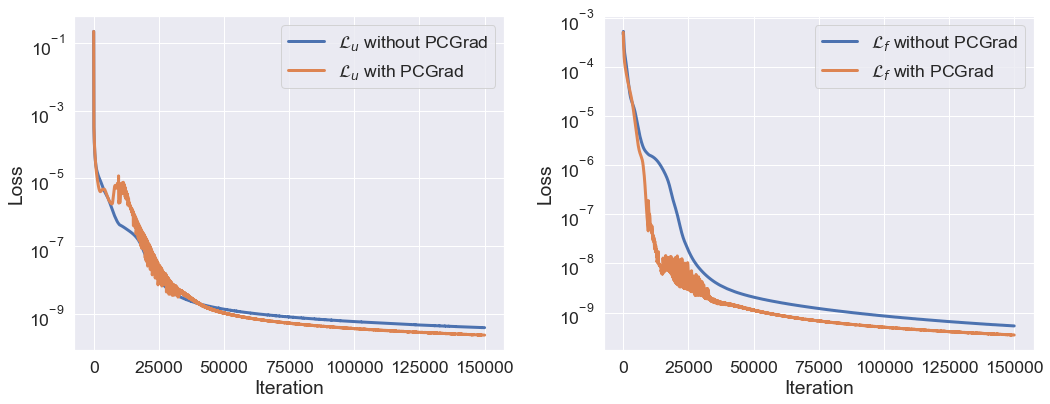

In [15]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 3, 
             label = "$\mathcal{L}_u$ with PCGrad", ax = axes[0])
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Loss")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = np.sum(pinn_loss_log[:, 1:4], axis = 1).flatten(),  linewidth = 3, 
             label = "$\mathcal{L}_f$ without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = np.sum(pinn_pcgrad_loss_log[:, 1:4], axis = 1).flatten(), 
             linewidth = 3, label = "$\mathcal{L}_f$ with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.savefig("performance_comparison_non_homo.pdf")

#### Solution quality comparison

In [16]:
matlab_solver_solution_df = pd.read_csv('nonHomo_300.csv')
matlab_solver_solution_df.columns = ['time', 'state_0', 'state_1', 'state_2']

In [17]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [18]:
matlab_solver_solution_df

state_0   state_1   state_2
0    0.999040  0.000418  0.000544
1    0.998080  0.000837  0.001087
2    0.997110  0.001255  0.001631
3    0.996150  0.001674  0.002175
4    0.995190  0.002092  0.002718
..        ...       ...       ...
295  0.000013  0.000272  0.999720
296  0.000012  0.000257  0.999730
297  0.000011  0.000242  0.999750
298  0.000010  0.000228  0.999760
299  0.000010  0.000215  0.999780

[300 rows x 3 columns]

In [19]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

n_star = 300+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 
x_star_normalized = (x_star-mu)/sigma

In [20]:
y_pred = PINN_solver.model(x_star_normalized)
y_pred_pcgrad = PINN_solver_pcgrad.model(x_star_normalized)

In [21]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = ['state_0', 'state_1', 'state_2'])
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = ['state_0', 'state_1', 'state_2'])

In [22]:
sns.set_style("white")

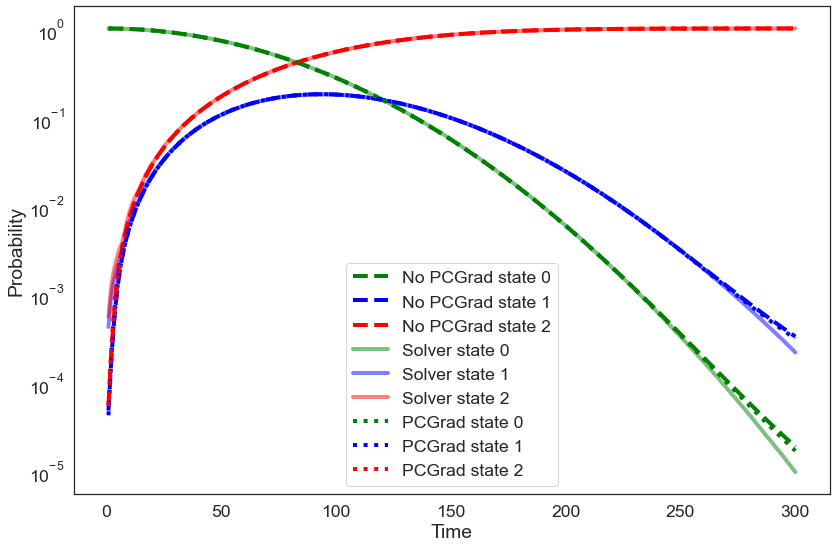

In [23]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

sns.lineplot(x = x_star.flatten(), y = y_pred[:, 0], label = 'No PCGrad state 0', linewidth = 4, color = 'green', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 1], label = 'No PCGrad state 1', linewidth = 4, color = 'blue', 
             linestyle='--', ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred[:, 2], label = 'No PCGrad state 2', linewidth = 4, color = 'red', 
             linestyle='--', ax=ax)

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_0'], label = 'Solver state 0', color = 'green',
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_1'], label = 'Solver state 1', color = 'blue', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['state_2'], label = 'Solver state 2', color = 'red', 
             alpha=0.5, dashes=True, linewidth = 4, ax=ax)

sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 0], label = 'PCGrad state 0', color = 'green', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 1], label = 'PCGrad state 1', color = 'blue', linestyle='dotted',
             linewidth = 4, ax=ax)
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad[:, 2], label = 'PCGrad state 2', color = 'red', linestyle='dotted',
             linewidth = 4, ax=ax)


ax.set_yscale("log")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")

plt.tight_layout()
plt.savefig("comparison.pdf")

In [24]:
y_pred_df.tail()

state_0   state_1   state_2
295  0.000023  0.000384  0.999593
296  0.000022  0.000368  0.999610
297  0.000021  0.000353  0.999626
298  0.000020  0.000339  0.999641
299  0.000019  0.000325  0.999656

In [25]:
y_pred_pcgrad_df.tail()

state_0   state_1   state_2
295  0.000021  0.000362  0.999617
296  0.000020  0.000347  0.999633
297  0.000019  0.000333  0.999648
298  0.000018  0.000320  0.999663
299  0.000017  0.000307  0.999677

In [26]:
y_diff = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad = matlab_solver_solution_df - y_pred_pcgrad_df

In [27]:
y_diff

state_0   state_1   state_2
0   -0.000857  0.000371  0.000488
1   -0.001607  0.000695  0.000917
2   -0.002119  0.000908  0.001208
3   -0.002286  0.000974  0.001310
4   -0.002100  0.000888  0.001213
..        ...       ...       ...
295 -0.000010 -0.000112  0.000127
296 -0.000010 -0.000111  0.000120
297 -0.000010 -0.000111  0.000124
298 -0.000009 -0.000111  0.000119
299 -0.000009 -0.000110  0.000124

[300 rows x 3 columns]

In [28]:
y_diff['mse'] = y_diff.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff['rmse'] = y_diff['mse'].apply(np.sqrt)

y_diff_pcgrad['mse'] = y_diff_pcgrad.apply(lambda x: x['state_0']**2 + x['state_1']**2 + x['state_2']**2, axis = 1)
y_diff_pcgrad['rmse'] = y_diff_pcgrad['mse'].apply(np.sqrt)

In [29]:
y_diff.head()

state_0   state_1   state_2       mse      rmse
0 -0.000857  0.000371  0.000488  0.000001  0.001054
1 -0.001607  0.000695  0.000917  0.000004  0.001977
2 -0.002119  0.000908  0.001208  0.000007  0.002603
3 -0.002286  0.000974  0.001310  0.000008  0.002810
4 -0.002100  0.000888  0.001213  0.000007  0.002583

In [30]:
y_diff_pcgrad.head()

state_0   state_1   state_2       mse      rmse
0 -0.000865  0.000377  0.000490  0.000001  0.001063
1 -0.001598  0.000696  0.000907  0.000004  0.001965
2 -0.002065  0.000896  0.001165  0.000006  0.002534
3 -0.002172  0.000944  0.001226  0.000007  0.002667
4 -0.001946  0.000849  0.001098  0.000006  0.002390

In [31]:
print ('RMSE of PINN without PCGrad is', np.mean(y_diff['rmse']))
print ('RMSE of PINN with PCGrad is', np.mean(y_diff_pcgrad['rmse']))

RMSE of PINN without PCGrad is 0.00048170689085484116
RMSE of PINN with PCGrad is 0.00045283406354632277
